In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "pv",
    "q",
    "q",
    "r",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "t",
    "ttr",
    "u",
    "u",
    "v",
    "v",
    "vo",
    "vo",
    "w",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    900,
    False,
    False,
    False,
    300,
    900,
    300,
    900,
    300,
    900,
    False,
    False,
    False,
    300,
    900,
    False,
    300,
    900,
    300,
    900,
    300,
    900,
    300,
    900,
]
aew_subset = "12hr_before"
model_save_name = "best_model_300_9001.keras"
tuner_project_name = "tuner_run_300_9001"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-09 04:49:59.066093: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 04:49:59.077346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752058199.087801    9318 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752058199.091187    9318 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752058199.100926    9318 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.
Loading crr from Zarr store.
Loading d_300 from Zarr store.


Loading d_900 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.
Loading pv_900 from Zarr store.
Loading q_300 from Zarr store.
Loading q_900 from Zarr store.
Loading r_300 from Zarr store.


Loading r_900 from Zarr store.
Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading t_900 from Zarr store.
Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading u_900 from Zarr store.
Loading v_300 from Zarr store.
Loading v_900 from Zarr store.


Loading vo_300 from Zarr store.
Loading vo_900 from Zarr store.
Loading w_300 from Zarr store.
Loading w_900 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 27)


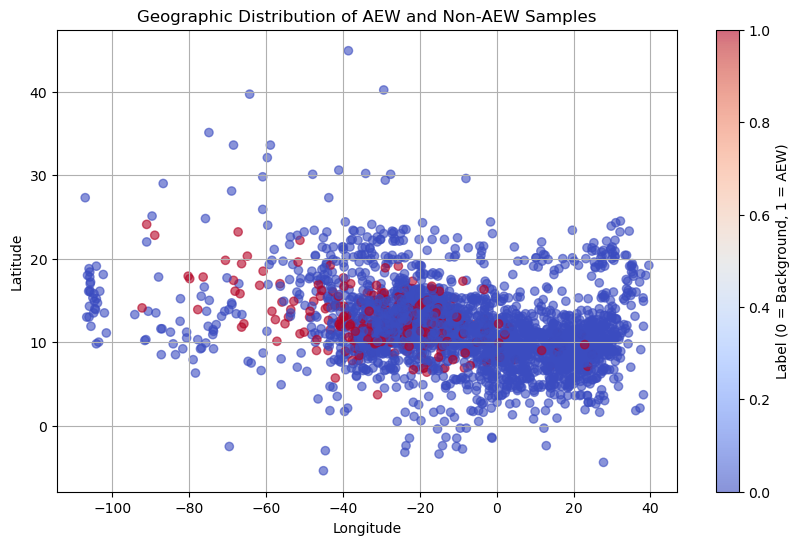

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'pv', 'q', 'q', 'r', 'r', 'sp', 'tcw', 'tcwv', 't', 't', 'ttr', 'u', 'u', 'v', 'v', 'vo', 'vo', 'w', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






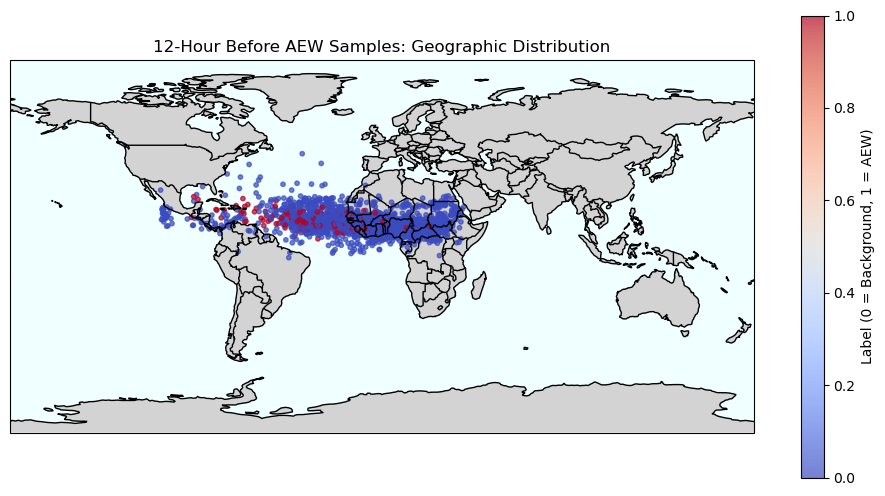

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2750


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -5.4 to 44.9
Longitude Range: -107.1 to 39.6


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 27) (550, 32, 32, 27) (2200,) (550,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 412 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 109 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 27) (2200, 1) (550, 32, 32, 27) (550, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-09 04:51:45.018624: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2750
AEW-positive samples (label=1): 258
Background samples (label=0): 2492


In [35]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 01m 27s]
val_f1_score: 0.7407407164573669

Best val_f1_score So Far: 0.7826086282730103
Total elapsed time: 03h 27m 41s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 32, 32, 27)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 32, 32, 27)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 27)          │           6,588 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 27)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 27)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 53)          │          12,932 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 53)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 53)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 88)            │          42,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 88)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 88)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 88)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 27)                  │           2,403 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              28 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,015 (250.06 KB)

 Trainable params: 64,015 (250.06 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - auc: 0.8166 - binary_accuracy: 0.8492 - cross entropy: 0.3660 - f1_score: 0.3214 - fn: 6.0000 - fp: 32.0000 - loss: 0.0798 - mean_squared_error: 0.1123 - prc: 0.1806 - precision: 0.2195 - recall: 0.6000 - root_mean_squared_error: 0.3351 - tn: 205.0000 - tp: 9.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6794 - binary_accuracy: 0.8669 - cross entropy: 0.3931 - f1_score: 0.2932 - fn: 11.6667 - fp: 32.0000 - loss: 0.0947 - mean_squared_error: 0.1029 - prc: 0.1532 - precision: 0.2195 - recall: 0.4547 - root_mean_squared_error: 0.3206 - tn: 279.3333 - tp: 9.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6654 - binary_accuracy: 0.8631 - cross entropy: 0.4112 - f1_score: 0.2861 - fn: 17.0833 - fp: 42.1667 - loss: 0.0853 - mean_squared_error: 0.1060 - prc: 0.1726 - precision: 0.2193 - recall: 0.4206 - root_mean_squared_error: 0.3251 - tn: 356.9167 - tp: 11.8333

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6768 - binary_accuracy: 0.8475 - cross entropy: 0.4433 - f1_score: 0.2855 - fn: 20.6471 - fp: 60.3529 - loss: 0.0791 - mean_squared_error: 0.1171 - prc: 0.1997 - precision: 0.2145 - recall: 0.4366 - root_mean_squared_error: 0.3410 - tn: 410.8824 - tp: 16.1176

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6818 - binary_accuracy: 0.8380 - cross entropy: 0.4609 - f1_score: 0.2835 - fn: 26.4783 - fp: 76.6522 - loss: 0.0729 - mean_squared_error: 0.1245 - prc: 0.2097 - precision: 0.2123 - recall: 0.4338 - root_mean_squared_error: 0.3516 - tn: 480.6087 - tp: 20.2609

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6841 - binary_accuracy: 0.8298 - cross entropy: 0.4729 - f1_score: 0.2851 - fn: 29.9630 - fp: 91.1852 - loss: 0.0695 - mean_squared_error: 0.1300 - prc: 0.2134 - precision: 0.2122 - recall: 0.4413 - root_mean_squared_error: 0.3590 - tn: 522.6296 - tp: 24.2222

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6882 - binary_accuracy: 0.8230 - cross entropy: 0.4813 - f1_score: 0.2890 - fn: 33.5312 - fp: 108.0312 - loss: 0.0656 - mean_squared_error: 0.1345 - prc: 0.2175 - precision: 0.2137 - recall: 0.4531 - root_mean_squared_error: 0.3651 - tn: 577.1562 - tp: 29.2812

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6949 - binary_accuracy: 0.8199 - cross entropy: 0.4821 - f1_score: 0.2949 - fn: 37.6316 - fp: 123.6842 - loss: 0.0615 - mean_squared_error: 0.1363 - prc: 0.2221 - precision: 0.2175 - recall: 0.4638 - root_mean_squared_error: 0.3679 - tn: 647.8158 - tp: 34.8684

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7029 - binary_accuracy: 0.8186 - cross entropy: 0.4796 - f1_score: 0.3033 - fn: 41.4545 - fp: 137.9773 - loss: 0.0581 - mean_squared_error: 0.1369 - prc: 0.2290 - precision: 0.2237 - recall: 0.4760 - root_mean_squared_error: 0.3688 - tn: 719.3182 - tp: 41.2500

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7107 - binary_accuracy: 0.8182 - cross entropy: 0.4754 - f1_score: 0.3114 - fn: 44.9800 - fp: 151.3800 - loss: 0.0551 - mean_squared_error: 0.1366 - prc: 0.2355 - precision: 0.2297 - recall: 0.4874 - root_mean_squared_error: 0.3686 - tn: 792.0200 - tp: 47.6200

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7173 - binary_accuracy: 0.8183 - cross entropy: 0.4708 - f1_score: 0.3177 - fn: 48.3750 - fp: 164.4107 - loss: 0.0524 - mean_squared_error: 0.1361 - prc: 0.2405 - precision: 0.2344 - recall: 0.4965 - root_mean_squared_error: 0.3679 - tn: 865.6964 - tp: 53.5179

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7228 - binary_accuracy: 0.8187 - cross entropy: 0.4662 - f1_score: 0.3225 - fn: 51.9839 - fp: 176.6129 - loss: 0.0502 - mean_squared_error: 0.1354 - prc: 0.2444 - precision: 0.2382 - recall: 0.5028 - root_mean_squared_error: 0.3670 - tn: 940.4194 - tp: 58.9194

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - auc: 0.7236 - binary_accuracy: 0.8188 - cross entropy: 0.4655 - f1_score: 0.3232 - fn: 52.6190 - fp: 178.5238 - loss: 0.0498 - mean_squared_error: 0.1352 - prc: 0.2450 - precision: 0.2387 - recall: 0.5035 - root_mean_squared_error: 0.3669 - tn: 952.4603 - tp: 59.7619 - val_auc: 0.7945 - val_binary_accuracy: 0.5636 - val_cross entropy: 0.6358 - val_f1_score: 0.1724 - val_fn: 3.0000 - val_fp: 93.0000 - val_loss: 0.1267 - val_mean_squared_error: 0.2251 - val_prc: 0.4269 - val_precision: 0.0971 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4745 - val_tn: 114.0000 - val_tp: 10.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.6917 - binary_accuracy: 0.6250 - cross entropy: 0.6520 - f1_score: 0.1429 - fn: 1.0000 - fp: 11.0000 - loss: 0.0153 - mean_squared_error: 0.2306 - prc: 0.1124 - precision: 0.0833 - recall: 0.5000 - root_mean_squared_error: 0.4802 - tn: 19.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7335 - binary_accuracy: 0.6246 - cross entropy: 0.6231 - f1_score: 0.1816 - fn: 3.2857 - fp: 40.8571 - loss: 0.0155 - mean_squared_error: 0.2194 - prc: 0.1666 - precision: 0.1081 - recall: 0.5951 - root_mean_squared_error: 0.4672 - tn: 78.4286 - tp: 5.4286

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7193 - binary_accuracy: 0.6953 - cross entropy: 0.5548 - f1_score: 0.2031 - fn: 9.4615 - fp: 48.5385 - loss: 0.0155 - mean_squared_error: 0.1891 - prc: 0.1867 - precision: 0.1324 - recall: 0.5064 - root_mean_squared_error: 0.4325 - tn: 157.8462 - tp: 8.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7243 - binary_accuracy: 0.7201 - cross entropy: 0.5326 - f1_score: 0.2316 - fn: 13.4737 - fp: 63.7895 - loss: 0.0153 - mean_squared_error: 0.1793 - prc: 0.2170 - precision: 0.1548 - recall: 0.5126 - root_mean_squared_error: 0.4215 - tn: 229.2632 - tp: 13.4737

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7299 - binary_accuracy: 0.7375 - cross entropy: 0.5151 - f1_score: 0.2527 - fn: 18.8400 - fp: 75.7200 - loss: 0.0152 - mean_squared_error: 0.1716 - prc: 0.2390 - precision: 0.1743 - recall: 0.5088 - root_mean_squared_error: 0.4125 - tn: 302.7600 - tp: 18.6800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7349 - binary_accuracy: 0.7461 - cross entropy: 0.5076 - f1_score: 0.2674 - fn: 23.6774 - fp: 91.0645 - loss: 0.0152 - mean_squared_error: 0.1682 - prc: 0.2535 - precision: 0.1869 - recall: 0.5120 - root_mean_squared_error: 0.4086 - tn: 372.7742 - tp: 24.4839

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7401 - binary_accuracy: 0.7539 - cross entropy: 0.4989 - f1_score: 0.2770 - fn: 28.4595 - fp: 104.4595 - loss: 0.0151 - mean_squared_error: 0.1645 - prc: 0.2618 - precision: 0.1956 - recall: 0.5115 - root_mean_squared_error: 0.4042 - tn: 445.6487 - tp: 29.4324

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7444 - binary_accuracy: 0.7596 - cross entropy: 0.4915 - f1_score: 0.2837 - fn: 32.6905 - fp: 114.5952 - loss: 0.0150 - mean_squared_error: 0.1616 - prc: 0.2686 - precision: 0.2022 - recall: 0.5099 - root_mean_squared_error: 0.4006 - tn: 507.2143 - tp: 33.5000

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7511 - binary_accuracy: 0.7650 - cross entropy: 0.4841 - f1_score: 0.2935 - fn: 36.9583 - fp: 127.8542 - loss: 0.0148 - mean_squared_error: 0.1587 - prc: 0.2823 - precision: 0.2106 - recall: 0.5148 - root_mean_squared_error: 0.3970 - tn: 579.6875 - tp: 39.5000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7564 - binary_accuracy: 0.7706 - cross entropy: 0.4762 - f1_score: 0.3010 - fn: 41.1852 - fp: 139.1481 - loss: 0.0147 - mean_squared_error: 0.1556 - prc: 0.2919 - precision: 0.2175 - recall: 0.5170 - root_mean_squared_error: 0.3931 - tn: 655.0000 - tp: 44.6667

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7612 - binary_accuracy: 0.7757 - cross entropy: 0.4690 - f1_score: 0.3080 - fn: 44.9833 - fp: 150.0333 - loss: 0.0145 - mean_squared_error: 0.1529 - prc: 0.3001 - precision: 0.2238 - recall: 0.5202 - root_mean_squared_error: 0.3896 - tn: 731.1166 - tp: 49.8667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7634 - binary_accuracy: 0.7781 - cross entropy: 0.4659 - f1_score: 0.3115 - fn: 46.8413 - fp: 155.2540 - loss: 0.0145 - mean_squared_error: 0.1516 - prc: 0.3038 - precision: 0.2269 - recall: 0.5220 - root_mean_squared_error: 0.3880 - tn: 768.7302 - tp: 52.5397 - val_auc: 0.8722 - val_binary_accuracy: 0.8136 - val_cross entropy: 0.5059 - val_f1_score: 0.3279 - val_fn: 3.0000 - val_fp: 38.0000 - val_loss: 0.0811 - val_mean_squared_error: 0.1659 - val_prc: 0.3155 - val_precision: 0.2083 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4073 - val_tn: 169.0000 - val_tp: 10.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8333 - binary_accuracy: 0.7188 - cross entropy: 0.5278 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0106 - mean_squared_error: 0.1785 - prc: 0.1531 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4225 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8471 - binary_accuracy: 0.7712 - cross entropy: 0.4812 - f1_score: 0.3206 - fn: 2.0000 - fp: 21.0000 - loss: 0.0098 - mean_squared_error: 0.1583 - prc: 0.2506 - precision: 0.2048 - recall: 0.8117 - root_mean_squared_error: 0.3971 - tn: 83.3333 - tp: 5.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8241 - binary_accuracy: 0.8115 - cross entropy: 0.4367 - f1_score: 0.3284 - fn: 7.3333 - fp: 26.6667 - loss: 0.0104 - mean_squared_error: 0.1391 - prc: 0.2733 - precision: 0.2319 - recall: 0.6506 - root_mean_squared_error: 0.3716 - tn: 165.4167 - tp: 8.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8123 - binary_accuracy: 0.8178 - cross entropy: 0.4330 - f1_score: 0.3400 - fn: 11.5000 - fp: 39.3333 - loss: 0.0110 - mean_squared_error: 0.1375 - prc: 0.2842 - precision: 0.2455 - recall: 0.6156 - root_mean_squared_error: 0.3699 - tn: 239.3889 - tp: 13.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8054 - binary_accuracy: 0.8196 - cross entropy: 0.4318 - f1_score: 0.3480 - fn: 16.3750 - fp: 51.8333 - loss: 0.0114 - mean_squared_error: 0.1371 - prc: 0.2914 - precision: 0.2554 - recall: 0.5960 - root_mean_squared_error: 0.3695 - tn: 312.5417 - tp: 19.2500

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8030 - binary_accuracy: 0.8196 - cross entropy: 0.4326 - f1_score: 0.3572 - fn: 20.7333 - fp: 65.6333 - loss: 0.0117 - mean_squared_error: 0.1374 - prc: 0.3020 - precision: 0.2643 - recall: 0.5916 - root_mean_squared_error: 0.3701 - tn: 383.9000 - tp: 25.7333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8032 - binary_accuracy: 0.8213 - cross entropy: 0.4316 - f1_score: 0.3642 - fn: 24.7500 - fp: 77.5833 - loss: 0.0117 - mean_squared_error: 0.1369 - prc: 0.3109 - precision: 0.2712 - recall: 0.5889 - root_mean_squared_error: 0.3695 - tn: 458.1389 - tp: 31.5278

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8050 - binary_accuracy: 0.8234 - cross entropy: 0.4286 - f1_score: 0.3695 - fn: 29.2381 - fp: 88.0714 - loss: 0.0117 - mean_squared_error: 0.1357 - prc: 0.3187 - precision: 0.2775 - recall: 0.5837 - root_mean_squared_error: 0.3680 - tn: 533.7381 - tp: 36.9524

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8078 - binary_accuracy: 0.8249 - cross entropy: 0.4261 - f1_score: 0.3751 - fn: 32.7234 - fp: 97.0213 - loss: 0.0117 - mean_squared_error: 0.1348 - prc: 0.3277 - precision: 0.2833 - recall: 0.5833 - root_mean_squared_error: 0.3667 - tn: 596.1277 - tp: 42.1277

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8111 - binary_accuracy: 0.8272 - cross entropy: 0.4223 - f1_score: 0.3803 - fn: 36.6604 - fp: 106.7358 - loss: 0.0116 - mean_squared_error: 0.1333 - prc: 0.3362 - precision: 0.2889 - recall: 0.5823 - root_mean_squared_error: 0.3647 - tn: 672.9245 - tp: 47.6792

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8140 - binary_accuracy: 0.8295 - cross entropy: 0.4186 - f1_score: 0.3849 - fn: 40.3220 - fp: 116.1017 - loss: 0.0115 - mean_squared_error: 0.1318 - prc: 0.3427 - precision: 0.2936 - recall: 0.5821 - root_mean_squared_error: 0.3627 - tn: 750.5424 - tp: 53.0339

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8156 - binary_accuracy: 0.8311 - cross entropy: 0.4162 - f1_score: 0.3879 - fn: 42.8571 - fp: 121.6508 - loss: 0.0115 - mean_squared_error: 0.1309 - prc: 0.3464 - precision: 0.2970 - recall: 0.5816 - root_mean_squared_error: 0.3614 - tn: 802.3333 - tp: 56.5238 - val_auc: 0.8683 - val_binary_accuracy: 0.7773 - val_cross entropy: 0.5297 - val_f1_score: 0.3099 - val_fn: 2.0000 - val_fp: 47.0000 - val_loss: 0.0882 - val_mean_squared_error: 0.1753 - val_prc: 0.3851 - val_precision: 0.1897 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4187 - val_tn: 160.0000 - val_tp: 11.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8167 - binary_accuracy: 0.7188 - cross entropy: 0.5711 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0131 - mean_squared_error: 0.1972 - prc: 0.1656 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4441 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8783 - binary_accuracy: 0.7348 - cross entropy: 0.5206 - f1_score: 0.3284 - fn: 0.5000 - fp: 26.8333 - loss: 0.0108 - mean_squared_error: 0.1748 - prc: 0.3824 - precision: 0.2006 - recall: 0.9610 - root_mean_squared_error: 0.4173 - tn: 77.5000 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8614 - binary_accuracy: 0.7889 - cross entropy: 0.4676 - f1_score: 0.3672 - fn: 4.1667 - fp: 33.1667 - loss: 0.0104 - mean_squared_error: 0.1511 - prc: 0.3896 - precision: 0.2451 - recall: 0.8310 - root_mean_squared_error: 0.3871 - tn: 158.9167 - tp: 11.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8540 - binary_accuracy: 0.8094 - cross entropy: 0.4498 - f1_score: 0.3902 - fn: 7.8333 - fp: 41.7222 - loss: 0.0103 - mean_squared_error: 0.1432 - prc: 0.3958 - precision: 0.2726 - recall: 0.7715 - root_mean_squared_error: 0.3771 - tn: 237.0000 - tp: 17.4444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8479 - binary_accuracy: 0.8193 - cross entropy: 0.4428 - f1_score: 0.4027 - fn: 12.3333 - fp: 50.8333 - loss: 0.0104 - mean_squared_error: 0.1400 - prc: 0.4030 - precision: 0.2903 - recall: 0.7323 - root_mean_squared_error: 0.3731 - tn: 313.5417 - tp: 23.2917

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8454 - binary_accuracy: 0.8245 - cross entropy: 0.4399 - f1_score: 0.4137 - fn: 16.3333 - fp: 61.4333 - loss: 0.0104 - mean_squared_error: 0.1387 - prc: 0.4074 - precision: 0.3035 - recall: 0.7137 - root_mean_squared_error: 0.3715 - tn: 388.1000 - tp: 30.1333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8456 - binary_accuracy: 0.8289 - cross entropy: 0.4370 - f1_score: 0.4219 - fn: 19.0857 - fp: 69.4286 - loss: 0.0104 - mean_squared_error: 0.1373 - prc: 0.4118 - precision: 0.3127 - recall: 0.7056 - root_mean_squared_error: 0.3698 - tn: 451.9143 - tp: 35.5714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8465 - binary_accuracy: 0.8330 - cross entropy: 0.4327 - f1_score: 0.4290 - fn: 22.0000 - fp: 76.4750 - loss: 0.0103 - mean_squared_error: 0.1356 - prc: 0.4132 - precision: 0.3211 - recall: 0.6981 - root_mean_squared_error: 0.3674 - tn: 516.7500 - tp: 40.7750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8485 - binary_accuracy: 0.8368 - cross entropy: 0.4281 - f1_score: 0.4376 - fn: 25.4783 - fp: 85.1522 - loss: 0.0102 - mean_squared_error: 0.1337 - prc: 0.4188 - precision: 0.3309 - recall: 0.6929 - root_mean_squared_error: 0.3650 - tn: 593.6739 - tp: 47.6957

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8504 - binary_accuracy: 0.8400 - cross entropy: 0.4236 - f1_score: 0.4439 - fn: 28.5962 - fp: 93.9808 - loss: 0.0101 - mean_squared_error: 0.1320 - prc: 0.4239 - precision: 0.3379 - recall: 0.6896 - root_mean_squared_error: 0.3626 - tn: 671.2308 - tp: 54.1923

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8519 - binary_accuracy: 0.8430 - cross entropy: 0.4191 - f1_score: 0.4488 - fn: 31.6379 - fp: 102.4310 - loss: 0.0100 - mean_squared_error: 0.1302 - prc: 0.4272 - precision: 0.3434 - recall: 0.6866 - root_mean_squared_error: 0.3602 - tn: 749.6724 - tp: 60.2586

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8529 - binary_accuracy: 0.8452 - cross entropy: 0.4155 - f1_score: 0.4523 - fn: 34.3016 - fp: 108.9365 - loss: 0.0100 - mean_squared_error: 0.1289 - prc: 0.4297 - precision: 0.3476 - recall: 0.6837 - root_mean_squared_error: 0.3582 - tn: 815.0476 - tp: 65.0794 - val_auc: 0.8876 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.5129 - val_f1_score: 0.3284 - val_fn: 2.0000 - val_fp: 43.0000 - val_loss: 0.0812 - val_mean_squared_error: 0.1669 - val_prc: 0.4007 - val_precision: 0.2037 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4085 - val_tn: 164.0000 - val_tp: 11.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9667 - binary_accuracy: 0.7812 - cross entropy: 0.4736 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0074 - mean_squared_error: 0.1513 - prc: 0.4507 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3889 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9205 - binary_accuracy: 0.7806 - cross entropy: 0.4771 - f1_score: 0.3471 - fn: 1.3333 - fp: 21.8333 - loss: 0.0085 - mean_squared_error: 0.1539 - prc: 0.4366 - precision: 0.2195 - recall: 0.8804 - root_mean_squared_error: 0.3920 - tn: 82.5000 - tp: 6.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8779 - binary_accuracy: 0.8187 - cross entropy: 0.4454 - f1_score: 0.3656 - fn: 5.9167 - fp: 27.4167 - loss: 0.0088 - mean_squared_error: 0.1404 - prc: 0.4253 - precision: 0.2545 - recall: 0.7328 - root_mean_squared_error: 0.3741 - tn: 164.6667 - tp: 10.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8606 - binary_accuracy: 0.8259 - cross entropy: 0.4391 - f1_score: 0.3759 - fn: 9.9444 - fp: 38.6667 - loss: 0.0092 - mean_squared_error: 0.1377 - prc: 0.4195 - precision: 0.2693 - recall: 0.6854 - root_mean_squared_error: 0.3707 - tn: 240.0556 - tp: 15.3333 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8524 - binary_accuracy: 0.8313 - cross entropy: 0.4354 - f1_score: 0.3882 - fn: 14.3750 - fp: 48.2917 - loss: 0.0094 - mean_squared_error: 0.1360 - prc: 0.4153 - precision: 0.2855 - recall: 0.6600 - root_mean_squared_error: 0.3685 - tn: 316.0833 - tp: 21.2500

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8507 - binary_accuracy: 0.8357 - cross entropy: 0.4327 - f1_score: 0.4041 - fn: 18.1000 - fp: 57.8667 - loss: 0.0095 - mean_squared_error: 0.1348 - prc: 0.4240 - precision: 0.3027 - recall: 0.6543 - root_mean_squared_error: 0.3668 - tn: 391.6667 - tp: 28.3667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8518 - binary_accuracy: 0.8398 - cross entropy: 0.4299 - f1_score: 0.4159 - fn: 20.6571 - fp: 64.8571 - loss: 0.0094 - mean_squared_error: 0.1335 - prc: 0.4320 - precision: 0.3149 - recall: 0.6542 - root_mean_squared_error: 0.3651 - tn: 456.4857 - tp: 34.0000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8531 - binary_accuracy: 0.8441 - cross entropy: 0.4261 - f1_score: 0.4266 - fn: 23.4000 - fp: 70.5750 - loss: 0.0094 - mean_squared_error: 0.1319 - prc: 0.4376 - precision: 0.3268 - recall: 0.6529 - root_mean_squared_error: 0.3628 - tn: 522.6500 - tp: 39.3750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8555 - binary_accuracy: 0.8480 - cross entropy: 0.4223 - f1_score: 0.4387 - fn: 26.5870 - fp: 77.9783 - loss: 0.0093 - mean_squared_error: 0.1302 - prc: 0.4448 - precision: 0.3398 - recall: 0.6543 - root_mean_squared_error: 0.3606 - tn: 600.8478 - tp: 46.5870

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8582 - binary_accuracy: 0.8517 - cross entropy: 0.4174 - f1_score: 0.4488 - fn: 30.0000 - fp: 86.9623 - loss: 0.0093 - mean_squared_error: 0.1283 - prc: 0.4504 - precision: 0.3503 - recall: 0.6561 - root_mean_squared_error: 0.3579 - tn: 692.6981 - tp: 54.3396

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8600 - binary_accuracy: 0.8544 - cross entropy: 0.4129 - f1_score: 0.4543 - fn: 33.1525 - fp: 94.3898 - loss: 0.0092 - mean_squared_error: 0.1266 - prc: 0.4529 - precision: 0.3565 - recall: 0.6552 - root_mean_squared_error: 0.3554 - tn: 772.2542 - tp: 60.2034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8608 - binary_accuracy: 0.8560 - cross entropy: 0.4101 - f1_score: 0.4576 - fn: 35.3333 - fp: 99.0794 - loss: 0.0092 - mean_squared_error: 0.1255 - prc: 0.4548 - precision: 0.3604 - recall: 0.6544 - root_mean_squared_error: 0.3539 - tn: 824.9048 - tp: 64.0476 - val_auc: 0.9017 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.5207 - val_f1_score: 0.3038 - val_fn: 1.0000 - val_fp: 54.0000 - val_loss: 0.0949 - val_mean_squared_error: 0.1723 - val_prc: 0.4126 - val_precision: 0.1818 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4151 - val_tn: 153.0000 - val_tp: 12.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9000 - binary_accuracy: 0.6562 - cross entropy: 0.5824 - f1_score: 0.2667 - fn: 0.0000e+00 - fp: 11.0000 - loss: 0.0144 - mean_squared_error: 0.2049 - prc: 0.2680 - precision: 0.1538 - recall: 1.0000 - root_mean_squared_error: 0.4527 - tn: 19.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8266 - binary_accuracy: 0.6981 - cross entropy: 0.5336 - f1_score: 0.2344 - fn: 2.8333 - fp: 27.8333 - loss: 0.0133 - mean_squared_error: 0.1824 - prc: 0.2085 - precision: 0.1440 - recall: 0.6874 - root_mean_squared_error: 0.4258 - tn: 76.5000 - tp: 4.8333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8222 - binary_accuracy: 0.7678 - cross entropy: 0.4653 - f1_score: 0.2867 - fn: 6.9167 - fp: 32.7500 - loss: 0.0120 - mean_squared_error: 0.1526 - prc: 0.2300 - precision: 0.1973 - recall: 0.6110 - root_mean_squared_error: 0.3880 - tn: 159.3333 - tp: 9.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8292 - binary_accuracy: 0.7934 - cross entropy: 0.4442 - f1_score: 0.3292 - fn: 10.1667 - fp: 41.9444 - loss: 0.0113 - mean_squared_error: 0.1430 - prc: 0.2619 - precision: 0.2353 - recall: 0.6137 - root_mean_squared_error: 0.3759 - tn: 236.7778 - tp: 15.1111

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8333 - binary_accuracy: 0.8069 - cross entropy: 0.4348 - f1_score: 0.3586 - fn: 14.6800 - fp: 54.1200 - loss: 0.0109 - mean_squared_error: 0.1385 - prc: 0.2909 - precision: 0.2628 - recall: 0.6164 - root_mean_squared_error: 0.3704 - tn: 324.3600 - tp: 22.8400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8355 - binary_accuracy: 0.8131 - cross entropy: 0.4310 - f1_score: 0.3730 - fn: 18.8710 - fp: 65.0000 - loss: 0.0108 - mean_squared_error: 0.1365 - prc: 0.3086 - precision: 0.2772 - recall: 0.6145 - root_mean_squared_error: 0.3681 - tn: 398.8387 - tp: 29.2903

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8379 - binary_accuracy: 0.8183 - cross entropy: 0.4279 - f1_score: 0.3841 - fn: 21.6944 - fp: 73.1111 - loss: 0.0106 - mean_squared_error: 0.1350 - prc: 0.3202 - precision: 0.2877 - recall: 0.6169 - root_mean_squared_error: 0.3662 - tn: 462.6111 - tp: 34.5833

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8406 - binary_accuracy: 0.8240 - cross entropy: 0.4237 - f1_score: 0.3957 - fn: 25.3810 - fp: 81.5000 - loss: 0.0105 - mean_squared_error: 0.1330 - prc: 0.3317 - precision: 0.2997 - recall: 0.6176 - root_mean_squared_error: 0.3636 - tn: 540.3095 - tp: 40.8095

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8444 - binary_accuracy: 0.8290 - cross entropy: 0.4195 - f1_score: 0.4083 - fn: 29.2041 - fp: 91.9592 - loss: 0.0103 - mean_squared_error: 0.1312 - prc: 0.3490 - precision: 0.3119 - recall: 0.6222 - root_mean_squared_error: 0.3611 - tn: 630.0204 - tp: 48.8163

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8471 - binary_accuracy: 0.8329 - cross entropy: 0.4156 - f1_score: 0.4159 - fn: 32.5091 - fp: 100.2727 - loss: 0.0101 - mean_squared_error: 0.1295 - prc: 0.3595 - precision: 0.3196 - recall: 0.6238 - root_mean_squared_error: 0.3589 - tn: 708.3636 - tp: 54.8545

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8494 - binary_accuracy: 0.8366 - cross entropy: 0.4114 - f1_score: 0.4226 - fn: 35.7377 - fp: 107.8197 - loss: 0.0100 - mean_squared_error: 0.1278 - prc: 0.3686 - precision: 0.3267 - recall: 0.6249 - root_mean_squared_error: 0.3565 - tn: 787.8033 - tp: 60.6393

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8500 - binary_accuracy: 0.8378 - cross entropy: 0.4101 - f1_score: 0.4248 - fn: 36.8254 - fp: 110.1111 - loss: 0.0100 - mean_squared_error: 0.1273 - prc: 0.3714 - precision: 0.3290 - recall: 0.6252 - root_mean_squared_error: 0.3558 - tn: 813.8730 - tp: 62.5556 - val_auc: 0.9039 - val_binary_accuracy: 0.8000 - val_cross entropy: 0.5223 - val_f1_score: 0.3529 - val_fn: 1.0000 - val_fp: 43.0000 - val_loss: 0.0842 - val_mean_squared_error: 0.1706 - val_prc: 0.5566 - val_precision: 0.2182 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4130 - val_tn: 164.0000 - val_tp: 12.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9333 - binary_accuracy: 0.6875 - cross entropy: 0.5294 - f1_score: 0.2857 - fn: 0.0000e+00 - fp: 10.0000 - loss: 0.0098 - mean_squared_error: 0.1754 - prc: 0.3069 - precision: 0.1667 - recall: 1.0000 - root_mean_squared_error: 0.4188 - tn: 20.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8780 - binary_accuracy: 0.7367 - cross entropy: 0.5261 - f1_score: 0.3038 - fn: 1.3333 - fp: 25.3333 - loss: 0.0102 - mean_squared_error: 0.1743 - prc: 0.2995 - precision: 0.1882 - recall: 0.8368 - root_mean_squared_error: 0.4171 - tn: 79.0000 - tp: 6.3333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8634 - binary_accuracy: 0.7917 - cross entropy: 0.4772 - f1_score: 0.3399 - fn: 5.8333 - fp: 30.7500 - loss: 0.0096 - mean_squared_error: 0.1530 - prc: 0.3305 - precision: 0.2322 - recall: 0.7257 - root_mean_squared_error: 0.3900 - tn: 161.3333 - tp: 10.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8449 - binary_accuracy: 0.8046 - cross entropy: 0.4644 - f1_score: 0.3424 - fn: 11.0000 - fp: 41.4444 - loss: 0.0098 - mean_squared_error: 0.1477 - prc: 0.3263 - precision: 0.2427 - recall: 0.6538 - root_mean_squared_error: 0.3834 - tn: 237.2778 - tp: 14.2778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8383 - binary_accuracy: 0.8112 - cross entropy: 0.4590 - f1_score: 0.3556 - fn: 15.3750 - fp: 53.0417 - loss: 0.0099 - mean_squared_error: 0.1455 - prc: 0.3308 - precision: 0.2575 - recall: 0.6335 - root_mean_squared_error: 0.3807 - tn: 311.3333 - tp: 20.2500

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8381 - binary_accuracy: 0.8172 - cross entropy: 0.4533 - f1_score: 0.3709 - fn: 19.6333 - fp: 63.0000 - loss: 0.0100 - mean_squared_error: 0.1431 - prc: 0.3398 - precision: 0.2742 - recall: 0.6250 - root_mean_squared_error: 0.3776 - tn: 386.5333 - tp: 26.8333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8398 - binary_accuracy: 0.8216 - cross entropy: 0.4492 - f1_score: 0.3815 - fn: 22.4571 - fp: 71.3429 - loss: 0.0099 - mean_squared_error: 0.1413 - prc: 0.3476 - precision: 0.2845 - recall: 0.6244 - root_mean_squared_error: 0.3753 - tn: 450.0000 - tp: 32.2000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8421 - binary_accuracy: 0.8264 - cross entropy: 0.4434 - f1_score: 0.3918 - fn: 26.1463 - fp: 80.1707 - loss: 0.0098 - mean_squared_error: 0.1389 - prc: 0.3570 - precision: 0.2956 - recall: 0.6221 - root_mean_squared_error: 0.3721 - tn: 527.3415 - tp: 38.3415

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8455 - binary_accuracy: 0.8307 - cross entropy: 0.4377 - f1_score: 0.4036 - fn: 30.2083 - fp: 90.7917 - loss: 0.0097 - mean_squared_error: 0.1366 - prc: 0.3721 - precision: 0.3074 - recall: 0.6234 - root_mean_squared_error: 0.3690 - tn: 616.7500 - tp: 46.2500

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8480 - binary_accuracy: 0.8338 - cross entropy: 0.4328 - f1_score: 0.4101 - fn: 33.6111 - fp: 99.7963 - loss: 0.0096 - mean_squared_error: 0.1347 - prc: 0.3819 - precision: 0.3142 - recall: 0.6233 - root_mean_squared_error: 0.3663 - tn: 694.3519 - tp: 52.2407

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8507 - binary_accuracy: 0.8373 - cross entropy: 0.4270 - f1_score: 0.4165 - fn: 37.5082 - fp: 109.5738 - loss: 0.0095 - mean_squared_error: 0.1324 - prc: 0.3912 - precision: 0.3209 - recall: 0.6229 - root_mean_squared_error: 0.3632 - tn: 786.0492 - tp: 58.8689

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8512 - binary_accuracy: 0.8382 - cross entropy: 0.4254 - f1_score: 0.4180 - fn: 38.7302 - fp: 112.0952 - loss: 0.0094 - mean_squared_error: 0.1318 - prc: 0.3936 - precision: 0.3228 - recall: 0.6222 - root_mean_squared_error: 0.3624 - tn: 811.8889 - tp: 60.6508 - val_auc: 0.8809 - val_binary_accuracy: 0.7727 - val_cross entropy: 0.5432 - val_f1_score: 0.3056 - val_fn: 2.0000 - val_fp: 48.0000 - val_loss: 0.0898 - val_mean_squared_error: 0.1797 - val_prc: 0.4954 - val_precision: 0.1864 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4239 - val_tn: 159.0000 - val_tp: 11.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9417 - binary_accuracy: 0.6875 - cross entropy: 0.5565 - f1_score: 0.2857 - fn: 0.0000e+00 - fp: 10.0000 - loss: 0.0113 - mean_squared_error: 0.1887 - prc: 0.6486 - precision: 0.1667 - recall: 1.0000 - root_mean_squared_error: 0.4344 - tn: 20.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9295 - binary_accuracy: 0.7317 - cross entropy: 0.5394 - f1_score: 0.3186 - fn: 1.0000 - fp: 30.0000 - loss: 0.0108 - mean_squared_error: 0.1801 - prc: 0.4526 - precision: 0.1950 - recall: 0.9278 - root_mean_squared_error: 0.4238 - tn: 89.2857 - tp: 7.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8909 - binary_accuracy: 0.7811 - cross entropy: 0.4888 - f1_score: 0.3334 - fn: 6.6923 - fp: 34.8462 - loss: 0.0103 - mean_squared_error: 0.1583 - prc: 0.4132 - precision: 0.2266 - recall: 0.7495 - root_mean_squared_error: 0.3964 - tn: 171.5385 - tp: 10.9231

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8796 - binary_accuracy: 0.8075 - cross entropy: 0.4640 - f1_score: 0.3613 - fn: 11.7500 - fp: 42.5000 - loss: 0.0098 - mean_squared_error: 0.1476 - prc: 0.4103 - precision: 0.2615 - recall: 0.6841 - root_mean_squared_error: 0.3827 - tn: 264.9000 - tp: 16.8500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8745 - binary_accuracy: 0.8177 - cross entropy: 0.4544 - f1_score: 0.3809 - fn: 16.0000 - fp: 51.4615 - loss: 0.0097 - mean_squared_error: 0.1435 - prc: 0.4140 - precision: 0.2833 - recall: 0.6646 - root_mean_squared_error: 0.3775 - tn: 341.1538 - tp: 23.3846

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8742 - binary_accuracy: 0.8248 - cross entropy: 0.4472 - f1_score: 0.3974 - fn: 19.5312 - fp: 60.8125 - loss: 0.0096 - mean_squared_error: 0.1403 - prc: 0.4235 - precision: 0.3000 - recall: 0.6586 - root_mean_squared_error: 0.3734 - tn: 417.3750 - tp: 30.2812

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8749 - binary_accuracy: 0.8315 - cross entropy: 0.4402 - f1_score: 0.4119 - fn: 22.6316 - fp: 68.7895 - loss: 0.0094 - mean_squared_error: 0.1373 - prc: 0.4318 - precision: 0.3146 - recall: 0.6569 - root_mean_squared_error: 0.3695 - tn: 495.7105 - tp: 36.8684

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8755 - binary_accuracy: 0.8365 - cross entropy: 0.4343 - f1_score: 0.4226 - fn: 26.2955 - fp: 76.6364 - loss: 0.0093 - mean_squared_error: 0.1348 - prc: 0.4404 - precision: 0.3264 - recall: 0.6535 - root_mean_squared_error: 0.3662 - tn: 573.6591 - tp: 43.4091

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8767 - binary_accuracy: 0.8402 - cross entropy: 0.4292 - f1_score: 0.4311 - fn: 29.6800 - fp: 85.0000 - loss: 0.0092 - mean_squared_error: 0.1328 - prc: 0.4496 - precision: 0.3353 - recall: 0.6521 - root_mean_squared_error: 0.3634 - tn: 651.4000 - tp: 49.9200

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8775 - binary_accuracy: 0.8436 - cross entropy: 0.4243 - f1_score: 0.4373 - fn: 33.1071 - fp: 92.7321 - loss: 0.0091 - mean_squared_error: 0.1308 - prc: 0.4554 - precision: 0.3422 - recall: 0.6496 - root_mean_squared_error: 0.3607 - tn: 730.3750 - tp: 55.7857

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8781 - binary_accuracy: 0.8471 - cross entropy: 0.4195 - f1_score: 0.4432 - fn: 36.4516 - fp: 99.4516 - loss: 0.0090 - mean_squared_error: 0.1289 - prc: 0.4605 - precision: 0.3491 - recall: 0.6476 - root_mean_squared_error: 0.3581 - tn: 810.5806 - tp: 61.4516

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8782 - binary_accuracy: 0.8476 - cross entropy: 0.4188 - f1_score: 0.4442 - fn: 37.0000 - fp: 100.4762 - loss: 0.0090 - mean_squared_error: 0.1286 - prc: 0.4613 - precision: 0.3503 - recall: 0.6472 - root_mean_squared_error: 0.3577 - tn: 823.5079 - tp: 62.3810 - val_auc: 0.8896 - val_binary_accuracy: 0.7727 - val_cross entropy: 0.5304 - val_f1_score: 0.3056 - val_fn: 2.0000 - val_fp: 48.0000 - val_loss: 0.0849 - val_mean_squared_error: 0.1735 - val_prc: 0.5259 - val_precision: 0.1864 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4166 - val_tn: 159.0000 - val_tp: 11.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9667 - binary_accuracy: 0.7188 - cross entropy: 0.5245 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0093 - mean_squared_error: 0.1715 - prc: 0.4507 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.4141 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9401 - binary_accuracy: 0.7652 - cross entropy: 0.5136 - f1_score: 0.3558 - fn: 0.5000 - fp: 23.3333 - loss: 0.0093 - mean_squared_error: 0.1675 - prc: 0.4890 - precision: 0.2213 - recall: 0.9610 - root_mean_squared_error: 0.4089 - tn: 81.0000 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9070 - binary_accuracy: 0.8091 - cross entropy: 0.4666 - f1_score: 0.3789 - fn: 4.8333 - fp: 29.2500 - loss: 0.0091 - mean_squared_error: 0.1471 - prc: 0.4742 - precision: 0.2589 - recall: 0.8036 - root_mean_squared_error: 0.3823 - tn: 162.8333 - tp: 11.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8961 - binary_accuracy: 0.8254 - cross entropy: 0.4484 - f1_score: 0.3957 - fn: 9.0000 - fp: 37.1111 - loss: 0.0090 - mean_squared_error: 0.1393 - prc: 0.4690 - precision: 0.2838 - recall: 0.7364 - root_mean_squared_error: 0.3722 - tn: 241.6111 - tp: 16.2778 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8906 - binary_accuracy: 0.8346 - cross entropy: 0.4396 - f1_score: 0.4142 - fn: 12.8750 - fp: 45.5000 - loss: 0.0090 - mean_squared_error: 0.1356 - prc: 0.4760 - precision: 0.3062 - recall: 0.7106 - root_mean_squared_error: 0.3673 - tn: 318.8750 - tp: 22.7500

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8883 - binary_accuracy: 0.8389 - cross entropy: 0.4348 - f1_score: 0.4252 - fn: 16.3103 - fp: 52.9310 - loss: 0.0090 - mean_squared_error: 0.1336 - prc: 0.4829 - precision: 0.3200 - recall: 0.6964 - root_mean_squared_error: 0.3647 - tn: 382.3448 - tp: 28.4138

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8884 - binary_accuracy: 0.8435 - cross entropy: 0.4296 - f1_score: 0.4371 - fn: 19.4286 - fp: 61.8000 - loss: 0.0089 - mean_squared_error: 0.1314 - prc: 0.4944 - precision: 0.3327 - recall: 0.6909 - root_mean_squared_error: 0.3618 - tn: 459.5428 - tp: 35.2286

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8880 - binary_accuracy: 0.8482 - cross entropy: 0.4231 - f1_score: 0.4474 - fn: 23.5000 - fp: 70.9286 - loss: 0.0088 - mean_squared_error: 0.1288 - prc: 0.5028 - precision: 0.3450 - recall: 0.6834 - root_mean_squared_error: 0.3582 - tn: 550.8810 - tp: 42.6905

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8884 - binary_accuracy: 0.8513 - cross entropy: 0.4181 - f1_score: 0.4565 - fn: 27.1633 - fp: 81.1020 - loss: 0.0087 - mean_squared_error: 0.1269 - prc: 0.5128 - precision: 0.3547 - recall: 0.6815 - root_mean_squared_error: 0.3555 - tn: 640.8776 - tp: 50.8571

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8885 - binary_accuracy: 0.8541 - cross entropy: 0.4129 - f1_score: 0.4618 - fn: 31.0893 - fp: 90.3571 - loss: 0.0087 - mean_squared_error: 0.1250 - prc: 0.5185 - precision: 0.3612 - recall: 0.6769 - root_mean_squared_error: 0.3528 - tn: 732.7500 - tp: 57.8036

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8884 - binary_accuracy: 0.8568 - cross entropy: 0.4080 - f1_score: 0.4662 - fn: 34.9841 - fp: 98.8889 - loss: 0.0086 - mean_squared_error: 0.1231 - prc: 0.5222 - precision: 0.3669 - recall: 0.6727 - root_mean_squared_error: 0.3502 - tn: 825.0952 - tp: 64.3968 - val_auc: 0.9000 - val_binary_accuracy: 0.8091 - val_cross entropy: 0.5156 - val_f1_score: 0.3437 - val_fn: 2.0000 - val_fp: 40.0000 - val_loss: 0.0839 - val_mean_squared_error: 0.1675 - val_prc: 0.5419 - val_precision: 0.2157 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4093 - val_tn: 167.0000 - val_tp: 11.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9833 - binary_accuracy: 0.6875 - cross entropy: 0.5025 - f1_score: 0.2857 - fn: 0.0000e+00 - fp: 10.0000 - loss: 0.0090 - mean_squared_error: 0.1658 - prc: 0.7973 - precision: 0.1667 - recall: 1.0000 - root_mean_squared_error: 0.4072 - tn: 20.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9559 - binary_accuracy: 0.7650 - cross entropy: 0.4764 - f1_score: 0.3570 - fn: 0.8571 - fp: 25.0000 - loss: 0.0082 - mean_squared_error: 0.1530 - prc: 0.6573 - precision: 0.2251 - recall: 0.9380 - root_mean_squared_error: 0.3904 - tn: 94.2857 - tp: 7.8571     

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9160 - binary_accuracy: 0.8087 - cross entropy: 0.4392 - f1_score: 0.3722 - fn: 6.3846 - fp: 29.2308 - loss: 0.0083 - mean_squared_error: 0.1368 - prc: 0.5733 - precision: 0.2616 - recall: 0.7617 - root_mean_squared_error: 0.3687 - tn: 177.1538 - tp: 11.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9038 - binary_accuracy: 0.8257 - cross entropy: 0.4266 - f1_score: 0.3916 - fn: 10.3684 - fp: 36.8947 - loss: 0.0082 - mean_squared_error: 0.1313 - prc: 0.5472 - precision: 0.2870 - recall: 0.7080 - root_mean_squared_error: 0.3614 - tn: 256.1579 - tp: 16.5789

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8976 - binary_accuracy: 0.8330 - cross entropy: 0.4214 - f1_score: 0.4075 - fn: 14.4000 - fp: 46.4000 - loss: 0.0083 - mean_squared_error: 0.1290 - prc: 0.5384 - precision: 0.3054 - recall: 0.6867 - root_mean_squared_error: 0.3584 - tn: 332.0800 - tp: 23.1200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8953 - binary_accuracy: 0.8377 - cross entropy: 0.4179 - f1_score: 0.4207 - fn: 18.0968 - fp: 56.0645 - loss: 0.0083 - mean_squared_error: 0.1275 - prc: 0.5387 - precision: 0.3198 - recall: 0.6772 - root_mean_squared_error: 0.3564 - tn: 407.7742 - tp: 30.0645

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8947 - binary_accuracy: 0.8419 - cross entropy: 0.4146 - f1_score: 0.4299 - fn: 20.9167 - fp: 62.8889 - loss: 0.0082 - mean_squared_error: 0.1261 - prc: 0.5396 - precision: 0.3300 - recall: 0.6720 - root_mean_squared_error: 0.3545 - tn: 472.8333 - tp: 35.3611

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8943 - binary_accuracy: 0.8468 - cross entropy: 0.4102 - f1_score: 0.4411 - fn: 24.3095 - fp: 69.9048 - loss: 0.0082 - mean_squared_error: 0.1243 - prc: 0.5408 - precision: 0.3427 - recall: 0.6680 - root_mean_squared_error: 0.3520 - tn: 551.9048 - tp: 41.8810

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8946 - binary_accuracy: 0.8503 - cross entropy: 0.4069 - f1_score: 0.4516 - fn: 27.2500 - fp: 77.9375 - loss: 0.0082 - mean_squared_error: 0.1230 - prc: 0.5447 - precision: 0.3535 - recall: 0.6692 - root_mean_squared_error: 0.3502 - tn: 629.6042 - tp: 49.2083

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8946 - binary_accuracy: 0.8540 - cross entropy: 0.4027 - f1_score: 0.4600 - fn: 30.6545 - fp: 86.7636 - loss: 0.0081 - mean_squared_error: 0.1214 - prc: 0.5461 - precision: 0.3624 - recall: 0.6689 - root_mean_squared_error: 0.3479 - tn: 721.8727 - tp: 56.7091

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8946 - binary_accuracy: 0.8569 - cross entropy: 0.3989 - f1_score: 0.4661 - fn: 33.5410 - fp: 93.7541 - loss: 0.0081 - mean_squared_error: 0.1200 - prc: 0.5468 - precision: 0.3690 - recall: 0.6685 - root_mean_squared_error: 0.3459 - tn: 801.8688 - tp: 62.8361

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8946 - binary_accuracy: 0.8578 - cross entropy: 0.3978 - f1_score: 0.4680 - fn: 34.5397 - fp: 95.9524 - loss: 0.0081 - mean_squared_error: 0.1196 - prc: 0.5471 - precision: 0.3711 - recall: 0.6682 - root_mean_squared_error: 0.3453 - tn: 828.0317 - tp: 64.8413 - val_auc: 0.9006 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.4511 - val_f1_score: 0.4314 - val_fn: 2.0000 - val_fp: 27.0000 - val_loss: 0.0628 - val_mean_squared_error: 0.1382 - val_prc: 0.4935 - val_precision: 0.2895 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3718 - val_tn: 180.0000 - val_tp: 11.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9833 - binary_accuracy: 0.8125 - cross entropy: 0.4638 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0075 - mean_squared_error: 0.1471 - prc: 0.7973 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3836 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9539 - binary_accuracy: 0.8166 - cross entropy: 0.4421 - f1_score: 0.4143 - fn: 0.5000 - fp: 18.3333 - loss: 0.0072 - mean_squared_error: 0.1375 - prc: 0.6033 - precision: 0.2686 - recall: 0.9610 - root_mean_squared_error: 0.3705 - tn: 86.0000 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9167 - binary_accuracy: 0.8522 - cross entropy: 0.4087 - f1_score: 0.4425 - fn: 4.7500 - fp: 21.7500 - loss: 0.0074 - mean_squared_error: 0.1233 - prc: 0.5477 - precision: 0.3208 - recall: 0.8090 - root_mean_squared_error: 0.3504 - tn: 170.3333 - tp: 11.1667

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9014 - binary_accuracy: 0.8603 - cross entropy: 0.4029 - f1_score: 0.4533 - fn: 9.2105 - fp: 31.3158 - loss: 0.0077 - mean_squared_error: 0.1210 - prc: 0.5217 - precision: 0.3419 - recall: 0.7425 - root_mean_squared_error: 0.3473 - tn: 261.7368 - tp: 17.7368

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8927 - binary_accuracy: 0.8604 - cross entropy: 0.4026 - f1_score: 0.4547 - fn: 13.8000 - fp: 41.1200 - loss: 0.0080 - mean_squared_error: 0.1209 - prc: 0.5125 - precision: 0.3489 - recall: 0.7091 - root_mean_squared_error: 0.3474 - tn: 337.3600 - tp: 23.7200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8886 - binary_accuracy: 0.8597 - cross entropy: 0.4036 - f1_score: 0.4573 - fn: 17.9032 - fp: 51.6452 - loss: 0.0082 - mean_squared_error: 0.1213 - prc: 0.5154 - precision: 0.3541 - recall: 0.6920 - root_mean_squared_error: 0.3480 - tn: 412.1935 - tp: 30.2581

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8872 - binary_accuracy: 0.8606 - cross entropy: 0.4032 - f1_score: 0.4603 - fn: 20.9167 - fp: 59.2222 - loss: 0.0082 - mean_squared_error: 0.1211 - prc: 0.5189 - precision: 0.3587 - recall: 0.6832 - root_mean_squared_error: 0.3478 - tn: 476.5000 - tp: 35.3611

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8867 - binary_accuracy: 0.8621 - cross entropy: 0.4010 - f1_score: 0.4642 - fn: 24.8333 - fp: 67.0476 - loss: 0.0082 - mean_squared_error: 0.1203 - prc: 0.5232 - precision: 0.3651 - recall: 0.6735 - root_mean_squared_error: 0.3466 - tn: 554.7619 - tp: 41.3571

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8876 - binary_accuracy: 0.8634 - cross entropy: 0.3987 - f1_score: 0.4696 - fn: 28.2917 - fp: 75.3333 - loss: 0.0082 - mean_squared_error: 0.1194 - prc: 0.5294 - precision: 0.3718 - recall: 0.6701 - root_mean_squared_error: 0.3453 - tn: 632.2083 - tp: 48.1667

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8885 - binary_accuracy: 0.8649 - cross entropy: 0.3957 - f1_score: 0.4735 - fn: 31.5926 - fp: 83.0370 - loss: 0.0081 - mean_squared_error: 0.1183 - prc: 0.5331 - precision: 0.3767 - recall: 0.6667 - root_mean_squared_error: 0.3438 - tn: 711.1111 - tp: 54.2593

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8895 - binary_accuracy: 0.8667 - cross entropy: 0.3924 - f1_score: 0.4772 - fn: 34.7333 - fp: 90.0667 - loss: 0.0081 - mean_squared_error: 0.1171 - prc: 0.5358 - precision: 0.3814 - recall: 0.6642 - root_mean_squared_error: 0.3420 - tn: 791.0833 - tp: 60.1167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8897 - binary_accuracy: 0.8675 - cross entropy: 0.3908 - f1_score: 0.4789 - fn: 36.4127 - fp: 93.3016 - loss: 0.0080 - mean_squared_error: 0.1165 - prc: 0.5368 - precision: 0.3838 - recall: 0.6627 - root_mean_squared_error: 0.3411 - tn: 830.6826 - tp: 62.9683 - val_auc: 0.9013 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.4719 - val_f1_score: 0.4138 - val_fn: 1.0000 - val_fp: 33.0000 - val_loss: 0.0729 - val_mean_squared_error: 0.1484 - val_prc: 0.5845 - val_precision: 0.2667 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3852 - val_tn: 174.0000 - val_tp: 12.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9500 - binary_accuracy: 0.7500 - cross entropy: 0.5217 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0097 - mean_squared_error: 0.1726 - prc: 0.6653 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4155 - tn: 22.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9408 - binary_accuracy: 0.7898 - cross entropy: 0.4955 - f1_score: 0.3813 - fn: 0.5000 - fp: 20.8333 - loss: 0.0093 - mean_squared_error: 0.1611 - prc: 0.6876 - precision: 0.2415 - recall: 0.9610 - root_mean_squared_error: 0.4008 - tn: 83.5000 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9014 - binary_accuracy: 0.8344 - cross entropy: 0.4501 - f1_score: 0.4185 - fn: 4.5833 - fp: 24.3333 - loss: 0.0090 - mean_squared_error: 0.1413 - prc: 0.6120 - precision: 0.2974 - recall: 0.8109 - root_mean_squared_error: 0.3746 - tn: 167.7500 - tp: 11.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8879 - binary_accuracy: 0.8497 - cross entropy: 0.4350 - f1_score: 0.4414 - fn: 8.2778 - fp: 30.7778 - loss: 0.0089 - mean_squared_error: 0.1347 - prc: 0.5698 - precision: 0.3293 - recall: 0.7544 - root_mean_squared_error: 0.3660 - tn: 247.9444 - tp: 17.0000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8823 - binary_accuracy: 0.8548 - cross entropy: 0.4293 - f1_score: 0.4536 - fn: 12.1250 - fp: 39.5417 - loss: 0.0089 - mean_squared_error: 0.1322 - prc: 0.5508 - precision: 0.3457 - recall: 0.7275 - root_mean_squared_error: 0.3628 - tn: 324.8333 - tp: 23.5000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8804 - binary_accuracy: 0.8573 - cross entropy: 0.4265 - f1_score: 0.4609 - fn: 15.6897 - fp: 46.5517 - loss: 0.0089 - mean_squared_error: 0.1309 - prc: 0.5424 - precision: 0.3567 - recall: 0.7104 - root_mean_squared_error: 0.3611 - tn: 388.7242 - tp: 29.0345

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8808 - binary_accuracy: 0.8599 - cross entropy: 0.4242 - f1_score: 0.4681 - fn: 18.5000 - fp: 53.4118 - loss: 0.0088 - mean_squared_error: 0.1298 - prc: 0.5399 - precision: 0.3655 - recall: 0.7025 - root_mean_squared_error: 0.3597 - tn: 453.5294 - tp: 34.5588

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8816 - binary_accuracy: 0.8631 - cross entropy: 0.4200 - f1_score: 0.4758 - fn: 21.8250 - fp: 60.7000 - loss: 0.0087 - mean_squared_error: 0.1281 - prc: 0.5395 - precision: 0.3753 - recall: 0.6954 - root_mean_squared_error: 0.3573 - tn: 532.5250 - tp: 40.9500 

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8828 - binary_accuracy: 0.8657 - cross entropy: 0.4159 - f1_score: 0.4843 - fn: 25.0870 - fp: 67.8261 - loss: 0.0087 - mean_squared_error: 0.1264 - prc: 0.5440 - precision: 0.3855 - recall: 0.6922 - root_mean_squared_error: 0.3549 - tn: 611.0000 - tp: 48.0870

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8841 - binary_accuracy: 0.8680 - cross entropy: 0.4119 - f1_score: 0.4905 - fn: 28.0192 - fp: 75.1538 - loss: 0.0086 - mean_squared_error: 0.1248 - prc: 0.5480 - precision: 0.3925 - recall: 0.6905 - root_mean_squared_error: 0.3527 - tn: 690.0577 - tp: 54.7692

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8854 - binary_accuracy: 0.8701 - cross entropy: 0.4080 - f1_score: 0.4957 - fn: 30.7759 - fp: 82.1724 - loss: 0.0085 - mean_squared_error: 0.1232 - prc: 0.5508 - precision: 0.3983 - recall: 0.6894 - root_mean_squared_error: 0.3505 - tn: 769.9310 - tp: 61.1207

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8859 - binary_accuracy: 0.8719 - cross entropy: 0.4046 - f1_score: 0.4992 - fn: 33.3492 - fp: 87.2540 - loss: 0.0084 - mean_squared_error: 0.1219 - prc: 0.5520 - precision: 0.4029 - recall: 0.6871 - root_mean_squared_error: 0.3486 - tn: 836.7302 - tp: 66.0317 - val_auc: 0.9056 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.4636 - val_f1_score: 0.4583 - val_fn: 2.0000 - val_fp: 24.0000 - val_loss: 0.0651 - val_mean_squared_error: 0.1436 - val_prc: 0.5934 - val_precision: 0.3143 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3790 - val_tn: 183.0000 - val_tp: 11.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9500 - binary_accuracy: 0.7500 - cross entropy: 0.5136 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0088 - mean_squared_error: 0.1687 - prc: 0.6653 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4107 - tn: 22.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9256 - binary_accuracy: 0.7427 - cross entropy: 0.5247 - f1_score: 0.3186 - fn: 1.0000 - fp: 26.3333 - loss: 0.0097 - mean_squared_error: 0.1732 - prc: 0.5710 - precision: 0.1955 - recall: 0.9042 - root_mean_squared_error: 0.4160 - tn: 78.0000 - tp: 6.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9018 - binary_accuracy: 0.7945 - cross entropy: 0.4807 - f1_score: 0.3631 - fn: 4.5000 - fp: 32.1667 - loss: 0.0092 - mean_squared_error: 0.1543 - prc: 0.5487 - precision: 0.2451 - recall: 0.7948 - root_mean_squared_error: 0.3918 - tn: 159.9167 - tp: 11.4167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8920 - binary_accuracy: 0.8211 - cross entropy: 0.4541 - f1_score: 0.3986 - fn: 8.4444 - fp: 36.7222 - loss: 0.0089 - mean_squared_error: 0.1431 - prc: 0.5358 - precision: 0.2885 - recall: 0.7391 - root_mean_squared_error: 0.3770 - tn: 242.0000 - tp: 16.8333 

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8893 - binary_accuracy: 0.8309 - cross entropy: 0.4422 - f1_score: 0.4143 - fn: 11.8696 - fp: 43.0435 - loss: 0.0088 - mean_squared_error: 0.1381 - prc: 0.5351 - precision: 0.3081 - recall: 0.7139 - root_mean_squared_error: 0.3704 - tn: 307.2174 - tp: 21.8696

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8877 - binary_accuracy: 0.8368 - cross entropy: 0.4344 - f1_score: 0.4266 - fn: 15.5357 - fp: 49.8214 - loss: 0.0087 - mean_squared_error: 0.1348 - prc: 0.5367 - precision: 0.3236 - recall: 0.6972 - root_mean_squared_error: 0.3661 - tn: 371.2143 - tp: 27.4286

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8880 - binary_accuracy: 0.8432 - cross entropy: 0.4280 - f1_score: 0.4406 - fn: 18.9118 - fp: 57.4706 - loss: 0.0086 - mean_squared_error: 0.1320 - prc: 0.5408 - precision: 0.3394 - recall: 0.6896 - root_mean_squared_error: 0.3623 - tn: 449.4706 - tp: 34.1471

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8884 - binary_accuracy: 0.8489 - cross entropy: 0.4217 - f1_score: 0.4514 - fn: 23.2195 - fp: 65.6585 - loss: 0.0085 - mean_squared_error: 0.1292 - prc: 0.5432 - precision: 0.3529 - recall: 0.6799 - root_mean_squared_error: 0.3586 - tn: 541.8536 - tp: 41.2683 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8892 - binary_accuracy: 0.8532 - cross entropy: 0.4171 - f1_score: 0.4613 - fn: 27.3750 - fp: 74.1458 - loss: 0.0084 - mean_squared_error: 0.1273 - prc: 0.5468 - precision: 0.3647 - recall: 0.6751 - root_mean_squared_error: 0.3558 - tn: 633.3958 - tp: 49.0833

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8900 - binary_accuracy: 0.8563 - cross entropy: 0.4133 - f1_score: 0.4671 - fn: 30.7037 - fp: 81.3333 - loss: 0.0083 - mean_squared_error: 0.1257 - prc: 0.5486 - precision: 0.3716 - recall: 0.6716 - root_mean_squared_error: 0.3536 - tn: 712.8148 - tp: 55.1481

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8910 - binary_accuracy: 0.8598 - cross entropy: 0.4086 - f1_score: 0.4732 - fn: 34.4918 - fp: 88.8197 - loss: 0.0083 - mean_squared_error: 0.1237 - prc: 0.5501 - precision: 0.3792 - recall: 0.6681 - root_mean_squared_error: 0.3509 - tn: 806.8033 - tp: 61.8852

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8912 - binary_accuracy: 0.8606 - cross entropy: 0.4074 - f1_score: 0.4748 - fn: 35.5873 - fp: 90.8571 - loss: 0.0082 - mean_squared_error: 0.1232 - prc: 0.5505 - precision: 0.3812 - recall: 0.6672 - root_mean_squared_error: 0.3502 - tn: 833.1270 - tp: 63.7937 - val_auc: 0.9064 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.4230 - val_f1_score: 0.4583 - val_fn: 2.0000 - val_fp: 24.0000 - val_loss: 0.0578 - val_mean_squared_error: 0.1270 - val_prc: 0.6421 - val_precision: 0.3143 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3563 - val_tn: 183.0000 - val_tp: 11.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.8125 - cross entropy: 0.4278 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0063 - mean_squared_error: 0.1327 - prc: 1.0000 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3643 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9688 - binary_accuracy: 0.8494 - cross entropy: 0.4265 - f1_score: 0.4627 - fn: 0.5714 - fp: 16.5714 - loss: 0.0066 - mean_squared_error: 0.1314 - prc: 0.8367 - precision: 0.3101 - recall: 0.9578 - root_mean_squared_error: 0.3622 - tn: 102.7143 - tp: 8.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9249 - binary_accuracy: 0.8727 - cross entropy: 0.4047 - f1_score: 0.4937 - fn: 4.3846 - fp: 20.4615 - loss: 0.0071 - mean_squared_error: 0.1221 - prc: 0.7335 - precision: 0.3658 - recall: 0.8370 - root_mean_squared_error: 0.3490 - tn: 185.9231 - tp: 13.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9108 - binary_accuracy: 0.8780 - cross entropy: 0.3996 - f1_score: 0.5042 - fn: 7.5789 - fp: 27.8421 - loss: 0.0074 - mean_squared_error: 0.1200 - prc: 0.6865 - precision: 0.3847 - recall: 0.7909 - root_mean_squared_error: 0.3460 - tn: 265.2105 - tp: 19.3684

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9033 - binary_accuracy: 0.8783 - cross entropy: 0.3984 - f1_score: 0.5079 - fn: 11.5200 - fp: 36.2400 - loss: 0.0076 - mean_squared_error: 0.1194 - prc: 0.6559 - precision: 0.3949 - recall: 0.7605 - root_mean_squared_error: 0.3453 - tn: 342.2400 - tp: 26.0000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9008 - binary_accuracy: 0.8782 - cross entropy: 0.3979 - f1_score: 0.5111 - fn: 14.6000 - fp: 43.5000 - loss: 0.0077 - mean_squared_error: 0.1192 - prc: 0.6424 - precision: 0.4015 - recall: 0.7455 - root_mean_squared_error: 0.3450 - tn: 406.0333 - tp: 31.8667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9001 - binary_accuracy: 0.8788 - cross entropy: 0.3966 - f1_score: 0.5151 - fn: 17.6111 - fp: 51.8333 - loss: 0.0077 - mean_squared_error: 0.1185 - prc: 0.6344 - precision: 0.4074 - recall: 0.7362 - root_mean_squared_error: 0.3440 - tn: 483.8889 - tp: 38.6667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8999 - binary_accuracy: 0.8803 - cross entropy: 0.3939 - f1_score: 0.5196 - fn: 20.9048 - fp: 58.7143 - loss: 0.0077 - mean_squared_error: 0.1174 - prc: 0.6282 - precision: 0.4148 - recall: 0.7277 - root_mean_squared_error: 0.3424 - tn: 563.0952 - tp: 45.2857

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9005 - binary_accuracy: 0.8812 - cross entropy: 0.3914 - f1_score: 0.5249 - fn: 24.3469 - fp: 67.6122 - loss: 0.0077 - mean_squared_error: 0.1164 - prc: 0.6252 - precision: 0.4216 - recall: 0.7234 - root_mean_squared_error: 0.3409 - tn: 654.3674 - tp: 53.6735

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9008 - binary_accuracy: 0.8819 - cross entropy: 0.3889 - f1_score: 0.5264 - fn: 27.4909 - fp: 75.0545 - loss: 0.0077 - mean_squared_error: 0.1154 - prc: 0.6217 - precision: 0.4246 - recall: 0.7182 - root_mean_squared_error: 0.3395 - tn: 733.5818 - tp: 59.8727

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9014 - binary_accuracy: 0.8828 - cross entropy: 0.3855 - f1_score: 0.5273 - fn: 31.2903 - fp: 83.2419 - loss: 0.0076 - mean_squared_error: 0.1141 - prc: 0.6187 - precision: 0.4272 - recall: 0.7118 - root_mean_squared_error: 0.3376 - tn: 826.7903 - tp: 66.6129

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9014 - binary_accuracy: 0.8829 - cross entropy: 0.3851 - f1_score: 0.5274 - fn: 31.8413 - fp: 84.3333 - loss: 0.0076 - mean_squared_error: 0.1140 - prc: 0.6183 - precision: 0.4276 - recall: 0.7109 - root_mean_squared_error: 0.3373 - tn: 839.6508 - tp: 67.5397 - val_auc: 0.9091 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.4464 - val_f1_score: 0.4211 - val_fn: 1.0000 - val_fp: 32.0000 - val_loss: 0.0686 - val_mean_squared_error: 0.1383 - val_prc: 0.6581 - val_precision: 0.2727 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3719 - val_tn: 175.0000 - val_tp: 12.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.4151 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0065 - mean_squared_error: 0.1270 - prc: 0.6354 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3564 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9321 - binary_accuracy: 0.8378 - cross entropy: 0.4252 - f1_score: 0.4252 - fn: 1.0000 - fp: 16.1667 - loss: 0.0069 - mean_squared_error: 0.1316 - prc: 0.6355 - precision: 0.2821 - recall: 0.9042 - root_mean_squared_error: 0.3624 - tn: 88.1667 - tp: 6.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9166 - binary_accuracy: 0.8682 - cross entropy: 0.3990 - f1_score: 0.4718 - fn: 4.1667 - fp: 19.7500 - loss: 0.0071 - mean_squared_error: 0.1201 - prc: 0.6322 - precision: 0.3474 - recall: 0.8071 - root_mean_squared_error: 0.3460 - tn: 172.3333 - tp: 11.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9046 - binary_accuracy: 0.8772 - cross entropy: 0.3925 - f1_score: 0.4923 - fn: 7.5000 - fp: 25.7778 - loss: 0.0074 - mean_squared_error: 0.1173 - prc: 0.6133 - precision: 0.3785 - recall: 0.7634 - root_mean_squared_error: 0.3420 - tn: 252.9444 - tp: 17.7778

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9004 - binary_accuracy: 0.8804 - cross entropy: 0.3917 - f1_score: 0.5064 - fn: 9.9130 - fp: 31.8696 - loss: 0.0075 - mean_squared_error: 0.1168 - prc: 0.6076 - precision: 0.3958 - recall: 0.7518 - root_mean_squared_error: 0.3414 - tn: 318.3913 - tp: 23.8261

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8983 - binary_accuracy: 0.8824 - cross entropy: 0.3913 - f1_score: 0.5172 - fn: 12.8214 - fp: 37.6429 - loss: 0.0077 - mean_squared_error: 0.1165 - prc: 0.6050 - precision: 0.4109 - recall: 0.7413 - root_mean_squared_error: 0.3410 - tn: 383.3929 - tp: 30.1429

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8981 - binary_accuracy: 0.8839 - cross entropy: 0.3915 - f1_score: 0.5261 - fn: 15.5294 - fp: 45.3824 - loss: 0.0077 - mean_squared_error: 0.1164 - prc: 0.6061 - precision: 0.4212 - recall: 0.7373 - root_mean_squared_error: 0.3409 - tn: 461.5588 - tp: 37.5294

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8988 - binary_accuracy: 0.8860 - cross entropy: 0.3899 - f1_score: 0.5338 - fn: 18.2500 - fp: 52.0000 - loss: 0.0076 - mean_squared_error: 0.1156 - prc: 0.6084 - precision: 0.4307 - recall: 0.7340 - root_mean_squared_error: 0.3398 - tn: 541.2250 - tp: 44.5250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8999 - binary_accuracy: 0.8879 - cross entropy: 0.3879 - f1_score: 0.5422 - fn: 21.0652 - fp: 58.0217 - loss: 0.0076 - mean_squared_error: 0.1147 - prc: 0.6108 - precision: 0.4412 - recall: 0.7322 - root_mean_squared_error: 0.3385 - tn: 620.8043 - tp: 52.1087

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9009 - binary_accuracy: 0.8894 - cross entropy: 0.3857 - f1_score: 0.5476 - fn: 23.6923 - fp: 64.4231 - loss: 0.0076 - mean_squared_error: 0.1138 - prc: 0.6113 - precision: 0.4478 - recall: 0.7308 - root_mean_squared_error: 0.3372 - tn: 700.7885 - tp: 59.0962 

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9018 - binary_accuracy: 0.8908 - cross entropy: 0.3830 - f1_score: 0.5517 - fn: 26.3103 - fp: 70.4310 - loss: 0.0076 - mean_squared_error: 0.1128 - prc: 0.6111 - precision: 0.4530 - recall: 0.7290 - root_mean_squared_error: 0.3357 - tn: 781.6724 - tp: 65.5862

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9021 - binary_accuracy: 0.8920 - cross entropy: 0.3804 - f1_score: 0.5544 - fn: 28.6984 - fp: 74.9365 - loss: 0.0075 - mean_squared_error: 0.1119 - prc: 0.6104 - precision: 0.4571 - recall: 0.7265 - root_mean_squared_error: 0.3342 - tn: 849.0476 - tp: 70.6825 - val_auc: 0.8958 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.4659 - val_f1_score: 0.3860 - val_fn: 2.0000 - val_fp: 33.0000 - val_loss: 0.0742 - val_mean_squared_error: 0.1460 - val_prc: 0.6226 - val_precision: 0.2500 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3821 - val_tn: 174.0000 - val_tp: 11.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.8438 - cross entropy: 0.4502 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0073 - mean_squared_error: 0.1414 - prc: 0.6653 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3761 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9340 - binary_accuracy: 0.8340 - cross entropy: 0.4781 - f1_score: 0.4336 - fn: 0.5000 - fp: 17.5000 - loss: 0.0088 - mean_squared_error: 0.1531 - prc: 0.6077 - precision: 0.2829 - recall: 0.9610 - root_mean_squared_error: 0.3909 - tn: 86.8333 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9072 - binary_accuracy: 0.8568 - cross entropy: 0.4362 - f1_score: 0.4407 - fn: 4.9167 - fp: 22.2500 - loss: 0.0086 - mean_squared_error: 0.1354 - prc: 0.5605 - precision: 0.3172 - recall: 0.8002 - root_mean_squared_error: 0.3670 - tn: 169.8333 - tp: 11.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8992 - binary_accuracy: 0.8654 - cross entropy: 0.4194 - f1_score: 0.4490 - fn: 9.4444 - fp: 28.0556 - loss: 0.0085 - mean_squared_error: 0.1284 - prc: 0.5357 - precision: 0.3415 - recall: 0.7259 - root_mean_squared_error: 0.3574 - tn: 250.6667 - tp: 15.8333

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8979 - binary_accuracy: 0.8673 - cross entropy: 0.4135 - f1_score: 0.4562 - fn: 12.7826 - fp: 35.0000 - loss: 0.0084 - mean_squared_error: 0.1259 - prc: 0.5302 - precision: 0.3535 - recall: 0.7018 - root_mean_squared_error: 0.3540 - tn: 315.2609 - tp: 20.9565

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8974 - binary_accuracy: 0.8680 - cross entropy: 0.4086 - f1_score: 0.4620 - fn: 17.4483 - fp: 43.1379 - loss: 0.0084 - mean_squared_error: 0.1239 - prc: 0.5295 - precision: 0.3651 - recall: 0.6792 - root_mean_squared_error: 0.3512 - tn: 392.1379 - tp: 27.2759

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8990 - binary_accuracy: 0.8695 - cross entropy: 0.4043 - f1_score: 0.4698 - fn: 20.7429 - fp: 51.3714 - loss: 0.0082 - mean_squared_error: 0.1220 - prc: 0.5347 - precision: 0.3745 - recall: 0.6729 - root_mean_squared_error: 0.3487 - tn: 469.9714 - tp: 33.9143 

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9002 - binary_accuracy: 0.8718 - cross entropy: 0.3994 - f1_score: 0.4785 - fn: 23.9024 - fp: 58.3659 - loss: 0.0081 - mean_squared_error: 0.1200 - prc: 0.5398 - precision: 0.3847 - recall: 0.6699 - root_mean_squared_error: 0.3458 - tn: 549.1464 - tp: 40.5854

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9016 - binary_accuracy: 0.8737 - cross entropy: 0.3955 - f1_score: 0.4871 - fn: 27.0638 - fp: 65.2766 - loss: 0.0081 - mean_squared_error: 0.1184 - prc: 0.5465 - precision: 0.3947 - recall: 0.6694 - root_mean_squared_error: 0.3435 - tn: 627.8723 - tp: 47.7872

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9030 - binary_accuracy: 0.8754 - cross entropy: 0.3915 - f1_score: 0.4934 - fn: 30.5000 - fp: 73.7593 - loss: 0.0080 - mean_squared_error: 0.1168 - prc: 0.5518 - precision: 0.4017 - recall: 0.6688 - root_mean_squared_error: 0.3412 - tn: 720.3889 - tp: 55.3519

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9042 - binary_accuracy: 0.8769 - cross entropy: 0.3879 - f1_score: 0.4975 - fn: 33.4333 - fp: 80.5667 - loss: 0.0079 - mean_squared_error: 0.1154 - prc: 0.5554 - precision: 0.4065 - recall: 0.6679 - root_mean_squared_error: 0.3391 - tn: 800.5833 - tp: 61.4167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9044 - binary_accuracy: 0.8777 - cross entropy: 0.3861 - f1_score: 0.4993 - fn: 35.0794 - fp: 83.6349 - loss: 0.0079 - mean_squared_error: 0.1147 - prc: 0.5569 - precision: 0.4089 - recall: 0.6666 - root_mean_squared_error: 0.3380 - tn: 840.3492 - tp: 64.3016 - val_auc: 0.9186 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.4244 - val_f1_score: 0.4400 - val_fn: 2.0000 - val_fp: 26.0000 - val_loss: 0.0585 - val_mean_squared_error: 0.1280 - val_prc: 0.6603 - val_precision: 0.2973 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3578 - val_tn: 181.0000 - val_tp: 11.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 1.0000 - binary_accuracy: 0.7812 - cross entropy: 0.4461 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0067 - mean_squared_error: 0.1392 - prc: 1.0000 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3731 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9608 - binary_accuracy: 0.8064 - cross entropy: 0.4678 - f1_score: 0.3996 - fn: 0.3333 - fp: 20.3333 - loss: 0.0077 - mean_squared_error: 0.1484 - prc: 0.7999 - precision: 0.2540 - recall: 0.9729 - root_mean_squared_error: 0.3852 - tn: 84.0000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9220 - binary_accuracy: 0.8371 - cross entropy: 0.4402 - f1_score: 0.4304 - fn: 3.5833 - fp: 26.5833 - loss: 0.0078 - mean_squared_error: 0.1368 - prc: 0.6946 - precision: 0.2974 - recall: 0.8542 - root_mean_squared_error: 0.3695 - tn: 165.5000 - tp: 12.3333

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9100 - binary_accuracy: 0.8502 - cross entropy: 0.4266 - f1_score: 0.4548 - fn: 6.2353 - fp: 31.7059 - loss: 0.0079 - mean_squared_error: 0.1312 - prc: 0.6503 - precision: 0.3289 - recall: 0.8095 - root_mean_squared_error: 0.3617 - tn: 232.5294 - tp: 17.5294

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9067 - binary_accuracy: 0.8581 - cross entropy: 0.4187 - f1_score: 0.4743 - fn: 8.5000 - fp: 37.5909 - loss: 0.0078 - mean_squared_error: 0.1278 - prc: 0.6319 - precision: 0.3519 - recall: 0.7912 - root_mean_squared_error: 0.3570 - tn: 298.5000 - tp: 23.4091

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9050 - binary_accuracy: 0.8628 - cross entropy: 0.4126 - f1_score: 0.4906 - fn: 11.7143 - fp: 45.5000 - loss: 0.0078 - mean_squared_error: 0.1253 - prc: 0.6198 - precision: 0.3720 - recall: 0.7757 - root_mean_squared_error: 0.3534 - tn: 375.5357 - tp: 31.2500

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9053 - binary_accuracy: 0.8671 - cross entropy: 0.4082 - f1_score: 0.5040 - fn: 14.2059 - fp: 53.0000 - loss: 0.0078 - mean_squared_error: 0.1233 - prc: 0.6153 - precision: 0.3872 - recall: 0.7697 - root_mean_squared_error: 0.3507 - tn: 453.9412 - tp: 38.8529 

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9060 - binary_accuracy: 0.8713 - cross entropy: 0.4029 - f1_score: 0.5158 - fn: 17.1707 - fp: 61.0488 - loss: 0.0077 - mean_squared_error: 0.1211 - prc: 0.6123 - precision: 0.4011 - recall: 0.7642 - root_mean_squared_error: 0.3476 - tn: 546.4634 - tp: 47.3171

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9067 - binary_accuracy: 0.8740 - cross entropy: 0.3986 - f1_score: 0.5241 - fn: 20.5417 - fp: 69.4167 - loss: 0.0077 - mean_squared_error: 0.1194 - prc: 0.6120 - precision: 0.4117 - recall: 0.7585 - root_mean_squared_error: 0.3451 - tn: 638.1250 - tp: 55.9167

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9072 - binary_accuracy: 0.8758 - cross entropy: 0.3950 - f1_score: 0.5282 - fn: 23.2963 - fp: 76.7778 - loss: 0.0076 - mean_squared_error: 0.1180 - prc: 0.6112 - precision: 0.4171 - recall: 0.7541 - root_mean_squared_error: 0.3430 - tn: 717.3704 - tp: 62.5556

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9078 - binary_accuracy: 0.8777 - cross entropy: 0.3905 - f1_score: 0.5314 - fn: 26.6557 - fp: 84.8689 - loss: 0.0076 - mean_squared_error: 0.1162 - prc: 0.6097 - precision: 0.4219 - recall: 0.7484 - root_mean_squared_error: 0.3405 - tn: 810.7541 - tp: 69.7213

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9079 - binary_accuracy: 0.8782 - cross entropy: 0.3892 - f1_score: 0.5321 - fn: 27.7143 - fp: 86.9683 - loss: 0.0075 - mean_squared_error: 0.1158 - prc: 0.6094 - precision: 0.4232 - recall: 0.7464 - root_mean_squared_error: 0.3398 - tn: 837.0159 - tp: 71.6667 - val_auc: 0.9030 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.4379 - val_f1_score: 0.4583 - val_fn: 2.0000 - val_fp: 24.0000 - val_loss: 0.0608 - val_mean_squared_error: 0.1331 - val_prc: 0.6115 - val_precision: 0.3143 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3648 - val_tn: 183.0000 - val_tp: 11.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.7812 - cross entropy: 0.4509 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0069 - mean_squared_error: 0.1418 - prc: 0.7973 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3765 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9312 - binary_accuracy: 0.7940 - cross entropy: 0.4898 - f1_score: 0.3827 - fn: 0.5000 - fp: 21.1667 - loss: 0.0090 - mean_squared_error: 0.1576 - prc: 0.5893 - precision: 0.2415 - recall: 0.9610 - root_mean_squared_error: 0.3966 - tn: 83.1667 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9061 - binary_accuracy: 0.8328 - cross entropy: 0.4525 - f1_score: 0.4227 - fn: 3.8333 - fp: 26.2500 - loss: 0.0087 - mean_squared_error: 0.1417 - prc: 0.5787 - precision: 0.2939 - recall: 0.8388 - root_mean_squared_error: 0.3756 - tn: 165.8333 - tp: 12.0833

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8991 - binary_accuracy: 0.8488 - cross entropy: 0.4334 - f1_score: 0.4489 - fn: 6.8824 - fp: 30.2353 - loss: 0.0086 - mean_squared_error: 0.1338 - prc: 0.5709 - precision: 0.3297 - recall: 0.7880 - root_mean_squared_error: 0.3648 - tn: 234.0000 - tp: 16.8824

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8972 - binary_accuracy: 0.8587 - cross entropy: 0.4218 - f1_score: 0.4699 - fn: 10.3478 - fp: 36.5217 - loss: 0.0084 - mean_squared_error: 0.1290 - prc: 0.5676 - precision: 0.3573 - recall: 0.7586 - root_mean_squared_error: 0.3583 - tn: 313.7391 - tp: 23.3913

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8963 - binary_accuracy: 0.8635 - cross entropy: 0.4153 - f1_score: 0.4836 - fn: 14.1724 - fp: 43.7586 - loss: 0.0084 - mean_squared_error: 0.1263 - prc: 0.5670 - precision: 0.3761 - recall: 0.7398 - root_mean_squared_error: 0.3547 - tn: 391.5172 - tp: 30.5517 

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8970 - binary_accuracy: 0.8670 - cross entropy: 0.4106 - f1_score: 0.4919 - fn: 17.6000 - fp: 51.0571 - loss: 0.0083 - mean_squared_error: 0.1243 - prc: 0.5685 - precision: 0.3874 - recall: 0.7273 - root_mean_squared_error: 0.3519 - tn: 470.2857 - tp: 37.0571

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8981 - binary_accuracy: 0.8700 - cross entropy: 0.4058 - f1_score: 0.4990 - fn: 20.9512 - fp: 57.9024 - loss: 0.0082 - mean_squared_error: 0.1223 - prc: 0.5707 - precision: 0.3971 - recall: 0.7186 - root_mean_squared_error: 0.3491 - tn: 549.6097 - tp: 43.5366

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9000 - binary_accuracy: 0.8732 - cross entropy: 0.4006 - f1_score: 0.5082 - fn: 24.6458 - fp: 65.4792 - loss: 0.0081 - mean_squared_error: 0.1202 - prc: 0.5744 - precision: 0.4088 - recall: 0.7136 - root_mean_squared_error: 0.3461 - tn: 642.0625 - tp: 51.8125

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9014 - binary_accuracy: 0.8756 - cross entropy: 0.3957 - f1_score: 0.5132 - fn: 28.3091 - fp: 73.2545 - loss: 0.0080 - mean_squared_error: 0.1183 - prc: 0.5753 - precision: 0.4156 - recall: 0.7081 - root_mean_squared_error: 0.3433 - tn: 735.3818 - tp: 59.0545

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9026 - binary_accuracy: 0.8778 - cross entropy: 0.3908 - f1_score: 0.5172 - fn: 31.9839 - fp: 80.3871 - loss: 0.0079 - mean_squared_error: 0.1165 - prc: 0.5762 - precision: 0.4215 - recall: 0.7031 - root_mean_squared_error: 0.3406 - tn: 829.6451 - tp: 65.9194

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9028 - binary_accuracy: 0.8781 - cross entropy: 0.3901 - f1_score: 0.5177 - fn: 32.5079 - fp: 81.3016 - loss: 0.0079 - mean_squared_error: 0.1162 - prc: 0.5764 - precision: 0.4224 - recall: 0.7024 - root_mean_squared_error: 0.3402 - tn: 842.6826 - tp: 66.8730 - val_auc: 0.9025 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3927 - val_f1_score: 0.5116 - val_fn: 2.0000 - val_fp: 19.0000 - val_loss: 0.0504 - val_mean_squared_error: 0.1145 - val_prc: 0.5813 - val_precision: 0.3667 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3384 - val_tn: 188.0000 - val_tp: 11.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.8438 - cross entropy: 0.4163 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0065 - mean_squared_error: 0.1276 - prc: 0.7973 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3573 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9479 - binary_accuracy: 0.8227 - cross entropy: 0.4322 - f1_score: 0.3931 - fn: 1.5714 - fp: 20.4286 - loss: 0.0073 - mean_squared_error: 0.1344 - prc: 0.6643 - precision: 0.2569 - recall: 0.8696 - root_mean_squared_error: 0.3664 - tn: 98.8571 - tp: 7.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9185 - binary_accuracy: 0.8458 - cross entropy: 0.4106 - f1_score: 0.4243 - fn: 5.1538 - fp: 26.3077 - loss: 0.0077 - mean_squared_error: 0.1251 - prc: 0.6250 - precision: 0.3016 - recall: 0.7768 - root_mean_squared_error: 0.3533 - tn: 180.0769 - tp: 12.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9133 - binary_accuracy: 0.8577 - cross entropy: 0.4018 - f1_score: 0.4529 - fn: 8.0526 - fp: 32.8421 - loss: 0.0076 - mean_squared_error: 0.1213 - prc: 0.6116 - precision: 0.3356 - recall: 0.7506 - root_mean_squared_error: 0.3478 - tn: 260.2105 - tp: 18.8947

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9107 - binary_accuracy: 0.8621 - cross entropy: 0.3980 - f1_score: 0.4683 - fn: 11.6400 - fp: 40.8800 - loss: 0.0076 - mean_squared_error: 0.1196 - prc: 0.6044 - precision: 0.3556 - recall: 0.7329 - root_mean_squared_error: 0.3456 - tn: 337.6000 - tp: 25.8800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9103 - binary_accuracy: 0.8658 - cross entropy: 0.3949 - f1_score: 0.4813 - fn: 15.1935 - fp: 48.1290 - loss: 0.0076 - mean_squared_error: 0.1183 - prc: 0.6032 - precision: 0.3727 - recall: 0.7218 - root_mean_squared_error: 0.3436 - tn: 415.7097 - tp: 32.9677

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9105 - binary_accuracy: 0.8684 - cross entropy: 0.3920 - f1_score: 0.4896 - fn: 18.2703 - fp: 55.8649 - loss: 0.0076 - mean_squared_error: 0.1172 - prc: 0.6041 - precision: 0.3829 - recall: 0.7157 - root_mean_squared_error: 0.3420 - tn: 494.2433 - tp: 39.6216

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9106 - binary_accuracy: 0.8712 - cross entropy: 0.3878 - f1_score: 0.4978 - fn: 22.3409 - fp: 63.7955 - loss: 0.0075 - mean_squared_error: 0.1155 - prc: 0.6067 - precision: 0.3943 - recall: 0.7081 - root_mean_squared_error: 0.3396 - tn: 586.5000 - tp: 47.3636

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9111 - binary_accuracy: 0.8732 - cross entropy: 0.3841 - f1_score: 0.5040 - fn: 26.0196 - fp: 72.3922 - loss: 0.0075 - mean_squared_error: 0.1141 - prc: 0.6091 - precision: 0.4022 - recall: 0.7042 - root_mean_squared_error: 0.3376 - tn: 678.4117 - tp: 55.1765

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9116 - binary_accuracy: 0.8749 - cross entropy: 0.3804 - f1_score: 0.5082 - fn: 29.4138 - fp: 80.9828 - loss: 0.0074 - mean_squared_error: 0.1128 - prc: 0.6086 - precision: 0.4075 - recall: 0.7015 - root_mean_squared_error: 0.3356 - tn: 771.1207 - tp: 62.4828

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9115 - binary_accuracy: 0.8763 - cross entropy: 0.3774 - f1_score: 0.5108 - fn: 32.0317 - fp: 86.2857 - loss: 0.0074 - mean_squared_error: 0.1117 - prc: 0.6077 - precision: 0.4114 - recall: 0.6986 - root_mean_squared_error: 0.3340 - tn: 837.6984 - tp: 67.3492 - val_auc: 0.9006 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.4186 - val_f1_score: 0.4151 - val_fn: 2.0000 - val_fp: 29.0000 - val_loss: 0.0684 - val_mean_squared_error: 0.1275 - val_prc: 0.5524 - val_precision: 0.2750 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3570 - val_tn: 178.0000 - val_tp: 11.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.8125 - cross entropy: 0.4762 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0087 - mean_squared_error: 0.1548 - prc: 0.6653 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3934 - tn: 24.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9269 - binary_accuracy: 0.8229 - cross entropy: 0.4572 - f1_score: 0.4146 - fn: 0.8571 - fp: 20.1429 - loss: 0.0085 - mean_squared_error: 0.1463 - prc: 0.6529 - precision: 0.2695 - recall: 0.9380 - root_mean_squared_error: 0.3821 - tn: 99.1429 - tp: 7.8571   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8939 - binary_accuracy: 0.8460 - cross entropy: 0.4270 - f1_score: 0.4181 - fn: 6.1538 - fp: 24.8462 - loss: 0.0089 - mean_squared_error: 0.1333 - prc: 0.5994 - precision: 0.3010 - recall: 0.7709 - root_mean_squared_error: 0.3644 - tn: 181.5385 - tp: 11.4615

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8854 - binary_accuracy: 0.8521 - cross entropy: 0.4195 - f1_score: 0.4232 - fn: 9.6667 - fp: 31.4444 - loss: 0.0089 - mean_squared_error: 0.1299 - prc: 0.5722 - precision: 0.3146 - recall: 0.7179 - root_mean_squared_error: 0.3598 - tn: 247.2778 - tp: 15.6111

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8836 - binary_accuracy: 0.8588 - cross entropy: 0.4144 - f1_score: 0.4450 - fn: 13.0417 - fp: 38.6250 - loss: 0.0088 - mean_squared_error: 0.1274 - prc: 0.5565 - precision: 0.3407 - recall: 0.7017 - root_mean_squared_error: 0.3564 - tn: 325.7500 - tp: 22.5833

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8840 - binary_accuracy: 0.8632 - cross entropy: 0.4117 - f1_score: 0.4638 - fn: 16.8710 - fp: 47.7419 - loss: 0.0088 - mean_squared_error: 0.1259 - prc: 0.5494 - precision: 0.3623 - recall: 0.6945 - root_mean_squared_error: 0.3544 - tn: 416.0968 - tp: 31.2903 

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8857 - binary_accuracy: 0.8671 - cross entropy: 0.4086 - f1_score: 0.4768 - fn: 19.6216 - fp: 54.7027 - loss: 0.0086 - mean_squared_error: 0.1244 - prc: 0.5486 - precision: 0.3766 - recall: 0.6934 - root_mean_squared_error: 0.3524 - tn: 495.4054 - tp: 38.2703

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8878 - binary_accuracy: 0.8710 - cross entropy: 0.4038 - f1_score: 0.4896 - fn: 23.2955 - fp: 61.7727 - loss: 0.0085 - mean_squared_error: 0.1224 - prc: 0.5523 - precision: 0.3920 - recall: 0.6906 - root_mean_squared_error: 0.3494 - tn: 588.5227 - tp: 46.4091

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8901 - binary_accuracy: 0.8735 - cross entropy: 0.3999 - f1_score: 0.4982 - fn: 26.1200 - fp: 68.5000 - loss: 0.0084 - mean_squared_error: 0.1207 - prc: 0.5579 - precision: 0.4016 - recall: 0.6908 - root_mean_squared_error: 0.3471 - tn: 667.9000 - tp: 53.4800

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8923 - binary_accuracy: 0.8760 - cross entropy: 0.3950 - f1_score: 0.5052 - fn: 29.4386 - fp: 76.0877 - loss: 0.0083 - mean_squared_error: 0.1188 - prc: 0.5624 - precision: 0.4097 - recall: 0.6899 - root_mean_squared_error: 0.3442 - tn: 761.5088 - tp: 60.9649

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8938 - binary_accuracy: 0.8781 - cross entropy: 0.3909 - f1_score: 0.5104 - fn: 32.2698 - fp: 81.9841 - loss: 0.0082 - mean_squared_error: 0.1172 - prc: 0.5656 - precision: 0.4161 - recall: 0.6889 - root_mean_squared_error: 0.3419 - tn: 842.0000 - tp: 67.1111 - val_auc: 0.9117 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3769 - val_f1_score: 0.5238 - val_fn: 2.0000 - val_fp: 18.0000 - val_loss: 0.0450 - val_mean_squared_error: 0.1085 - val_prc: 0.6765 - val_precision: 0.3793 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3295 - val_tn: 189.0000 - val_tp: 11.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3537 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0044 - mean_squared_error: 0.1015 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3186 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9611 - binary_accuracy: 0.8417 - cross entropy: 0.3958 - f1_score: 0.4350 - fn: 1.0000 - fp: 15.8333 - loss: 0.0062 - mean_squared_error: 0.1199 - prc: 0.7438 - precision: 0.2913 - recall: 0.9042 - root_mean_squared_error: 0.3459 - tn: 88.5000 - tp: 6.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9367 - binary_accuracy: 0.8663 - cross entropy: 0.3828 - f1_score: 0.4607 - fn: 3.8182 - fp: 18.9091 - loss: 0.0064 - mean_squared_error: 0.1138 - prc: 0.6777 - precision: 0.3354 - recall: 0.8032 - root_mean_squared_error: 0.3369 - tn: 159.0000 - tp: 10.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9256 - binary_accuracy: 0.8761 - cross entropy: 0.3800 - f1_score: 0.4853 - fn: 6.7500 - fp: 23.1875 - loss: 0.0066 - mean_squared_error: 0.1122 - prc: 0.6541 - precision: 0.3719 - recall: 0.7613 - root_mean_squared_error: 0.3347 - tn: 226.6250 - tp: 15.4375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9213 - binary_accuracy: 0.8820 - cross entropy: 0.3799 - f1_score: 0.5025 - fn: 9.3333 - fp: 27.8571 - loss: 0.0067 - mean_squared_error: 0.1118 - prc: 0.6487 - precision: 0.3953 - recall: 0.7430 - root_mean_squared_error: 0.3341 - tn: 294.0000 - tp: 20.8095

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9178 - binary_accuracy: 0.8848 - cross entropy: 0.3804 - f1_score: 0.5163 - fn: 13.0741 - fp: 34.2222 - loss: 0.0069 - mean_squared_error: 0.1118 - prc: 0.6475 - precision: 0.4157 - recall: 0.7272 - root_mean_squared_error: 0.3341 - tn: 372.5926 - tp: 28.1111

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9164 - binary_accuracy: 0.8867 - cross entropy: 0.3808 - f1_score: 0.5267 - fn: 15.9697 - fp: 41.2727 - loss: 0.0069 - mean_squared_error: 0.1117 - prc: 0.6471 - precision: 0.4282 - recall: 0.7227 - root_mean_squared_error: 0.3341 - tn: 451.3030 - tp: 35.4545

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9157 - binary_accuracy: 0.8888 - cross entropy: 0.3793 - f1_score: 0.5346 - fn: 18.7436 - fp: 47.6923 - loss: 0.0070 - mean_squared_error: 0.1111 - prc: 0.6473 - precision: 0.4379 - recall: 0.7196 - root_mean_squared_error: 0.3331 - tn: 531.2308 - tp: 42.3333

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9153 - binary_accuracy: 0.8906 - cross entropy: 0.3772 - f1_score: 0.5434 - fn: 22.1957 - fp: 54.8913 - loss: 0.0070 - mean_squared_error: 0.1103 - prc: 0.6477 - precision: 0.4490 - recall: 0.7174 - root_mean_squared_error: 0.3319 - tn: 623.9348 - tp: 50.9783

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9155 - binary_accuracy: 0.8920 - cross entropy: 0.3753 - f1_score: 0.5484 - fn: 25.0385 - fp: 60.9423 - loss: 0.0070 - mean_squared_error: 0.1096 - prc: 0.6475 - precision: 0.4555 - recall: 0.7155 - root_mean_squared_error: 0.3309 - tn: 704.2692 - tp: 57.7500

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9156 - binary_accuracy: 0.8931 - cross entropy: 0.3731 - f1_score: 0.5511 - fn: 28.0517 - fp: 66.9655 - loss: 0.0070 - mean_squared_error: 0.1088 - prc: 0.6464 - precision: 0.4595 - recall: 0.7121 - root_mean_squared_error: 0.3297 - tn: 785.1379 - tp: 63.8448 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9155 - binary_accuracy: 0.8940 - cross entropy: 0.3711 - f1_score: 0.5530 - fn: 30.6032 - fp: 71.6190 - loss: 0.0070 - mean_squared_error: 0.1081 - prc: 0.6457 - precision: 0.4628 - recall: 0.7093 - root_mean_squared_error: 0.3286 - tn: 852.3651 - tp: 68.7778 - val_auc: 0.8887 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3885 - val_f1_score: 0.4865 - val_fn: 4.0000 - val_fp: 15.0000 - val_loss: 0.0464 - val_mean_squared_error: 0.1129 - val_prc: 0.6410 - val_precision: 0.3750 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3360 - val_tn: 192.0000 - val_tp: 9.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.3866 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0059 - mean_squared_error: 0.1152 - prc: 0.5994 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3394 - tn: 27.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9363 - binary_accuracy: 0.8558 - cross entropy: 0.3896 - f1_score: 0.4089 - fn: 1.8571 - fp: 15.8571 - loss: 0.0059 - mean_squared_error: 0.1166 - prc: 0.7045 - precision: 0.2845 - recall: 0.7506 - root_mean_squared_error: 0.3411 - tn: 103.4286 - tp: 6.8571

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9244 - binary_accuracy: 0.8722 - cross entropy: 0.3728 - f1_score: 0.4495 - fn: 4.5833 - fp: 19.6667 - loss: 0.0062 - mean_squared_error: 0.1096 - prc: 0.6861 - precision: 0.3353 - recall: 0.7206 - root_mean_squared_error: 0.3306 - tn: 172.4167 - tp: 11.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9179 - binary_accuracy: 0.8788 - cross entropy: 0.3699 - f1_score: 0.4734 - fn: 8.0000 - fp: 26.0000 - loss: 0.0065 - mean_squared_error: 0.1084 - prc: 0.6671 - precision: 0.3668 - recall: 0.7013 - root_mean_squared_error: 0.3289 - tn: 252.7222 - tp: 17.2778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9157 - binary_accuracy: 0.8816 - cross entropy: 0.3696 - f1_score: 0.4884 - fn: 11.7917 - fp: 32.6667 - loss: 0.0067 - mean_squared_error: 0.1081 - prc: 0.6608 - precision: 0.3879 - recall: 0.6888 - root_mean_squared_error: 0.3286 - tn: 331.7083 - tp: 23.8333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9153 - binary_accuracy: 0.8832 - cross entropy: 0.3699 - f1_score: 0.5024 - fn: 15.1000 - fp: 39.9000 - loss: 0.0068 - mean_squared_error: 0.1081 - prc: 0.6600 - precision: 0.4048 - recall: 0.6878 - root_mean_squared_error: 0.3286 - tn: 409.6333 - tp: 31.3667 

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9163 - binary_accuracy: 0.8851 - cross entropy: 0.3689 - f1_score: 0.5145 - fn: 18.1351 - fp: 48.3784 - loss: 0.0068 - mean_squared_error: 0.1076 - prc: 0.6623 - precision: 0.4174 - recall: 0.6917 - root_mean_squared_error: 0.3279 - tn: 501.7297 - tp: 39.7568

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9166 - binary_accuracy: 0.8868 - cross entropy: 0.3662 - f1_score: 0.5236 - fn: 21.7500 - fp: 55.9091 - loss: 0.0068 - mean_squared_error: 0.1066 - prc: 0.6625 - precision: 0.4286 - recall: 0.6916 - root_mean_squared_error: 0.3263 - tn: 594.3864 - tp: 47.9545

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9170 - binary_accuracy: 0.8874 - cross entropy: 0.3644 - f1_score: 0.5287 - fn: 24.5000 - fp: 63.6600 - loss: 0.0068 - mean_squared_error: 0.1060 - prc: 0.6633 - precision: 0.4338 - recall: 0.6934 - root_mean_squared_error: 0.3254 - tn: 672.7400 - tp: 55.1000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9174 - binary_accuracy: 0.8880 - cross entropy: 0.3623 - f1_score: 0.5316 - fn: 27.4107 - fp: 70.8929 - loss: 0.0068 - mean_squared_error: 0.1053 - prc: 0.6632 - precision: 0.4373 - recall: 0.6929 - root_mean_squared_error: 0.3243 - tn: 752.2143 - tp: 61.4821

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9175 - binary_accuracy: 0.8889 - cross entropy: 0.3597 - f1_score: 0.5341 - fn: 30.4355 - fp: 77.3064 - loss: 0.0068 - mean_squared_error: 0.1044 - prc: 0.6625 - precision: 0.4408 - recall: 0.6915 - root_mean_squared_error: 0.3229 - tn: 832.7258 - tp: 67.4677

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9174 - binary_accuracy: 0.8890 - cross entropy: 0.3593 - f1_score: 0.5345 - fn: 30.9365 - fp: 78.3016 - loss: 0.0068 - mean_squared_error: 0.1042 - prc: 0.6623 - precision: 0.4414 - recall: 0.6912 - root_mean_squared_error: 0.3227 - tn: 845.6826 - tp: 68.4444 - val_auc: 0.8973 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3942 - val_f1_score: 0.4878 - val_fn: 3.0000 - val_fp: 18.0000 - val_loss: 0.0503 - val_mean_squared_error: 0.1155 - val_prc: 0.5055 - val_precision: 0.3571 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3398 - val_tn: 189.0000 - val_tp: 10.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9167 - binary_accuracy: 0.7812 - cross entropy: 0.4248 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0069 - mean_squared_error: 0.1320 - prc: 0.6146 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3634 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9234 - binary_accuracy: 0.8202 - cross entropy: 0.4297 - f1_score: 0.3990 - fn: 1.1667 - fp: 17.0000 - loss: 0.0072 - mean_squared_error: 0.1341 - prc: 0.6150 - precision: 0.2622 - recall: 0.8923 - root_mean_squared_error: 0.3660 - tn: 87.3333 - tp: 6.5000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9153 - binary_accuracy: 0.8548 - cross entropy: 0.4050 - f1_score: 0.4509 - fn: 3.3636 - fp: 20.0000 - loss: 0.0070 - mean_squared_error: 0.1233 - prc: 0.6096 - precision: 0.3237 - recall: 0.8223 - root_mean_squared_error: 0.3506 - tn: 157.9091 - tp: 10.7273

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9083 - binary_accuracy: 0.8690 - cross entropy: 0.3947 - f1_score: 0.4758 - fn: 7.4706 - fp: 24.8824 - loss: 0.0071 - mean_squared_error: 0.1188 - prc: 0.5988 - precision: 0.3652 - recall: 0.7573 - root_mean_squared_error: 0.3441 - tn: 239.3529 - tp: 16.2941

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9072 - binary_accuracy: 0.8769 - cross entropy: 0.3914 - f1_score: 0.4980 - fn: 11.5000 - fp: 31.8333 - loss: 0.0072 - mean_squared_error: 0.1171 - prc: 0.6008 - precision: 0.3955 - recall: 0.7318 - root_mean_squared_error: 0.3418 - tn: 332.5417 - tp: 24.1250

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9085 - binary_accuracy: 0.8823 - cross entropy: 0.3883 - f1_score: 0.5180 - fn: 15.2258 - fp: 38.3226 - loss: 0.0072 - mean_squared_error: 0.1156 - prc: 0.6083 - precision: 0.4213 - recall: 0.7228 - root_mean_squared_error: 0.3397 - tn: 425.5161 - tp: 32.9355

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9109 - binary_accuracy: 0.8865 - cross entropy: 0.3848 - f1_score: 0.5321 - fn: 17.7297 - fp: 43.5405 - loss: 0.0071 - mean_squared_error: 0.1141 - prc: 0.6165 - precision: 0.4378 - recall: 0.7217 - root_mean_squared_error: 0.3375 - tn: 506.5676 - tp: 40.1622

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9121 - binary_accuracy: 0.8897 - cross entropy: 0.3806 - f1_score: 0.5425 - fn: 20.6977 - fp: 48.4419 - loss: 0.0071 - mean_squared_error: 0.1124 - prc: 0.6226 - precision: 0.4515 - recall: 0.7187 - root_mean_squared_error: 0.3350 - tn: 587.6279 - tp: 47.2326

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9134 - binary_accuracy: 0.8920 - cross entropy: 0.3772 - f1_score: 0.5510 - fn: 23.4490 - fp: 53.8776 - loss: 0.0071 - mean_squared_error: 0.1111 - prc: 0.6270 - precision: 0.4618 - recall: 0.7180 - root_mean_squared_error: 0.3330 - tn: 668.1021 - tp: 54.5714

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9141 - binary_accuracy: 0.8937 - cross entropy: 0.3740 - f1_score: 0.5562 - fn: 26.1636 - fp: 59.6000 - loss: 0.0070 - mean_squared_error: 0.1100 - prc: 0.6288 - precision: 0.4682 - recall: 0.7165 - root_mean_squared_error: 0.3313 - tn: 749.0364 - tp: 61.2000

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9148 - binary_accuracy: 0.8954 - cross entropy: 0.3705 - f1_score: 0.5605 - fn: 28.8033 - fp: 65.0656 - loss: 0.0070 - mean_squared_error: 0.1087 - prc: 0.6303 - precision: 0.4736 - recall: 0.7153 - root_mean_squared_error: 0.3294 - tn: 830.5574 - tp: 67.5738

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9150 - binary_accuracy: 0.8959 - cross entropy: 0.3694 - f1_score: 0.5619 - fn: 29.6984 - fp: 66.7143 - loss: 0.0070 - mean_squared_error: 0.1083 - prc: 0.6308 - precision: 0.4755 - recall: 0.7149 - root_mean_squared_error: 0.3287 - tn: 857.2698 - tp: 69.6825 - val_auc: 0.8822 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3832 - val_f1_score: 0.4737 - val_fn: 4.0000 - val_fp: 16.0000 - val_loss: 0.0455 - val_mean_squared_error: 0.1116 - val_prc: 0.5903 - val_precision: 0.3600 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3340 - val_tn: 191.0000 - val_tp: 9.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.4177 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0066 - mean_squared_error: 0.1297 - prc: 0.6354 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3601 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9376 - binary_accuracy: 0.8428 - cross entropy: 0.4181 - f1_score: 0.4522 - fn: 0.3333 - fp: 16.1667 - loss: 0.0070 - mean_squared_error: 0.1301 - prc: 0.5560 - precision: 0.2984 - recall: 0.9729 - root_mean_squared_error: 0.3605 - tn: 88.1667 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9255 - binary_accuracy: 0.8688 - cross entropy: 0.3893 - f1_score: 0.4947 - fn: 2.9167 - fp: 21.3333 - loss: 0.0070 - mean_squared_error: 0.1180 - prc: 0.5684 - precision: 0.3538 - recall: 0.8846 - root_mean_squared_error: 0.3429 - tn: 170.7500 - tp: 13.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9203 - binary_accuracy: 0.8774 - cross entropy: 0.3770 - f1_score: 0.5091 - fn: 6.4444 - fp: 27.1111 - loss: 0.0071 - mean_squared_error: 0.1129 - prc: 0.5761 - precision: 0.3825 - recall: 0.8206 - root_mean_squared_error: 0.3354 - tn: 251.6111 - tp: 18.8333 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9180 - binary_accuracy: 0.8807 - cross entropy: 0.3718 - f1_score: 0.5197 - fn: 9.9167 - fp: 34.1250 - loss: 0.0071 - mean_squared_error: 0.1107 - prc: 0.5873 - precision: 0.4010 - recall: 0.7896 - root_mean_squared_error: 0.3322 - tn: 330.2500 - tp: 25.7083

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9160 - binary_accuracy: 0.8823 - cross entropy: 0.3706 - f1_score: 0.5273 - fn: 13.5333 - fp: 41.3000 - loss: 0.0072 - mean_squared_error: 0.1101 - prc: 0.5925 - precision: 0.4146 - recall: 0.7692 - root_mean_squared_error: 0.3314 - tn: 408.2333 - tp: 32.9333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9153 - binary_accuracy: 0.8843 - cross entropy: 0.3698 - f1_score: 0.5342 - fn: 16.4167 - fp: 48.1111 - loss: 0.0072 - mean_squared_error: 0.1096 - prc: 0.5966 - precision: 0.4248 - recall: 0.7589 - root_mean_squared_error: 0.3307 - tn: 487.6111 - tp: 39.8611

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9154 - binary_accuracy: 0.8866 - cross entropy: 0.3679 - f1_score: 0.5416 - fn: 19.3095 - fp: 53.9286 - loss: 0.0072 - mean_squared_error: 0.1087 - prc: 0.5998 - precision: 0.4355 - recall: 0.7516 - root_mean_squared_error: 0.3295 - tn: 567.8810 - tp: 46.8810

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9167 - binary_accuracy: 0.8892 - cross entropy: 0.3653 - f1_score: 0.5509 - fn: 22.3469 - fp: 60.5102 - loss: 0.0072 - mean_squared_error: 0.1076 - prc: 0.6069 - precision: 0.4476 - recall: 0.7482 - root_mean_squared_error: 0.3278 - tn: 661.4694 - tp: 55.6735

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9177 - binary_accuracy: 0.8910 - cross entropy: 0.3627 - f1_score: 0.5561 - fn: 24.8545 - fp: 66.2545 - loss: 0.0071 - mean_squared_error: 0.1066 - prc: 0.6106 - precision: 0.4546 - recall: 0.7455 - root_mean_squared_error: 0.3263 - tn: 742.3818 - tp: 62.5091

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9185 - binary_accuracy: 0.8928 - cross entropy: 0.3596 - f1_score: 0.5607 - fn: 27.3607 - fp: 71.4918 - loss: 0.0071 - mean_squared_error: 0.1055 - prc: 0.6135 - precision: 0.4608 - recall: 0.7429 - root_mean_squared_error: 0.3245 - tn: 824.1312 - tp: 69.0164

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9187 - binary_accuracy: 0.8934 - cross entropy: 0.3585 - f1_score: 0.5622 - fn: 28.2381 - fp: 73.0635 - loss: 0.0071 - mean_squared_error: 0.1051 - prc: 0.6144 - precision: 0.4630 - recall: 0.7419 - root_mean_squared_error: 0.3238 - tn: 850.9207 - tp: 71.1429 - val_auc: 0.8956 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.4064 - val_f1_score: 0.4528 - val_fn: 1.0000 - val_fp: 28.0000 - val_loss: 0.0616 - val_mean_squared_error: 0.1228 - val_prc: 0.6168 - val_precision: 0.3000 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3504 - val_tn: 179.0000 - val_tp: 12.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.8438 - cross entropy: 0.3926 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0059 - mean_squared_error: 0.1189 - prc: 0.7973 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3448 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9432 - binary_accuracy: 0.8413 - cross entropy: 0.4290 - f1_score: 0.4472 - fn: 0.3333 - fp: 16.8333 - loss: 0.0080 - mean_squared_error: 0.1341 - prc: 0.5756 - precision: 0.2932 - recall: 0.9729 - root_mean_squared_error: 0.3658 - tn: 87.5000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9221 - binary_accuracy: 0.8613 - cross entropy: 0.4017 - f1_score: 0.4721 - fn: 3.2500 - fp: 23.1667 - loss: 0.0079 - mean_squared_error: 0.1227 - prc: 0.5648 - precision: 0.3334 - recall: 0.8675 - root_mean_squared_error: 0.3497 - tn: 168.9167 - tp: 12.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9174 - binary_accuracy: 0.8710 - cross entropy: 0.3887 - f1_score: 0.4925 - fn: 6.4444 - fp: 29.2778 - loss: 0.0077 - mean_squared_error: 0.1174 - prc: 0.5671 - precision: 0.3650 - recall: 0.8140 - root_mean_squared_error: 0.3420 - tn: 249.4444 - tp: 18.8333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9147 - binary_accuracy: 0.8748 - cross entropy: 0.3826 - f1_score: 0.5031 - fn: 10.2500 - fp: 36.1667 - loss: 0.0077 - mean_squared_error: 0.1148 - prc: 0.5658 - precision: 0.3843 - recall: 0.7797 - root_mean_squared_error: 0.3383 - tn: 328.2083 - tp: 25.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9134 - binary_accuracy: 0.8756 - cross entropy: 0.3804 - f1_score: 0.5088 - fn: 14.0667 - fp: 44.4000 - loss: 0.0077 - mean_squared_error: 0.1137 - prc: 0.5672 - precision: 0.3953 - recall: 0.7584 - root_mean_squared_error: 0.3368 - tn: 405.1333 - tp: 32.4000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9133 - binary_accuracy: 0.8771 - cross entropy: 0.3782 - f1_score: 0.5137 - fn: 17.2778 - fp: 52.0000 - loss: 0.0077 - mean_squared_error: 0.1127 - prc: 0.5694 - precision: 0.4035 - recall: 0.7459 - root_mean_squared_error: 0.3353 - tn: 483.7222 - tp: 39.0000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9131 - binary_accuracy: 0.8797 - cross entropy: 0.3747 - f1_score: 0.5215 - fn: 20.9767 - fp: 59.2791 - loss: 0.0076 - mean_squared_error: 0.1112 - prc: 0.5717 - precision: 0.4152 - recall: 0.7363 - root_mean_squared_error: 0.3331 - tn: 576.7907 - tp: 46.9535

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9137 - binary_accuracy: 0.8814 - cross entropy: 0.3721 - f1_score: 0.5283 - fn: 24.1200 - fp: 67.6800 - loss: 0.0076 - mean_squared_error: 0.1101 - prc: 0.5757 - precision: 0.4236 - recall: 0.7330 - root_mean_squared_error: 0.3315 - tn: 668.7200 - tp: 55.4800

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9141 - binary_accuracy: 0.8830 - cross entropy: 0.3694 - f1_score: 0.5325 - fn: 26.8571 - fp: 74.1607 - loss: 0.0075 - mean_squared_error: 0.1091 - prc: 0.5778 - precision: 0.4292 - recall: 0.7296 - root_mean_squared_error: 0.3299 - tn: 748.9464 - tp: 62.0357

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9143 - binary_accuracy: 0.8846 - cross entropy: 0.3665 - f1_score: 0.5358 - fn: 29.7419 - fp: 80.0645 - loss: 0.0075 - mean_squared_error: 0.1079 - prc: 0.5792 - precision: 0.4342 - recall: 0.7257 - root_mean_squared_error: 0.3282 - tn: 829.9677 - tp: 68.1613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9143 - binary_accuracy: 0.8848 - cross entropy: 0.3661 - f1_score: 0.5363 - fn: 30.2222 - fp: 80.9841 - loss: 0.0075 - mean_squared_error: 0.1078 - prc: 0.5794 - precision: 0.4351 - recall: 0.7250 - root_mean_squared_error: 0.3279 - tn: 843.0000 - tp: 69.1587 - val_auc: 0.9142 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.4356 - val_f1_score: 0.4138 - val_fn: 1.0000 - val_fp: 33.0000 - val_loss: 0.0689 - val_mean_squared_error: 0.1348 - val_prc: 0.7065 - val_precision: 0.2667 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3672 - val_tn: 174.0000 - val_tp: 12.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9583 - binary_accuracy: 0.7188 - cross entropy: 0.4806 - f1_score: 0.3077 - fn: 0.0000e+00 - fp: 9.0000 - loss: 0.0087 - mean_squared_error: 0.1572 - prc: 0.6861 - precision: 0.1818 - recall: 1.0000 - root_mean_squared_error: 0.3965 - tn: 21.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9582 - binary_accuracy: 0.7766 - cross entropy: 0.4600 - f1_score: 0.3737 - fn: 0.3333 - fp: 21.8333 - loss: 0.0082 - mean_squared_error: 0.1477 - prc: 0.7078 - precision: 0.2351 - recall: 0.9729 - root_mean_squared_error: 0.3837 - tn: 82.5000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9232 - binary_accuracy: 0.8231 - cross entropy: 0.4167 - f1_score: 0.4077 - fn: 4.4167 - fp: 26.3333 - loss: 0.0079 - mean_squared_error: 0.1291 - prc: 0.6292 - precision: 0.2847 - recall: 0.8250 - root_mean_squared_error: 0.3581 - tn: 165.7500 - tp: 11.5000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9097 - binary_accuracy: 0.8392 - cross entropy: 0.4035 - f1_score: 0.4250 - fn: 8.5000 - fp: 33.2778 - loss: 0.0080 - mean_squared_error: 0.1235 - prc: 0.5984 - precision: 0.3118 - recall: 0.7558 - root_mean_squared_error: 0.3504 - tn: 245.4444 - tp: 16.7778

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9056 - binary_accuracy: 0.8456 - cross entropy: 0.3988 - f1_score: 0.4393 - fn: 11.3478 - fp: 40.5652 - loss: 0.0080 - mean_squared_error: 0.1214 - prc: 0.5915 - precision: 0.3287 - recall: 0.7360 - root_mean_squared_error: 0.3475 - tn: 309.6956 - tp: 22.3913

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9034 - binary_accuracy: 0.8498 - cross entropy: 0.3956 - f1_score: 0.4512 - fn: 14.6071 - fp: 47.4643 - loss: 0.0080 - mean_squared_error: 0.1199 - prc: 0.5880 - precision: 0.3438 - recall: 0.7212 - root_mean_squared_error: 0.3455 - tn: 373.5714 - tp: 28.3571

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9030 - binary_accuracy: 0.8538 - cross entropy: 0.3932 - f1_score: 0.4631 - fn: 17.5000 - fp: 56.2647 - loss: 0.0079 - mean_squared_error: 0.1187 - prc: 0.5887 - precision: 0.3564 - recall: 0.7157 - root_mean_squared_error: 0.3439 - tn: 450.6765 - tp: 35.5588

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9036 - binary_accuracy: 0.8579 - cross entropy: 0.3897 - f1_score: 0.4727 - fn: 20.6000 - fp: 63.5250 - loss: 0.0079 - mean_squared_error: 0.1171 - prc: 0.5880 - precision: 0.3678 - recall: 0.7099 - root_mean_squared_error: 0.3417 - tn: 529.7000 - tp: 42.1750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9040 - binary_accuracy: 0.8607 - cross entropy: 0.3870 - f1_score: 0.4808 - fn: 23.2444 - fp: 69.4222 - loss: 0.0078 - mean_squared_error: 0.1160 - prc: 0.5896 - precision: 0.3772 - recall: 0.7071 - root_mean_squared_error: 0.3400 - tn: 595.1111 - tp: 48.2222

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9048 - binary_accuracy: 0.8633 - cross entropy: 0.3845 - f1_score: 0.4880 - fn: 25.4600 - fp: 75.3400 - loss: 0.0078 - mean_squared_error: 0.1149 - prc: 0.5922 - precision: 0.3850 - recall: 0.7066 - root_mean_squared_error: 0.3384 - tn: 661.0600 - tp: 54.1400

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9054 - binary_accuracy: 0.8655 - cross entropy: 0.3820 - f1_score: 0.4937 - fn: 27.6000 - fp: 81.2364 - loss: 0.0077 - mean_squared_error: 0.1139 - prc: 0.5934 - precision: 0.3912 - recall: 0.7063 - root_mean_squared_error: 0.3369 - tn: 727.4000 - tp: 59.7636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9061 - binary_accuracy: 0.8678 - cross entropy: 0.3790 - f1_score: 0.4986 - fn: 29.8000 - fp: 86.5667 - loss: 0.0077 - mean_squared_error: 0.1127 - prc: 0.5940 - precision: 0.3968 - recall: 0.7054 - root_mean_squared_error: 0.3352 - tn: 794.5833 - tp: 65.0500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9062 - binary_accuracy: 0.8690 - cross entropy: 0.3773 - f1_score: 0.5011 - fn: 31.3333 - fp: 89.4762 - loss: 0.0077 - mean_squared_error: 0.1120 - prc: 0.5940 - precision: 0.4000 - recall: 0.7039 - root_mean_squared_error: 0.3342 - tn: 834.5079 - tp: 68.0476 - val_auc: 0.9101 - val_binary_accuracy: 0.8545 - val_cross entropy: 0.4249 - val_f1_score: 0.4286 - val_fn: 1.0000 - val_fp: 31.0000 - val_loss: 0.0617 - val_mean_squared_error: 0.1308 - val_prc: 0.6705 - val_precision: 0.2791 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3617 - val_tn: 176.0000 - val_tp: 12.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8167 - binary_accuracy: 0.7188 - cross entropy: 0.4919 - f1_score: 0.1818 - fn: 1.0000 - fp: 8.0000 - loss: 0.0101 - mean_squared_error: 0.1623 - prc: 0.1470 - precision: 0.1111 - recall: 0.5000 - root_mean_squared_error: 0.4029 - tn: 22.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8734 - binary_accuracy: 0.7525 - cross entropy: 0.4681 - f1_score: 0.2679 - fn: 2.4286 - fp: 27.0000 - loss: 0.0088 - mean_squared_error: 0.1515 - prc: 0.4484 - precision: 0.1693 - recall: 0.6542 - root_mean_squared_error: 0.3888 - tn: 92.2857 - tp: 6.2857

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8808 - binary_accuracy: 0.7938 - cross entropy: 0.4348 - f1_score: 0.3291 - fn: 5.9231 - fp: 34.1538 - loss: 0.0083 - mean_squared_error: 0.1369 - prc: 0.4983 - precision: 0.2263 - recall: 0.6511 - root_mean_squared_error: 0.3692 - tn: 172.2308 - tp: 11.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8858 - binary_accuracy: 0.8183 - cross entropy: 0.4176 - f1_score: 0.3736 - fn: 9.3684 - fp: 39.4211 - loss: 0.0080 - mean_squared_error: 0.1293 - prc: 0.5229 - precision: 0.2722 - recall: 0.6477 - root_mean_squared_error: 0.3586 - tn: 253.6316 - tp: 17.5789

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8886 - binary_accuracy: 0.8313 - cross entropy: 0.4099 - f1_score: 0.4051 - fn: 12.8800 - fp: 46.2000 - loss: 0.0079 - mean_squared_error: 0.1258 - prc: 0.5399 - precision: 0.3049 - recall: 0.6510 - root_mean_squared_error: 0.3539 - tn: 332.2800 - tp: 24.6400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8923 - binary_accuracy: 0.8401 - cross entropy: 0.4044 - f1_score: 0.4287 - fn: 16.1613 - fp: 53.2258 - loss: 0.0078 - mean_squared_error: 0.1232 - prc: 0.5564 - precision: 0.3294 - recall: 0.6560 - root_mean_squared_error: 0.3503 - tn: 410.6129 - tp: 32.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8962 - binary_accuracy: 0.8476 - cross entropy: 0.3992 - f1_score: 0.4473 - fn: 18.9730 - fp: 59.5135 - loss: 0.0077 - mean_squared_error: 0.1209 - prc: 0.5695 - precision: 0.3486 - recall: 0.6616 - root_mean_squared_error: 0.3470 - tn: 490.5946 - tp: 38.9189

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8987 - binary_accuracy: 0.8535 - cross entropy: 0.3944 - f1_score: 0.4622 - fn: 22.0465 - fp: 65.4186 - loss: 0.0076 - mean_squared_error: 0.1188 - prc: 0.5780 - precision: 0.3649 - recall: 0.6647 - root_mean_squared_error: 0.3440 - tn: 570.6512 - tp: 45.8837

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9014 - binary_accuracy: 0.8581 - cross entropy: 0.3904 - f1_score: 0.4751 - fn: 24.7347 - fp: 71.8367 - loss: 0.0076 - mean_squared_error: 0.1171 - prc: 0.5866 - precision: 0.3783 - recall: 0.6699 - root_mean_squared_error: 0.3415 - tn: 650.1429 - tp: 53.2857

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9036 - binary_accuracy: 0.8621 - cross entropy: 0.3863 - f1_score: 0.4852 - fn: 27.2364 - fp: 78.0727 - loss: 0.0075 - mean_squared_error: 0.1154 - prc: 0.5927 - precision: 0.3887 - recall: 0.6742 - root_mean_squared_error: 0.3391 - tn: 730.5637 - tp: 60.1273

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9054 - binary_accuracy: 0.8652 - cross entropy: 0.3826 - f1_score: 0.4927 - fn: 29.2500 - fp: 82.7500 - loss: 0.0074 - mean_squared_error: 0.1140 - prc: 0.5970 - precision: 0.3966 - recall: 0.6772 - root_mean_squared_error: 0.3369 - tn: 798.4000 - tp: 65.6000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9062 - binary_accuracy: 0.8670 - cross entropy: 0.3804 - f1_score: 0.4968 - fn: 30.5714 - fp: 85.3333 - loss: 0.0074 - mean_squared_error: 0.1131 - prc: 0.5993 - precision: 0.4012 - recall: 0.6782 - root_mean_squared_error: 0.3356 - tn: 838.6508 - tp: 68.8095 - val_auc: 0.9125 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3268 - val_f1_score: 0.5581 - val_fn: 1.0000 - val_fp: 18.0000 - val_loss: 0.0380 - val_mean_squared_error: 0.0908 - val_prc: 0.5659 - val_precision: 0.4000 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3014 - val_tn: 189.0000 - val_tp: 12.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9750 - binary_accuracy: 0.8438 - cross entropy: 0.3583 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0052 - mean_squared_error: 0.1066 - prc: 0.7500 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3265 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9573 - binary_accuracy: 0.8553 - cross entropy: 0.3692 - f1_score: 0.4732 - fn: 0.3333 - fp: 14.6667 - loss: 0.0063 - mean_squared_error: 0.1127 - prc: 0.6025 - precision: 0.3167 - recall: 0.9729 - root_mean_squared_error: 0.3352 - tn: 89.6667 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9371 - binary_accuracy: 0.8770 - cross entropy: 0.3479 - f1_score: 0.5031 - fn: 3.3333 - fp: 19.5833 - loss: 0.0065 - mean_squared_error: 0.1038 - prc: 0.6101 - precision: 0.3662 - recall: 0.8625 - root_mean_squared_error: 0.3217 - tn: 172.5000 - tp: 12.5833

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9253 - binary_accuracy: 0.8801 - cross entropy: 0.3509 - f1_score: 0.5149 - fn: 6.5263 - fp: 29.4737 - loss: 0.0069 - mean_squared_error: 0.1048 - prc: 0.5952 - precision: 0.3862 - recall: 0.8164 - root_mean_squared_error: 0.3234 - tn: 263.5789 - tp: 20.4211

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9191 - binary_accuracy: 0.8831 - cross entropy: 0.3528 - f1_score: 0.5279 - fn: 10.4615 - fp: 37.4231 - loss: 0.0072 - mean_squared_error: 0.1052 - prc: 0.5836 - precision: 0.4079 - recall: 0.7878 - root_mean_squared_error: 0.3241 - tn: 355.1923 - tp: 28.9231

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9157 - binary_accuracy: 0.8833 - cross entropy: 0.3568 - f1_score: 0.5338 - fn: 13.8788 - fp: 47.4848 - loss: 0.0073 - mean_squared_error: 0.1065 - prc: 0.5790 - precision: 0.4171 - recall: 0.7742 - root_mean_squared_error: 0.3261 - tn: 445.0909 - tp: 37.5455

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9140 - binary_accuracy: 0.8840 - cross entropy: 0.3579 - f1_score: 0.5372 - fn: 17.3500 - fp: 56.6250 - loss: 0.0074 - mean_squared_error: 0.1066 - prc: 0.5769 - precision: 0.4233 - recall: 0.7631 - root_mean_squared_error: 0.3264 - tn: 536.6000 - tp: 45.4250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9134 - binary_accuracy: 0.8848 - cross entropy: 0.3577 - f1_score: 0.5416 - fn: 20.3696 - fp: 63.9130 - loss: 0.0074 - mean_squared_error: 0.1064 - prc: 0.5780 - precision: 0.4302 - recall: 0.7568 - root_mean_squared_error: 0.3260 - tn: 614.9130 - tp: 52.8043

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9132 - binary_accuracy: 0.8855 - cross entropy: 0.3570 - f1_score: 0.5443 - fn: 22.6275 - fp: 70.0196 - loss: 0.0074 - mean_squared_error: 0.1061 - prc: 0.5784 - precision: 0.4340 - recall: 0.7533 - root_mean_squared_error: 0.3255 - tn: 680.7843 - tp: 58.5686

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9127 - binary_accuracy: 0.8863 - cross entropy: 0.3558 - f1_score: 0.5460 - fn: 25.5088 - fp: 76.9474 - loss: 0.0074 - mean_squared_error: 0.1056 - prc: 0.5781 - precision: 0.4374 - recall: 0.7480 - root_mean_squared_error: 0.3247 - tn: 760.6491 - tp: 64.8947

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9124 - binary_accuracy: 0.8873 - cross entropy: 0.3543 - f1_score: 0.5476 - fn: 28.4286 - fp: 83.2540 - loss: 0.0074 - mean_squared_error: 0.1049 - prc: 0.5780 - precision: 0.4408 - recall: 0.7431 - root_mean_squared_error: 0.3238 - tn: 840.7302 - tp: 70.9524 - val_auc: 0.9179 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3703 - val_f1_score: 0.5333 - val_fn: 1.0000 - val_fp: 20.0000 - val_loss: 0.0455 - val_mean_squared_error: 0.1085 - val_prc: 0.6226 - val_precision: 0.3750 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3293 - val_tn: 187.0000 - val_tp: 12.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.7812 - cross entropy: 0.4014 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0059 - mean_squared_error: 0.1238 - prc: 1.0000 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3518 - tn: 23.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9609 - binary_accuracy: 0.8195 - cross entropy: 0.3905 - f1_score: 0.4143 - fn: 0.8571 - fp: 19.5714 - loss: 0.0062 - mean_squared_error: 0.1196 - prc: 0.7389 - precision: 0.2713 - recall: 0.9380 - root_mean_squared_error: 0.3453 - tn: 99.7143 - tp: 7.8571    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9369 - binary_accuracy: 0.8565 - cross entropy: 0.3658 - f1_score: 0.4654 - fn: 4.9286 - fp: 23.9286 - loss: 0.0063 - mean_squared_error: 0.1090 - prc: 0.6823 - precision: 0.3424 - recall: 0.8157 - root_mean_squared_error: 0.3296 - tn: 196.9286 - tp: 14.2143

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9292 - binary_accuracy: 0.8673 - cross entropy: 0.3632 - f1_score: 0.4914 - fn: 7.5000 - fp: 30.7500 - loss: 0.0065 - mean_squared_error: 0.1076 - prc: 0.6628 - precision: 0.3724 - recall: 0.7912 - root_mean_squared_error: 0.3275 - tn: 276.6500 - tp: 21.1000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9257 - binary_accuracy: 0.8726 - cross entropy: 0.3631 - f1_score: 0.5095 - fn: 10.4615 - fp: 38.0385 - loss: 0.0066 - mean_squared_error: 0.1071 - prc: 0.6582 - precision: 0.3943 - recall: 0.7770 - root_mean_squared_error: 0.3270 - tn: 354.5769 - tp: 28.9231

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9244 - binary_accuracy: 0.8758 - cross entropy: 0.3643 - f1_score: 0.5223 - fn: 12.9688 - fp: 45.9375 - loss: 0.0067 - mean_squared_error: 0.1073 - prc: 0.6569 - precision: 0.4085 - recall: 0.7718 - root_mean_squared_error: 0.3272 - tn: 432.2500 - tp: 36.8438

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9246 - binary_accuracy: 0.8793 - cross entropy: 0.3634 - f1_score: 0.5329 - fn: 15.3158 - fp: 52.5789 - loss: 0.0067 - mean_squared_error: 0.1066 - prc: 0.6585 - precision: 0.4208 - recall: 0.7683 - root_mean_squared_error: 0.3263 - tn: 511.9211 - tp: 44.1842

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9247 - binary_accuracy: 0.8825 - cross entropy: 0.3616 - f1_score: 0.5432 - fn: 17.9091 - fp: 58.2727 - loss: 0.0067 - mean_squared_error: 0.1058 - prc: 0.6603 - precision: 0.4335 - recall: 0.7650 - root_mean_squared_error: 0.3250 - tn: 592.0227 - tp: 51.7955

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9252 - binary_accuracy: 0.8847 - cross entropy: 0.3601 - f1_score: 0.5503 - fn: 19.7755 - fp: 63.4490 - loss: 0.0067 - mean_squared_error: 0.1051 - prc: 0.6625 - precision: 0.4417 - recall: 0.7646 - root_mean_squared_error: 0.3239 - tn: 658.5306 - tp: 58.2449

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9254 - binary_accuracy: 0.8867 - cross entropy: 0.3579 - f1_score: 0.5558 - fn: 22.1818 - fp: 69.6182 - loss: 0.0067 - mean_squared_error: 0.1042 - prc: 0.6631 - precision: 0.4485 - recall: 0.7624 - root_mean_squared_error: 0.3226 - tn: 739.0182 - tp: 65.1818

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9256 - binary_accuracy: 0.8886 - cross entropy: 0.3554 - f1_score: 0.5600 - fn: 24.6885 - fp: 75.4098 - loss: 0.0067 - mean_squared_error: 0.1032 - prc: 0.6630 - precision: 0.4541 - recall: 0.7596 - root_mean_squared_error: 0.3210 - tn: 820.2131 - tp: 71.6885

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9255 - binary_accuracy: 0.8892 - cross entropy: 0.3545 - f1_score: 0.5614 - fn: 25.5556 - fp: 77.1429 - loss: 0.0067 - mean_squared_error: 0.1029 - prc: 0.6630 - precision: 0.4561 - recall: 0.7586 - root_mean_squared_error: 0.3205 - tn: 846.8412 - tp: 73.8254 - val_auc: 0.9188 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3753 - val_f1_score: 0.5106 - val_fn: 1.0000 - val_fp: 22.0000 - val_loss: 0.0502 - val_mean_squared_error: 0.1101 - val_prc: 0.6992 - val_precision: 0.3529 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3318 - val_tn: 185.0000 - val_tp: 12.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.4078 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0065 - mean_squared_error: 0.1240 - prc: 0.6354 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3522 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9456 - binary_accuracy: 0.8426 - cross entropy: 0.4089 - f1_score: 0.4451 - fn: 0.7143 - fp: 18.1429 - loss: 0.0067 - mean_squared_error: 0.1255 - prc: 0.7034 - precision: 0.2943 - recall: 0.9476 - root_mean_squared_error: 0.3539 - tn: 101.1429 - tp: 8.0000   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9260 - binary_accuracy: 0.8662 - cross entropy: 0.3842 - f1_score: 0.4890 - fn: 3.4615 - fp: 23.0769 - loss: 0.0068 - mean_squared_error: 0.1153 - prc: 0.6703 - precision: 0.3519 - recall: 0.8653 - root_mean_squared_error: 0.3389 - tn: 183.3077 - tp: 14.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9224 - binary_accuracy: 0.8759 - cross entropy: 0.3761 - f1_score: 0.5150 - fn: 5.7368 - fp: 29.5789 - loss: 0.0068 - mean_squared_error: 0.1118 - prc: 0.6609 - precision: 0.3841 - recall: 0.8360 - root_mean_squared_error: 0.3338 - tn: 263.4737 - tp: 21.2105

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9204 - binary_accuracy: 0.8803 - cross entropy: 0.3727 - f1_score: 0.5322 - fn: 8.4000 - fp: 36.7200 - loss: 0.0069 - mean_squared_error: 0.1103 - prc: 0.6553 - precision: 0.4062 - recall: 0.8187 - root_mean_squared_error: 0.3317 - tn: 341.7600 - tp: 29.1200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9205 - binary_accuracy: 0.8821 - cross entropy: 0.3713 - f1_score: 0.5411 - fn: 10.6667 - fp: 43.2333 - loss: 0.0069 - mean_squared_error: 0.1096 - prc: 0.6572 - precision: 0.4180 - recall: 0.8086 - root_mean_squared_error: 0.3307 - tn: 406.3000 - tp: 35.8000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9218 - binary_accuracy: 0.8845 - cross entropy: 0.3691 - f1_score: 0.5504 - fn: 12.7500 - fp: 50.6389 - loss: 0.0068 - mean_squared_error: 0.1085 - prc: 0.6624 - precision: 0.4290 - recall: 0.8038 - root_mean_squared_error: 0.3291 - tn: 485.0833 - tp: 43.5278

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9225 - binary_accuracy: 0.8870 - cross entropy: 0.3658 - f1_score: 0.5585 - fn: 15.2143 - fp: 56.8095 - loss: 0.0068 - mean_squared_error: 0.1071 - prc: 0.6654 - precision: 0.4397 - recall: 0.7977 - root_mean_squared_error: 0.3270 - tn: 565.0000 - tp: 50.9762

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9235 - binary_accuracy: 0.8891 - cross entropy: 0.3630 - f1_score: 0.5665 - fn: 17.4167 - fp: 63.1042 - loss: 0.0068 - mean_squared_error: 0.1060 - prc: 0.6681 - precision: 0.4496 - recall: 0.7953 - root_mean_squared_error: 0.3253 - tn: 644.4375 - tp: 59.0417

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9244 - binary_accuracy: 0.8906 - cross entropy: 0.3607 - f1_score: 0.5712 - fn: 19.1132 - fp: 68.4717 - loss: 0.0067 - mean_squared_error: 0.1051 - prc: 0.6690 - precision: 0.4553 - recall: 0.7938 - root_mean_squared_error: 0.3239 - tn: 711.1887 - tp: 65.2264

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9255 - binary_accuracy: 0.8924 - cross entropy: 0.3574 - f1_score: 0.5760 - fn: 21.1525 - fp: 74.3220 - loss: 0.0067 - mean_squared_error: 0.1038 - prc: 0.6693 - precision: 0.4613 - recall: 0.7917 - root_mean_squared_error: 0.3219 - tn: 792.3220 - tp: 72.2034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9258 - binary_accuracy: 0.8936 - cross entropy: 0.3550 - f1_score: 0.5790 - fn: 22.6349 - fp: 77.7778 - loss: 0.0066 - mean_squared_error: 0.1030 - prc: 0.6692 - precision: 0.4655 - recall: 0.7899 - root_mean_squared_error: 0.3206 - tn: 846.2064 - tp: 76.7460 - val_auc: 0.9136 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.3861 - val_f1_score: 0.4706 - val_fn: 1.0000 - val_fp: 26.0000 - val_loss: 0.0631 - val_mean_squared_error: 0.1162 - val_prc: 0.5947 - val_precision: 0.3158 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3408 - val_tn: 181.0000 - val_tp: 12.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.7500 - cross entropy: 0.4542 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0092 - mean_squared_error: 0.1480 - prc: 1.0000 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.3847 - tn: 22.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9706 - binary_accuracy: 0.7870 - cross entropy: 0.4393 - f1_score: 0.3854 - fn: 0.3333 - fp: 20.8333 - loss: 0.0086 - mean_squared_error: 0.1410 - prc: 0.8014 - precision: 0.2446 - recall: 0.9729 - root_mean_squared_error: 0.3746 - tn: 83.5000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9456 - binary_accuracy: 0.8360 - cross entropy: 0.3977 - f1_score: 0.4452 - fn: 3.3333 - fp: 24.5833 - loss: 0.0078 - mean_squared_error: 0.1225 - prc: 0.7157 - precision: 0.3137 - recall: 0.8697 - root_mean_squared_error: 0.3485 - tn: 167.5000 - tp: 12.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9330 - binary_accuracy: 0.8531 - cross entropy: 0.3848 - f1_score: 0.4706 - fn: 6.7222 - fp: 30.5000 - loss: 0.0076 - mean_squared_error: 0.1165 - prc: 0.6733 - precision: 0.3485 - recall: 0.8106 - root_mean_squared_error: 0.3401 - tn: 248.2222 - tp: 18.5556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9272 - binary_accuracy: 0.8593 - cross entropy: 0.3803 - f1_score: 0.4838 - fn: 10.1667 - fp: 38.8333 - loss: 0.0075 - mean_squared_error: 0.1143 - prc: 0.6629 - precision: 0.3664 - recall: 0.7815 - root_mean_squared_error: 0.3371 - tn: 325.5417 - tp: 25.4583

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9239 - binary_accuracy: 0.8613 - cross entropy: 0.3792 - f1_score: 0.4894 - fn: 13.4138 - fp: 46.3448 - loss: 0.0075 - mean_squared_error: 0.1135 - prc: 0.6564 - precision: 0.3755 - recall: 0.7626 - root_mean_squared_error: 0.3362 - tn: 388.9310 - tp: 31.3103

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9218 - binary_accuracy: 0.8638 - cross entropy: 0.3786 - f1_score: 0.4952 - fn: 16.5714 - fp: 55.0571 - loss: 0.0075 - mean_squared_error: 0.1130 - prc: 0.6512 - precision: 0.3834 - recall: 0.7501 - root_mean_squared_error: 0.3355 - tn: 466.2857 - tp: 38.0857

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9201 - binary_accuracy: 0.8666 - cross entropy: 0.3769 - f1_score: 0.5007 - fn: 19.9024 - fp: 62.3902 - loss: 0.0074 - mean_squared_error: 0.1122 - prc: 0.6461 - precision: 0.3916 - recall: 0.7395 - root_mean_squared_error: 0.3343 - tn: 545.1219 - tp: 44.5854

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9197 - binary_accuracy: 0.8692 - cross entropy: 0.3747 - f1_score: 0.5072 - fn: 23.2979 - fp: 69.0426 - loss: 0.0074 - mean_squared_error: 0.1112 - prc: 0.6446 - precision: 0.4008 - recall: 0.7320 - root_mean_squared_error: 0.3329 - tn: 624.1064 - tp: 51.5532

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9197 - binary_accuracy: 0.8711 - cross entropy: 0.3727 - f1_score: 0.5114 - fn: 25.7692 - fp: 74.7308 - loss: 0.0074 - mean_squared_error: 0.1103 - prc: 0.6425 - precision: 0.4063 - recall: 0.7278 - root_mean_squared_error: 0.3316 - tn: 690.4808 - tp: 57.0192

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9198 - binary_accuracy: 0.8728 - cross entropy: 0.3704 - f1_score: 0.5147 - fn: 28.1228 - fp: 80.4035 - loss: 0.0073 - mean_squared_error: 0.1094 - prc: 0.6404 - precision: 0.4107 - recall: 0.7245 - root_mean_squared_error: 0.3303 - tn: 757.1930 - tp: 62.2807

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9196 - binary_accuracy: 0.8749 - cross entropy: 0.3672 - f1_score: 0.5180 - fn: 31.2381 - fp: 86.2540 - loss: 0.0073 - mean_squared_error: 0.1082 - prc: 0.6372 - precision: 0.4160 - recall: 0.7193 - root_mean_squared_error: 0.3284 - tn: 837.7302 - tp: 68.1429 - val_auc: 0.9236 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.4186 - val_f1_score: 0.4528 - val_fn: 1.0000 - val_fp: 28.0000 - val_loss: 0.0628 - val_mean_squared_error: 0.1282 - val_prc: 0.6610 - val_precision: 0.3000 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3580 - val_tn: 179.0000 - val_tp: 12.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9833 - binary_accuracy: 0.8750 - cross entropy: 0.3900 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0061 - mean_squared_error: 0.1170 - prc: 0.7973 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3420 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9676 - binary_accuracy: 0.8426 - cross entropy: 0.4203 - f1_score: 0.4509 - fn: 0.4286 - fp: 19.1429 - loss: 0.0073 - mean_squared_error: 0.1316 - prc: 0.7678 - precision: 0.2968 - recall: 0.9673 - root_mean_squared_error: 0.3624 - tn: 100.1429 - tp: 8.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9395 - binary_accuracy: 0.8615 - cross entropy: 0.3944 - f1_score: 0.4772 - fn: 3.7692 - fp: 24.7692 - loss: 0.0073 - mean_squared_error: 0.1209 - prc: 0.7038 - precision: 0.3397 - recall: 0.8643 - root_mean_squared_error: 0.3471 - tn: 181.6154 - tp: 13.8462

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9294 - binary_accuracy: 0.8707 - cross entropy: 0.3847 - f1_score: 0.4981 - fn: 6.5263 - fp: 31.2105 - loss: 0.0072 - mean_squared_error: 0.1167 - prc: 0.6761 - precision: 0.3689 - recall: 0.8224 - root_mean_squared_error: 0.3410 - tn: 261.8421 - tp: 20.4211

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9249 - binary_accuracy: 0.8754 - cross entropy: 0.3806 - f1_score: 0.5145 - fn: 9.6000 - fp: 38.0400 - loss: 0.0072 - mean_squared_error: 0.1148 - prc: 0.6648 - precision: 0.3916 - recall: 0.8001 - root_mean_squared_error: 0.3384 - tn: 340.4400 - tp: 27.9200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9234 - binary_accuracy: 0.8784 - cross entropy: 0.3783 - f1_score: 0.5268 - fn: 12.4839 - fp: 45.1290 - loss: 0.0072 - mean_squared_error: 0.1136 - prc: 0.6606 - precision: 0.4080 - recall: 0.7875 - root_mean_squared_error: 0.3367 - tn: 418.7097 - tp: 35.6774

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9238 - binary_accuracy: 0.8815 - cross entropy: 0.3753 - f1_score: 0.5365 - fn: 15.0000 - fp: 51.5946 - loss: 0.0071 - mean_squared_error: 0.1122 - prc: 0.6589 - precision: 0.4205 - recall: 0.7799 - root_mean_squared_error: 0.3346 - tn: 498.5135 - tp: 42.8919

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9238 - binary_accuracy: 0.8843 - cross entropy: 0.3718 - f1_score: 0.5450 - fn: 17.7907 - fp: 57.3023 - loss: 0.0071 - mean_squared_error: 0.1106 - prc: 0.6574 - precision: 0.4325 - recall: 0.7731 - root_mean_squared_error: 0.3322 - tn: 578.7675 - tp: 50.1395

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9241 - binary_accuracy: 0.8861 - cross entropy: 0.3696 - f1_score: 0.5513 - fn: 19.8958 - fp: 62.5833 - loss: 0.0070 - mean_squared_error: 0.1096 - prc: 0.6579 - precision: 0.4404 - recall: 0.7703 - root_mean_squared_error: 0.3308 - tn: 644.9583 - tp: 56.5625

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9244 - binary_accuracy: 0.8879 - cross entropy: 0.3668 - f1_score: 0.5563 - fn: 22.3519 - fp: 68.8704 - loss: 0.0070 - mean_squared_error: 0.1085 - prc: 0.6574 - precision: 0.4470 - recall: 0.7668 - root_mean_squared_error: 0.3290 - tn: 725.2778 - tp: 63.5000

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9247 - binary_accuracy: 0.8896 - cross entropy: 0.3635 - f1_score: 0.5603 - fn: 24.7500 - fp: 74.8500 - loss: 0.0070 - mean_squared_error: 0.1072 - prc: 0.6570 - precision: 0.4524 - recall: 0.7638 - root_mean_squared_error: 0.3270 - tn: 806.3000 - tp: 70.1000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9247 - binary_accuracy: 0.8904 - cross entropy: 0.3618 - f1_score: 0.5623 - fn: 26.0476 - fp: 77.5238 - loss: 0.0069 - mean_squared_error: 0.1065 - prc: 0.6567 - precision: 0.4553 - recall: 0.7620 - root_mean_squared_error: 0.3260 - tn: 846.4603 - tp: 73.3333 - val_auc: 0.8993 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.4061 - val_f1_score: 0.4068 - val_fn: 1.0000 - val_fp: 34.0000 - val_loss: 0.0669 - val_mean_squared_error: 0.1269 - val_prc: 0.5702 - val_precision: 0.2609 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3563 - val_tn: 173.0000 - val_tp: 12.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3305 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0050 - mean_squared_error: 0.0967 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3110 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9477 - binary_accuracy: 0.8799 - cross entropy: 0.3611 - f1_score: 0.5162 - fn: 0.3333 - fp: 13.6667 - loss: 0.0061 - mean_squared_error: 0.1098 - prc: 0.6117 - precision: 0.3546 - recall: 0.9729 - root_mean_squared_error: 0.3310 - tn: 90.6667 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9356 - binary_accuracy: 0.8819 - cross entropy: 0.3526 - f1_score: 0.5174 - fn: 2.5833 - fp: 21.9167 - loss: 0.0063 - mean_squared_error: 0.1064 - prc: 0.6063 - precision: 0.3694 - recall: 0.8924 - root_mean_squared_error: 0.3259 - tn: 170.1667 - tp: 13.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9305 - binary_accuracy: 0.8833 - cross entropy: 0.3489 - f1_score: 0.5238 - fn: 5.5000 - fp: 29.6111 - loss: 0.0064 - mean_squared_error: 0.1047 - prc: 0.6020 - precision: 0.3863 - recall: 0.8425 - root_mean_squared_error: 0.3234 - tn: 249.1111 - tp: 19.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9274 - binary_accuracy: 0.8842 - cross entropy: 0.3482 - f1_score: 0.5320 - fn: 8.5833 - fp: 37.2083 - loss: 0.0065 - mean_squared_error: 0.1042 - prc: 0.6017 - precision: 0.4018 - recall: 0.8152 - root_mean_squared_error: 0.3227 - tn: 327.1667 - tp: 27.0417

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9250 - binary_accuracy: 0.8836 - cross entropy: 0.3509 - f1_score: 0.5372 - fn: 11.6000 - fp: 46.0000 - loss: 0.0067 - mean_squared_error: 0.1049 - prc: 0.6036 - precision: 0.4114 - recall: 0.7995 - root_mean_squared_error: 0.3238 - tn: 403.5333 - tp: 34.8667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9244 - binary_accuracy: 0.8842 - cross entropy: 0.3530 - f1_score: 0.5419 - fn: 14.1111 - fp: 54.0278 - loss: 0.0067 - mean_squared_error: 0.1054 - prc: 0.6055 - precision: 0.4187 - recall: 0.7907 - root_mean_squared_error: 0.3245 - tn: 481.6945 - tp: 42.1667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9240 - binary_accuracy: 0.8854 - cross entropy: 0.3530 - f1_score: 0.5470 - fn: 16.7857 - fp: 61.0000 - loss: 0.0067 - mean_squared_error: 0.1051 - prc: 0.6060 - precision: 0.4266 - recall: 0.7833 - root_mean_squared_error: 0.3241 - tn: 560.8095 - tp: 49.4048

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9243 - binary_accuracy: 0.8865 - cross entropy: 0.3525 - f1_score: 0.5524 - fn: 18.8085 - fp: 66.7234 - loss: 0.0067 - mean_squared_error: 0.1047 - prc: 0.6081 - precision: 0.4337 - recall: 0.7805 - root_mean_squared_error: 0.3235 - tn: 626.4255 - tp: 56.0426

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9246 - binary_accuracy: 0.8874 - cross entropy: 0.3515 - f1_score: 0.5560 - fn: 20.7115 - fp: 72.5000 - loss: 0.0067 - mean_squared_error: 0.1042 - prc: 0.6096 - precision: 0.4385 - recall: 0.7780 - root_mean_squared_error: 0.3226 - tn: 692.7115 - tp: 62.0769

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9248 - binary_accuracy: 0.8886 - cross entropy: 0.3500 - f1_score: 0.5592 - fn: 22.9655 - fp: 79.2241 - loss: 0.0067 - mean_squared_error: 0.1034 - prc: 0.6091 - precision: 0.4431 - recall: 0.7753 - root_mean_squared_error: 0.3215 - tn: 772.8793 - tp: 68.9310

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9248 - binary_accuracy: 0.8897 - cross entropy: 0.3484 - f1_score: 0.5620 - fn: 24.9365 - fp: 84.1429 - loss: 0.0067 - mean_squared_error: 0.1027 - prc: 0.6088 - precision: 0.4472 - recall: 0.7727 - root_mean_squared_error: 0.3204 - tn: 839.8412 - tp: 74.4444 - val_auc: 0.9084 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.4162 - val_f1_score: 0.4444 - val_fn: 1.0000 - val_fp: 29.0000 - val_loss: 0.0635 - val_mean_squared_error: 0.1253 - val_prc: 0.4579 - val_precision: 0.2927 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3540 - val_tn: 178.0000 - val_tp: 12.0000


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3736 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0047 - mean_squared_error: 0.1071 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3272 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9663 - binary_accuracy: 0.8502 - cross entropy: 0.3991 - f1_score: 0.4626 - fn: 0.3333 - fp: 16.1667 - loss: 0.0061 - mean_squared_error: 0.1190 - prc: 0.7462 - precision: 0.3063 - recall: 0.9729 - root_mean_squared_error: 0.3448 - tn: 88.1667 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9399 - binary_accuracy: 0.8689 - cross entropy: 0.3802 - f1_score: 0.4861 - fn: 3.2500 - fp: 21.8333 - loss: 0.0065 - mean_squared_error: 0.1117 - prc: 0.6786 - precision: 0.3477 - recall: 0.8652 - root_mean_squared_error: 0.3338 - tn: 170.2500 - tp: 12.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9322 - binary_accuracy: 0.8805 - cross entropy: 0.3696 - f1_score: 0.5145 - fn: 6.2222 - fp: 26.3333 - loss: 0.0066 - mean_squared_error: 0.1076 - prc: 0.6589 - precision: 0.3894 - recall: 0.8175 - root_mean_squared_error: 0.3276 - tn: 252.3889 - tp: 19.0556 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9286 - binary_accuracy: 0.8846 - cross entropy: 0.3655 - f1_score: 0.5289 - fn: 9.4583 - fp: 32.7500 - loss: 0.0067 - mean_squared_error: 0.1060 - prc: 0.6512 - precision: 0.4114 - recall: 0.7917 - root_mean_squared_error: 0.3253 - tn: 331.6250 - tp: 26.1667

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9261 - binary_accuracy: 0.8870 - cross entropy: 0.3641 - f1_score: 0.5400 - fn: 13.3871 - fp: 40.4516 - loss: 0.0068 - mean_squared_error: 0.1054 - prc: 0.6491 - precision: 0.4292 - recall: 0.7720 - root_mean_squared_error: 0.3245 - tn: 423.3871 - tp: 34.7742

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9254 - binary_accuracy: 0.8887 - cross entropy: 0.3631 - f1_score: 0.5461 - fn: 16.2162 - fp: 47.2162 - loss: 0.0068 - mean_squared_error: 0.1050 - prc: 0.6488 - precision: 0.4382 - recall: 0.7628 - root_mean_squared_error: 0.3239 - tn: 502.8919 - tp: 41.6757

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9243 - binary_accuracy: 0.8901 - cross entropy: 0.3618 - f1_score: 0.5510 - fn: 18.6905 - fp: 52.3333 - loss: 0.0069 - mean_squared_error: 0.1045 - prc: 0.6478 - precision: 0.4456 - recall: 0.7565 - root_mean_squared_error: 0.3231 - tn: 569.4762 - tp: 47.5000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9243 - binary_accuracy: 0.8916 - cross entropy: 0.3607 - f1_score: 0.5570 - fn: 20.9787 - fp: 57.2553 - loss: 0.0069 - mean_squared_error: 0.1041 - prc: 0.6495 - precision: 0.4537 - recall: 0.7534 - root_mean_squared_error: 0.3224 - tn: 635.8936 - tp: 53.8723

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9244 - binary_accuracy: 0.8930 - cross entropy: 0.3594 - f1_score: 0.5619 - fn: 23.4528 - fp: 63.3962 - loss: 0.0069 - mean_squared_error: 0.1036 - prc: 0.6503 - precision: 0.4600 - recall: 0.7508 - root_mean_squared_error: 0.3216 - tn: 716.2642 - tp: 60.8868

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9247 - binary_accuracy: 0.8945 - cross entropy: 0.3575 - f1_score: 0.5659 - fn: 25.8475 - fp: 69.1695 - loss: 0.0068 - mean_squared_error: 0.1028 - prc: 0.6505 - precision: 0.4653 - recall: 0.7485 - root_mean_squared_error: 0.3205 - tn: 797.4745 - tp: 67.5085

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9245 - binary_accuracy: 0.8955 - cross entropy: 0.3559 - f1_score: 0.5684 - fn: 27.6032 - fp: 72.5079 - loss: 0.0068 - mean_squared_error: 0.1023 - prc: 0.6505 - precision: 0.4691 - recall: 0.7464 - root_mean_squared_error: 0.3196 - tn: 851.4762 - tp: 71.7778 - val_auc: 0.9071 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.4154 - val_f1_score: 0.4138 - val_fn: 1.0000 - val_fp: 33.0000 - val_loss: 0.0667 - val_mean_squared_error: 0.1261 - val_prc: 0.6182 - val_precision: 0.2667 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3551 - val_tn: 174.0000 - val_tp: 12.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - auc: 0.9667 - binary_accuracy: 0.7812 - cross entropy: 0.4378 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0080 - mean_squared_error: 0.1378 - prc: 0.7123 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.3712 - tn: 23.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9576 - binary_accuracy: 0.8045 - cross entropy: 0.4393 - f1_score: 0.3983 - fn: 0.4286 - fp: 22.8571 - loss: 0.0081 - mean_squared_error: 0.1385 - prc: 0.7519 - precision: 0.2534 - recall: 0.9673 - root_mean_squared_error: 0.3718 - tn: 96.4286 - tp: 8.2857      

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9263 - binary_accuracy: 0.8339 - cross entropy: 0.4070 - f1_score: 0.4302 - fn: 4.5714 - fp: 30.7857 - loss: 0.0079 - mean_squared_error: 0.1248 - prc: 0.6671 - precision: 0.2992 - recall: 0.8413 - root_mean_squared_error: 0.3526 - tn: 190.0714 - tp: 14.5714

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9179 - binary_accuracy: 0.8496 - cross entropy: 0.3953 - f1_score: 0.4607 - fn: 7.4500 - fp: 36.4000 - loss: 0.0078 - mean_squared_error: 0.1196 - prc: 0.6466 - precision: 0.3362 - recall: 0.8042 - root_mean_squared_error: 0.3451 - tn: 271.0000 - tp: 21.1500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9136 - binary_accuracy: 0.8564 - cross entropy: 0.3907 - f1_score: 0.4794 - fn: 10.7308 - fp: 43.9615 - loss: 0.0078 - mean_squared_error: 0.1174 - prc: 0.6380 - precision: 0.3593 - recall: 0.7834 - root_mean_squared_error: 0.3421 - tn: 348.6538 - tp: 28.6538

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9122 - binary_accuracy: 0.8623 - cross entropy: 0.3867 - f1_score: 0.4949 - fn: 14.3030 - fp: 52.3333 - loss: 0.0077 - mean_squared_error: 0.1156 - prc: 0.6343 - precision: 0.3788 - recall: 0.7685 - root_mean_squared_error: 0.3395 - tn: 440.2424 - tp: 37.1212

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9120 - binary_accuracy: 0.8674 - cross entropy: 0.3830 - f1_score: 0.5071 - fn: 17.5500 - fp: 59.9000 - loss: 0.0076 - mean_squared_error: 0.1140 - prc: 0.6316 - precision: 0.3940 - recall: 0.7596 - root_mean_squared_error: 0.3371 - tn: 533.3250 - tp: 45.2250

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9122 - binary_accuracy: 0.8714 - cross entropy: 0.3797 - f1_score: 0.5187 - fn: 20.7447 - fp: 67.3404 - loss: 0.0076 - mean_squared_error: 0.1126 - prc: 0.6313 - precision: 0.4081 - recall: 0.7550 - root_mean_squared_error: 0.3351 - tn: 625.8085 - tp: 54.1064

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9126 - binary_accuracy: 0.8743 - cross entropy: 0.3770 - f1_score: 0.5258 - fn: 23.2075 - fp: 73.8302 - loss: 0.0075 - mean_squared_error: 0.1115 - prc: 0.6306 - precision: 0.4165 - recall: 0.7524 - root_mean_squared_error: 0.3335 - tn: 705.8302 - tp: 61.1321

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9130 - binary_accuracy: 0.8768 - cross entropy: 0.3742 - f1_score: 0.5312 - fn: 25.6441 - fp: 80.1356 - loss: 0.0075 - mean_squared_error: 0.1104 - prc: 0.6293 - precision: 0.4230 - recall: 0.7498 - root_mean_squared_error: 0.3318 - tn: 786.5085 - tp: 67.7119

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9132 - binary_accuracy: 0.8784 - cross entropy: 0.3721 - f1_score: 0.5344 - fn: 27.4762 - fp: 83.7936 - loss: 0.0075 - mean_squared_error: 0.1096 - prc: 0.6286 - precision: 0.4274 - recall: 0.7473 - root_mean_squared_error: 0.3306 - tn: 840.1905 - tp: 71.9048 - val_auc: 0.8564 - val_binary_accuracy: 0.8000 - val_cross entropy: 0.4630 - val_f1_score: 0.3125 - val_fn: 3.0000 - val_fp: 41.0000 - val_loss: 0.0850 - val_mean_squared_error: 0.1480 - val_prc: 0.4213 - val_precision: 0.1961 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3847 - val_tn: 166.0000 - val_tp: 10.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9667 - binary_accuracy: 0.8438 - cross entropy: 0.4506 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0080 - mean_squared_error: 0.1425 - prc: 0.4507 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3775 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9637 - binary_accuracy: 0.8608 - cross entropy: 0.4051 - f1_score: 0.4752 - fn: 0.7143 - fp: 15.7143 - loss: 0.0065 - mean_squared_error: 0.1244 - prc: 0.6713 - precision: 0.3213 - recall: 0.9476 - root_mean_squared_error: 0.3522 - tn: 103.5714 - tp: 8.0000   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9474 - binary_accuracy: 0.8841 - cross entropy: 0.3718 - f1_score: 0.5243 - fn: 4.0714 - fp: 20.3571 - loss: 0.0063 - mean_squared_error: 0.1107 - prc: 0.6728 - precision: 0.3926 - recall: 0.8542 - root_mean_squared_error: 0.3318 - tn: 200.5000 - tp: 15.0714

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9418 - binary_accuracy: 0.8926 - cross entropy: 0.3604 - f1_score: 0.5446 - fn: 7.4000 - fp: 24.4500 - loss: 0.0063 - mean_squared_error: 0.1059 - prc: 0.6685 - precision: 0.4284 - recall: 0.8084 - root_mean_squared_error: 0.3246 - tn: 282.9500 - tp: 21.2000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9353 - binary_accuracy: 0.8927 - cross entropy: 0.3596 - f1_score: 0.5492 - fn: 10.9615 - fp: 32.1538 - loss: 0.0065 - mean_squared_error: 0.1055 - prc: 0.6563 - precision: 0.4391 - recall: 0.7827 - root_mean_squared_error: 0.3242 - tn: 360.4615 - tp: 28.4231

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9317 - binary_accuracy: 0.8935 - cross entropy: 0.3598 - f1_score: 0.5540 - fn: 14.4062 - fp: 38.8750 - loss: 0.0066 - mean_squared_error: 0.1054 - prc: 0.6506 - precision: 0.4489 - recall: 0.7656 - root_mean_squared_error: 0.3241 - tn: 439.3125 - tp: 35.4062

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9293 - binary_accuracy: 0.8944 - cross entropy: 0.3594 - f1_score: 0.5571 - fn: 18.0769 - fp: 46.5641 - loss: 0.0067 - mean_squared_error: 0.1051 - prc: 0.6466 - precision: 0.4558 - recall: 0.7521 - root_mean_squared_error: 0.3237 - tn: 532.3589 - tp: 43.0000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9284 - binary_accuracy: 0.8952 - cross entropy: 0.3582 - f1_score: 0.5607 - fn: 22.1087 - fp: 53.7826 - loss: 0.0067 - mean_squared_error: 0.1045 - prc: 0.6453 - precision: 0.4634 - recall: 0.7415 - root_mean_squared_error: 0.3228 - tn: 625.0435 - tp: 51.0652

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9281 - binary_accuracy: 0.8955 - cross entropy: 0.3568 - f1_score: 0.5622 - fn: 25.0577 - fp: 60.7500 - loss: 0.0067 - mean_squared_error: 0.1039 - prc: 0.6443 - precision: 0.4662 - recall: 0.7362 - root_mean_squared_error: 0.3219 - tn: 704.4615 - tp: 57.7308

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9279 - binary_accuracy: 0.8959 - cross entropy: 0.3550 - f1_score: 0.5632 - fn: 27.3860 - fp: 66.2456 - loss: 0.0067 - mean_squared_error: 0.1032 - prc: 0.6427 - precision: 0.4682 - recall: 0.7326 - root_mean_squared_error: 0.3209 - tn: 771.3509 - tp: 63.0175

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9272 - binary_accuracy: 0.8967 - cross entropy: 0.3521 - f1_score: 0.5648 - fn: 30.2857 - fp: 71.9524 - loss: 0.0067 - mean_squared_error: 0.1022 - prc: 0.6406 - precision: 0.4713 - recall: 0.7283 - root_mean_squared_error: 0.3194 - tn: 852.0317 - tp: 69.0952 - val_auc: 0.8919 - val_binary_accuracy: 0.8182 - val_cross entropy: 0.4679 - val_f1_score: 0.3548 - val_fn: 2.0000 - val_fp: 38.0000 - val_loss: 0.0810 - val_mean_squared_error: 0.1476 - val_prc: 0.5412 - val_precision: 0.2245 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3842 - val_tn: 169.0000 - val_tp: 11.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.8125 - cross entropy: 0.4204 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0056 - mean_squared_error: 0.1271 - prc: 1.0000 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3566 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9794 - binary_accuracy: 0.7852 - cross entropy: 0.4534 - f1_score: 0.3727 - fn: 0.5000 - fp: 23.0000 - loss: 0.0071 - mean_squared_error: 0.1428 - prc: 0.8602 - precision: 0.2333 - recall: 0.9610 - root_mean_squared_error: 0.3777 - tn: 81.3333 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9346 - binary_accuracy: 0.8138 - cross entropy: 0.4367 - f1_score: 0.3894 - fn: 4.1667 - fp: 31.3333 - loss: 0.0076 - mean_squared_error: 0.1360 - prc: 0.7449 - precision: 0.2614 - recall: 0.8336 - root_mean_squared_error: 0.3685 - tn: 160.7500 - tp: 11.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9142 - binary_accuracy: 0.8319 - cross entropy: 0.4254 - f1_score: 0.4108 - fn: 8.3889 - fp: 36.8889 - loss: 0.0078 - mean_squared_error: 0.1313 - prc: 0.6859 - precision: 0.2941 - recall: 0.7607 - root_mean_squared_error: 0.3620 - tn: 241.8333 - tp: 16.8889

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9051 - binary_accuracy: 0.8442 - cross entropy: 0.4169 - f1_score: 0.4322 - fn: 13.6800 - fp: 43.4800 - loss: 0.0079 - mean_squared_error: 0.1276 - prc: 0.6643 - precision: 0.3259 - recall: 0.7173 - root_mean_squared_error: 0.3569 - tn: 335.0000 - tp: 23.8400

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9024 - binary_accuracy: 0.8512 - cross entropy: 0.4125 - f1_score: 0.4498 - fn: 17.9375 - fp: 51.8438 - loss: 0.0079 - mean_squared_error: 0.1256 - prc: 0.6581 - precision: 0.3477 - recall: 0.7016 - root_mean_squared_error: 0.3541 - tn: 426.3438 - tp: 31.8750

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9026 - binary_accuracy: 0.8566 - cross entropy: 0.4089 - f1_score: 0.4631 - fn: 20.8947 - fp: 58.4211 - loss: 0.0079 - mean_squared_error: 0.1239 - prc: 0.6565 - precision: 0.3628 - recall: 0.6967 - root_mean_squared_error: 0.3517 - tn: 506.0789 - tp: 38.6053

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9034 - binary_accuracy: 0.8618 - cross entropy: 0.4041 - f1_score: 0.4772 - fn: 24.6000 - fp: 65.2667 - loss: 0.0078 - mean_squared_error: 0.1218 - prc: 0.6556 - precision: 0.3798 - recall: 0.6928 - root_mean_squared_error: 0.3486 - tn: 599.2667 - tp: 46.8667

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9049 - binary_accuracy: 0.8655 - cross entropy: 0.3999 - f1_score: 0.4873 - fn: 27.3333 - fp: 71.4314 - loss: 0.0077 - mean_squared_error: 0.1200 - prc: 0.6556 - precision: 0.3909 - recall: 0.6924 - root_mean_squared_error: 0.3461 - tn: 679.3726 - tp: 53.8627

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9061 - binary_accuracy: 0.8681 - cross entropy: 0.3966 - f1_score: 0.4938 - fn: 29.4464 - fp: 76.8036 - loss: 0.0076 - mean_squared_error: 0.1187 - prc: 0.6550 - precision: 0.3979 - recall: 0.6927 - root_mean_squared_error: 0.3441 - tn: 746.3036 - tp: 59.4464

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9071 - binary_accuracy: 0.8710 - cross entropy: 0.3921 - f1_score: 0.5003 - fn: 32.2258 - fp: 82.5161 - loss: 0.0076 - mean_squared_error: 0.1169 - prc: 0.6536 - precision: 0.4056 - recall: 0.6915 - root_mean_squared_error: 0.3415 - tn: 827.5161 - tp: 65.6774

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9072 - binary_accuracy: 0.8715 - cross entropy: 0.3914 - f1_score: 0.5013 - fn: 32.6984 - fp: 83.3810 - loss: 0.0076 - mean_squared_error: 0.1166 - prc: 0.6534 - precision: 0.4068 - recall: 0.6912 - root_mean_squared_error: 0.3411 - tn: 840.6031 - tp: 66.6825 - val_auc: 0.9084 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3443 - val_f1_score: 0.5238 - val_fn: 2.0000 - val_fp: 18.0000 - val_loss: 0.0446 - val_mean_squared_error: 0.0983 - val_prc: 0.5861 - val_precision: 0.3793 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3135 - val_tn: 189.0000 - val_tp: 11.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3416 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0053 - mean_squared_error: 0.0984 - prc: 0.6653 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3136 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9238 - binary_accuracy: 0.8759 - cross entropy: 0.3650 - f1_score: 0.3892 - fn: 3.0000 - fp: 13.0000 - loss: 0.0061 - mean_squared_error: 0.1092 - prc: 0.6678 - precision: 0.2922 - recall: 0.5953 - root_mean_squared_error: 0.3302 - tn: 106.2857 - tp: 5.7143

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9164 - binary_accuracy: 0.8808 - cross entropy: 0.3606 - f1_score: 0.4415 - fn: 6.2143 - fp: 21.8571 - loss: 0.0065 - mean_squared_error: 0.1074 - prc: 0.6517 - precision: 0.3407 - recall: 0.6375 - root_mean_squared_error: 0.3275 - tn: 199.0000 - tp: 12.9286

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9171 - binary_accuracy: 0.8866 - cross entropy: 0.3564 - f1_score: 0.4796 - fn: 9.2857 - fp: 28.9524 - loss: 0.0066 - mean_squared_error: 0.1055 - prc: 0.6494 - precision: 0.3800 - recall: 0.6602 - root_mean_squared_error: 0.3246 - tn: 292.9048 - tp: 20.8571

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9174 - binary_accuracy: 0.8878 - cross entropy: 0.3554 - f1_score: 0.5005 - fn: 13.2857 - fp: 37.1429 - loss: 0.0067 - mean_squared_error: 0.1050 - prc: 0.6479 - precision: 0.4041 - recall: 0.6675 - root_mean_squared_error: 0.3239 - tn: 383.8929 - tp: 29.6786

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9184 - binary_accuracy: 0.8886 - cross entropy: 0.3556 - f1_score: 0.5132 - fn: 15.7941 - fp: 44.8824 - loss: 0.0067 - mean_squared_error: 0.1049 - prc: 0.6495 - precision: 0.4163 - recall: 0.6777 - root_mean_squared_error: 0.3238 - tn: 462.0588 - tp: 37.2647

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9199 - binary_accuracy: 0.8904 - cross entropy: 0.3536 - f1_score: 0.5263 - fn: 18.5854 - fp: 52.6098 - loss: 0.0067 - mean_squared_error: 0.1041 - prc: 0.6509 - precision: 0.4294 - recall: 0.6871 - root_mean_squared_error: 0.3225 - tn: 554.9025 - tp: 45.9024

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9214 - binary_accuracy: 0.8919 - cross entropy: 0.3511 - f1_score: 0.5364 - fn: 21.1489 - fp: 58.7021 - loss: 0.0067 - mean_squared_error: 0.1031 - prc: 0.6536 - precision: 0.4405 - recall: 0.6931 - root_mean_squared_error: 0.3210 - tn: 634.4468 - tp: 53.7021

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9227 - binary_accuracy: 0.8931 - cross entropy: 0.3488 - f1_score: 0.5436 - fn: 23.3019 - fp: 65.4528 - loss: 0.0066 - mean_squared_error: 0.1023 - prc: 0.6546 - precision: 0.4473 - recall: 0.6992 - root_mean_squared_error: 0.3197 - tn: 714.2075 - tp: 61.0377

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9235 - binary_accuracy: 0.8939 - cross entropy: 0.3467 - f1_score: 0.5480 - fn: 25.0517 - fp: 71.1034 - loss: 0.0066 - mean_squared_error: 0.1015 - prc: 0.6540 - precision: 0.4514 - recall: 0.7033 - root_mean_squared_error: 0.3185 - tn: 781.0000 - tp: 66.8448

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9237 - binary_accuracy: 0.8948 - cross entropy: 0.3442 - f1_score: 0.5519 - fn: 27.0794 - fp: 76.0000 - loss: 0.0066 - mean_squared_error: 0.1007 - prc: 0.6528 - precision: 0.4557 - recall: 0.7052 - root_mean_squared_error: 0.3171 - tn: 847.9841 - tp: 72.3016 - val_auc: 0.9026 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.4037 - val_f1_score: 0.4490 - val_fn: 2.0000 - val_fp: 25.0000 - val_loss: 0.0628 - val_mean_squared_error: 0.1226 - val_prc: 0.4573 - val_precision: 0.3056 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3502 - val_tn: 182.0000 - val_tp: 11.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.3319 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0035 - mean_squared_error: 0.0907 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3012 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9658 - binary_accuracy: 0.8759 - cross entropy: 0.4016 - f1_score: 0.5119 - fn: 0.4286 - fp: 16.7143 - loss: 0.0059 - mean_squared_error: 0.1208 - prc: 0.7497 - precision: 0.3519 - recall: 0.9673 - root_mean_squared_error: 0.3471 - tn: 102.5714 - tp: 8.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9418 - binary_accuracy: 0.8750 - cross entropy: 0.4004 - f1_score: 0.5117 - fn: 2.7692 - fp: 25.9231 - loss: 0.0065 - mean_squared_error: 0.1205 - prc: 0.7009 - precision: 0.3627 - recall: 0.8963 - root_mean_squared_error: 0.3468 - tn: 180.4615 - tp: 14.8462

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9334 - binary_accuracy: 0.8815 - cross entropy: 0.3909 - f1_score: 0.5305 - fn: 5.8000 - fp: 33.0000 - loss: 0.0066 - mean_squared_error: 0.1166 - prc: 0.6789 - precision: 0.3924 - recall: 0.8525 - root_mean_squared_error: 0.3411 - tn: 274.4000 - tp: 22.8000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9282 - binary_accuracy: 0.8845 - cross entropy: 0.3868 - f1_score: 0.5414 - fn: 9.2692 - fp: 38.8846 - loss: 0.0068 - mean_squared_error: 0.1149 - prc: 0.6709 - precision: 0.4128 - recall: 0.8226 - root_mean_squared_error: 0.3387 - tn: 353.7308 - tp: 30.1154

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9258 - binary_accuracy: 0.8858 - cross entropy: 0.3860 - f1_score: 0.5490 - fn: 11.9688 - fp: 46.3438 - loss: 0.0069 - mean_squared_error: 0.1145 - prc: 0.6705 - precision: 0.4246 - recall: 0.8091 - root_mean_squared_error: 0.3381 - tn: 431.8438 - tp: 37.8438

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9242 - binary_accuracy: 0.8879 - cross entropy: 0.3841 - f1_score: 0.5557 - fn: 14.5526 - fp: 52.6053 - loss: 0.0069 - mean_squared_error: 0.1137 - prc: 0.6687 - precision: 0.4350 - recall: 0.7990 - root_mean_squared_error: 0.3370 - tn: 511.8947 - tp: 44.9474

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9234 - binary_accuracy: 0.8902 - cross entropy: 0.3813 - f1_score: 0.5635 - fn: 17.2045 - fp: 58.0455 - loss: 0.0069 - mean_squared_error: 0.1125 - prc: 0.6679 - precision: 0.4466 - recall: 0.7919 - root_mean_squared_error: 0.3353 - tn: 592.2500 - tp: 52.5000

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9234 - binary_accuracy: 0.8919 - cross entropy: 0.3787 - f1_score: 0.5693 - fn: 19.1429 - fp: 62.8163 - loss: 0.0069 - mean_squared_error: 0.1116 - prc: 0.6693 - precision: 0.4544 - recall: 0.7887 - root_mean_squared_error: 0.3338 - tn: 659.1633 - tp: 58.8776

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9235 - binary_accuracy: 0.8931 - cross entropy: 0.3763 - f1_score: 0.5729 - fn: 21.0556 - fp: 67.9444 - loss: 0.0069 - mean_squared_error: 0.1107 - prc: 0.6695 - precision: 0.4595 - recall: 0.7856 - root_mean_squared_error: 0.3325 - tn: 726.2037 - tp: 64.7963

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9237 - binary_accuracy: 0.8946 - cross entropy: 0.3730 - f1_score: 0.5769 - fn: 23.1833 - fp: 73.8167 - loss: 0.0069 - mean_squared_error: 0.1095 - prc: 0.6691 - precision: 0.4649 - recall: 0.7830 - root_mean_squared_error: 0.3306 - tn: 807.3333 - tp: 71.6667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9234 - binary_accuracy: 0.8953 - cross entropy: 0.3713 - f1_score: 0.5786 - fn: 24.4444 - fp: 76.3968 - loss: 0.0069 - mean_squared_error: 0.1088 - prc: 0.6687 - precision: 0.4676 - recall: 0.7809 - root_mean_squared_error: 0.3296 - tn: 847.5873 - tp: 74.9365 - val_auc: 0.9194 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.3409 - val_f1_score: 0.6486 - val_fn: 1.0000 - val_fp: 12.0000 - val_loss: 0.0380 - val_mean_squared_error: 0.0954 - val_prc: 0.5813 - val_precision: 0.5000 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3088 - val_tn: 195.0000 - val_tp: 12.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.3601 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0063 - mean_squared_error: 0.1034 - prc: 0.5994 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3215 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9221 - binary_accuracy: 0.8613 - cross entropy: 0.4047 - f1_score: 0.4153 - fn: 1.5000 - fp: 14.5000 - loss: 0.0065 - mean_squared_error: 0.1221 - prc: 0.7201 - precision: 0.2901 - recall: 0.7534 - root_mean_squared_error: 0.3491 - tn: 89.8333 - tp: 6.1667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9144 - binary_accuracy: 0.8637 - cross entropy: 0.4069 - f1_score: 0.4365 - fn: 4.0000 - fp: 24.0833 - loss: 0.0067 - mean_squared_error: 0.1226 - prc: 0.7047 - precision: 0.3130 - recall: 0.7418 - root_mean_squared_error: 0.3499 - tn: 168.0000 - tp: 11.9167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9152 - binary_accuracy: 0.8736 - cross entropy: 0.3980 - f1_score: 0.4742 - fn: 6.6111 - fp: 29.6111 - loss: 0.0067 - mean_squared_error: 0.1187 - prc: 0.7035 - precision: 0.3555 - recall: 0.7385 - root_mean_squared_error: 0.3443 - tn: 249.1111 - tp: 18.6667 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9159 - binary_accuracy: 0.8786 - cross entropy: 0.3903 - f1_score: 0.4942 - fn: 10.2083 - fp: 35.3750 - loss: 0.0067 - mean_squared_error: 0.1155 - prc: 0.6997 - precision: 0.3829 - recall: 0.7253 - root_mean_squared_error: 0.3396 - tn: 329.0000 - tp: 25.4167

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9177 - binary_accuracy: 0.8811 - cross entropy: 0.3848 - f1_score: 0.5102 - fn: 14.0000 - fp: 43.5484 - loss: 0.0067 - mean_squared_error: 0.1133 - prc: 0.7002 - precision: 0.4031 - recall: 0.7202 - root_mean_squared_error: 0.3363 - tn: 420.2903 - tp: 34.1613

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9203 - binary_accuracy: 0.8841 - cross entropy: 0.3807 - f1_score: 0.5230 - fn: 16.3514 - fp: 49.8649 - loss: 0.0067 - mean_squared_error: 0.1115 - prc: 0.7031 - precision: 0.4174 - recall: 0.7228 - root_mean_squared_error: 0.3336 - tn: 500.2433 - tp: 41.5405

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9221 - binary_accuracy: 0.8868 - cross entropy: 0.3765 - f1_score: 0.5341 - fn: 18.9535 - fp: 55.4419 - loss: 0.0066 - mean_squared_error: 0.1097 - prc: 0.7044 - precision: 0.4308 - recall: 0.7239 - root_mean_squared_error: 0.3310 - tn: 580.6279 - tp: 48.9767

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9236 - binary_accuracy: 0.8882 - cross entropy: 0.3734 - f1_score: 0.5410 - fn: 21.1667 - fp: 60.7292 - loss: 0.0066 - mean_squared_error: 0.1085 - prc: 0.7052 - precision: 0.4388 - recall: 0.7247 - root_mean_squared_error: 0.3291 - tn: 646.8125 - tp: 55.2917

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9248 - binary_accuracy: 0.8897 - cross entropy: 0.3697 - f1_score: 0.5461 - fn: 23.9074 - fp: 66.8889 - loss: 0.0066 - mean_squared_error: 0.1071 - prc: 0.7035 - precision: 0.4454 - recall: 0.7237 - root_mean_squared_error: 0.3269 - tn: 727.2593 - tp: 61.9444

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9261 - binary_accuracy: 0.8913 - cross entropy: 0.3659 - f1_score: 0.5506 - fn: 26.4667 - fp: 72.6833 - loss: 0.0065 - mean_squared_error: 0.1057 - prc: 0.7021 - precision: 0.4511 - recall: 0.7232 - root_mean_squared_error: 0.3247 - tn: 808.4667 - tp: 68.3833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9265 - binary_accuracy: 0.8920 - cross entropy: 0.3640 - f1_score: 0.5527 - fn: 27.8095 - fp: 75.3968 - loss: 0.0065 - mean_squared_error: 0.1050 - prc: 0.7012 - precision: 0.4540 - recall: 0.7226 - root_mean_squared_error: 0.3236 - tn: 848.5873 - tp: 71.5714 - val_auc: 0.8930 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.3400 - val_f1_score: 0.5556 - val_fn: 3.0000 - val_fp: 13.0000 - val_loss: 0.0436 - val_mean_squared_error: 0.0963 - val_prc: 0.4385 - val_precision: 0.4348 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3104 - val_tn: 194.0000 - val_tp: 10.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2644 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0026 - mean_squared_error: 0.0670 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2589 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9547 - binary_accuracy: 0.8933 - cross entropy: 0.3158 - f1_score: 0.5227 - fn: 1.2857 - fp: 12.1429 - loss: 0.0048 - mean_squared_error: 0.0892 - prc: 0.7806 - precision: 0.3746 - recall: 0.8893 - root_mean_squared_error: 0.2982 - tn: 107.1429 - tp: 7.4286  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9460 - binary_accuracy: 0.8998 - cross entropy: 0.3167 - f1_score: 0.5481 - fn: 3.5385 - fp: 18.0000 - loss: 0.0052 - mean_squared_error: 0.0894 - prc: 0.7499 - precision: 0.4142 - recall: 0.8396 - root_mean_squared_error: 0.2987 - tn: 188.3846 - tp: 14.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9434 - binary_accuracy: 0.9035 - cross entropy: 0.3183 - f1_score: 0.5670 - fn: 5.8421 - fp: 23.5789 - loss: 0.0054 - mean_squared_error: 0.0899 - prc: 0.7369 - precision: 0.4421 - recall: 0.8175 - root_mean_squared_error: 0.2996 - tn: 269.4737 - tp: 21.1053

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9397 - binary_accuracy: 0.9051 - cross entropy: 0.3199 - f1_score: 0.5825 - fn: 8.9615 - fp: 30.5000 - loss: 0.0057 - mean_squared_error: 0.0905 - prc: 0.7301 - precision: 0.4656 - recall: 0.8023 - root_mean_squared_error: 0.3006 - tn: 362.1154 - tp: 30.4231

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9378 - binary_accuracy: 0.9046 - cross entropy: 0.3226 - f1_score: 0.5894 - fn: 11.0625 - fp: 38.2500 - loss: 0.0058 - mean_squared_error: 0.0915 - prc: 0.7224 - precision: 0.4740 - recall: 0.7995 - root_mean_squared_error: 0.3023 - tn: 439.9375 - tp: 38.7500

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9374 - binary_accuracy: 0.9055 - cross entropy: 0.3231 - f1_score: 0.5958 - fn: 13.1053 - fp: 44.5789 - loss: 0.0059 - mean_squared_error: 0.0916 - prc: 0.7173 - precision: 0.4823 - recall: 0.7972 - root_mean_squared_error: 0.3025 - tn: 519.9211 - tp: 46.3947

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9371 - binary_accuracy: 0.9061 - cross entropy: 0.3228 - f1_score: 0.6003 - fn: 15.1395 - fp: 49.4186 - loss: 0.0060 - mean_squared_error: 0.0914 - prc: 0.7143 - precision: 0.4890 - recall: 0.7938 - root_mean_squared_error: 0.3023 - tn: 586.6512 - tp: 52.7907

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9369 - binary_accuracy: 0.9061 - cross entropy: 0.3230 - f1_score: 0.6031 - fn: 17.0000 - fp: 55.2708 - loss: 0.0060 - mean_squared_error: 0.0915 - prc: 0.7117 - precision: 0.4928 - recall: 0.7923 - root_mean_squared_error: 0.3024 - tn: 652.2708 - tp: 59.4583

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9368 - binary_accuracy: 0.9063 - cross entropy: 0.3224 - f1_score: 0.6050 - fn: 19.2963 - fp: 61.7407 - loss: 0.0060 - mean_squared_error: 0.0913 - prc: 0.7084 - precision: 0.4959 - recall: 0.7894 - root_mean_squared_error: 0.3021 - tn: 732.4074 - tp: 66.5556

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9367 - binary_accuracy: 0.9067 - cross entropy: 0.3209 - f1_score: 0.6066 - fn: 21.9016 - fp: 69.0164 - loss: 0.0060 - mean_squared_error: 0.0908 - prc: 0.7059 - precision: 0.4987 - recall: 0.7865 - root_mean_squared_error: 0.3013 - tn: 826.6066 - tp: 74.4754

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9366 - binary_accuracy: 0.9069 - cross entropy: 0.3204 - f1_score: 0.6072 - fn: 22.6667 - fp: 70.8889 - loss: 0.0061 - mean_squared_error: 0.0907 - prc: 0.7054 - precision: 0.4997 - recall: 0.7856 - root_mean_squared_error: 0.3010 - tn: 853.0952 - tp: 76.7143 - val_auc: 0.9028 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3912 - val_f1_score: 0.4898 - val_fn: 1.0000 - val_fp: 24.0000 - val_loss: 0.0533 - val_mean_squared_error: 0.1163 - val_prc: 0.6641 - val_precision: 0.3333 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3411 - val_tn: 183.0000 - val_tp: 12.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.3393 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0044 - mean_squared_error: 0.0951 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.3084 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9638 - binary_accuracy: 0.9255 - cross entropy: 0.3633 - f1_score: 0.6235 - fn: 0.8571 - fp: 9.1429 - loss: 0.0052 - mean_squared_error: 0.1051 - prc: 0.6918 - precision: 0.4768 - recall: 0.9220 - root_mean_squared_error: 0.3240 - tn: 110.1429 - tp: 7.8571    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9467 - binary_accuracy: 0.9261 - cross entropy: 0.3555 - f1_score: 0.6302 - fn: 3.7143 - fp: 14.2857 - loss: 0.0057 - mean_squared_error: 0.1021 - prc: 0.6828 - precision: 0.5072 - recall: 0.8534 - root_mean_squared_error: 0.3194 - tn: 206.5714 - tp: 15.4286

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9439 - binary_accuracy: 0.9256 - cross entropy: 0.3527 - f1_score: 0.6377 - fn: 5.7000 - fp: 19.6000 - loss: 0.0058 - mean_squared_error: 0.1010 - prc: 0.6890 - precision: 0.5220 - recall: 0.8361 - root_mean_squared_error: 0.3177 - tn: 287.8000 - tp: 22.9000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9401 - binary_accuracy: 0.9230 - cross entropy: 0.3505 - f1_score: 0.6387 - fn: 9.1481 - fp: 26.4815 - loss: 0.0060 - mean_squared_error: 0.1004 - prc: 0.6841 - precision: 0.5313 - recall: 0.8152 - root_mean_squared_error: 0.3167 - tn: 380.3333 - tp: 32.0370

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9373 - binary_accuracy: 0.9197 - cross entropy: 0.3510 - f1_score: 0.6343 - fn: 11.8182 - fp: 34.1818 - loss: 0.0061 - mean_squared_error: 0.1008 - prc: 0.6778 - precision: 0.5289 - recall: 0.8043 - root_mean_squared_error: 0.3174 - tn: 458.3940 - tp: 39.6061

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9361 - binary_accuracy: 0.9180 - cross entropy: 0.3504 - f1_score: 0.6309 - fn: 14.0789 - fp: 40.0263 - loss: 0.0062 - mean_squared_error: 0.1006 - prc: 0.6735 - precision: 0.5272 - recall: 0.7963 - root_mean_squared_error: 0.3172 - tn: 524.4737 - tp: 45.4211

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9349 - binary_accuracy: 0.9167 - cross entropy: 0.3487 - f1_score: 0.6291 - fn: 17.0909 - fp: 46.2273 - loss: 0.0063 - mean_squared_error: 0.1002 - prc: 0.6694 - precision: 0.5282 - recall: 0.7873 - root_mean_squared_error: 0.3164 - tn: 604.0682 - tp: 52.6136

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9343 - binary_accuracy: 0.9153 - cross entropy: 0.3471 - f1_score: 0.6274 - fn: 19.5000 - fp: 53.5000 - loss: 0.0063 - mean_squared_error: 0.0997 - prc: 0.6680 - precision: 0.5270 - recall: 0.7835 - root_mean_squared_error: 0.3158 - tn: 682.9000 - tp: 60.1000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9338 - binary_accuracy: 0.9144 - cross entropy: 0.3447 - f1_score: 0.6253 - fn: 22.0179 - fp: 60.1964 - loss: 0.0063 - mean_squared_error: 0.0991 - prc: 0.6653 - precision: 0.5257 - recall: 0.7790 - root_mean_squared_error: 0.3147 - tn: 762.9107 - tp: 66.8750

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9333 - binary_accuracy: 0.9139 - cross entropy: 0.3418 - f1_score: 0.6231 - fn: 24.8387 - fp: 66.1613 - loss: 0.0064 - mean_squared_error: 0.0982 - prc: 0.6622 - precision: 0.5250 - recall: 0.7732 - root_mean_squared_error: 0.3133 - tn: 843.8710 - tp: 73.0645

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9332 - binary_accuracy: 0.9138 - cross entropy: 0.3413 - f1_score: 0.6227 - fn: 25.3333 - fp: 67.0794 - loss: 0.0064 - mean_squared_error: 0.0981 - prc: 0.6617 - precision: 0.5249 - recall: 0.7722 - root_mean_squared_error: 0.3130 - tn: 856.9048 - tp: 74.0476 - val_auc: 0.9162 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3781 - val_f1_score: 0.4615 - val_fn: 1.0000 - val_fp: 27.0000 - val_loss: 0.0613 - val_mean_squared_error: 0.1139 - val_prc: 0.6832 - val_precision: 0.3077 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3374 - val_tn: 180.0000 - val_tp: 12.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9833 - binary_accuracy: 0.8125 - cross entropy: 0.3581 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0064 - mean_squared_error: 0.1079 - prc: 0.7973 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3286 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9556 - binary_accuracy: 0.8264 - cross entropy: 0.3977 - f1_score: 0.4275 - fn: 0.3333 - fp: 17.8333 - loss: 0.0074 - mean_squared_error: 0.1228 - prc: 0.5965 - precision: 0.2772 - recall: 0.9729 - root_mean_squared_error: 0.3500 - tn: 86.5000 - tp: 7.3333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9448 - binary_accuracy: 0.8531 - cross entropy: 0.3791 - f1_score: 0.4706 - fn: 2.5000 - fp: 24.6667 - loss: 0.0070 - mean_squared_error: 0.1143 - prc: 0.5989 - precision: 0.3271 - recall: 0.8990 - root_mean_squared_error: 0.3376 - tn: 167.4167 - tp: 13.4167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9393 - binary_accuracy: 0.8659 - cross entropy: 0.3694 - f1_score: 0.4937 - fn: 5.8333 - fp: 30.1111 - loss: 0.0068 - mean_squared_error: 0.1098 - prc: 0.5828 - precision: 0.3625 - recall: 0.8381 - root_mean_squared_error: 0.3309 - tn: 248.6111 - tp: 19.4444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9350 - binary_accuracy: 0.8718 - cross entropy: 0.3671 - f1_score: 0.5091 - fn: 9.1250 - fp: 36.8750 - loss: 0.0068 - mean_squared_error: 0.1084 - prc: 0.5749 - precision: 0.3856 - recall: 0.8072 - root_mean_squared_error: 0.3289 - tn: 327.5000 - tp: 26.5000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9328 - binary_accuracy: 0.8750 - cross entropy: 0.3661 - f1_score: 0.5207 - fn: 11.6897 - fp: 42.7241 - loss: 0.0069 - mean_squared_error: 0.1078 - prc: 0.5767 - precision: 0.4012 - recall: 0.7935 - root_mean_squared_error: 0.3281 - tn: 392.5517 - tp: 33.0345

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9323 - binary_accuracy: 0.8779 - cross entropy: 0.3651 - f1_score: 0.5304 - fn: 13.5882 - fp: 48.7059 - loss: 0.0069 - mean_squared_error: 0.1072 - prc: 0.5831 - precision: 0.4128 - recall: 0.7882 - root_mean_squared_error: 0.3271 - tn: 458.2353 - tp: 39.4706

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9323 - binary_accuracy: 0.8805 - cross entropy: 0.3631 - f1_score: 0.5386 - fn: 15.3846 - fp: 54.3590 - loss: 0.0068 - mean_squared_error: 0.1063 - prc: 0.5891 - precision: 0.4222 - recall: 0.7848 - root_mean_squared_error: 0.3258 - tn: 524.5641 - tp: 45.6923

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9325 - binary_accuracy: 0.8833 - cross entropy: 0.3599 - f1_score: 0.5478 - fn: 18.0444 - fp: 60.2000 - loss: 0.0068 - mean_squared_error: 0.1050 - prc: 0.5964 - precision: 0.4344 - recall: 0.7795 - root_mean_squared_error: 0.3238 - tn: 604.3333 - tp: 53.4222

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9330 - binary_accuracy: 0.8859 - cross entropy: 0.3569 - f1_score: 0.5556 - fn: 20.3137 - fp: 66.0196 - loss: 0.0067 - mean_squared_error: 0.1038 - prc: 0.6032 - precision: 0.4440 - recall: 0.7770 - root_mean_squared_error: 0.3219 - tn: 684.7843 - tp: 60.8824

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9336 - binary_accuracy: 0.8882 - cross entropy: 0.3538 - f1_score: 0.5621 - fn: 22.5690 - fp: 73.5862 - loss: 0.0067 - mean_squared_error: 0.1026 - prc: 0.6071 - precision: 0.4512 - recall: 0.7762 - root_mean_squared_error: 0.3200 - tn: 778.5172 - tp: 69.3276

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9335 - binary_accuracy: 0.8897 - cross entropy: 0.3514 - f1_score: 0.5655 - fn: 24.5873 - fp: 78.2698 - loss: 0.0066 - mean_squared_error: 0.1016 - prc: 0.6084 - precision: 0.4559 - recall: 0.7735 - root_mean_squared_error: 0.3185 - tn: 845.7143 - tp: 74.7936 - val_auc: 0.9051 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3286 - val_f1_score: 0.5128 - val_fn: 3.0000 - val_fp: 16.0000 - val_loss: 0.0366 - val_mean_squared_error: 0.0906 - val_prc: 0.6443 - val_precision: 0.3846 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3010 - val_tn: 191.0000 - val_tp: 10.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3721 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0062 - mean_squared_error: 0.1103 - prc: 0.3657 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3321 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9701 - binary_accuracy: 0.8811 - cross entropy: 0.3826 - f1_score: 0.5171 - fn: 0.4286 - fp: 15.1429 - loss: 0.0058 - mean_squared_error: 0.1144 - prc: 0.6804 - precision: 0.3552 - recall: 0.9673 - root_mean_squared_error: 0.3381 - tn: 104.1429 - tp: 8.2857  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9538 - binary_accuracy: 0.8863 - cross entropy: 0.3691 - f1_score: 0.5247 - fn: 3.5385 - fp: 21.5385 - loss: 0.0059 - mean_squared_error: 0.1088 - prc: 0.6958 - precision: 0.3825 - recall: 0.8723 - root_mean_squared_error: 0.3297 - tn: 184.8462 - tp: 14.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9465 - binary_accuracy: 0.8912 - cross entropy: 0.3607 - f1_score: 0.5385 - fn: 6.4737 - fp: 27.0000 - loss: 0.0060 - mean_squared_error: 0.1054 - prc: 0.6944 - precision: 0.4092 - recall: 0.8261 - root_mean_squared_error: 0.3245 - tn: 266.0526 - tp: 20.4737

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9431 - binary_accuracy: 0.8928 - cross entropy: 0.3573 - f1_score: 0.5470 - fn: 9.1667 - fp: 32.1667 - loss: 0.0061 - mean_squared_error: 0.1040 - prc: 0.6954 - precision: 0.4252 - recall: 0.8034 - root_mean_squared_error: 0.3223 - tn: 332.2083 - tp: 26.4583

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9411 - binary_accuracy: 0.8939 - cross entropy: 0.3562 - f1_score: 0.5556 - fn: 11.7241 - fp: 37.4828 - loss: 0.0062 - mean_squared_error: 0.1034 - prc: 0.6979 - precision: 0.4391 - recall: 0.7904 - root_mean_squared_error: 0.3215 - tn: 397.7931 - tp: 33.0000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9402 - binary_accuracy: 0.8955 - cross entropy: 0.3550 - f1_score: 0.5635 - fn: 14.2857 - fp: 43.7143 - loss: 0.0062 - mean_squared_error: 0.1028 - prc: 0.7014 - precision: 0.4508 - recall: 0.7817 - root_mean_squared_error: 0.3205 - tn: 477.6286 - tp: 40.3714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9400 - binary_accuracy: 0.8970 - cross entropy: 0.3530 - f1_score: 0.5690 - fn: 16.5250 - fp: 48.3250 - loss: 0.0062 - mean_squared_error: 0.1019 - prc: 0.7037 - precision: 0.4594 - recall: 0.7754 - root_mean_squared_error: 0.3191 - tn: 544.9000 - tp: 46.2500

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9403 - binary_accuracy: 0.8984 - cross entropy: 0.3501 - f1_score: 0.5747 - fn: 19.6739 - fp: 53.5000 - loss: 0.0062 - mean_squared_error: 0.1008 - prc: 0.7067 - precision: 0.4695 - recall: 0.7675 - root_mean_squared_error: 0.3173 - tn: 625.3261 - tp: 53.5000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9405 - binary_accuracy: 0.8992 - cross entropy: 0.3477 - f1_score: 0.5774 - fn: 22.5962 - fp: 59.4615 - loss: 0.0061 - mean_squared_error: 0.0998 - prc: 0.7068 - precision: 0.4747 - recall: 0.7611 - root_mean_squared_error: 0.3157 - tn: 705.7500 - tp: 60.1923

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9403 - binary_accuracy: 0.8995 - cross entropy: 0.3458 - f1_score: 0.5778 - fn: 25.0526 - fp: 64.8070 - loss: 0.0061 - mean_squared_error: 0.0991 - prc: 0.7040 - precision: 0.4767 - recall: 0.7559 - root_mean_squared_error: 0.3146 - tn: 772.7895 - tp: 65.3509

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9395 - binary_accuracy: 0.8999 - cross entropy: 0.3432 - f1_score: 0.5772 - fn: 28.5238 - fp: 70.3333 - loss: 0.0062 - mean_squared_error: 0.0981 - prc: 0.6995 - precision: 0.4790 - recall: 0.7475 - root_mean_squared_error: 0.3131 - tn: 853.6508 - tp: 70.8571 - val_auc: 0.9119 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.3984 - val_f1_score: 0.4364 - val_fn: 1.0000 - val_fp: 30.0000 - val_loss: 0.0687 - val_mean_squared_error: 0.1212 - val_prc: 0.4869 - val_precision: 0.2857 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3481 - val_tn: 177.0000 - val_tp: 12.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.8125 - cross entropy: 0.4267 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0076 - mean_squared_error: 0.1320 - prc: 0.7973 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3634 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9522 - binary_accuracy: 0.7973 - cross entropy: 0.4469 - f1_score: 0.3859 - fn: 0.5000 - fp: 21.6667 - loss: 0.0080 - mean_squared_error: 0.1410 - prc: 0.6245 - precision: 0.2436 - recall: 0.9610 - root_mean_squared_error: 0.3752 - tn: 82.6667 - tp: 7.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9314 - binary_accuracy: 0.8174 - cross entropy: 0.4240 - f1_score: 0.4003 - fn: 2.7273 - fp: 29.8182 - loss: 0.0078 - mean_squared_error: 0.1315 - prc: 0.6028 - precision: 0.2648 - recall: 0.8717 - root_mean_squared_error: 0.3621 - tn: 148.0909 - tp: 11.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9226 - binary_accuracy: 0.8339 - cross entropy: 0.4075 - f1_score: 0.4340 - fn: 5.0000 - fp: 35.5000 - loss: 0.0076 - mean_squared_error: 0.1248 - prc: 0.5985 - precision: 0.3021 - recall: 0.8335 - root_mean_squared_error: 0.3527 - tn: 214.3125 - tp: 17.1875

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9212 - binary_accuracy: 0.8457 - cross entropy: 0.3951 - f1_score: 0.4602 - fn: 7.5909 - fp: 42.8182 - loss: 0.0075 - mean_squared_error: 0.1196 - prc: 0.6041 - precision: 0.3316 - recall: 0.8109 - root_mean_squared_error: 0.3452 - tn: 293.2727 - tp: 24.3182

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9206 - binary_accuracy: 0.8522 - cross entropy: 0.3879 - f1_score: 0.4780 - fn: 10.9643 - fp: 50.2857 - loss: 0.0074 - mean_squared_error: 0.1166 - prc: 0.6140 - precision: 0.3540 - recall: 0.7914 - root_mean_squared_error: 0.3408 - tn: 370.7500 - tp: 32.0000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9211 - binary_accuracy: 0.8565 - cross entropy: 0.3838 - f1_score: 0.4891 - fn: 13.2424 - fp: 56.6970 - loss: 0.0073 - mean_squared_error: 0.1148 - prc: 0.6212 - precision: 0.3670 - recall: 0.7832 - root_mean_squared_error: 0.3382 - tn: 435.8788 - tp: 38.1818

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9218 - binary_accuracy: 0.8608 - cross entropy: 0.3791 - f1_score: 0.4981 - fn: 16.2051 - fp: 63.7179 - loss: 0.0072 - mean_squared_error: 0.1128 - prc: 0.6254 - precision: 0.3789 - recall: 0.7728 - root_mean_squared_error: 0.3353 - tn: 515.2051 - tp: 44.8718

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9229 - binary_accuracy: 0.8647 - cross entropy: 0.3747 - f1_score: 0.5082 - fn: 19.1556 - fp: 70.0667 - loss: 0.0072 - mean_squared_error: 0.1110 - prc: 0.6283 - precision: 0.3916 - recall: 0.7663 - root_mean_squared_error: 0.3325 - tn: 594.4667 - tp: 52.3111

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9242 - binary_accuracy: 0.8681 - cross entropy: 0.3707 - f1_score: 0.5167 - fn: 21.6863 - fp: 76.3529 - loss: 0.0071 - mean_squared_error: 0.1093 - prc: 0.6312 - precision: 0.4019 - recall: 0.7628 - root_mean_squared_error: 0.3301 - tn: 674.4510 - tp: 59.5098

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9254 - binary_accuracy: 0.8710 - cross entropy: 0.3670 - f1_score: 0.5229 - fn: 24.0351 - fp: 82.9649 - loss: 0.0070 - mean_squared_error: 0.1079 - prc: 0.6325 - precision: 0.4093 - recall: 0.7603 - root_mean_squared_error: 0.3278 - tn: 754.6316 - tp: 66.3684

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9260 - binary_accuracy: 0.8732 - cross entropy: 0.3636 - f1_score: 0.5275 - fn: 26.1613 - fp: 87.8064 - loss: 0.0069 - mean_squared_error: 0.1066 - prc: 0.6326 - precision: 0.4152 - recall: 0.7575 - root_mean_squared_error: 0.3258 - tn: 822.2258 - tp: 71.7419

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9261 - binary_accuracy: 0.8737 - cross entropy: 0.3629 - f1_score: 0.5283 - fn: 26.6032 - fp: 88.6984 - loss: 0.0069 - mean_squared_error: 0.1063 - prc: 0.6327 - precision: 0.4163 - recall: 0.7568 - root_mean_squared_error: 0.3254 - tn: 835.2857 - tp: 72.7778 - val_auc: 0.9153 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2948 - val_f1_score: 0.5405 - val_fn: 3.0000 - val_fp: 14.0000 - val_loss: 0.0327 - val_mean_squared_error: 0.0797 - val_prc: 0.6052 - val_precision: 0.4167 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2822 - val_tn: 193.0000 - val_tp: 10.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.3130 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0032 - mean_squared_error: 0.0830 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2881 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9752 - binary_accuracy: 0.9175 - cross entropy: 0.3537 - f1_score: 0.6139 - fn: 0.4286 - fp: 11.2857 - loss: 0.0052 - mean_squared_error: 0.1018 - prc: 0.7875 - precision: 0.4564 - recall: 0.9673 - root_mean_squared_error: 0.3187 - tn: 108.0000 - tp: 8.2857  

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9603 - binary_accuracy: 0.9156 - cross entropy: 0.3504 - f1_score: 0.6131 - fn: 1.7500 - fp: 16.6667 - loss: 0.0055 - mean_squared_error: 0.1007 - prc: 0.7596 - precision: 0.4641 - recall: 0.9258 - root_mean_squared_error: 0.3171 - tn: 175.4167 - tp: 14.1667

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9541 - binary_accuracy: 0.9172 - cross entropy: 0.3449 - f1_score: 0.6228 - fn: 3.5882 - fp: 20.5294 - loss: 0.0056 - mean_squared_error: 0.0987 - prc: 0.7459 - precision: 0.4853 - recall: 0.8925 - root_mean_squared_error: 0.3139 - tn: 243.7059 - tp: 20.1765

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9484 - binary_accuracy: 0.9176 - cross entropy: 0.3408 - f1_score: 0.6305 - fn: 5.8261 - fp: 25.9565 - loss: 0.0058 - mean_squared_error: 0.0973 - prc: 0.7362 - precision: 0.5017 - recall: 0.8698 - root_mean_squared_error: 0.3117 - tn: 324.3044 - tp: 27.9130

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9443 - binary_accuracy: 0.9162 - cross entropy: 0.3407 - f1_score: 0.6321 - fn: 8.1071 - fp: 31.4643 - loss: 0.0060 - mean_squared_error: 0.0973 - prc: 0.7314 - precision: 0.5087 - recall: 0.8541 - root_mean_squared_error: 0.3118 - tn: 389.5714 - tp: 34.8571

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9417 - binary_accuracy: 0.9152 - cross entropy: 0.3420 - f1_score: 0.6334 - fn: 10.2353 - fp: 38.2647 - loss: 0.0061 - mean_squared_error: 0.0977 - prc: 0.7291 - precision: 0.5130 - recall: 0.8443 - root_mean_squared_error: 0.3125 - tn: 468.6765 - tp: 42.8235

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9402 - binary_accuracy: 0.9154 - cross entropy: 0.3416 - f1_score: 0.6361 - fn: 12.4000 - fp: 43.7750 - loss: 0.0062 - mean_squared_error: 0.0975 - prc: 0.7268 - precision: 0.5191 - recall: 0.8363 - root_mean_squared_error: 0.3121 - tn: 549.4500 - tp: 50.3750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9398 - binary_accuracy: 0.9161 - cross entropy: 0.3404 - f1_score: 0.6408 - fn: 14.6304 - fp: 48.5870 - loss: 0.0062 - mean_squared_error: 0.0969 - prc: 0.7265 - precision: 0.5275 - recall: 0.8306 - root_mean_squared_error: 0.3112 - tn: 630.2391 - tp: 58.5435

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9398 - binary_accuracy: 0.9168 - cross entropy: 0.3392 - f1_score: 0.6438 - fn: 16.3137 - fp: 52.4902 - loss: 0.0062 - mean_squared_error: 0.0964 - prc: 0.7261 - precision: 0.5329 - recall: 0.8271 - root_mean_squared_error: 0.3103 - tn: 698.3137 - tp: 64.8824

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9398 - binary_accuracy: 0.9174 - cross entropy: 0.3378 - f1_score: 0.6459 - fn: 17.9107 - fp: 56.6071 - loss: 0.0062 - mean_squared_error: 0.0958 - prc: 0.7249 - precision: 0.5366 - recall: 0.8243 - root_mean_squared_error: 0.3095 - tn: 766.5000 - tp: 70.9821

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9398 - binary_accuracy: 0.9181 - cross entropy: 0.3359 - f1_score: 0.6480 - fn: 19.5902 - fp: 60.2459 - loss: 0.0062 - mean_squared_error: 0.0951 - prc: 0.7235 - precision: 0.5405 - recall: 0.8213 - root_mean_squared_error: 0.3083 - tn: 835.3771 - tp: 76.7869

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9396 - binary_accuracy: 0.9184 - cross entropy: 0.3351 - f1_score: 0.6488 - fn: 20.3016 - fp: 61.5714 - loss: 0.0062 - mean_squared_error: 0.0948 - prc: 0.7230 - precision: 0.5422 - recall: 0.8200 - root_mean_squared_error: 0.3078 - tn: 862.4127 - tp: 79.0794 - val_auc: 0.9158 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2809 - val_f1_score: 0.6471 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.0330 - val_mean_squared_error: 0.0737 - val_prc: 0.6097 - val_precision: 0.5238 - val_recall: 0.8462 - val_root_mean_squared_error: 0.2715 - val_tn: 197.0000 - val_tp: 11.0000


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.3132 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0039 - mean_squared_error: 0.0877 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2962 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9631 - binary_accuracy: 0.8847 - cross entropy: 0.3502 - f1_score: 0.5066 - fn: 1.0000 - fp: 12.0000 - loss: 0.0058 - mean_squared_error: 0.1035 - prc: 0.7540 - precision: 0.3555 - recall: 0.9042 - root_mean_squared_error: 0.3214 - tn: 92.3333 - tp: 6.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9503 - binary_accuracy: 0.8927 - cross entropy: 0.3428 - f1_score: 0.5306 - fn: 2.1818 - fp: 17.6364 - loss: 0.0059 - mean_squared_error: 0.1002 - prc: 0.7320 - precision: 0.3854 - recall: 0.8745 - root_mean_squared_error: 0.3163 - tn: 160.2727 - tp: 11.9091

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9465 - binary_accuracy: 0.9009 - cross entropy: 0.3388 - f1_score: 0.5694 - fn: 3.8235 - fp: 22.7059 - loss: 0.0059 - mean_squared_error: 0.0980 - prc: 0.7259 - precision: 0.4327 - recall: 0.8610 - root_mean_squared_error: 0.3128 - tn: 241.5294 - tp: 19.9412

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9446 - binary_accuracy: 0.9047 - cross entropy: 0.3371 - f1_score: 0.5869 - fn: 5.5455 - fp: 26.9545 - loss: 0.0059 - mean_squared_error: 0.0970 - prc: 0.7244 - precision: 0.4567 - recall: 0.8491 - root_mean_squared_error: 0.3112 - tn: 309.1364 - tp: 26.3636

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9429 - binary_accuracy: 0.9056 - cross entropy: 0.3374 - f1_score: 0.5984 - fn: 8.0357 - fp: 33.4643 - loss: 0.0060 - mean_squared_error: 0.0968 - prc: 0.7246 - precision: 0.4738 - recall: 0.8374 - root_mean_squared_error: 0.3110 - tn: 387.5714 - tp: 34.9286

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9426 - binary_accuracy: 0.9062 - cross entropy: 0.3380 - f1_score: 0.6054 - fn: 10.0588 - fp: 40.2353 - loss: 0.0060 - mean_squared_error: 0.0968 - prc: 0.7269 - precision: 0.4835 - recall: 0.8317 - root_mean_squared_error: 0.3111 - tn: 466.7059 - tp: 43.0000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9425 - binary_accuracy: 0.9074 - cross entropy: 0.3372 - f1_score: 0.6111 - fn: 11.6410 - fp: 45.1026 - loss: 0.0060 - mean_squared_error: 0.0964 - prc: 0.7288 - precision: 0.4912 - recall: 0.8285 - root_mean_squared_error: 0.3104 - tn: 533.8205 - tp: 49.4359

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9418 - binary_accuracy: 0.9082 - cross entropy: 0.3359 - f1_score: 0.6155 - fn: 13.7955 - fp: 49.5227 - loss: 0.0061 - mean_squared_error: 0.0959 - prc: 0.7281 - precision: 0.4989 - recall: 0.8225 - root_mean_squared_error: 0.3095 - tn: 600.7727 - tp: 55.9091

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9415 - binary_accuracy: 0.9089 - cross entropy: 0.3347 - f1_score: 0.6193 - fn: 16.0200 - fp: 55.4000 - loss: 0.0061 - mean_squared_error: 0.0953 - prc: 0.7287 - precision: 0.5049 - recall: 0.8183 - root_mean_squared_error: 0.3086 - tn: 681.0000 - tp: 63.5800

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9415 - binary_accuracy: 0.9092 - cross entropy: 0.3335 - f1_score: 0.6207 - fn: 18.1607 - fp: 61.8214 - loss: 0.0061 - mean_squared_error: 0.0948 - prc: 0.7280 - precision: 0.5077 - recall: 0.8146 - root_mean_squared_error: 0.3078 - tn: 761.2857 - tp: 70.7321

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9414 - binary_accuracy: 0.9099 - cross entropy: 0.3313 - f1_score: 0.6226 - fn: 20.3226 - fp: 67.2903 - loss: 0.0061 - mean_squared_error: 0.0940 - prc: 0.7270 - precision: 0.5112 - recall: 0.8110 - root_mean_squared_error: 0.3065 - tn: 842.7419 - tp: 77.5806

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9413 - binary_accuracy: 0.9100 - cross entropy: 0.3309 - f1_score: 0.6229 - fn: 20.6984 - fp: 68.1111 - loss: 0.0061 - mean_squared_error: 0.0939 - prc: 0.7269 - precision: 0.5119 - recall: 0.8104 - root_mean_squared_error: 0.3063 - tn: 855.8730 - tp: 78.6825 - val_auc: 0.9004 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2702 - val_f1_score: 0.6286 - val_fn: 2.0000 - val_fp: 11.0000 - val_loss: 0.0317 - val_mean_squared_error: 0.0714 - val_prc: 0.5657 - val_precision: 0.5000 - val_recall: 0.8462 - val_root_mean_squared_error: 0.2672 - val_tn: 196.0000 - val_tp: 11.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.8125 - cross entropy: 0.3500 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0056 - mean_squared_error: 0.1067 - prc: 1.0000 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.3267 - tn: 24.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9432 - binary_accuracy: 0.8338 - cross entropy: 0.3785 - f1_score: 0.3829 - fn: 1.8333 - fp: 16.0000 - loss: 0.0066 - mean_squared_error: 0.1161 - prc: 0.7007 - precision: 0.2572 - recall: 0.7799 - root_mean_squared_error: 0.3406 - tn: 88.3333 - tp: 5.8333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9294 - binary_accuracy: 0.8488 - cross entropy: 0.3771 - f1_score: 0.4308 - fn: 3.1667 - fp: 26.1667 - loss: 0.0071 - mean_squared_error: 0.1141 - prc: 0.6640 - precision: 0.2996 - recall: 0.7945 - root_mean_squared_error: 0.3377 - tn: 165.9167 - tp: 12.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9267 - binary_accuracy: 0.8611 - cross entropy: 0.3687 - f1_score: 0.4713 - fn: 5.1667 - fp: 33.1667 - loss: 0.0071 - mean_squared_error: 0.1100 - prc: 0.6510 - precision: 0.3411 - recall: 0.7943 - root_mean_squared_error: 0.3315 - tn: 245.5556 - tp: 20.1111

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9243 - binary_accuracy: 0.8669 - cross entropy: 0.3627 - f1_score: 0.4891 - fn: 8.7500 - fp: 39.9583 - loss: 0.0071 - mean_squared_error: 0.1072 - prc: 0.6434 - precision: 0.3655 - recall: 0.7731 - root_mean_squared_error: 0.3272 - tn: 324.4167 - tp: 26.8750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9234 - binary_accuracy: 0.8695 - cross entropy: 0.3609 - f1_score: 0.5016 - fn: 11.9333 - fp: 48.2000 - loss: 0.0071 - mean_squared_error: 0.1062 - prc: 0.6445 - precision: 0.3815 - recall: 0.7635 - root_mean_squared_error: 0.3257 - tn: 401.3333 - tp: 34.5333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9235 - binary_accuracy: 0.8719 - cross entropy: 0.3597 - f1_score: 0.5107 - fn: 14.5556 - fp: 56.1944 - loss: 0.0071 - mean_squared_error: 0.1056 - prc: 0.6446 - precision: 0.3924 - recall: 0.7591 - root_mean_squared_error: 0.3247 - tn: 479.5278 - tp: 41.7222

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9239 - binary_accuracy: 0.8745 - cross entropy: 0.3570 - f1_score: 0.5183 - fn: 17.5476 - fp: 63.0238 - loss: 0.0071 - mean_squared_error: 0.1045 - prc: 0.6437 - precision: 0.4026 - recall: 0.7532 - root_mean_squared_error: 0.3230 - tn: 558.7857 - tp: 48.6429

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9247 - binary_accuracy: 0.8769 - cross entropy: 0.3539 - f1_score: 0.5259 - fn: 20.6667 - fp: 69.0833 - loss: 0.0070 - mean_squared_error: 0.1032 - prc: 0.6436 - precision: 0.4132 - recall: 0.7483 - root_mean_squared_error: 0.3211 - tn: 638.4583 - tp: 55.7917

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9251 - binary_accuracy: 0.8783 - cross entropy: 0.3518 - f1_score: 0.5293 - fn: 23.0377 - fp: 75.0566 - loss: 0.0070 - mean_squared_error: 0.1025 - prc: 0.6405 - precision: 0.4179 - recall: 0.7450 - root_mean_squared_error: 0.3199 - tn: 704.6038 - tp: 61.3019

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9253 - binary_accuracy: 0.8792 - cross entropy: 0.3498 - f1_score: 0.5311 - fn: 25.4310 - fp: 81.2586 - loss: 0.0070 - mean_squared_error: 0.1018 - prc: 0.6366 - precision: 0.4209 - recall: 0.7415 - root_mean_squared_error: 0.3188 - tn: 770.8448 - tp: 66.4655

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9249 - binary_accuracy: 0.8803 - cross entropy: 0.3475 - f1_score: 0.5320 - fn: 28.3651 - fp: 86.4762 - loss: 0.0070 - mean_squared_error: 0.1009 - prc: 0.6325 - precision: 0.4237 - recall: 0.7355 - root_mean_squared_error: 0.3175 - tn: 837.5079 - tp: 71.0159 - val_auc: 0.9010 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3697 - val_f1_score: 0.4889 - val_fn: 2.0000 - val_fp: 21.0000 - val_loss: 0.0446 - val_mean_squared_error: 0.1060 - val_prc: 0.5877 - val_precision: 0.3438 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3256 - val_tn: 186.0000 - val_tp: 11.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3679 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0053 - mean_squared_error: 0.1063 - prc: 0.4507 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3260 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9766 - binary_accuracy: 0.8787 - cross entropy: 0.3993 - f1_score: 0.5107 - fn: 0.5000 - fp: 13.6667 - loss: 0.0057 - mean_squared_error: 0.1194 - prc: 0.7086 - precision: 0.3512 - recall: 0.9610 - root_mean_squared_error: 0.3453 - tn: 90.6667 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9602 - binary_accuracy: 0.8786 - cross entropy: 0.3996 - f1_score: 0.5125 - fn: 2.3333 - fp: 23.0000 - loss: 0.0060 - mean_squared_error: 0.1197 - prc: 0.7208 - precision: 0.3629 - recall: 0.8971 - root_mean_squared_error: 0.3458 - tn: 169.0833 - tp: 13.5833

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9539 - binary_accuracy: 0.8835 - cross entropy: 0.3918 - f1_score: 0.5309 - fn: 4.1765 - fp: 28.4118 - loss: 0.0061 - mean_squared_error: 0.1169 - prc: 0.7098 - precision: 0.3885 - recall: 0.8679 - root_mean_squared_error: 0.3417 - tn: 235.8235 - tp: 19.5882

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9451 - binary_accuracy: 0.8868 - cross entropy: 0.3829 - f1_score: 0.5409 - fn: 7.4783 - fp: 34.4783 - loss: 0.0063 - mean_squared_error: 0.1138 - prc: 0.6922 - precision: 0.4088 - recall: 0.8320 - root_mean_squared_error: 0.3371 - tn: 315.7826 - tp: 26.2609

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9383 - binary_accuracy: 0.8868 - cross entropy: 0.3798 - f1_score: 0.5478 - fn: 10.5172 - fp: 42.6207 - loss: 0.0065 - mean_squared_error: 0.1129 - prc: 0.6829 - precision: 0.4210 - recall: 0.8138 - root_mean_squared_error: 0.3357 - tn: 392.6552 - tp: 34.2069

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9349 - binary_accuracy: 0.8867 - cross entropy: 0.3798 - f1_score: 0.5513 - fn: 12.4412 - fp: 50.0000 - loss: 0.0066 - mean_squared_error: 0.1129 - prc: 0.6789 - precision: 0.4261 - recall: 0.8069 - root_mean_squared_error: 0.3359 - tn: 456.9412 - tp: 40.6176

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9322 - binary_accuracy: 0.8878 - cross entropy: 0.3781 - f1_score: 0.5566 - fn: 14.7000 - fp: 57.5000 - loss: 0.0067 - mean_squared_error: 0.1122 - prc: 0.6750 - precision: 0.4334 - recall: 0.8009 - root_mean_squared_error: 0.3349 - tn: 535.7250 - tp: 48.0750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9310 - binary_accuracy: 0.8893 - cross entropy: 0.3755 - f1_score: 0.5632 - fn: 17.2609 - fp: 63.7174 - loss: 0.0067 - mean_squared_error: 0.1112 - prc: 0.6741 - precision: 0.4429 - recall: 0.7954 - root_mean_squared_error: 0.3333 - tn: 615.1087 - tp: 55.9130

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9306 - binary_accuracy: 0.8911 - cross entropy: 0.3727 - f1_score: 0.5690 - fn: 19.5385 - fp: 69.5000 - loss: 0.0067 - mean_squared_error: 0.1100 - prc: 0.6730 - precision: 0.4509 - recall: 0.7918 - root_mean_squared_error: 0.3315 - tn: 695.7115 - tp: 63.2500

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9304 - binary_accuracy: 0.8924 - cross entropy: 0.3703 - f1_score: 0.5724 - fn: 21.4912 - fp: 74.2105 - loss: 0.0067 - mean_squared_error: 0.1091 - prc: 0.6703 - precision: 0.4560 - recall: 0.7884 - root_mean_squared_error: 0.3301 - tn: 763.3860 - tp: 68.9123

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9301 - binary_accuracy: 0.8938 - cross entropy: 0.3675 - f1_score: 0.5754 - fn: 23.6613 - fp: 78.2742 - loss: 0.0067 - mean_squared_error: 0.1080 - prc: 0.6678 - precision: 0.4612 - recall: 0.7842 - root_mean_squared_error: 0.3284 - tn: 831.7581 - tp: 74.2419

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9300 - binary_accuracy: 0.8941 - cross entropy: 0.3669 - f1_score: 0.5759 - fn: 24.1111 - fp: 79.0317 - loss: 0.0067 - mean_squared_error: 0.1078 - prc: 0.6674 - precision: 0.4622 - recall: 0.7833 - root_mean_squared_error: 0.3280 - tn: 844.9524 - tp: 75.2698 - val_auc: 0.9006 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2491 - val_f1_score: 0.5833 - val_fn: 6.0000 - val_fp: 4.0000 - val_loss: 0.0231 - val_mean_squared_error: 0.0615 - val_prc: 0.4474 - val_precision: 0.6364 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2480 - val_tn: 203.0000 - val_tp: 7.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9167 - binary_accuracy: 0.8750 - cross entropy: 0.3454 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0056 - mean_squared_error: 0.0993 - prc: 0.6146 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3152 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9389 - binary_accuracy: 0.8992 - cross entropy: 0.3695 - f1_score: 0.4979 - fn: 1.3333 - fp: 9.1667 - loss: 0.0056 - mean_squared_error: 0.1078 - prc: 0.6474 - precision: 0.3715 - recall: 0.7653 - root_mean_squared_error: 0.3283 - tn: 95.1667 - tp: 6.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9331 - binary_accuracy: 0.9020 - cross entropy: 0.3701 - f1_score: 0.5139 - fn: 3.4545 - fp: 14.6364 - loss: 0.0059 - mean_squared_error: 0.1078 - prc: 0.6319 - precision: 0.3944 - recall: 0.7493 - root_mean_squared_error: 0.3282 - tn: 163.2727 - tp: 10.6364

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9339 - binary_accuracy: 0.9023 - cross entropy: 0.3654 - f1_score: 0.5360 - fn: 6.0588 - fp: 21.5882 - loss: 0.0060 - mean_squared_error: 0.1059 - prc: 0.6381 - precision: 0.4220 - recall: 0.7458 - root_mean_squared_error: 0.3254 - tn: 242.6471 - tp: 17.7059

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9353 - binary_accuracy: 0.9043 - cross entropy: 0.3584 - f1_score: 0.5526 - fn: 9.0870 - fp: 26.7826 - loss: 0.0060 - mean_squared_error: 0.1032 - prc: 0.6448 - precision: 0.4465 - recall: 0.7384 - root_mean_squared_error: 0.3211 - tn: 323.4783 - tp: 24.6522

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9355 - binary_accuracy: 0.9047 - cross entropy: 0.3547 - f1_score: 0.5636 - fn: 12.5517 - fp: 32.3793 - loss: 0.0061 - mean_squared_error: 0.1018 - prc: 0.6508 - precision: 0.4644 - recall: 0.7309 - root_mean_squared_error: 0.3190 - tn: 402.8965 - tp: 32.1724

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9361 - binary_accuracy: 0.9048 - cross entropy: 0.3529 - f1_score: 0.5709 - fn: 15.0286 - fp: 39.0286 - loss: 0.0061 - mean_squared_error: 0.1012 - prc: 0.6543 - precision: 0.4731 - recall: 0.7318 - root_mean_squared_error: 0.3180 - tn: 482.3143 - tp: 39.6286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9364 - binary_accuracy: 0.9054 - cross entropy: 0.3503 - f1_score: 0.5774 - fn: 17.5122 - fp: 45.0488 - loss: 0.0061 - mean_squared_error: 0.1003 - prc: 0.6567 - precision: 0.4811 - recall: 0.7327 - root_mean_squared_error: 0.3166 - tn: 562.4634 - tp: 46.9756

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9367 - binary_accuracy: 0.9062 - cross entropy: 0.3480 - f1_score: 0.5836 - fn: 19.6957 - fp: 49.4783 - loss: 0.0062 - mean_squared_error: 0.0995 - prc: 0.6597 - precision: 0.4891 - recall: 0.7334 - root_mean_squared_error: 0.3153 - tn: 629.3478 - tp: 53.4783

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9374 - binary_accuracy: 0.9070 - cross entropy: 0.3449 - f1_score: 0.5890 - fn: 21.9423 - fp: 55.0962 - loss: 0.0061 - mean_squared_error: 0.0985 - prc: 0.6634 - precision: 0.4955 - recall: 0.7353 - root_mean_squared_error: 0.3137 - tn: 710.1154 - tp: 60.8462

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9381 - binary_accuracy: 0.9077 - cross entropy: 0.3420 - f1_score: 0.5931 - fn: 23.9310 - fp: 60.9828 - loss: 0.0061 - mean_squared_error: 0.0975 - prc: 0.6655 - precision: 0.4998 - recall: 0.7377 - root_mean_squared_error: 0.3121 - tn: 791.1207 - tp: 67.9655

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9384 - binary_accuracy: 0.9084 - cross entropy: 0.3392 - f1_score: 0.5960 - fn: 25.8095 - fp: 65.3016 - loss: 0.0061 - mean_squared_error: 0.0966 - prc: 0.6669 - precision: 0.5034 - recall: 0.7383 - root_mean_squared_error: 0.3106 - tn: 858.6826 - tp: 73.5714 - val_auc: 0.9108 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2387 - val_f1_score: 0.6154 - val_fn: 5.0000 - val_fp: 5.0000 - val_loss: 0.0227 - val_mean_squared_error: 0.0590 - val_prc: 0.5839 - val_precision: 0.6154 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2428 - val_tn: 202.0000 - val_tp: 8.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.3098 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0055 - mean_squared_error: 0.0873 - prc: 0.3069 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2954 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9378 - binary_accuracy: 0.9060 - cross entropy: 0.3213 - f1_score: 0.5256 - fn: 1.8333 - fp: 8.5000 - loss: 0.0052 - mean_squared_error: 0.0905 - prc: 0.4847 - precision: 0.4013 - recall: 0.7799 - root_mean_squared_error: 0.3007 - tn: 95.8333 - tp: 5.8333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9343 - binary_accuracy: 0.9049 - cross entropy: 0.3314 - f1_score: 0.5293 - fn: 4.3333 - fp: 15.5833 - loss: 0.0055 - mean_squared_error: 0.0937 - prc: 0.5679 - precision: 0.4137 - recall: 0.7462 - root_mean_squared_error: 0.3060 - tn: 176.5000 - tp: 11.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9352 - binary_accuracy: 0.9054 - cross entropy: 0.3362 - f1_score: 0.5489 - fn: 6.5556 - fp: 22.1111 - loss: 0.0056 - mean_squared_error: 0.0951 - prc: 0.6161 - precision: 0.4369 - recall: 0.7480 - root_mean_squared_error: 0.3083 - tn: 256.6111 - tp: 18.7222

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9337 - binary_accuracy: 0.9065 - cross entropy: 0.3370 - f1_score: 0.5619 - fn: 9.8333 - fp: 27.2500 - loss: 0.0058 - mean_squared_error: 0.0952 - prc: 0.6378 - precision: 0.4586 - recall: 0.7374 - root_mean_squared_error: 0.3085 - tn: 337.1250 - tp: 25.7917

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9318 - binary_accuracy: 0.9058 - cross entropy: 0.3399 - f1_score: 0.5710 - fn: 12.6667 - fp: 34.0333 - loss: 0.0060 - mean_squared_error: 0.0962 - prc: 0.6482 - precision: 0.4707 - recall: 0.7363 - root_mean_squared_error: 0.3101 - tn: 415.5000 - tp: 33.8000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9309 - binary_accuracy: 0.9057 - cross entropy: 0.3428 - f1_score: 0.5772 - fn: 14.9722 - fp: 40.8889 - loss: 0.0061 - mean_squared_error: 0.0973 - prc: 0.6549 - precision: 0.4776 - recall: 0.7384 - root_mean_squared_error: 0.3118 - tn: 494.8333 - tp: 41.3056

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9306 - binary_accuracy: 0.9059 - cross entropy: 0.3436 - f1_score: 0.5811 - fn: 17.1707 - fp: 46.0488 - loss: 0.0062 - mean_squared_error: 0.0975 - prc: 0.6581 - precision: 0.4829 - recall: 0.7377 - root_mean_squared_error: 0.3122 - tn: 561.4634 - tp: 47.3171

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9309 - binary_accuracy: 0.9064 - cross entropy: 0.3433 - f1_score: 0.5861 - fn: 19.4783 - fp: 50.5652 - loss: 0.0062 - mean_squared_error: 0.0974 - prc: 0.6621 - precision: 0.4899 - recall: 0.7373 - root_mean_squared_error: 0.3120 - tn: 628.2609 - tp: 53.6957

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9314 - binary_accuracy: 0.9067 - cross entropy: 0.3424 - f1_score: 0.5889 - fn: 21.6667 - fp: 55.4118 - loss: 0.0062 - mean_squared_error: 0.0971 - prc: 0.6641 - precision: 0.4940 - recall: 0.7366 - root_mean_squared_error: 0.3115 - tn: 695.3922 - tp: 59.5294

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9318 - binary_accuracy: 0.9066 - cross entropy: 0.3415 - f1_score: 0.5902 - fn: 23.6786 - fp: 61.0000 - loss: 0.0062 - mean_squared_error: 0.0968 - prc: 0.6648 - precision: 0.4955 - recall: 0.7366 - root_mean_squared_error: 0.3111 - tn: 762.1071 - tp: 65.2143

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9319 - binary_accuracy: 0.9069 - cross entropy: 0.3394 - f1_score: 0.5913 - fn: 26.3226 - fp: 66.9355 - loss: 0.0062 - mean_squared_error: 0.0962 - prc: 0.6652 - precision: 0.4976 - recall: 0.7350 - root_mean_squared_error: 0.3100 - tn: 843.0968 - tp: 71.5806

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9318 - binary_accuracy: 0.9069 - cross entropy: 0.3391 - f1_score: 0.5915 - fn: 26.7937 - fp: 67.8254 - loss: 0.0062 - mean_squared_error: 0.0961 - prc: 0.6652 - precision: 0.4980 - recall: 0.7345 - root_mean_squared_error: 0.3098 - tn: 856.1588 - tp: 72.5873 - val_auc: 0.8974 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.3014 - val_f1_score: 0.5714 - val_fn: 3.0000 - val_fp: 12.0000 - val_loss: 0.0377 - val_mean_squared_error: 0.0809 - val_prc: 0.4751 - val_precision: 0.4545 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2844 - val_tn: 195.0000 - val_tp: 10.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9688 - cross entropy: 0.3391 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0058 - mean_squared_error: 0.0944 - prc: 0.4507 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.3073 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9509 - binary_accuracy: 0.9183 - cross entropy: 0.3821 - f1_score: 0.5858 - fn: 1.1667 - fp: 9.5000 - loss: 0.0066 - mean_squared_error: 0.1117 - prc: 0.5313 - precision: 0.4531 - recall: 0.8487 - root_mean_squared_error: 0.3338 - tn: 94.8333 - tp: 6.5000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9397 - binary_accuracy: 0.9066 - cross entropy: 0.3879 - f1_score: 0.5652 - fn: 2.0909 - fp: 17.8182 - loss: 0.0067 - mean_squared_error: 0.1141 - prc: 0.5855 - precision: 0.4272 - recall: 0.8507 - root_mean_squared_error: 0.3376 - tn: 160.0909 - tp: 12.0000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9353 - binary_accuracy: 0.9041 - cross entropy: 0.3836 - f1_score: 0.5791 - fn: 3.4706 - fp: 25.7647 - loss: 0.0067 - mean_squared_error: 0.1125 - prc: 0.6157 - precision: 0.4414 - recall: 0.8528 - root_mean_squared_error: 0.3352 - tn: 238.4706 - tp: 20.2941

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9314 - binary_accuracy: 0.9056 - cross entropy: 0.3762 - f1_score: 0.5898 - fn: 6.1304 - fp: 30.9130 - loss: 0.0068 - mean_squared_error: 0.1097 - prc: 0.6262 - precision: 0.4604 - recall: 0.8342 - root_mean_squared_error: 0.3309 - tn: 319.3478 - tp: 27.6087

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9289 - binary_accuracy: 0.9050 - cross entropy: 0.3720 - f1_score: 0.5953 - fn: 9.1379 - fp: 37.3103 - loss: 0.0068 - mean_squared_error: 0.1081 - prc: 0.6365 - precision: 0.4723 - recall: 0.8192 - root_mean_squared_error: 0.3286 - tn: 397.9655 - tp: 35.5862

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9282 - binary_accuracy: 0.9045 - cross entropy: 0.3696 - f1_score: 0.5976 - fn: 11.6286 - fp: 44.2857 - loss: 0.0068 - mean_squared_error: 0.1072 - prc: 0.6448 - precision: 0.4776 - recall: 0.8107 - root_mean_squared_error: 0.3272 - tn: 477.0571 - tp: 43.0286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9283 - binary_accuracy: 0.9049 - cross entropy: 0.3665 - f1_score: 0.6006 - fn: 14.1220 - fp: 50.4146 - loss: 0.0068 - mean_squared_error: 0.1060 - prc: 0.6511 - precision: 0.4837 - recall: 0.8040 - root_mean_squared_error: 0.3253 - tn: 557.0975 - tp: 50.3659

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9288 - binary_accuracy: 0.9053 - cross entropy: 0.3638 - f1_score: 0.6041 - fn: 16.3043 - fp: 55.1087 - loss: 0.0068 - mean_squared_error: 0.1049 - prc: 0.6561 - precision: 0.4899 - recall: 0.7995 - root_mean_squared_error: 0.3237 - tn: 623.7174 - tp: 56.8696

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9296 - binary_accuracy: 0.9058 - cross entropy: 0.3606 - f1_score: 0.6068 - fn: 18.6154 - fp: 61.0577 - loss: 0.0067 - mean_squared_error: 0.1038 - prc: 0.6604 - precision: 0.4945 - recall: 0.7959 - root_mean_squared_error: 0.3219 - tn: 704.1539 - tp: 64.1731

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9302 - binary_accuracy: 0.9061 - cross entropy: 0.3581 - f1_score: 0.6078 - fn: 20.3684 - fp: 66.4912 - loss: 0.0067 - mean_squared_error: 0.1029 - prc: 0.6624 - precision: 0.4964 - recall: 0.7938 - root_mean_squared_error: 0.3206 - tn: 771.1053 - tp: 70.0351

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9306 - binary_accuracy: 0.9065 - cross entropy: 0.3547 - f1_score: 0.6089 - fn: 22.6667 - fp: 72.3651 - loss: 0.0066 - mean_squared_error: 0.1018 - prc: 0.6636 - precision: 0.4988 - recall: 0.7905 - root_mean_squared_error: 0.3188 - tn: 851.6190 - tp: 76.7143 - val_auc: 0.9179 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2471 - val_f1_score: 0.5714 - val_fn: 5.0000 - val_fp: 7.0000 - val_loss: 0.0222 - val_mean_squared_error: 0.0619 - val_prc: 0.5332 - val_precision: 0.5333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2488 - val_tn: 200.0000 - val_tp: 8.0000


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9167 - binary_accuracy: 0.8750 - cross entropy: 0.3112 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0056 - mean_squared_error: 0.0854 - prc: 0.6146 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.2923 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9405 - binary_accuracy: 0.9210 - cross entropy: 0.3119 - f1_score: 0.5602 - fn: 1.3333 - fp: 6.5000 - loss: 0.0047 - mean_squared_error: 0.0850 - prc: 0.6962 - precision: 0.4450 - recall: 0.7653 - root_mean_squared_error: 0.2915 - tn: 97.8333 - tp: 6.3333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9349 - binary_accuracy: 0.9197 - cross entropy: 0.3213 - f1_score: 0.5777 - fn: 3.3333 - fp: 13.0833 - loss: 0.0052 - mean_squared_error: 0.0886 - prc: 0.6841 - precision: 0.4636 - recall: 0.7725 - root_mean_squared_error: 0.2975 - tn: 179.0000 - tp: 12.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9331 - binary_accuracy: 0.9160 - cross entropy: 0.3271 - f1_score: 0.5825 - fn: 5.9444 - fp: 20.0556 - loss: 0.0055 - mean_squared_error: 0.0907 - prc: 0.6882 - precision: 0.4726 - recall: 0.7641 - root_mean_squared_error: 0.3011 - tn: 258.6667 - tp: 19.3333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9323 - binary_accuracy: 0.9134 - cross entropy: 0.3301 - f1_score: 0.5857 - fn: 9.1667 - fp: 26.5833 - loss: 0.0057 - mean_squared_error: 0.0919 - prc: 0.6922 - precision: 0.4815 - recall: 0.7525 - root_mean_squared_error: 0.3031 - tn: 337.7917 - tp: 26.4583

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9321 - binary_accuracy: 0.9119 - cross entropy: 0.3322 - f1_score: 0.5897 - fn: 11.7586 - fp: 32.0345 - loss: 0.0058 - mean_squared_error: 0.0927 - prc: 0.6956 - precision: 0.4890 - recall: 0.7479 - root_mean_squared_error: 0.3044 - tn: 403.2414 - tp: 32.9655

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9328 - binary_accuracy: 0.9111 - cross entropy: 0.3339 - f1_score: 0.5937 - fn: 14.2000 - fp: 38.6571 - loss: 0.0059 - mean_squared_error: 0.0934 - prc: 0.6996 - precision: 0.4944 - recall: 0.7477 - root_mean_squared_error: 0.3055 - tn: 482.6857 - tp: 40.4571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9334 - binary_accuracy: 0.9110 - cross entropy: 0.3338 - f1_score: 0.5975 - fn: 16.1000 - fp: 43.7500 - loss: 0.0059 - mean_squared_error: 0.0934 - prc: 0.7021 - precision: 0.4990 - recall: 0.7485 - root_mean_squared_error: 0.3055 - tn: 549.4750 - tp: 46.6750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9341 - binary_accuracy: 0.9111 - cross entropy: 0.3327 - f1_score: 0.6021 - fn: 18.7826 - fp: 49.2826 - loss: 0.0059 - mean_squared_error: 0.0931 - prc: 0.7042 - precision: 0.5058 - recall: 0.7477 - root_mean_squared_error: 0.3050 - tn: 629.5435 - tp: 54.3913

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9350 - binary_accuracy: 0.9114 - cross entropy: 0.3309 - f1_score: 0.6055 - fn: 21.1923 - fp: 54.7308 - loss: 0.0059 - mean_squared_error: 0.0925 - prc: 0.7059 - precision: 0.5107 - recall: 0.7476 - root_mean_squared_error: 0.3041 - tn: 710.4808 - tp: 61.5962

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9359 - binary_accuracy: 0.9118 - cross entropy: 0.3291 - f1_score: 0.6081 - fn: 23.3966 - fp: 60.2241 - loss: 0.0059 - mean_squared_error: 0.0920 - prc: 0.7051 - precision: 0.5140 - recall: 0.7480 - root_mean_squared_error: 0.3032 - tn: 791.8793 - tp: 68.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9365 - binary_accuracy: 0.9124 - cross entropy: 0.3271 - f1_score: 0.6104 - fn: 25.3492 - fp: 64.1587 - loss: 0.0059 - mean_squared_error: 0.0913 - prc: 0.7043 - precision: 0.5175 - recall: 0.7475 - root_mean_squared_error: 0.3021 - tn: 859.8254 - tp: 74.0317 - val_auc: 0.9097 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2967 - val_f1_score: 0.5641 - val_fn: 2.0000 - val_fp: 15.0000 - val_loss: 0.0391 - val_mean_squared_error: 0.0856 - val_prc: 0.5351 - val_precision: 0.4231 - val_recall: 0.8462 - val_root_mean_squared_error: 0.2925 - val_tn: 192.0000 - val_tp: 11.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8083 - binary_accuracy: 0.9062 - cross entropy: 0.3151 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0093 - mean_squared_error: 0.0933 - prc: 0.1622 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3054 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8995 - binary_accuracy: 0.9256 - cross entropy: 0.3060 - f1_score: 0.5698 - fn: 1.3333 - fp: 6.5000 - loss: 0.0064 - mean_squared_error: 0.0884 - prc: 0.4519 - precision: 0.4568 - recall: 0.7653 - root_mean_squared_error: 0.2972 - tn: 97.8333 - tp: 6.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9143 - binary_accuracy: 0.9222 - cross entropy: 0.3025 - f1_score: 0.5832 - fn: 2.5455 - fp: 12.5455 - loss: 0.0061 - mean_squared_error: 0.0870 - prc: 0.5536 - precision: 0.4635 - recall: 0.7921 - root_mean_squared_error: 0.2949 - tn: 165.3636 - tp: 11.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9205 - binary_accuracy: 0.9192 - cross entropy: 0.3025 - f1_score: 0.5924 - fn: 4.5625 - fp: 18.0625 - loss: 0.0061 - mean_squared_error: 0.0871 - prc: 0.6029 - precision: 0.4770 - recall: 0.7867 - root_mean_squared_error: 0.2950 - tn: 231.7500 - tp: 17.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9251 - binary_accuracy: 0.9195 - cross entropy: 0.3001 - f1_score: 0.6040 - fn: 6.4762 - fp: 22.2381 - loss: 0.0060 - mean_squared_error: 0.0862 - prc: 0.6303 - precision: 0.4937 - recall: 0.7839 - root_mean_squared_error: 0.2935 - tn: 299.6190 - tp: 23.6667

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9256 - binary_accuracy: 0.9184 - cross entropy: 0.3000 - f1_score: 0.6094 - fn: 9.3077 - fp: 26.6538 - loss: 0.0062 - mean_squared_error: 0.0862 - prc: 0.6451 - precision: 0.5060 - recall: 0.7734 - root_mean_squared_error: 0.2935 - tn: 365.9615 - tp: 30.0769

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9254 - binary_accuracy: 0.9150 - cross entropy: 0.3034 - f1_score: 0.6076 - fn: 11.5161 - fp: 34.0000 - loss: 0.0063 - mean_squared_error: 0.0875 - prc: 0.6536 - precision: 0.5044 - recall: 0.7703 - root_mean_squared_error: 0.2957 - tn: 429.8387 - tp: 36.6452

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9254 - binary_accuracy: 0.9130 - cross entropy: 0.3058 - f1_score: 0.6062 - fn: 13.5556 - fp: 40.6944 - loss: 0.0064 - mean_squared_error: 0.0883 - prc: 0.6592 - precision: 0.5030 - recall: 0.7681 - root_mean_squared_error: 0.2971 - tn: 495.0278 - tp: 42.7222

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9254 - binary_accuracy: 0.9118 - cross entropy: 0.3071 - f1_score: 0.6059 - fn: 15.7317 - fp: 46.6341 - loss: 0.0064 - mean_squared_error: 0.0887 - prc: 0.6615 - precision: 0.5036 - recall: 0.7654 - root_mean_squared_error: 0.2978 - tn: 560.8781 - tp: 48.7561

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9264 - binary_accuracy: 0.9114 - cross entropy: 0.3076 - f1_score: 0.6091 - fn: 18.1489 - fp: 52.8298 - loss: 0.0064 - mean_squared_error: 0.0888 - prc: 0.6672 - precision: 0.5080 - recall: 0.7650 - root_mean_squared_error: 0.2979 - tn: 640.3192 - tp: 56.7021

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9274 - binary_accuracy: 0.9113 - cross entropy: 0.3071 - f1_score: 0.6105 - fn: 20.6038 - fp: 58.7170 - loss: 0.0064 - mean_squared_error: 0.0885 - prc: 0.6711 - precision: 0.5107 - recall: 0.7632 - root_mean_squared_error: 0.2975 - tn: 720.9434 - tp: 63.7358

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9284 - binary_accuracy: 0.9111 - cross entropy: 0.3064 - f1_score: 0.6106 - fn: 23.0339 - fp: 64.8136 - loss: 0.0064 - mean_squared_error: 0.0882 - prc: 0.6726 - precision: 0.5116 - recall: 0.7611 - root_mean_squared_error: 0.2970 - tn: 801.8305 - tp: 70.3220

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9289 - binary_accuracy: 0.9112 - cross entropy: 0.3056 - f1_score: 0.6111 - fn: 24.7143 - fp: 68.4286 - loss: 0.0064 - mean_squared_error: 0.0879 - prc: 0.6733 - precision: 0.5129 - recall: 0.7596 - root_mean_squared_error: 0.2964 - tn: 855.5555 - tp: 74.6667 - val_auc: 0.9270 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.2821 - val_f1_score: 0.7097 - val_fn: 2.0000 - val_fp: 7.0000 - val_loss: 0.0290 - val_mean_squared_error: 0.0749 - val_prc: 0.5339 - val_precision: 0.6111 - val_recall: 0.8462 - val_root_mean_squared_error: 0.2738 - val_tn: 200.0000 - val_tp: 11.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3063 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0071 - mean_squared_error: 0.0859 - prc: 0.3187 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2930 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9392 - binary_accuracy: 0.9176 - cross entropy: 0.3191 - f1_score: 0.5451 - fn: 1.3333 - fp: 7.3333 - loss: 0.0058 - mean_squared_error: 0.0904 - prc: 0.5018 - precision: 0.4270 - recall: 0.7653 - root_mean_squared_error: 0.3006 - tn: 97.0000 - tp: 6.3333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9311 - binary_accuracy: 0.9221 - cross entropy: 0.3164 - f1_score: 0.5770 - fn: 2.9091 - fp: 11.3636 - loss: 0.0059 - mean_squared_error: 0.0892 - prc: 0.5664 - precision: 0.4636 - recall: 0.7735 - root_mean_squared_error: 0.2986 - tn: 166.5455 - tp: 11.1818

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9292 - binary_accuracy: 0.9211 - cross entropy: 0.3209 - f1_score: 0.5977 - fn: 5.0000 - fp: 17.4706 - loss: 0.0061 - mean_squared_error: 0.0908 - prc: 0.6001 - precision: 0.4883 - recall: 0.7782 - root_mean_squared_error: 0.3012 - tn: 246.7647 - tp: 18.7647

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9289 - binary_accuracy: 0.9211 - cross entropy: 0.3226 - f1_score: 0.6094 - fn: 7.6957 - fp: 22.4348 - loss: 0.0062 - mean_squared_error: 0.0911 - prc: 0.6228 - precision: 0.5072 - recall: 0.7717 - root_mean_squared_error: 0.3018 - tn: 327.8261 - tp: 26.0435

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9297 - binary_accuracy: 0.9191 - cross entropy: 0.3247 - f1_score: 0.6158 - fn: 10.2759 - fp: 29.1379 - loss: 0.0062 - mean_squared_error: 0.0917 - prc: 0.6431 - precision: 0.5159 - recall: 0.7708 - root_mean_squared_error: 0.3028 - tn: 406.1379 - tp: 34.4483

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9310 - binary_accuracy: 0.9182 - cross entropy: 0.3258 - f1_score: 0.6194 - fn: 11.9706 - fp: 34.7941 - loss: 0.0062 - mean_squared_error: 0.0920 - prc: 0.6569 - precision: 0.5196 - recall: 0.7729 - root_mean_squared_error: 0.3033 - tn: 472.1471 - tp: 41.0882

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9329 - binary_accuracy: 0.9183 - cross entropy: 0.3249 - f1_score: 0.6246 - fn: 14.0500 - fp: 40.2750 - loss: 0.0062 - mean_squared_error: 0.0916 - prc: 0.6687 - precision: 0.5261 - recall: 0.7741 - root_mean_squared_error: 0.3026 - tn: 552.9500 - tp: 48.7250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9345 - binary_accuracy: 0.9185 - cross entropy: 0.3236 - f1_score: 0.6293 - fn: 15.9778 - fp: 44.4667 - loss: 0.0061 - mean_squared_error: 0.0910 - prc: 0.6765 - precision: 0.5326 - recall: 0.7744 - root_mean_squared_error: 0.3017 - tn: 620.0667 - tp: 55.4889

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9360 - binary_accuracy: 0.9188 - cross entropy: 0.3219 - f1_score: 0.6330 - fn: 17.6000 - fp: 48.9000 - loss: 0.0061 - mean_squared_error: 0.0905 - prc: 0.6832 - precision: 0.5369 - recall: 0.7759 - root_mean_squared_error: 0.3007 - tn: 687.5000 - tp: 62.0000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9373 - binary_accuracy: 0.9190 - cross entropy: 0.3197 - f1_score: 0.6356 - fn: 19.5893 - fp: 54.3214 - loss: 0.0060 - mean_squared_error: 0.0897 - prc: 0.6883 - precision: 0.5401 - recall: 0.7766 - root_mean_squared_error: 0.2994 - tn: 768.7857 - tp: 69.3036

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9384 - binary_accuracy: 0.9194 - cross entropy: 0.3168 - f1_score: 0.6375 - fn: 21.7742 - fp: 59.2419 - loss: 0.0060 - mean_squared_error: 0.0888 - prc: 0.6920 - precision: 0.5431 - recall: 0.7758 - root_mean_squared_error: 0.2978 - tn: 850.7903 - tp: 76.1290

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9385 - binary_accuracy: 0.9194 - cross entropy: 0.3163 - f1_score: 0.6379 - fn: 22.1270 - fp: 60.0000 - loss: 0.0060 - mean_squared_error: 0.0886 - prc: 0.6926 - precision: 0.5436 - recall: 0.7757 - root_mean_squared_error: 0.2975 - tn: 863.9841 - tp: 77.2540 - val_auc: 0.8948 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2640 - val_f1_score: 0.5806 - val_fn: 4.0000 - val_fp: 9.0000 - val_loss: 0.0307 - val_mean_squared_error: 0.0694 - val_prc: 0.5429 - val_precision: 0.5000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2634 - val_tn: 198.0000 - val_tp: 9.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3361 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0057 - mean_squared_error: 0.0987 - prc: 0.3187 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3142 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9469 - binary_accuracy: 0.8688 - cross entropy: 0.3455 - f1_score: 0.4928 - fn: 0.5000 - fp: 14.5000 - loss: 0.0055 - mean_squared_error: 0.1021 - prc: 0.5455 - precision: 0.3351 - recall: 0.9610 - root_mean_squared_error: 0.3194 - tn: 89.8333 - tp: 7.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9416 - binary_accuracy: 0.8812 - cross entropy: 0.3342 - f1_score: 0.5142 - fn: 2.0000 - fp: 19.6364 - loss: 0.0055 - mean_squared_error: 0.0973 - prc: 0.5976 - precision: 0.3662 - recall: 0.8987 - root_mean_squared_error: 0.3117 - tn: 158.2727 - tp: 12.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9396 - binary_accuracy: 0.8875 - cross entropy: 0.3315 - f1_score: 0.5387 - fn: 3.8750 - fp: 24.7500 - loss: 0.0057 - mean_squared_error: 0.0962 - prc: 0.6213 - precision: 0.3988 - recall: 0.8678 - root_mean_squared_error: 0.3100 - tn: 225.0625 - tp: 18.3125

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9399 - binary_accuracy: 0.8932 - cross entropy: 0.3281 - f1_score: 0.5603 - fn: 5.9545 - fp: 30.4545 - loss: 0.0057 - mean_squared_error: 0.0949 - prc: 0.6421 - precision: 0.4272 - recall: 0.8496 - root_mean_squared_error: 0.3078 - tn: 305.6364 - tp: 25.9545

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9401 - binary_accuracy: 0.8966 - cross entropy: 0.3259 - f1_score: 0.5761 - fn: 8.7857 - fp: 35.7143 - loss: 0.0058 - mean_squared_error: 0.0940 - prc: 0.6563 - precision: 0.4511 - recall: 0.8327 - root_mean_squared_error: 0.3065 - tn: 385.3214 - tp: 34.1786

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9406 - binary_accuracy: 0.8991 - cross entropy: 0.3253 - f1_score: 0.5872 - fn: 10.8529 - fp: 41.6765 - loss: 0.0058 - mean_squared_error: 0.0938 - prc: 0.6664 - precision: 0.4658 - recall: 0.8261 - root_mean_squared_error: 0.3061 - tn: 465.2647 - tp: 42.2059

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9409 - binary_accuracy: 0.9009 - cross entropy: 0.3242 - f1_score: 0.5951 - fn: 12.7500 - fp: 47.8500 - loss: 0.0059 - mean_squared_error: 0.0933 - prc: 0.6725 - precision: 0.4758 - recall: 0.8223 - root_mean_squared_error: 0.3054 - tn: 545.3750 - tp: 50.0250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9414 - binary_accuracy: 0.9026 - cross entropy: 0.3221 - f1_score: 0.6021 - fn: 15.1522 - fp: 53.2609 - loss: 0.0059 - mean_squared_error: 0.0925 - prc: 0.6775 - precision: 0.4861 - recall: 0.8169 - root_mean_squared_error: 0.3041 - tn: 625.5652 - tp: 58.0217 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9418 - binary_accuracy: 0.9036 - cross entropy: 0.3200 - f1_score: 0.6060 - fn: 17.4038 - fp: 59.2500 - loss: 0.0059 - mean_squared_error: 0.0918 - prc: 0.6793 - precision: 0.4920 - recall: 0.8125 - root_mean_squared_error: 0.3028 - tn: 705.9615 - tp: 65.3846

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9419 - binary_accuracy: 0.9042 - cross entropy: 0.3181 - f1_score: 0.6073 - fn: 19.7069 - fp: 65.6897 - loss: 0.0059 - mean_squared_error: 0.0912 - prc: 0.6778 - precision: 0.4948 - recall: 0.8079 - root_mean_squared_error: 0.3018 - tn: 786.4138 - tp: 72.1897

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9416 - binary_accuracy: 0.9048 - cross entropy: 0.3161 - f1_score: 0.6078 - fn: 22.0952 - fp: 70.2064 - loss: 0.0059 - mean_squared_error: 0.0905 - prc: 0.6760 - precision: 0.4973 - recall: 0.8019 - root_mean_squared_error: 0.3007 - tn: 853.7778 - tp: 77.2857 - val_auc: 0.8980 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3887 - val_f1_score: 0.4889 - val_fn: 2.0000 - val_fp: 21.0000 - val_loss: 0.0603 - val_mean_squared_error: 0.1152 - val_prc: 0.4955 - val_precision: 0.3438 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3394 - val_tn: 186.0000 - val_tp: 11.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9500 - binary_accuracy: 0.8438 - cross entropy: 0.3803 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0061 - mean_squared_error: 0.1146 - prc: 0.6653 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3385 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9547 - binary_accuracy: 0.8194 - cross entropy: 0.4223 - f1_score: 0.4130 - fn: 0.5000 - fp: 19.3333 - loss: 0.0073 - mean_squared_error: 0.1326 - prc: 0.7343 - precision: 0.2656 - recall: 0.9610 - root_mean_squared_error: 0.3638 - tn: 85.0000 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9374 - binary_accuracy: 0.8457 - cross entropy: 0.4026 - f1_score: 0.4460 - fn: 3.2500 - fp: 25.8333 - loss: 0.0072 - mean_squared_error: 0.1237 - prc: 0.7137 - precision: 0.3094 - recall: 0.8610 - root_mean_squared_error: 0.3513 - tn: 166.2500 - tp: 12.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9318 - binary_accuracy: 0.8624 - cross entropy: 0.3884 - f1_score: 0.4845 - fn: 5.7778 - fp: 30.7222 - loss: 0.0071 - mean_squared_error: 0.1176 - prc: 0.6872 - precision: 0.3557 - recall: 0.8244 - root_mean_squared_error: 0.3424 - tn: 248.0000 - tp: 19.5000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9306 - binary_accuracy: 0.8722 - cross entropy: 0.3775 - f1_score: 0.5094 - fn: 9.0833 - fp: 35.2500 - loss: 0.0070 - mean_squared_error: 0.1132 - prc: 0.6748 - precision: 0.3901 - recall: 0.7978 - root_mean_squared_error: 0.3359 - tn: 329.1250 - tp: 26.5417

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9314 - binary_accuracy: 0.8790 - cross entropy: 0.3697 - f1_score: 0.5299 - fn: 12.2667 - fp: 39.6333 - loss: 0.0069 - mean_squared_error: 0.1102 - prc: 0.6724 - precision: 0.4183 - recall: 0.7824 - root_mean_squared_error: 0.3313 - tn: 409.9000 - tp: 34.2000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9321 - binary_accuracy: 0.8826 - cross entropy: 0.3656 - f1_score: 0.5409 - fn: 14.2000 - fp: 44.7429 - loss: 0.0068 - mean_squared_error: 0.1087 - prc: 0.6719 - precision: 0.4312 - recall: 0.7779 - root_mean_squared_error: 0.3291 - tn: 476.6000 - tp: 40.4571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9324 - binary_accuracy: 0.8851 - cross entropy: 0.3620 - f1_score: 0.5489 - fn: 16.0500 - fp: 50.3250 - loss: 0.0068 - mean_squared_error: 0.1074 - prc: 0.6704 - precision: 0.4403 - recall: 0.7754 - root_mean_squared_error: 0.3271 - tn: 542.9000 - tp: 46.7250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9326 - binary_accuracy: 0.8875 - cross entropy: 0.3579 - f1_score: 0.5572 - fn: 18.6087 - fp: 56.6957 - loss: 0.0068 - mean_squared_error: 0.1060 - prc: 0.6698 - precision: 0.4505 - recall: 0.7720 - root_mean_squared_error: 0.3250 - tn: 622.1304 - tp: 54.5652

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9331 - binary_accuracy: 0.8891 - cross entropy: 0.3548 - f1_score: 0.5625 - fn: 20.3725 - fp: 62.3333 - loss: 0.0067 - mean_squared_error: 0.1049 - prc: 0.6700 - precision: 0.4562 - recall: 0.7712 - root_mean_squared_error: 0.3233 - tn: 688.4706 - tp: 60.8235

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9337 - binary_accuracy: 0.8908 - cross entropy: 0.3512 - f1_score: 0.5674 - fn: 22.4211 - fp: 68.9825 - loss: 0.0067 - mean_squared_error: 0.1036 - prc: 0.6693 - precision: 0.4615 - recall: 0.7704 - root_mean_squared_error: 0.3213 - tn: 768.6140 - tp: 67.9825

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9340 - binary_accuracy: 0.8921 - cross entropy: 0.3479 - f1_score: 0.5705 - fn: 24.4032 - fp: 73.9355 - loss: 0.0067 - mean_squared_error: 0.1024 - prc: 0.6683 - precision: 0.4655 - recall: 0.7683 - root_mean_squared_error: 0.3195 - tn: 836.0968 - tp: 73.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9341 - binary_accuracy: 0.8924 - cross entropy: 0.3473 - f1_score: 0.5711 - fn: 24.8095 - fp: 74.8413 - loss: 0.0067 - mean_squared_error: 0.1022 - prc: 0.6681 - precision: 0.4664 - recall: 0.7678 - root_mean_squared_error: 0.3192 - tn: 849.1429 - tp: 74.5714 - val_auc: 0.8999 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2452 - val_f1_score: 0.6000 - val_fn: 4.0000 - val_fp: 8.0000 - val_loss: 0.0263 - val_mean_squared_error: 0.0621 - val_prc: 0.4181 - val_precision: 0.5294 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2491 - val_tn: 199.0000 - val_tp: 9.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2773 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0745 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2729 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9656 - binary_accuracy: 0.9352 - cross entropy: 0.2906 - f1_score: 0.6278 - fn: 1.1667 - fp: 6.1667 - loss: 0.0040 - mean_squared_error: 0.0779 - prc: 0.7317 - precision: 0.5014 - recall: 0.8487 - root_mean_squared_error: 0.2789 - tn: 98.1667 - tp: 6.5000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9546 - binary_accuracy: 0.9265 - cross entropy: 0.3015 - f1_score: 0.6096 - fn: 3.2500 - fp: 12.9167 - loss: 0.0046 - mean_squared_error: 0.0823 - prc: 0.7091 - precision: 0.4902 - recall: 0.8116 - root_mean_squared_error: 0.2867 - tn: 179.1667 - tp: 12.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9500 - binary_accuracy: 0.9231 - cross entropy: 0.3064 - f1_score: 0.6142 - fn: 5.3889 - fp: 19.2222 - loss: 0.0051 - mean_squared_error: 0.0845 - prc: 0.6996 - precision: 0.4997 - recall: 0.8015 - root_mean_squared_error: 0.2906 - tn: 259.5000 - tp: 19.8889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9465 - binary_accuracy: 0.9201 - cross entropy: 0.3080 - f1_score: 0.6127 - fn: 8.8333 - fp: 24.9167 - loss: 0.0054 - mean_squared_error: 0.0855 - prc: 0.6891 - precision: 0.5073 - recall: 0.7796 - root_mean_squared_error: 0.2923 - tn: 339.4583 - tp: 26.7917

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9445 - binary_accuracy: 0.9176 - cross entropy: 0.3099 - f1_score: 0.6130 - fn: 12.0667 - fp: 31.2333 - loss: 0.0056 - mean_squared_error: 0.0865 - prc: 0.6880 - precision: 0.5130 - recall: 0.7678 - root_mean_squared_error: 0.2940 - tn: 418.3000 - tp: 34.4000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9438 - binary_accuracy: 0.9161 - cross entropy: 0.3109 - f1_score: 0.6145 - fn: 14.7297 - fp: 39.0000 - loss: 0.0057 - mean_squared_error: 0.0870 - prc: 0.6905 - precision: 0.5157 - recall: 0.7654 - root_mean_squared_error: 0.2949 - tn: 511.1081 - tp: 43.1622

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9437 - binary_accuracy: 0.9157 - cross entropy: 0.3096 - f1_score: 0.6188 - fn: 17.2727 - fp: 45.8864 - loss: 0.0057 - mean_squared_error: 0.0868 - prc: 0.6929 - precision: 0.5214 - recall: 0.7657 - root_mean_squared_error: 0.2944 - tn: 604.4091 - tp: 52.4318

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9442 - binary_accuracy: 0.9160 - cross entropy: 0.3077 - f1_score: 0.6239 - fn: 19.4902 - fp: 52.2745 - loss: 0.0057 - mean_squared_error: 0.0862 - prc: 0.6965 - precision: 0.5274 - recall: 0.7680 - root_mean_squared_error: 0.2935 - tn: 698.5294 - tp: 61.7059

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9447 - binary_accuracy: 0.9161 - cross entropy: 0.3057 - f1_score: 0.6265 - fn: 21.5690 - fp: 59.1897 - loss: 0.0057 - mean_squared_error: 0.0857 - prc: 0.6986 - precision: 0.5299 - recall: 0.7699 - root_mean_squared_error: 0.2926 - tn: 792.9138 - tp: 70.3276

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9449 - binary_accuracy: 0.9163 - cross entropy: 0.3040 - f1_score: 0.6280 - fn: 23.2540 - fp: 63.6508 - loss: 0.0057 - mean_squared_error: 0.0851 - prc: 0.6996 - precision: 0.5319 - recall: 0.7699 - root_mean_squared_error: 0.2917 - tn: 860.3333 - tp: 76.1270 - val_auc: 0.9051 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2345 - val_f1_score: 0.6667 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.0234 - val_mean_squared_error: 0.0568 - val_prc: 0.5750 - val_precision: 0.5882 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2384 - val_tn: 200.0000 - val_tp: 10.0000


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2681 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0035 - mean_squared_error: 0.0716 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2676 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9673 - binary_accuracy: 0.9221 - cross entropy: 0.2847 - f1_score: 0.6043 - fn: 1.0000 - fp: 7.5000 - loss: 0.0042 - mean_squared_error: 0.0780 - prc: 0.7118 - precision: 0.4611 - recall: 0.9042 - root_mean_squared_error: 0.2790 - tn: 96.8333 - tp: 6.6667    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9580 - binary_accuracy: 0.9280 - cross entropy: 0.2889 - f1_score: 0.6334 - fn: 2.4167 - fp: 11.9167 - loss: 0.0046 - mean_squared_error: 0.0791 - prc: 0.7336 - precision: 0.5038 - recall: 0.8744 - root_mean_squared_error: 0.2811 - tn: 180.1667 - tp: 13.5000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9270 - cross entropy: 0.2928 - f1_score: 0.6461 - fn: 4.2632 - fp: 18.8421 - loss: 0.0049 - mean_squared_error: 0.0804 - prc: 0.7345 - precision: 0.5226 - recall: 0.8615 - root_mean_squared_error: 0.2835 - tn: 274.2105 - tp: 22.6842 

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9553 - binary_accuracy: 0.9267 - cross entropy: 0.2922 - f1_score: 0.6546 - fn: 7.3077 - fp: 24.3077 - loss: 0.0050 - mean_squared_error: 0.0802 - prc: 0.7357 - precision: 0.5420 - recall: 0.8419 - root_mean_squared_error: 0.2831 - tn: 368.3077 - tp: 32.0769

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9548 - binary_accuracy: 0.9251 - cross entropy: 0.2933 - f1_score: 0.6563 - fn: 9.5312 - fp: 30.5938 - loss: 0.0052 - mean_squared_error: 0.0807 - prc: 0.7324 - precision: 0.5468 - recall: 0.8336 - root_mean_squared_error: 0.2840 - tn: 447.5938 - tp: 40.2812

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9547 - binary_accuracy: 0.9247 - cross entropy: 0.2931 - f1_score: 0.6588 - fn: 11.7436 - fp: 37.1538 - loss: 0.0052 - mean_squared_error: 0.0807 - prc: 0.7317 - precision: 0.5517 - recall: 0.8286 - root_mean_squared_error: 0.2840 - tn: 541.7692 - tp: 49.3333

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9551 - binary_accuracy: 0.9251 - cross entropy: 0.2916 - f1_score: 0.6641 - fn: 14.0652 - fp: 42.6522 - loss: 0.0052 - mean_squared_error: 0.0803 - prc: 0.7341 - precision: 0.5602 - recall: 0.8254 - root_mean_squared_error: 0.2832 - tn: 636.1739 - tp: 59.1087

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9257 - cross entropy: 0.2899 - f1_score: 0.6680 - fn: 15.8077 - fp: 47.1154 - loss: 0.0052 - mean_squared_error: 0.0797 - prc: 0.7361 - precision: 0.5660 - recall: 0.8241 - root_mean_squared_error: 0.2823 - tn: 718.0961 - tp: 66.9808

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9556 - binary_accuracy: 0.9256 - cross entropy: 0.2886 - f1_score: 0.6689 - fn: 17.4655 - fp: 52.6379 - loss: 0.0052 - mean_squared_error: 0.0794 - prc: 0.7363 - precision: 0.5675 - recall: 0.8230 - root_mean_squared_error: 0.2817 - tn: 799.4655 - tp: 74.4310

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9555 - binary_accuracy: 0.9258 - cross entropy: 0.2873 - f1_score: 0.6696 - fn: 19.0952 - fp: 56.6825 - loss: 0.0052 - mean_squared_error: 0.0790 - prc: 0.7360 - precision: 0.5692 - recall: 0.8209 - root_mean_squared_error: 0.2810 - tn: 867.3016 - tp: 80.2857 - val_auc: 0.8802 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2558 - val_f1_score: 0.5333 - val_fn: 5.0000 - val_fp: 9.0000 - val_loss: 0.0250 - val_mean_squared_error: 0.0635 - val_prc: 0.4950 - val_precision: 0.4706 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2521 - val_tn: 198.0000 - val_tp: 8.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.8583 - binary_accuracy: 0.9062 - cross entropy: 0.3109 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0063 - mean_squared_error: 0.0860 - prc: 0.5744 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2933 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9128 - binary_accuracy: 0.9045 - cross entropy: 0.3425 - f1_score: 0.5130 - fn: 1.4286 - fp: 10.7143 - loss: 0.0058 - mean_squared_error: 0.0982 - prc: 0.6329 - precision: 0.3848 - recall: 0.7798 - root_mean_squared_error: 0.3132 - tn: 108.5714 - tp: 7.2857

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9176 - binary_accuracy: 0.9063 - cross entropy: 0.3411 - f1_score: 0.5476 - fn: 3.2308 - fp: 17.3846 - loss: 0.0060 - mean_squared_error: 0.0979 - prc: 0.6792 - precision: 0.4215 - recall: 0.7924 - root_mean_squared_error: 0.3128 - tn: 189.0000 - tp: 14.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9255 - binary_accuracy: 0.9122 - cross entropy: 0.3318 - f1_score: 0.5837 - fn: 4.8421 - fp: 21.6842 - loss: 0.0059 - mean_squared_error: 0.0943 - prc: 0.7017 - precision: 0.4633 - recall: 0.8021 - root_mean_squared_error: 0.3068 - tn: 271.3684 - tp: 22.1053

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9289 - binary_accuracy: 0.9145 - cross entropy: 0.3249 - f1_score: 0.6045 - fn: 7.8462 - fp: 27.3077 - loss: 0.0060 - mean_squared_error: 0.0917 - prc: 0.7066 - precision: 0.4928 - recall: 0.7966 - root_mean_squared_error: 0.3025 - tn: 365.3077 - tp: 31.5385

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9314 - binary_accuracy: 0.9147 - cross entropy: 0.3223 - f1_score: 0.6147 - fn: 10.4242 - fp: 34.4848 - loss: 0.0061 - mean_squared_error: 0.0907 - prc: 0.7076 - precision: 0.5060 - recall: 0.7956 - root_mean_squared_error: 0.3009 - tn: 458.0909 - tp: 41.0000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9333 - binary_accuracy: 0.9153 - cross entropy: 0.3200 - f1_score: 0.6208 - fn: 12.5385 - fp: 40.0769 - loss: 0.0061 - mean_squared_error: 0.0898 - prc: 0.7073 - precision: 0.5142 - recall: 0.7945 - root_mean_squared_error: 0.2995 - tn: 538.8461 - tp: 48.5385

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9356 - binary_accuracy: 0.9163 - cross entropy: 0.3173 - f1_score: 0.6292 - fn: 14.9783 - fp: 45.9783 - loss: 0.0060 - mean_squared_error: 0.0888 - prc: 0.7090 - precision: 0.5252 - recall: 0.7948 - root_mean_squared_error: 0.2979 - tn: 632.8478 - tp: 58.1957

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9374 - binary_accuracy: 0.9173 - cross entropy: 0.3145 - f1_score: 0.6346 - fn: 16.9038 - fp: 50.8077 - loss: 0.0060 - mean_squared_error: 0.0879 - prc: 0.7105 - precision: 0.5324 - recall: 0.7951 - root_mean_squared_error: 0.2962 - tn: 714.4039 - tp: 65.8846

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9390 - binary_accuracy: 0.9178 - cross entropy: 0.3119 - f1_score: 0.6379 - fn: 18.6207 - fp: 56.3276 - loss: 0.0060 - mean_squared_error: 0.0870 - prc: 0.7116 - precision: 0.5361 - recall: 0.7960 - root_mean_squared_error: 0.2948 - tn: 795.7759 - tp: 73.2759

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9399 - binary_accuracy: 0.9184 - cross entropy: 0.3093 - f1_score: 0.6404 - fn: 20.1746 - fp: 60.3968 - loss: 0.0059 - mean_squared_error: 0.0862 - prc: 0.7125 - precision: 0.5395 - recall: 0.7959 - root_mean_squared_error: 0.2934 - tn: 863.5873 - tp: 79.2064 - val_auc: 0.9123 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2214 - val_f1_score: 0.6154 - val_fn: 5.0000 - val_fp: 5.0000 - val_loss: 0.0204 - val_mean_squared_error: 0.0548 - val_prc: 0.7521 - val_precision: 0.6154 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2341 - val_tn: 202.0000 - val_tp: 8.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9000 - binary_accuracy: 0.9062 - cross entropy: 0.2808 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0056 - mean_squared_error: 0.0820 - prc: 0.2680 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2863 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9458 - binary_accuracy: 0.9092 - cross entropy: 0.2867 - f1_score: 0.5223 - fn: 1.3333 - fp: 8.3333 - loss: 0.0045 - mean_squared_error: 0.0805 - prc: 0.6375 - precision: 0.4008 - recall: 0.7653 - root_mean_squared_error: 0.2836 - tn: 96.0000 - tp: 6.3333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9431 - binary_accuracy: 0.9102 - cross entropy: 0.2963 - f1_score: 0.5483 - fn: 3.3333 - fp: 15.0833 - loss: 0.0049 - mean_squared_error: 0.0837 - prc: 0.7095 - precision: 0.4282 - recall: 0.7722 - root_mean_squared_error: 0.2891 - tn: 177.0000 - tp: 12.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9465 - binary_accuracy: 0.9120 - cross entropy: 0.2982 - f1_score: 0.5755 - fn: 5.0556 - fp: 21.1111 - loss: 0.0050 - mean_squared_error: 0.0842 - prc: 0.7397 - precision: 0.4575 - recall: 0.7842 - root_mean_squared_error: 0.2901 - tn: 257.6111 - tp: 20.2222 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9456 - binary_accuracy: 0.9128 - cross entropy: 0.2966 - f1_score: 0.5888 - fn: 8.0833 - fp: 26.1667 - loss: 0.0052 - mean_squared_error: 0.0836 - prc: 0.7449 - precision: 0.4794 - recall: 0.7739 - root_mean_squared_error: 0.2891 - tn: 338.2083 - tp: 27.5417

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9450 - binary_accuracy: 0.9117 - cross entropy: 0.2973 - f1_score: 0.5937 - fn: 10.7241 - fp: 31.5517 - loss: 0.0053 - mean_squared_error: 0.0838 - prc: 0.7441 - precision: 0.4884 - recall: 0.7672 - root_mean_squared_error: 0.2895 - tn: 403.7242 - tp: 34.0000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9438 - binary_accuracy: 0.9100 - cross entropy: 0.2997 - f1_score: 0.5938 - fn: 13.6571 - fp: 38.8571 - loss: 0.0055 - mean_squared_error: 0.0846 - prc: 0.7396 - precision: 0.4908 - recall: 0.7606 - root_mean_squared_error: 0.2908 - tn: 482.4857 - tp: 41.0000 

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9433 - binary_accuracy: 0.9096 - cross entropy: 0.3007 - f1_score: 0.5957 - fn: 16.5122 - fp: 45.1220 - loss: 0.0056 - mean_squared_error: 0.0848 - prc: 0.7366 - precision: 0.4951 - recall: 0.7558 - root_mean_squared_error: 0.2912 - tn: 562.3903 - tp: 47.9756

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9436 - binary_accuracy: 0.9098 - cross entropy: 0.3008 - f1_score: 0.6002 - fn: 19.2128 - fp: 50.7021 - loss: 0.0056 - mean_squared_error: 0.0847 - prc: 0.7366 - precision: 0.5020 - recall: 0.7539 - root_mean_squared_error: 0.2910 - tn: 642.4468 - tp: 55.6383

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9442 - binary_accuracy: 0.9104 - cross entropy: 0.3000 - f1_score: 0.6036 - fn: 21.2500 - fp: 54.8269 - loss: 0.0056 - mean_squared_error: 0.0844 - prc: 0.7366 - precision: 0.5071 - recall: 0.7529 - root_mean_squared_error: 0.2904 - tn: 710.3846 - tp: 61.5385

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9448 - binary_accuracy: 0.9111 - cross entropy: 0.2991 - f1_score: 0.6066 - fn: 23.1579 - fp: 58.8772 - loss: 0.0056 - mean_squared_error: 0.0840 - prc: 0.7364 - precision: 0.5114 - recall: 0.7524 - root_mean_squared_error: 0.2897 - tn: 778.7193 - tp: 67.2456

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9454 - binary_accuracy: 0.9119 - cross entropy: 0.2977 - f1_score: 0.6098 - fn: 25.4286 - fp: 63.4921 - loss: 0.0056 - mean_squared_error: 0.0834 - prc: 0.7362 - precision: 0.5162 - recall: 0.7517 - root_mean_squared_error: 0.2887 - tn: 860.4921 - tp: 73.9524 - val_auc: 0.9038 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3617 - val_f1_score: 0.4898 - val_fn: 1.0000 - val_fp: 24.0000 - val_loss: 0.0574 - val_mean_squared_error: 0.1072 - val_prc: 0.6598 - val_precision: 0.3333 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3274 - val_tn: 183.0000 - val_tp: 12.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2861 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0797 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2823 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9812 - binary_accuracy: 0.9438 - cross entropy: 0.2800 - f1_score: 0.6887 - fn: 0.5000 - fp: 5.8333 - loss: 0.0037 - mean_squared_error: 0.0754 - prc: 0.8225 - precision: 0.5407 - recall: 0.9610 - root_mean_squared_error: 0.2745 - tn: 98.5000 - tp: 7.1667    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9646 - binary_accuracy: 0.9405 - cross entropy: 0.2774 - f1_score: 0.6686 - fn: 3.2500 - fp: 9.5000 - loss: 0.0044 - mean_squared_error: 0.0744 - prc: 0.7604 - precision: 0.5558 - recall: 0.8572 - root_mean_squared_error: 0.2728 - tn: 182.5833 - tp: 12.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9549 - binary_accuracy: 0.9351 - cross entropy: 0.2847 - f1_score: 0.6590 - fn: 5.6667 - fp: 15.3889 - loss: 0.0049 - mean_squared_error: 0.0772 - prc: 0.7300 - precision: 0.5549 - recall: 0.8246 - root_mean_squared_error: 0.2777 - tn: 263.3333 - tp: 19.6111

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9507 - binary_accuracy: 0.9306 - cross entropy: 0.2895 - f1_score: 0.6552 - fn: 8.8400 - fp: 22.2800 - loss: 0.0053 - mean_squared_error: 0.0790 - prc: 0.7227 - precision: 0.5576 - recall: 0.8047 - root_mean_squared_error: 0.2810 - tn: 356.2000 - tp: 28.6800

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9494 - binary_accuracy: 0.9279 - cross entropy: 0.2924 - f1_score: 0.6544 - fn: 11.8750 - fp: 29.0625 - loss: 0.0054 - mean_squared_error: 0.0801 - prc: 0.7235 - precision: 0.5607 - recall: 0.7944 - root_mean_squared_error: 0.2829 - tn: 449.1250 - tp: 37.9375

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9489 - binary_accuracy: 0.9264 - cross entropy: 0.2940 - f1_score: 0.6536 - fn: 14.0000 - fp: 35.1053 - loss: 0.0055 - mean_squared_error: 0.0806 - prc: 0.7253 - precision: 0.5606 - recall: 0.7909 - root_mean_squared_error: 0.2838 - tn: 529.3947 - tp: 45.5000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9488 - binary_accuracy: 0.9255 - cross entropy: 0.2943 - f1_score: 0.6545 - fn: 16.2727 - fp: 40.6818 - loss: 0.0055 - mean_squared_error: 0.0808 - prc: 0.7273 - precision: 0.5628 - recall: 0.7882 - root_mean_squared_error: 0.2841 - tn: 609.6136 - tp: 53.4318

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9490 - binary_accuracy: 0.9252 - cross entropy: 0.2939 - f1_score: 0.6559 - fn: 18.0612 - fp: 44.9796 - loss: 0.0055 - mean_squared_error: 0.0806 - prc: 0.7291 - precision: 0.5652 - recall: 0.7870 - root_mean_squared_error: 0.2838 - tn: 677.0000 - tp: 59.9592

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9493 - binary_accuracy: 0.9248 - cross entropy: 0.2933 - f1_score: 0.6558 - fn: 19.9630 - fp: 49.3333 - loss: 0.0055 - mean_squared_error: 0.0804 - prc: 0.7292 - precision: 0.5661 - recall: 0.7848 - root_mean_squared_error: 0.2835 - tn: 744.8148 - tp: 65.8889

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9498 - binary_accuracy: 0.9247 - cross entropy: 0.2920 - f1_score: 0.6557 - fn: 22.1500 - fp: 54.3167 - loss: 0.0055 - mean_squared_error: 0.0800 - prc: 0.7291 - precision: 0.5669 - recall: 0.7825 - root_mean_squared_error: 0.2828 - tn: 826.8333 - tp: 72.7000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9500 - binary_accuracy: 0.9246 - cross entropy: 0.2913 - f1_score: 0.6558 - fn: 23.3333 - fp: 56.6190 - loss: 0.0055 - mean_squared_error: 0.0798 - prc: 0.7289 - precision: 0.5676 - recall: 0.7811 - root_mean_squared_error: 0.2824 - tn: 867.3651 - tp: 76.0476 - val_auc: 0.8880 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3073 - val_f1_score: 0.4878 - val_fn: 3.0000 - val_fp: 18.0000 - val_loss: 0.0437 - val_mean_squared_error: 0.0871 - val_prc: 0.6115 - val_precision: 0.3571 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2952 - val_tn: 189.0000 - val_tp: 10.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2998 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0048 - mean_squared_error: 0.0834 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2887 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9771 - binary_accuracy: 0.9240 - cross entropy: 0.2928 - f1_score: 0.6318 - fn: 0.3333 - fp: 7.5000 - loss: 0.0045 - mean_squared_error: 0.0815 - prc: 0.7307 - precision: 0.4768 - recall: 0.9729 - root_mean_squared_error: 0.2851 - tn: 96.8333 - tp: 7.3333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9668 - binary_accuracy: 0.9382 - cross entropy: 0.2733 - f1_score: 0.6846 - fn: 1.8333 - fp: 9.4167 - loss: 0.0046 - mean_squared_error: 0.0740 - prc: 0.7400 - precision: 0.5601 - recall: 0.9193 - root_mean_squared_error: 0.2714 - tn: 182.6667 - tp: 14.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9631 - binary_accuracy: 0.9383 - cross entropy: 0.2734 - f1_score: 0.6953 - fn: 3.0000 - fp: 14.6667 - loss: 0.0048 - mean_squared_error: 0.0740 - prc: 0.7392 - precision: 0.5752 - recall: 0.9056 - root_mean_squared_error: 0.2717 - tn: 264.0555 - tp: 22.2778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9603 - binary_accuracy: 0.9378 - cross entropy: 0.2747 - f1_score: 0.7012 - fn: 4.9167 - fp: 19.3333 - loss: 0.0050 - mean_squared_error: 0.0746 - prc: 0.7365 - precision: 0.5882 - recall: 0.8899 - root_mean_squared_error: 0.2728 - tn: 345.0417 - tp: 30.7083

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9550 - binary_accuracy: 0.9329 - cross entropy: 0.2805 - f1_score: 0.6921 - fn: 7.8710 - fp: 28.0645 - loss: 0.0053 - mean_squared_error: 0.0770 - prc: 0.7278 - precision: 0.5828 - recall: 0.8700 - root_mean_squared_error: 0.2771 - tn: 435.7742 - tp: 40.2903

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9514 - binary_accuracy: 0.9283 - cross entropy: 0.2860 - f1_score: 0.6807 - fn: 10.1351 - fp: 37.0270 - loss: 0.0055 - mean_squared_error: 0.0792 - prc: 0.7189 - precision: 0.5708 - recall: 0.8584 - root_mean_squared_error: 0.2810 - tn: 513.0811 - tp: 47.7568

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9489 - binary_accuracy: 0.9255 - cross entropy: 0.2888 - f1_score: 0.6736 - fn: 12.6977 - fp: 44.4884 - loss: 0.0056 - mean_squared_error: 0.0804 - prc: 0.7116 - precision: 0.5648 - recall: 0.8476 - root_mean_squared_error: 0.2831 - tn: 591.5814 - tp: 55.2326

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9479 - binary_accuracy: 0.9242 - cross entropy: 0.2896 - f1_score: 0.6707 - fn: 14.8958 - fp: 49.5625 - loss: 0.0057 - mean_squared_error: 0.0808 - prc: 0.7092 - precision: 0.5637 - recall: 0.8400 - root_mean_squared_error: 0.2838 - tn: 657.9792 - tp: 61.5625

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9470 - binary_accuracy: 0.9230 - cross entropy: 0.2902 - f1_score: 0.6669 - fn: 16.9434 - fp: 55.1321 - loss: 0.0058 - mean_squared_error: 0.0811 - prc: 0.7059 - precision: 0.5607 - recall: 0.8335 - root_mean_squared_error: 0.2844 - tn: 724.5283 - tp: 67.3962

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9461 - binary_accuracy: 0.9218 - cross entropy: 0.2905 - f1_score: 0.6627 - fn: 19.1525 - fp: 61.8814 - loss: 0.0058 - mean_squared_error: 0.0814 - prc: 0.7014 - precision: 0.5571 - recall: 0.8277 - root_mean_squared_error: 0.2849 - tn: 804.7627 - tp: 74.2034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9453 - binary_accuracy: 0.9213 - cross entropy: 0.2903 - f1_score: 0.6607 - fn: 20.8095 - fp: 65.7460 - loss: 0.0059 - mean_squared_error: 0.0814 - prc: 0.6987 - precision: 0.5559 - recall: 0.8234 - root_mean_squared_error: 0.2849 - tn: 858.2381 - tp: 78.5714 - val_auc: 0.8816 - val_binary_accuracy: 0.9636 - val_cross entropy: 0.2673 - val_f1_score: 0.6364 - val_fn: 6.0000 - val_fp: 2.0000 - val_loss: 0.0239 - val_mean_squared_error: 0.0670 - val_prc: 0.5526 - val_precision: 0.7778 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2589 - val_tn: 205.0000 - val_tp: 7.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8833 - binary_accuracy: 0.8438 - cross entropy: 0.3683 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0097 - mean_squared_error: 0.1120 - prc: 0.2092 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3346 - tn: 25.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9206 - binary_accuracy: 0.8959 - cross entropy: 0.3376 - f1_score: 0.5075 - fn: 2.1429 - fp: 10.1429 - loss: 0.0070 - mean_squared_error: 0.0971 - prc: 0.4460 - precision: 0.3787 - recall: 0.8142 - root_mean_squared_error: 0.3114 - tn: 109.1429 - tp: 6.5714   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9232 - binary_accuracy: 0.9049 - cross entropy: 0.3305 - f1_score: 0.5411 - fn: 4.6154 - fp: 15.0769 - loss: 0.0067 - mean_squared_error: 0.0939 - prc: 0.5038 - precision: 0.4279 - recall: 0.7720 - root_mean_squared_error: 0.3063 - tn: 191.3077 - tp: 13.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9287 - binary_accuracy: 0.9108 - cross entropy: 0.3280 - f1_score: 0.5721 - fn: 6.7368 - fp: 19.4737 - loss: 0.0064 - mean_squared_error: 0.0927 - prc: 0.5492 - precision: 0.4669 - recall: 0.7687 - root_mean_squared_error: 0.3043 - tn: 273.5789 - tp: 20.2105

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9313 - binary_accuracy: 0.9127 - cross entropy: 0.3261 - f1_score: 0.5871 - fn: 9.9200 - fp: 24.0800 - loss: 0.0064 - mean_squared_error: 0.0921 - prc: 0.5785 - precision: 0.4912 - recall: 0.7566 - root_mean_squared_error: 0.3034 - tn: 354.4000 - tp: 27.6000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9337 - binary_accuracy: 0.9134 - cross entropy: 0.3241 - f1_score: 0.5968 - fn: 12.9677 - fp: 29.1935 - loss: 0.0063 - mean_squared_error: 0.0914 - prc: 0.6012 - precision: 0.5065 - recall: 0.7500 - root_mean_squared_error: 0.3023 - tn: 434.6452 - tp: 35.1936

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9345 - binary_accuracy: 0.9133 - cross entropy: 0.3225 - f1_score: 0.6006 - fn: 15.6486 - fp: 35.2973 - loss: 0.0063 - mean_squared_error: 0.0910 - prc: 0.6157 - precision: 0.5120 - recall: 0.7463 - root_mean_squared_error: 0.3016 - tn: 514.8108 - tp: 42.2432

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9352 - binary_accuracy: 0.9132 - cross entropy: 0.3213 - f1_score: 0.6034 - fn: 17.8571 - fp: 40.3810 - loss: 0.0063 - mean_squared_error: 0.0907 - prc: 0.6227 - precision: 0.5159 - recall: 0.7446 - root_mean_squared_error: 0.3010 - tn: 581.4286 - tp: 48.3333

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9363 - binary_accuracy: 0.9136 - cross entropy: 0.3196 - f1_score: 0.6083 - fn: 20.4583 - fp: 45.7500 - loss: 0.0063 - mean_squared_error: 0.0901 - prc: 0.6310 - precision: 0.5224 - recall: 0.7439 - root_mean_squared_error: 0.3001 - tn: 661.7917 - tp: 56.0000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9375 - binary_accuracy: 0.9143 - cross entropy: 0.3178 - f1_score: 0.6128 - fn: 22.5185 - fp: 51.0000 - loss: 0.0062 - mean_squared_error: 0.0895 - prc: 0.6377 - precision: 0.5274 - recall: 0.7454 - root_mean_squared_error: 0.2991 - tn: 743.1481 - tp: 63.3333

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9386 - binary_accuracy: 0.9150 - cross entropy: 0.3158 - f1_score: 0.6164 - fn: 24.5500 - fp: 56.0333 - loss: 0.0062 - mean_squared_error: 0.0888 - prc: 0.6436 - precision: 0.5314 - recall: 0.7466 - root_mean_squared_error: 0.2980 - tn: 825.1166 - tp: 70.3000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9391 - binary_accuracy: 0.9153 - cross entropy: 0.3146 - f1_score: 0.6178 - fn: 25.7619 - fp: 58.3175 - loss: 0.0061 - mean_squared_error: 0.0885 - prc: 0.6462 - precision: 0.5335 - recall: 0.7461 - root_mean_squared_error: 0.2973 - tn: 865.6667 - tp: 73.6190 - val_auc: 0.9106 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.2640 - val_f1_score: 0.6667 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.0300 - val_mean_squared_error: 0.0679 - val_prc: 0.6420 - val_precision: 0.5500 - val_recall: 0.8462 - val_root_mean_squared_error: 0.2605 - val_tn: 198.0000 - val_tp: 11.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.2732 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0043 - mean_squared_error: 0.0764 - prc: 0.6653 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2763 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9640 - binary_accuracy: 0.9400 - cross entropy: 0.2736 - f1_score: 0.6222 - fn: 1.7143 - fp: 5.1429 - loss: 0.0040 - mean_squared_error: 0.0747 - prc: 0.7450 - precision: 0.5303 - recall: 0.7601 - root_mean_squared_error: 0.2731 - tn: 114.1429 - tp: 7.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9598 - binary_accuracy: 0.9392 - cross entropy: 0.2728 - f1_score: 0.6503 - fn: 3.2308 - fp: 10.1538 - loss: 0.0043 - mean_squared_error: 0.0740 - prc: 0.7702 - precision: 0.5568 - recall: 0.7859 - root_mean_squared_error: 0.2719 - tn: 196.2308 - tp: 14.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9599 - binary_accuracy: 0.9370 - cross entropy: 0.2722 - f1_score: 0.6627 - fn: 4.5263 - fp: 15.9474 - loss: 0.0045 - mean_squared_error: 0.0737 - prc: 0.7813 - precision: 0.5648 - recall: 0.8048 - root_mean_squared_error: 0.2714 - tn: 277.1053 - tp: 22.4211

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9586 - binary_accuracy: 0.9343 - cross entropy: 0.2708 - f1_score: 0.6684 - fn: 7.2692 - fp: 22.1538 - loss: 0.0047 - mean_squared_error: 0.0735 - prc: 0.7849 - precision: 0.5737 - recall: 0.8032 - root_mean_squared_error: 0.2711 - tn: 370.4615 - tp: 32.1154

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9581 - binary_accuracy: 0.9332 - cross entropy: 0.2704 - f1_score: 0.6737 - fn: 9.1250 - fp: 27.5000 - loss: 0.0048 - mean_squared_error: 0.0736 - prc: 0.7871 - precision: 0.5799 - recall: 0.8062 - root_mean_squared_error: 0.2713 - tn: 450.6875 - tp: 40.6875

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9573 - binary_accuracy: 0.9316 - cross entropy: 0.2707 - f1_score: 0.6744 - fn: 10.7632 - fp: 33.8421 - loss: 0.0049 - mean_squared_error: 0.0739 - prc: 0.7839 - precision: 0.5792 - recall: 0.8091 - root_mean_squared_error: 0.2719 - tn: 530.6579 - tp: 48.7368

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9563 - binary_accuracy: 0.9304 - cross entropy: 0.2704 - f1_score: 0.6750 - fn: 12.7955 - fp: 39.7273 - loss: 0.0050 - mean_squared_error: 0.0741 - prc: 0.7804 - precision: 0.5800 - recall: 0.8091 - root_mean_squared_error: 0.2721 - tn: 610.5682 - tp: 56.9091

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9294 - cross entropy: 0.2705 - f1_score: 0.6749 - fn: 14.7600 - fp: 45.7400 - loss: 0.0051 - mean_squared_error: 0.0742 - prc: 0.7779 - precision: 0.5798 - recall: 0.8090 - root_mean_squared_error: 0.2724 - tn: 690.6600 - tp: 64.8400

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9546 - binary_accuracy: 0.9279 - cross entropy: 0.2715 - f1_score: 0.6720 - fn: 16.8214 - fp: 52.6250 - loss: 0.0052 - mean_squared_error: 0.0746 - prc: 0.7741 - precision: 0.5762 - recall: 0.8076 - root_mean_squared_error: 0.2732 - tn: 770.4821 - tp: 72.0714

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9539 - binary_accuracy: 0.9268 - cross entropy: 0.2723 - f1_score: 0.6692 - fn: 18.9032 - fp: 59.2903 - loss: 0.0052 - mean_squared_error: 0.0750 - prc: 0.7707 - precision: 0.5729 - recall: 0.8058 - root_mean_squared_error: 0.2738 - tn: 850.7419 - tp: 79.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9538 - binary_accuracy: 0.9266 - cross entropy: 0.2724 - f1_score: 0.6688 - fn: 19.2540 - fp: 60.3016 - loss: 0.0052 - mean_squared_error: 0.0750 - prc: 0.7702 - precision: 0.5725 - recall: 0.8055 - root_mean_squared_error: 0.2739 - tn: 863.6826 - tp: 80.1270 - val_auc: 0.8974 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2551 - val_f1_score: 0.6154 - val_fn: 5.0000 - val_fp: 5.0000 - val_loss: 0.0248 - val_mean_squared_error: 0.0630 - val_prc: 0.4510 - val_precision: 0.6154 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2510 - val_tn: 202.0000 - val_tp: 8.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8167 - binary_accuracy: 0.8750 - cross entropy: 0.3001 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 2.0000 - loss: 0.0085 - mean_squared_error: 0.0855 - prc: 0.1653 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2925 - tn: 28.0000 - tp: 0.0000e+00

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9224 - binary_accuracy: 0.9320 - cross entropy: 0.2673 - f1_score: 0.4862 - fn: 3.4286 - fp: 4.0000 - loss: 0.0052 - mean_squared_error: 0.0696 - prc: 0.5763 - precision: 0.4711 - recall: 0.5042 - root_mean_squared_error: 0.2635 - tn: 115.2857 - tp: 5.2857                

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9371 - binary_accuracy: 0.9385 - cross entropy: 0.2724 - f1_score: 0.5874 - fn: 5.2857 - fp: 8.1429 - loss: 0.0051 - mean_squared_error: 0.0712 - prc: 0.6656 - precision: 0.5552 - recall: 0.6253 - root_mean_squared_error: 0.2667 - tn: 212.7143 - tp: 13.8571

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9441 - binary_accuracy: 0.9406 - cross entropy: 0.2743 - f1_score: 0.6315 - fn: 7.2857 - fp: 12.3333 - loss: 0.0050 - mean_squared_error: 0.0719 - prc: 0.6989 - precision: 0.5917 - recall: 0.6787 - root_mean_squared_error: 0.2680 - tn: 309.5238 - tp: 22.8571

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9458 - binary_accuracy: 0.9391 - cross entropy: 0.2762 - f1_score: 0.6428 - fn: 9.8462 - fp: 15.9231 - loss: 0.0051 - mean_squared_error: 0.0727 - prc: 0.7097 - precision: 0.6028 - recall: 0.6898 - root_mean_squared_error: 0.2696 - tn: 376.6923 - tp: 29.5385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9459 - binary_accuracy: 0.9359 - cross entropy: 0.2804 - f1_score: 0.6449 - fn: 11.8710 - fp: 21.8710 - loss: 0.0053 - mean_squared_error: 0.0745 - prc: 0.7132 - precision: 0.5987 - recall: 0.7013 - root_mean_squared_error: 0.2727 - tn: 441.9677 - tp: 36.2903

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9457 - binary_accuracy: 0.9324 - cross entropy: 0.2849 - f1_score: 0.6432 - fn: 14.2162 - fp: 29.3514 - loss: 0.0054 - mean_squared_error: 0.0764 - prc: 0.7128 - precision: 0.5901 - recall: 0.7103 - root_mean_squared_error: 0.2761 - tn: 520.7568 - tp: 43.6757

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9456 - binary_accuracy: 0.9305 - cross entropy: 0.2869 - f1_score: 0.6439 - fn: 16.8605 - fp: 35.2558 - loss: 0.0055 - mean_squared_error: 0.0774 - prc: 0.7121 - precision: 0.5878 - recall: 0.7150 - root_mean_squared_error: 0.2779 - tn: 600.8140 - tp: 51.0698

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9460 - binary_accuracy: 0.9297 - cross entropy: 0.2873 - f1_score: 0.6469 - fn: 19.2041 - fp: 40.3878 - loss: 0.0055 - mean_squared_error: 0.0778 - prc: 0.7147 - precision: 0.5890 - recall: 0.7206 - root_mean_squared_error: 0.2786 - tn: 681.5919 - tp: 58.8163

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9463 - binary_accuracy: 0.9290 - cross entropy: 0.2872 - f1_score: 0.6484 - fn: 21.2727 - fp: 45.8727 - loss: 0.0055 - mean_squared_error: 0.0780 - prc: 0.7157 - precision: 0.5881 - recall: 0.7256 - root_mean_squared_error: 0.2790 - tn: 762.7636 - tp: 66.0909

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9467 - binary_accuracy: 0.9287 - cross entropy: 0.2863 - f1_score: 0.6499 - fn: 23.2787 - fp: 51.0000 - loss: 0.0055 - mean_squared_error: 0.0778 - prc: 0.7170 - precision: 0.5876 - recall: 0.7297 - root_mean_squared_error: 0.2788 - tn: 844.6229 - tp: 73.0984

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9467 - binary_accuracy: 0.9286 - cross entropy: 0.2859 - f1_score: 0.6504 - fn: 24.0000 - fp: 52.5556 - loss: 0.0055 - mean_squared_error: 0.0778 - prc: 0.7174 - precision: 0.5877 - recall: 0.7307 - root_mean_squared_error: 0.2787 - tn: 871.4286 - tp: 75.3810 - val_auc: 0.8828 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2725 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0313 - val_mean_squared_error: 0.0719 - val_prc: 0.3388 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2681 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.2702 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0048 - mean_squared_error: 0.0782 - prc: 0.3657 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2796 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9469 - binary_accuracy: 0.9116 - cross entropy: 0.2957 - f1_score: 0.5398 - fn: 2.0000 - fp: 8.5714 - loss: 0.0049 - mean_squared_error: 0.0834 - prc: 0.5690 - precision: 0.4183 - recall: 0.7828 - root_mean_squared_error: 0.2887 - tn: 110.7143 - tp: 6.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9464 - binary_accuracy: 0.9172 - cross entropy: 0.3031 - f1_score: 0.5800 - fn: 3.6923 - fp: 13.8462 - loss: 0.0051 - mean_squared_error: 0.0851 - prc: 0.6437 - precision: 0.4650 - recall: 0.7872 - root_mean_squared_error: 0.2917 - tn: 192.5385 - tp: 13.9231

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9472 - binary_accuracy: 0.9182 - cross entropy: 0.3065 - f1_score: 0.5974 - fn: 5.8947 - fp: 19.3684 - loss: 0.0052 - mean_squared_error: 0.0860 - prc: 0.6697 - precision: 0.4878 - recall: 0.7841 - root_mean_squared_error: 0.2931 - tn: 273.6842 - tp: 21.0526

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9476 - binary_accuracy: 0.9188 - cross entropy: 0.3067 - f1_score: 0.6081 - fn: 8.2083 - fp: 23.3750 - loss: 0.0053 - mean_squared_error: 0.0858 - prc: 0.6834 - precision: 0.5051 - recall: 0.7775 - root_mean_squared_error: 0.2929 - tn: 341.0000 - tp: 27.4167

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9477 - binary_accuracy: 0.9189 - cross entropy: 0.3061 - f1_score: 0.6155 - fn: 10.8276 - fp: 27.3448 - loss: 0.0053 - mean_squared_error: 0.0856 - prc: 0.6928 - precision: 0.5187 - recall: 0.7702 - root_mean_squared_error: 0.2925 - tn: 407.9310 - tp: 33.8966

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9480 - binary_accuracy: 0.9186 - cross entropy: 0.3062 - f1_score: 0.6195 - fn: 12.8529 - fp: 32.2647 - loss: 0.0054 - mean_squared_error: 0.0856 - prc: 0.6984 - precision: 0.5246 - recall: 0.7683 - root_mean_squared_error: 0.2925 - tn: 474.6765 - tp: 40.2059

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9483 - binary_accuracy: 0.9183 - cross entropy: 0.3054 - f1_score: 0.6231 - fn: 15.1000 - fp: 38.2250 - loss: 0.0054 - mean_squared_error: 0.0853 - prc: 0.7033 - precision: 0.5292 - recall: 0.7676 - root_mean_squared_error: 0.2921 - tn: 555.0000 - tp: 47.6750

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9488 - binary_accuracy: 0.9186 - cross entropy: 0.3033 - f1_score: 0.6296 - fn: 17.5957 - fp: 44.4468 - loss: 0.0054 - mean_squared_error: 0.0847 - prc: 0.7097 - precision: 0.5373 - recall: 0.7692 - root_mean_squared_error: 0.2911 - tn: 648.7021 - tp: 57.2553

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9492 - binary_accuracy: 0.9188 - cross entropy: 0.3009 - f1_score: 0.6331 - fn: 19.7593 - fp: 51.2407 - loss: 0.0054 - mean_squared_error: 0.0841 - prc: 0.7129 - precision: 0.5409 - recall: 0.7713 - root_mean_squared_error: 0.2900 - tn: 742.9074 - tp: 66.0926

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9495 - binary_accuracy: 0.9188 - cross entropy: 0.2987 - f1_score: 0.6347 - fn: 21.5833 - fp: 57.2667 - loss: 0.0054 - mean_squared_error: 0.0836 - prc: 0.7143 - precision: 0.5420 - recall: 0.7726 - root_mean_squared_error: 0.2891 - tn: 823.8834 - tp: 73.2667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9494 - binary_accuracy: 0.9188 - cross entropy: 0.2976 - f1_score: 0.6353 - fn: 22.6508 - fp: 60.0000 - loss: 0.0055 - mean_squared_error: 0.0833 - prc: 0.7148 - precision: 0.5429 - recall: 0.7724 - root_mean_squared_error: 0.2885 - tn: 863.9841 - tp: 76.7302 - val_auc: 0.8876 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2442 - val_f1_score: 0.6250 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.0303 - val_mean_squared_error: 0.0633 - val_prc: 0.4193 - val_precision: 0.5263 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2515 - val_tn: 198.0000 - val_tp: 10.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2583 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0033 - mean_squared_error: 0.0698 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2641 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9643 - binary_accuracy: 0.9506 - cross entropy: 0.2775 - f1_score: 0.6723 - fn: 2.0000 - fp: 4.4286 - loss: 0.0042 - mean_squared_error: 0.0771 - prc: 0.7440 - precision: 0.5925 - recall: 0.7828 - root_mean_squared_error: 0.2775 - tn: 114.8571 - tp: 6.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9564 - binary_accuracy: 0.9516 - cross entropy: 0.2746 - f1_score: 0.6977 - fn: 4.0769 - fp: 6.8462 - loss: 0.0048 - mean_squared_error: 0.0759 - prc: 0.7426 - precision: 0.6369 - recall: 0.7776 - root_mean_squared_error: 0.2753 - tn: 199.5385 - tp: 13.5385

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9550 - binary_accuracy: 0.9475 - cross entropy: 0.2778 - f1_score: 0.6953 - fn: 6.2632 - fp: 11.4737 - loss: 0.0050 - mean_squared_error: 0.0767 - prc: 0.7382 - precision: 0.6338 - recall: 0.7745 - root_mean_squared_error: 0.2769 - tn: 281.5789 - tp: 20.6842

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9541 - binary_accuracy: 0.9419 - cross entropy: 0.2811 - f1_score: 0.6859 - fn: 9.2800 - fp: 17.3600 - loss: 0.0052 - mean_squared_error: 0.0778 - prc: 0.7360 - precision: 0.6239 - recall: 0.7650 - root_mean_squared_error: 0.2788 - tn: 361.1200 - tp: 28.2400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9538 - binary_accuracy: 0.9380 - cross entropy: 0.2835 - f1_score: 0.6797 - fn: 11.6667 - fp: 22.7333 - loss: 0.0053 - mean_squared_error: 0.0786 - prc: 0.7354 - precision: 0.6161 - recall: 0.7610 - root_mean_squared_error: 0.2802 - tn: 426.8000 - tp: 34.8000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9538 - binary_accuracy: 0.9352 - cross entropy: 0.2848 - f1_score: 0.6746 - fn: 13.6857 - fp: 28.1143 - loss: 0.0053 - mean_squared_error: 0.0790 - prc: 0.7355 - precision: 0.6086 - recall: 0.7596 - root_mean_squared_error: 0.2810 - tn: 493.2286 - tp: 40.9714

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9538 - binary_accuracy: 0.9330 - cross entropy: 0.2850 - f1_score: 0.6715 - fn: 15.9512 - fp: 34.0976 - loss: 0.0053 - mean_squared_error: 0.0790 - prc: 0.7380 - precision: 0.6034 - recall: 0.7598 - root_mean_squared_error: 0.2810 - tn: 573.4146 - tp: 48.5366

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9544 - binary_accuracy: 0.9319 - cross entropy: 0.2840 - f1_score: 0.6725 - fn: 17.9787 - fp: 39.3830 - loss: 0.0053 - mean_squared_error: 0.0786 - prc: 0.7434 - precision: 0.6031 - recall: 0.7625 - root_mean_squared_error: 0.2802 - tn: 653.7659 - tp: 56.8723

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9550 - binary_accuracy: 0.9312 - cross entropy: 0.2824 - f1_score: 0.6725 - fn: 19.9811 - fp: 44.4717 - loss: 0.0053 - mean_squared_error: 0.0780 - prc: 0.7466 - precision: 0.6020 - recall: 0.7640 - root_mean_squared_error: 0.2793 - tn: 735.1887 - tp: 64.3585

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9553 - binary_accuracy: 0.9306 - cross entropy: 0.2813 - f1_score: 0.6714 - fn: 21.6379 - fp: 49.0690 - loss: 0.0053 - mean_squared_error: 0.0777 - prc: 0.7486 - precision: 0.5997 - recall: 0.7647 - root_mean_squared_error: 0.2787 - tn: 803.0345 - tp: 70.2586

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9556 - binary_accuracy: 0.9301 - cross entropy: 0.2801 - f1_score: 0.6708 - fn: 23.2698 - fp: 53.3968 - loss: 0.0053 - mean_squared_error: 0.0773 - prc: 0.7504 - precision: 0.5983 - recall: 0.7653 - root_mean_squared_error: 0.2779 - tn: 870.5873 - tp: 76.1111 - val_auc: 0.8993 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2521 - val_f1_score: 0.6111 - val_fn: 2.0000 - val_fp: 12.0000 - val_loss: 0.0314 - val_mean_squared_error: 0.0655 - val_prc: 0.5885 - val_precision: 0.4783 - val_recall: 0.8462 - val_root_mean_squared_error: 0.2560 - val_tn: 195.0000 - val_tp: 11.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2627 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0045 - mean_squared_error: 0.0730 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2703 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9560 - binary_accuracy: 0.9364 - cross entropy: 0.2576 - f1_score: 0.6050 - fn: 2.1667 - fp: 4.8333 - loss: 0.0049 - mean_squared_error: 0.0706 - prc: 0.5746 - precision: 0.5133 - recall: 0.7561 - root_mean_squared_error: 0.2656 - tn: 99.5000 - tp: 5.5000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9511 - binary_accuracy: 0.9358 - cross entropy: 0.2575 - f1_score: 0.6010 - fn: 4.6364 - fp: 7.7273 - loss: 0.0051 - mean_squared_error: 0.0702 - prc: 0.5421 - precision: 0.5315 - recall: 0.7062 - root_mean_squared_error: 0.2648 - tn: 170.1818 - tp: 9.4545

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9504 - binary_accuracy: 0.9318 - cross entropy: 0.2659 - f1_score: 0.6107 - fn: 6.4375 - fp: 12.8750 - loss: 0.0053 - mean_squared_error: 0.0730 - prc: 0.5688 - precision: 0.5380 - recall: 0.7166 - root_mean_squared_error: 0.2700 - tn: 236.9375 - tp: 15.7500

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9494 - binary_accuracy: 0.9290 - cross entropy: 0.2693 - f1_score: 0.6151 - fn: 9.2273 - fp: 18.1818 - loss: 0.0054 - mean_squared_error: 0.0742 - prc: 0.5933 - precision: 0.5438 - recall: 0.7159 - root_mean_squared_error: 0.2723 - tn: 317.9091 - tp: 22.6818

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9483 - binary_accuracy: 0.9261 - cross entropy: 0.2721 - f1_score: 0.6184 - fn: 12.5000 - fp: 23.8571 - loss: 0.0056 - mean_squared_error: 0.0753 - prc: 0.6130 - precision: 0.5494 - recall: 0.7137 - root_mean_squared_error: 0.2743 - tn: 397.1786 - tp: 30.4643

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9478 - binary_accuracy: 0.9237 - cross entropy: 0.2748 - f1_score: 0.6197 - fn: 14.9706 - fp: 30.5294 - loss: 0.0057 - mean_squared_error: 0.0763 - prc: 0.6274 - precision: 0.5485 - recall: 0.7175 - root_mean_squared_error: 0.2761 - tn: 476.4118 - tp: 38.0882

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9475 - binary_accuracy: 0.9222 - cross entropy: 0.2758 - f1_score: 0.6210 - fn: 17.3000 - fp: 36.8500 - loss: 0.0057 - mean_squared_error: 0.0768 - prc: 0.6352 - precision: 0.5481 - recall: 0.7211 - root_mean_squared_error: 0.2769 - tn: 556.3750 - tp: 45.4750 

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9477 - binary_accuracy: 0.9214 - cross entropy: 0.2757 - f1_score: 0.6238 - fn: 19.9348 - fp: 42.3696 - loss: 0.0057 - mean_squared_error: 0.0768 - prc: 0.6436 - precision: 0.5510 - recall: 0.7231 - root_mean_squared_error: 0.2769 - tn: 636.4565 - tp: 53.2391

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9480 - binary_accuracy: 0.9207 - cross entropy: 0.2754 - f1_score: 0.6249 - fn: 22.3462 - fp: 48.2308 - loss: 0.0057 - mean_squared_error: 0.0767 - prc: 0.6499 - precision: 0.5514 - recall: 0.7250 - root_mean_squared_error: 0.2769 - tn: 716.9808 - tp: 60.4423

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9481 - binary_accuracy: 0.9198 - cross entropy: 0.2753 - f1_score: 0.6238 - fn: 24.7414 - fp: 54.8621 - loss: 0.0057 - mean_squared_error: 0.0768 - prc: 0.6535 - precision: 0.5489 - recall: 0.7259 - root_mean_squared_error: 0.2770 - tn: 797.2414 - tp: 67.1552

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9481 - binary_accuracy: 0.9192 - cross entropy: 0.2748 - f1_score: 0.6230 - fn: 26.8413 - fp: 59.9048 - loss: 0.0057 - mean_squared_error: 0.0766 - prc: 0.6562 - precision: 0.5476 - recall: 0.7258 - root_mean_squared_error: 0.2767 - tn: 864.0793 - tp: 72.5397 - val_auc: 0.9006 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.2276 - val_f1_score: 0.6207 - val_fn: 4.0000 - val_fp: 7.0000 - val_loss: 0.0255 - val_mean_squared_error: 0.0560 - val_prc: 0.5637 - val_precision: 0.5625 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2367 - val_tn: 200.0000 - val_tp: 9.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2024 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0013 - mean_squared_error: 0.0437 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2089 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9692 - binary_accuracy: 0.9503 - cross entropy: 0.2419 - f1_score: 0.6489 - fn: 2.8333 - fp: 3.5000 - loss: 0.0037 - mean_squared_error: 0.0612 - prc: 0.7527 - precision: 0.6226 - recall: 0.6874 - root_mean_squared_error: 0.2468 - tn: 100.8333 - tp: 4.8333       

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9611 - binary_accuracy: 0.9422 - cross entropy: 0.2552 - f1_score: 0.6227 - fn: 4.7273 - fp: 7.5455 - loss: 0.0042 - mean_squared_error: 0.0659 - prc: 0.7409 - precision: 0.5821 - recall: 0.6765 - root_mean_squared_error: 0.2561 - tn: 170.3636 - tp: 9.3636

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9604 - binary_accuracy: 0.9361 - cross entropy: 0.2697 - f1_score: 0.6335 - fn: 6.1176 - fp: 14.1765 - loss: 0.0044 - mean_squared_error: 0.0709 - prc: 0.7603 - precision: 0.5734 - recall: 0.7169 - root_mean_squared_error: 0.2657 - tn: 250.0588 - tp: 17.6471

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9593 - binary_accuracy: 0.9338 - cross entropy: 0.2767 - f1_score: 0.6446 - fn: 8.6667 - fp: 19.7500 - loss: 0.0046 - mean_squared_error: 0.0732 - prc: 0.7645 - precision: 0.5800 - recall: 0.7322 - root_mean_squared_error: 0.2701 - tn: 344.6250 - tp: 26.9583 

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9582 - binary_accuracy: 0.9318 - cross entropy: 0.2822 - f1_score: 0.6502 - fn: 11.1667 - fp: 25.0000 - loss: 0.0048 - mean_squared_error: 0.0751 - prc: 0.7626 - precision: 0.5843 - recall: 0.7386 - root_mean_squared_error: 0.2735 - tn: 424.5333 - tp: 35.3000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9570 - binary_accuracy: 0.9286 - cross entropy: 0.2874 - f1_score: 0.6476 - fn: 13.2500 - fp: 32.5833 - loss: 0.0050 - mean_squared_error: 0.0771 - prc: 0.7588 - precision: 0.5764 - recall: 0.7447 - root_mean_squared_error: 0.2770 - tn: 503.1389 - tp: 43.0278

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9260 - cross entropy: 0.2902 - f1_score: 0.6445 - fn: 15.8333 - fp: 39.5476 - loss: 0.0051 - mean_squared_error: 0.0782 - prc: 0.7540 - precision: 0.5708 - recall: 0.7456 - root_mean_squared_error: 0.2791 - tn: 582.2619 - tp: 50.3571

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9545 - binary_accuracy: 0.9241 - cross entropy: 0.2916 - f1_score: 0.6431 - fn: 18.9184 - fp: 46.9388 - loss: 0.0052 - mean_squared_error: 0.0789 - prc: 0.7509 - precision: 0.5678 - recall: 0.7461 - root_mean_squared_error: 0.2804 - tn: 675.0408 - tp: 59.1020

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9538 - binary_accuracy: 0.9223 - cross entropy: 0.2924 - f1_score: 0.6399 - fn: 21.7143 - fp: 55.0357 - loss: 0.0053 - mean_squared_error: 0.0793 - prc: 0.7467 - precision: 0.5626 - recall: 0.7465 - root_mean_squared_error: 0.2813 - tn: 768.0714 - tp: 67.1786

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9214 - cross entropy: 0.2924 - f1_score: 0.6381 - fn: 24.0484 - fp: 61.3226 - loss: 0.0053 - mean_squared_error: 0.0795 - prc: 0.7436 - precision: 0.5595 - recall: 0.7467 - root_mean_squared_error: 0.2815 - tn: 848.7097 - tp: 73.8548

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9530 - binary_accuracy: 0.9213 - cross entropy: 0.2923 - f1_score: 0.6380 - fn: 24.4444 - fp: 62.2540 - loss: 0.0053 - mean_squared_error: 0.0795 - prc: 0.7431 - precision: 0.5593 - recall: 0.7467 - root_mean_squared_error: 0.2815 - tn: 861.7302 - tp: 74.9365 - val_auc: 0.8683 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.2502 - val_f1_score: 0.5600 - val_fn: 6.0000 - val_fp: 5.0000 - val_loss: 0.0239 - val_mean_squared_error: 0.0619 - val_prc: 0.5141 - val_precision: 0.5833 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2487 - val_tn: 202.0000 - val_tp: 7.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.2602 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0038 - mean_squared_error: 0.0675 - prc: 0.6653 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2598 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9565 - binary_accuracy: 0.9329 - cross entropy: 0.2772 - f1_score: 0.5255 - fn: 2.8333 - fp: 4.0000 - loss: 0.0041 - mean_squared_error: 0.0745 - prc: 0.6871 - precision: 0.4892 - recall: 0.5723 - root_mean_squared_error: 0.2727 - tn: 100.3333 - tp: 4.8333

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9348 - cross entropy: 0.2929 - f1_score: 0.5886 - fn: 4.9231 - fp: 9.3077 - loss: 0.0047 - mean_squared_error: 0.0804 - prc: 0.6979 - precision: 0.5357 - recall: 0.6562 - root_mean_squared_error: 0.2834 - tn: 197.0769 - tp: 12.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9523 - binary_accuracy: 0.9339 - cross entropy: 0.2976 - f1_score: 0.6151 - fn: 6.6316 - fp: 14.4211 - loss: 0.0049 - mean_squared_error: 0.0823 - prc: 0.7055 - precision: 0.5528 - recall: 0.6964 - root_mean_squared_error: 0.2867 - tn: 278.6316 - tp: 20.3158

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9511 - binary_accuracy: 0.9331 - cross entropy: 0.2974 - f1_score: 0.6302 - fn: 9.4000 - fp: 18.6000 - loss: 0.0051 - mean_squared_error: 0.0823 - prc: 0.7069 - precision: 0.5696 - recall: 0.7078 - root_mean_squared_error: 0.2867 - tn: 359.8800 - tp: 28.1200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9506 - binary_accuracy: 0.9320 - cross entropy: 0.2985 - f1_score: 0.6400 - fn: 11.8387 - fp: 23.5484 - loss: 0.0052 - mean_squared_error: 0.0827 - prc: 0.7105 - precision: 0.5785 - recall: 0.7182 - root_mean_squared_error: 0.2874 - tn: 440.2903 - tp: 36.3226

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9502 - binary_accuracy: 0.9307 - cross entropy: 0.2995 - f1_score: 0.6456 - fn: 14.1053 - fp: 30.2368 - loss: 0.0053 - mean_squared_error: 0.0830 - prc: 0.7146 - precision: 0.5803 - recall: 0.7296 - root_mean_squared_error: 0.2880 - tn: 534.2632 - tp: 45.3947

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9502 - binary_accuracy: 0.9304 - cross entropy: 0.2990 - f1_score: 0.6512 - fn: 16.2045 - fp: 35.1136 - loss: 0.0053 - mean_squared_error: 0.0828 - prc: 0.7191 - precision: 0.5848 - recall: 0.7365 - root_mean_squared_error: 0.2877 - tn: 615.1818 - tp: 53.5000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9507 - binary_accuracy: 0.9305 - cross entropy: 0.2977 - f1_score: 0.6565 - fn: 18.2000 - fp: 39.5200 - loss: 0.0053 - mean_squared_error: 0.0823 - prc: 0.7245 - precision: 0.5896 - recall: 0.7422 - root_mean_squared_error: 0.2868 - tn: 696.8800 - tp: 61.4000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9508 - binary_accuracy: 0.9299 - cross entropy: 0.2966 - f1_score: 0.6578 - fn: 20.2500 - fp: 45.0000 - loss: 0.0054 - mean_squared_error: 0.0820 - prc: 0.7268 - precision: 0.5894 - recall: 0.7458 - root_mean_squared_error: 0.2862 - tn: 778.1071 - tp: 68.6429

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9509 - binary_accuracy: 0.9294 - cross entropy: 0.2955 - f1_score: 0.6582 - fn: 22.3065 - fp: 50.5323 - loss: 0.0054 - mean_squared_error: 0.0816 - prc: 0.7283 - precision: 0.5884 - recall: 0.7483 - root_mean_squared_error: 0.2856 - tn: 859.5000 - tp: 75.5968

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9509 - binary_accuracy: 0.9293 - cross entropy: 0.2953 - f1_score: 0.6583 - fn: 22.6508 - fp: 51.3968 - loss: 0.0054 - mean_squared_error: 0.0815 - prc: 0.7285 - precision: 0.5883 - recall: 0.7487 - root_mean_squared_error: 0.2855 - tn: 872.5873 - tp: 76.7302 - val_auc: 0.8698 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2183 - val_f1_score: 0.2727 - val_fn: 10.0000 - val_fp: 6.0000 - val_loss: 0.0246 - val_mean_squared_error: 0.0550 - val_prc: 0.3947 - val_precision: 0.3333 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2346 - val_tn: 201.0000 - val_tp: 3.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8167 - binary_accuracy: 0.9375 - cross entropy: 0.2436 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0096 - mean_squared_error: 0.0670 - prc: 0.5598 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2589 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9074 - binary_accuracy: 0.9337 - cross entropy: 0.2390 - f1_score: 0.4897 - fn: 3.6667 - fp: 4.0000 - loss: 0.0062 - mean_squared_error: 0.0634 - prc: 0.6660 - precision: 0.4936 - recall: 0.4917 - root_mean_squared_error: 0.2517 - tn: 100.3333 - tp: 4.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9263 - binary_accuracy: 0.9287 - cross entropy: 0.2460 - f1_score: 0.5255 - fn: 6.0000 - fp: 9.5000 - loss: 0.0056 - mean_squared_error: 0.0656 - prc: 0.7135 - precision: 0.4973 - recall: 0.5649 - root_mean_squared_error: 0.2560 - tn: 182.5833 - tp: 9.9167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9303 - binary_accuracy: 0.9214 - cross entropy: 0.2594 - f1_score: 0.5446 - fn: 7.8889 - fp: 17.7778 - loss: 0.0057 - mean_squared_error: 0.0704 - prc: 0.7321 - precision: 0.4928 - recall: 0.6210 - root_mean_squared_error: 0.2649 - tn: 260.9445 - tp: 17.3889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9348 - binary_accuracy: 0.9199 - cross entropy: 0.2647 - f1_score: 0.5654 - fn: 10.2500 - fp: 23.5417 - loss: 0.0056 - mean_squared_error: 0.0720 - prc: 0.7428 - precision: 0.5060 - recall: 0.6506 - root_mean_squared_error: 0.2681 - tn: 340.8333 - tp: 25.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9360 - binary_accuracy: 0.9190 - cross entropy: 0.2693 - f1_score: 0.5804 - fn: 12.8667 - fp: 29.1000 - loss: 0.0057 - mean_squared_error: 0.0735 - prc: 0.7437 - precision: 0.5178 - recall: 0.6685 - root_mean_squared_error: 0.2708 - tn: 420.4333 - tp: 33.6000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9365 - binary_accuracy: 0.9178 - cross entropy: 0.2746 - f1_score: 0.5884 - fn: 14.9722 - fp: 35.7222 - loss: 0.0058 - mean_squared_error: 0.0753 - prc: 0.7381 - precision: 0.5210 - recall: 0.6833 - root_mean_squared_error: 0.2741 - tn: 500.0000 - tp: 41.3056

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9370 - binary_accuracy: 0.9174 - cross entropy: 0.2777 - f1_score: 0.5954 - fn: 17.2857 - fp: 41.5000 - loss: 0.0059 - mean_squared_error: 0.0764 - prc: 0.7346 - precision: 0.5256 - recall: 0.6932 - root_mean_squared_error: 0.2760 - tn: 580.3095 - tp: 48.9048 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9380 - binary_accuracy: 0.9177 - cross entropy: 0.2792 - f1_score: 0.6033 - fn: 19.5417 - fp: 46.5417 - loss: 0.0059 - mean_squared_error: 0.0769 - prc: 0.7331 - precision: 0.5324 - recall: 0.7017 - root_mean_squared_error: 0.2769 - tn: 661.0000 - tp: 56.9167

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9389 - binary_accuracy: 0.9180 - cross entropy: 0.2801 - f1_score: 0.6093 - fn: 21.4444 - fp: 51.7407 - loss: 0.0059 - mean_squared_error: 0.0771 - prc: 0.7316 - precision: 0.5367 - recall: 0.7096 - root_mean_squared_error: 0.2775 - tn: 742.4074 - tp: 64.4074

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9396 - binary_accuracy: 0.9182 - cross entropy: 0.2804 - f1_score: 0.6129 - fn: 22.8475 - fp: 56.4746 - loss: 0.0059 - mean_squared_error: 0.0773 - prc: 0.7304 - precision: 0.5386 - recall: 0.7157 - root_mean_squared_error: 0.2778 - tn: 810.1695 - tp: 70.5085

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9400 - binary_accuracy: 0.9185 - cross entropy: 0.2804 - f1_score: 0.6156 - fn: 24.1111 - fp: 59.8730 - loss: 0.0059 - mean_squared_error: 0.0773 - prc: 0.7296 - precision: 0.5406 - recall: 0.7193 - root_mean_squared_error: 0.2778 - tn: 864.1111 - tp: 75.2698 - val_auc: 0.8850 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2418 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0248 - val_mean_squared_error: 0.0612 - val_prc: 0.5453 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2474 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2403 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0026 - mean_squared_error: 0.0624 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2498 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9312 - binary_accuracy: 0.9264 - cross entropy: 0.2691 - f1_score: 0.5725 - fn: 1.6000 - fp: 5.4000 - loss: 0.0046 - mean_squared_error: 0.0733 - prc: 0.7914 - precision: 0.4585 - recall: 0.7788 - root_mean_squared_error: 0.2706 - tn: 84.2000 - tp: 4.8000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9294 - binary_accuracy: 0.9297 - cross entropy: 0.2786 - f1_score: 0.5963 - fn: 3.6364 - fp: 9.6364 - loss: 0.0050 - mean_squared_error: 0.0765 - prc: 0.7493 - precision: 0.4977 - recall: 0.7553 - root_mean_squared_error: 0.2764 - tn: 168.2727 - tp: 10.4545

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9341 - binary_accuracy: 0.9277 - cross entropy: 0.2889 - f1_score: 0.6194 - fn: 4.8235 - fp: 16.2941 - loss: 0.0051 - mean_squared_error: 0.0801 - prc: 0.7554 - precision: 0.5169 - recall: 0.7814 - root_mean_squared_error: 0.2827 - tn: 247.9412 - tp: 18.9412

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9367 - binary_accuracy: 0.9261 - cross entropy: 0.2923 - f1_score: 0.6311 - fn: 7.4583 - fp: 22.7500 - loss: 0.0053 - mean_squared_error: 0.0813 - prc: 0.7525 - precision: 0.5316 - recall: 0.7840 - root_mean_squared_error: 0.2850 - tn: 341.6250 - tp: 28.1667 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9379 - binary_accuracy: 0.9249 - cross entropy: 0.2931 - f1_score: 0.6370 - fn: 10.9677 - fp: 28.5161 - loss: 0.0055 - mean_squared_error: 0.0817 - prc: 0.7502 - precision: 0.5441 - recall: 0.7756 - root_mean_squared_error: 0.2857 - tn: 435.3226 - tp: 37.1936

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9390 - binary_accuracy: 0.9231 - cross entropy: 0.2944 - f1_score: 0.6374 - fn: 13.0541 - fp: 35.4054 - loss: 0.0055 - mean_squared_error: 0.0823 - prc: 0.7492 - precision: 0.5439 - recall: 0.7763 - root_mean_squared_error: 0.2867 - tn: 514.7027 - tp: 44.8378

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9398 - binary_accuracy: 0.9221 - cross entropy: 0.2944 - f1_score: 0.6388 - fn: 15.4419 - fp: 41.4186 - loss: 0.0056 - mean_squared_error: 0.0824 - prc: 0.7482 - precision: 0.5460 - recall: 0.7751 - root_mean_squared_error: 0.2869 - tn: 594.6512 - tp: 52.4884

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9411 - binary_accuracy: 0.9219 - cross entropy: 0.2931 - f1_score: 0.6417 - fn: 17.6939 - fp: 46.7143 - loss: 0.0056 - mean_squared_error: 0.0820 - prc: 0.7490 - precision: 0.5500 - recall: 0.7750 - root_mean_squared_error: 0.2862 - tn: 675.2653 - tp: 60.3265

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9422 - binary_accuracy: 0.9219 - cross entropy: 0.2912 - f1_score: 0.6437 - fn: 19.6545 - fp: 52.1091 - loss: 0.0056 - mean_squared_error: 0.0815 - prc: 0.7482 - precision: 0.5524 - recall: 0.7758 - root_mean_squared_error: 0.2854 - tn: 756.5273 - tp: 67.7091

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9432 - binary_accuracy: 0.9219 - cross entropy: 0.2893 - f1_score: 0.6452 - fn: 21.1167 - fp: 56.6167 - loss: 0.0055 - mean_squared_error: 0.0810 - prc: 0.7481 - precision: 0.5537 - recall: 0.7770 - root_mean_squared_error: 0.2844 - tn: 824.5333 - tp: 73.7333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9435 - binary_accuracy: 0.9220 - cross entropy: 0.2881 - f1_score: 0.6460 - fn: 22.1587 - fp: 59.0476 - loss: 0.0056 - mean_squared_error: 0.0806 - prc: 0.7479 - precision: 0.5548 - recall: 0.7769 - root_mean_squared_error: 0.2838 - tn: 864.9365 - tp: 77.2222 - val_auc: 0.8725 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2503 - val_f1_score: 0.5000 - val_fn: 5.0000 - val_fp: 11.0000 - val_loss: 0.0336 - val_mean_squared_error: 0.0662 - val_prc: 0.3883 - val_precision: 0.4211 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2573 - val_tn: 196.0000 - val_tp: 8.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2383 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0042 - mean_squared_error: 0.0669 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2586 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9354 - binary_accuracy: 0.9189 - cross entropy: 0.2886 - f1_score: 0.5875 - fn: 1.4286 - fp: 8.8571 - loss: 0.0057 - mean_squared_error: 0.0825 - prc: 0.6222 - precision: 0.4473 - recall: 0.8791 - root_mean_squared_error: 0.2868 - tn: 110.4286 - tp: 7.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9402 - binary_accuracy: 0.9206 - cross entropy: 0.2941 - f1_score: 0.6085 - fn: 2.9231 - fp: 14.6923 - loss: 0.0055 - mean_squared_error: 0.0830 - prc: 0.6836 - precision: 0.4778 - recall: 0.8546 - root_mean_squared_error: 0.2878 - tn: 191.6923 - tp: 14.6923

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9446 - binary_accuracy: 0.9231 - cross entropy: 0.2928 - f1_score: 0.6315 - fn: 4.8000 - fp: 20.3500 - loss: 0.0054 - mean_squared_error: 0.0818 - prc: 0.7143 - precision: 0.5090 - recall: 0.8472 - root_mean_squared_error: 0.2858 - tn: 287.0500 - tp: 23.8000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9468 - binary_accuracy: 0.9247 - cross entropy: 0.2912 - f1_score: 0.6470 - fn: 7.7778 - fp: 24.9259 - loss: 0.0054 - mean_squared_error: 0.0807 - prc: 0.7333 - precision: 0.5364 - recall: 0.8323 - root_mean_squared_error: 0.2839 - tn: 381.8889 - tp: 33.4074

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9474 - binary_accuracy: 0.9237 - cross entropy: 0.2929 - f1_score: 0.6495 - fn: 10.0909 - fp: 31.0606 - loss: 0.0054 - mean_squared_error: 0.0811 - prc: 0.7401 - precision: 0.5422 - recall: 0.8246 - root_mean_squared_error: 0.2846 - tn: 461.5151 - tp: 41.3333

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9481 - binary_accuracy: 0.9230 - cross entropy: 0.2935 - f1_score: 0.6510 - fn: 12.7000 - fp: 37.8500 - loss: 0.0055 - mean_squared_error: 0.0812 - prc: 0.7427 - precision: 0.5464 - recall: 0.8177 - root_mean_squared_error: 0.2848 - tn: 555.3750 - tp: 50.0750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9492 - binary_accuracy: 0.9232 - cross entropy: 0.2926 - f1_score: 0.6554 - fn: 14.8043 - fp: 42.7826 - loss: 0.0055 - mean_squared_error: 0.0808 - prc: 0.7448 - precision: 0.5534 - recall: 0.8150 - root_mean_squared_error: 0.2841 - tn: 636.0435 - tp: 58.3696

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9504 - binary_accuracy: 0.9238 - cross entropy: 0.2907 - f1_score: 0.6590 - fn: 16.6731 - fp: 47.5000 - loss: 0.0054 - mean_squared_error: 0.0801 - prc: 0.7472 - precision: 0.5588 - recall: 0.8135 - root_mean_squared_error: 0.2830 - tn: 717.7115 - tp: 66.1154

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9514 - binary_accuracy: 0.9240 - cross entropy: 0.2887 - f1_score: 0.6604 - fn: 18.5862 - fp: 52.6034 - loss: 0.0054 - mean_squared_error: 0.0795 - prc: 0.7486 - precision: 0.5614 - recall: 0.8115 - root_mean_squared_error: 0.2818 - tn: 799.5000 - tp: 73.3103

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9519 - binary_accuracy: 0.9241 - cross entropy: 0.2866 - f1_score: 0.6609 - fn: 20.4762 - fp: 56.4762 - loss: 0.0054 - mean_squared_error: 0.0788 - prc: 0.7492 - precision: 0.5634 - recall: 0.8084 - root_mean_squared_error: 0.2806 - tn: 867.5079 - tp: 78.9048 - val_auc: 0.8963 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2109 - val_f1_score: 0.5806 - val_fn: 4.0000 - val_fp: 9.0000 - val_loss: 0.0260 - val_mean_squared_error: 0.0521 - val_prc: 0.4982 - val_precision: 0.5000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2283 - val_tn: 198.0000 - val_tp: 9.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2304 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0033 - mean_squared_error: 0.0624 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2499 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9691 - binary_accuracy: 0.9207 - cross entropy: 0.2544 - f1_score: 0.5831 - fn: 1.1667 - fp: 7.5000 - loss: 0.0041 - mean_squared_error: 0.0696 - prc: 0.8441 - precision: 0.4472 - recall: 0.8487 - root_mean_squared_error: 0.2636 - tn: 96.8333 - tp: 6.5000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9576 - binary_accuracy: 0.9238 - cross entropy: 0.2636 - f1_score: 0.6053 - fn: 3.1667 - fp: 12.3333 - loss: 0.0047 - mean_squared_error: 0.0719 - prc: 0.7989 - precision: 0.4832 - recall: 0.8236 - root_mean_squared_error: 0.2681 - tn: 179.7500 - tp: 12.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9541 - binary_accuracy: 0.9223 - cross entropy: 0.2729 - f1_score: 0.6143 - fn: 5.2778 - fp: 18.3889 - loss: 0.0051 - mean_squared_error: 0.0750 - prc: 0.7761 - precision: 0.4990 - recall: 0.8099 - root_mean_squared_error: 0.2736 - tn: 260.3333 - tp: 20.0000 

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9519 - binary_accuracy: 0.9209 - cross entropy: 0.2772 - f1_score: 0.6221 - fn: 8.4800 - fp: 24.8800 - loss: 0.0053 - mean_squared_error: 0.0764 - prc: 0.7633 - precision: 0.5150 - recall: 0.7962 - root_mean_squared_error: 0.2762 - tn: 353.6000 - tp: 29.0400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9497 - binary_accuracy: 0.9192 - cross entropy: 0.2811 - f1_score: 0.6238 - fn: 11.4516 - fp: 31.0323 - loss: 0.0055 - mean_squared_error: 0.0778 - prc: 0.7570 - precision: 0.5216 - recall: 0.7857 - root_mean_squared_error: 0.2786 - tn: 432.8065 - tp: 36.7097

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9484 - binary_accuracy: 0.9171 - cross entropy: 0.2852 - f1_score: 0.6232 - fn: 13.4865 - fp: 38.8108 - loss: 0.0056 - mean_squared_error: 0.0793 - prc: 0.7527 - precision: 0.5206 - recall: 0.7844 - root_mean_squared_error: 0.2813 - tn: 511.2973 - tp: 44.4054

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9477 - binary_accuracy: 0.9162 - cross entropy: 0.2869 - f1_score: 0.6255 - fn: 16.0682 - fp: 46.3864 - loss: 0.0057 - mean_squared_error: 0.0799 - prc: 0.7485 - precision: 0.5240 - recall: 0.7830 - root_mean_squared_error: 0.2825 - tn: 603.9091 - tp: 53.6364

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9476 - binary_accuracy: 0.9161 - cross entropy: 0.2863 - f1_score: 0.6277 - fn: 18.5000 - fp: 51.8400 - loss: 0.0057 - mean_squared_error: 0.0798 - prc: 0.7454 - precision: 0.5280 - recall: 0.7804 - root_mean_squared_error: 0.2824 - tn: 684.5600 - tp: 61.1000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9476 - binary_accuracy: 0.9159 - cross entropy: 0.2858 - f1_score: 0.6283 - fn: 20.2909 - fp: 56.9818 - loss: 0.0058 - mean_squared_error: 0.0798 - prc: 0.7419 - precision: 0.5291 - recall: 0.7793 - root_mean_squared_error: 0.2823 - tn: 751.6545 - tp: 67.0727

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9475 - binary_accuracy: 0.9158 - cross entropy: 0.2848 - f1_score: 0.6283 - fn: 22.5574 - fp: 62.8525 - loss: 0.0058 - mean_squared_error: 0.0796 - prc: 0.7375 - precision: 0.5299 - recall: 0.7772 - root_mean_squared_error: 0.2820 - tn: 832.7705 - tp: 73.8197

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9474 - binary_accuracy: 0.9158 - cross entropy: 0.2844 - f1_score: 0.6284 - fn: 23.3651 - fp: 64.6349 - loss: 0.0058 - mean_squared_error: 0.0795 - prc: 0.7363 - precision: 0.5304 - recall: 0.7763 - root_mean_squared_error: 0.2818 - tn: 859.3492 - tp: 76.0159 - val_auc: 0.8662 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2336 - val_f1_score: 0.5385 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.0262 - val_mean_squared_error: 0.0603 - val_prc: 0.3947 - val_precision: 0.5385 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2456 - val_tn: 201.0000 - val_tp: 7.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8333 - binary_accuracy: 0.9062 - cross entropy: 0.2758 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0079 - mean_squared_error: 0.0807 - prc: 0.1731 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2840 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8880 - binary_accuracy: 0.9160 - cross entropy: 0.2871 - f1_score: 0.4688 - fn: 3.4286 - fp: 7.2857 - loss: 0.0065 - mean_squared_error: 0.0824 - prc: 0.4268 - precision: 0.4029 - recall: 0.5661 - root_mean_squared_error: 0.2870 - tn: 112.0000 - tp: 5.2857

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9034 - binary_accuracy: 0.9155 - cross entropy: 0.2912 - f1_score: 0.5051 - fn: 6.3846 - fp: 12.6154 - loss: 0.0065 - mean_squared_error: 0.0833 - prc: 0.4746 - precision: 0.4386 - recall: 0.5990 - root_mean_squared_error: 0.2885 - tn: 193.7692 - tp: 11.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9139 - binary_accuracy: 0.9132 - cross entropy: 0.2958 - f1_score: 0.5299 - fn: 8.4737 - fp: 19.7895 - loss: 0.0063 - mean_squared_error: 0.0845 - prc: 0.5249 - precision: 0.4547 - recall: 0.6379 - root_mean_squared_error: 0.2906 - tn: 273.2632 - tp: 18.4737

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9198 - binary_accuracy: 0.9128 - cross entropy: 0.2980 - f1_score: 0.5511 - fn: 11.0000 - fp: 25.7600 - loss: 0.0063 - mean_squared_error: 0.0850 - prc: 0.5611 - precision: 0.4742 - recall: 0.6604 - root_mean_squared_error: 0.2916 - tn: 352.7200 - tp: 26.5200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9246 - binary_accuracy: 0.9134 - cross entropy: 0.2987 - f1_score: 0.5691 - fn: 13.3871 - fp: 31.0645 - loss: 0.0062 - mean_squared_error: 0.0850 - prc: 0.5879 - precision: 0.4919 - recall: 0.6774 - root_mean_squared_error: 0.2915 - tn: 432.7742 - tp: 34.7742

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9277 - binary_accuracy: 0.9133 - cross entropy: 0.3003 - f1_score: 0.5786 - fn: 15.5676 - fp: 37.3243 - loss: 0.0062 - mean_squared_error: 0.0853 - prc: 0.6042 - precision: 0.4995 - recall: 0.6894 - root_mean_squared_error: 0.2920 - tn: 512.7838 - tp: 42.3243

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9306 - binary_accuracy: 0.9134 - cross entropy: 0.3012 - f1_score: 0.5871 - fn: 17.7209 - fp: 43.3023 - loss: 0.0061 - mean_squared_error: 0.0854 - prc: 0.6184 - precision: 0.5068 - recall: 0.6994 - root_mean_squared_error: 0.2922 - tn: 592.7675 - tp: 50.2093

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9328 - binary_accuracy: 0.9141 - cross entropy: 0.3011 - f1_score: 0.5945 - fn: 19.6875 - fp: 47.2500 - loss: 0.0061 - mean_squared_error: 0.0852 - prc: 0.6289 - precision: 0.5146 - recall: 0.7053 - root_mean_squared_error: 0.2918 - tn: 660.2917 - tp: 56.7708

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9348 - binary_accuracy: 0.9148 - cross entropy: 0.3004 - f1_score: 0.6004 - fn: 21.4717 - fp: 51.1132 - loss: 0.0060 - mean_squared_error: 0.0848 - prc: 0.6373 - precision: 0.5207 - recall: 0.7103 - root_mean_squared_error: 0.2912 - tn: 728.5472 - tp: 62.8679

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9364 - binary_accuracy: 0.9154 - cross entropy: 0.2995 - f1_score: 0.6048 - fn: 23.0172 - fp: 55.5000 - loss: 0.0060 - mean_squared_error: 0.0844 - prc: 0.6434 - precision: 0.5246 - recall: 0.7155 - root_mean_squared_error: 0.2905 - tn: 796.6035 - tp: 68.8793

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9376 - binary_accuracy: 0.9160 - cross entropy: 0.2982 - f1_score: 0.6089 - fn: 24.6508 - fp: 59.4762 - loss: 0.0059 - mean_squared_error: 0.0839 - prc: 0.6487 - precision: 0.5285 - recall: 0.7195 - root_mean_squared_error: 0.2896 - tn: 864.5079 - tp: 74.7302 - val_auc: 0.9216 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.2407 - val_f1_score: 0.6897 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.0263 - val_mean_squared_error: 0.0622 - val_prc: 0.5819 - val_precision: 0.6250 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2494 - val_tn: 201.0000 - val_tp: 10.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 36s 600ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2030 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0020 - mean_squared_error: 0.0497 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2229 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9955 - binary_accuracy: 0.9670 - cross entropy: 0.2151 - f1_score: 0.7543 - fn: 2.0000 - fp: 2.4286 - loss: 0.0023 - mean_squared_error: 0.0517 - prc: 0.9456 - precision: 0.7393 - recall: 0.7828 - root_mean_squared_error: 0.2274 - tn: 116.8571 - tp: 6.7143      

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9863 - binary_accuracy: 0.9596 - cross entropy: 0.2281 - f1_score: 0.7385 - fn: 4.1538 - fp: 6.0769 - loss: 0.0029 - mean_squared_error: 0.0563 - prc: 0.9115 - precision: 0.7123 - recall: 0.7745 - root_mean_squared_error: 0.2368 - tn: 200.3077 - tp: 13.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9798 - binary_accuracy: 0.9481 - cross entropy: 0.2408 - f1_score: 0.7091 - fn: 6.0526 - fp: 13.7368 - loss: 0.0034 - mean_squared_error: 0.0612 - prc: 0.8785 - precision: 0.6607 - recall: 0.7774 - root_mean_squared_error: 0.2468 - tn: 279.3158 - tp: 20.8947

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9754 - binary_accuracy: 0.9418 - cross entropy: 0.2498 - f1_score: 0.6994 - fn: 7.9200 - fp: 20.6400 - loss: 0.0038 - mean_squared_error: 0.0648 - prc: 0.8556 - precision: 0.6394 - recall: 0.7840 - root_mean_squared_error: 0.2538 - tn: 357.8400 - tp: 29.6000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9726 - binary_accuracy: 0.9387 - cross entropy: 0.2548 - f1_score: 0.6980 - fn: 9.5806 - fp: 26.5484 - loss: 0.0040 - mean_squared_error: 0.0669 - prc: 0.8421 - precision: 0.6314 - recall: 0.7912 - root_mean_squared_error: 0.2579 - tn: 437.2903 - tp: 38.5806

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9712 - binary_accuracy: 0.9365 - cross entropy: 0.2577 - f1_score: 0.6959 - fn: 10.9459 - fp: 32.7297 - loss: 0.0041 - mean_squared_error: 0.0682 - prc: 0.8347 - precision: 0.6234 - recall: 0.7980 - root_mean_squared_error: 0.2604 - tn: 517.3784 - tp: 46.9459

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9698 - binary_accuracy: 0.9348 - cross entropy: 0.2592 - f1_score: 0.6948 - fn: 12.4186 - fp: 38.8837 - loss: 0.0043 - mean_squared_error: 0.0690 - prc: 0.8268 - precision: 0.6180 - recall: 0.8032 - root_mean_squared_error: 0.2620 - tn: 597.1860 - tp: 55.5116

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9689 - binary_accuracy: 0.9339 - cross entropy: 0.2593 - f1_score: 0.6950 - fn: 14.1633 - fp: 44.0204 - loss: 0.0043 - mean_squared_error: 0.0693 - prc: 0.8220 - precision: 0.6164 - recall: 0.8055 - root_mean_squared_error: 0.2626 - tn: 677.9592 - tp: 63.8571

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9682 - binary_accuracy: 0.9333 - cross entropy: 0.2591 - f1_score: 0.6945 - fn: 15.5185 - fp: 48.4630 - loss: 0.0044 - mean_squared_error: 0.0694 - prc: 0.8171 - precision: 0.6142 - recall: 0.8071 - root_mean_squared_error: 0.2629 - tn: 745.6852 - tp: 70.3333

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9674 - binary_accuracy: 0.9326 - cross entropy: 0.2592 - f1_score: 0.6933 - fn: 16.9833 - fp: 54.1667 - loss: 0.0045 - mean_squared_error: 0.0696 - prc: 0.8117 - precision: 0.6108 - recall: 0.8093 - root_mean_squared_error: 0.2634 - tn: 826.9833 - tp: 77.8667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9671 - binary_accuracy: 0.9323 - cross entropy: 0.2591 - f1_score: 0.6928 - fn: 17.7937 - fp: 56.8571 - loss: 0.0045 - mean_squared_error: 0.0696 - prc: 0.8096 - precision: 0.6095 - recall: 0.8098 - root_mean_squared_error: 0.2635 - tn: 867.1270 - tp: 81.5873 - val_auc: 0.8993 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.2169 - val_f1_score: 0.5926 - val_fn: 5.0000 - val_fp: 6.0000 - val_loss: 0.0229 - val_mean_squared_error: 0.0540 - val_prc: 0.5605 - val_precision: 0.5714 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2323 - val_tn: 201.0000 - val_tp: 8.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9667 - binary_accuracy: 0.9688 - cross entropy: 0.1746 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0024 - mean_squared_error: 0.0393 - prc: 0.4507 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1982 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9752 - binary_accuracy: 0.9746 - cross entropy: 0.1825 - f1_score: 0.8095 - fn: 1.8333 - fp: 1.0000 - loss: 0.0033 - mean_squared_error: 0.0425 - prc: 0.6874 - precision: 0.8215 - recall: 0.8236 - root_mean_squared_error: 0.2060 - tn: 103.3333 - tp: 5.8333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9673 - binary_accuracy: 0.9692 - cross entropy: 0.1934 - f1_score: 0.7817 - fn: 4.4167 - fp: 2.6667 - loss: 0.0040 - mean_squared_error: 0.0461 - prc: 0.7262 - precision: 0.8149 - recall: 0.7657 - root_mean_squared_error: 0.2143 - tn: 189.4167 - tp: 11.5000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9605 - binary_accuracy: 0.9574 - cross entropy: 0.2181 - f1_score: 0.7453 - fn: 6.8947 - fp: 9.4211 - loss: 0.0046 - mean_squared_error: 0.0548 - prc: 0.7136 - precision: 0.7445 - recall: 0.7621 - root_mean_squared_error: 0.2326 - tn: 283.6316 - tp: 20.0526

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9586 - binary_accuracy: 0.9526 - cross entropy: 0.2314 - f1_score: 0.7363 - fn: 9.0800 - fp: 14.1200 - loss: 0.0049 - mean_squared_error: 0.0593 - prc: 0.7118 - precision: 0.7224 - recall: 0.7649 - root_mean_squared_error: 0.2420 - tn: 364.3600 - tp: 28.4400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9583 - binary_accuracy: 0.9507 - cross entropy: 0.2392 - f1_score: 0.7362 - fn: 11.1613 - fp: 17.6452 - loss: 0.0050 - mean_squared_error: 0.0620 - prc: 0.7179 - precision: 0.7165 - recall: 0.7689 - root_mean_squared_error: 0.2474 - tn: 446.1935 - tp: 37.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9585 - binary_accuracy: 0.9491 - cross entropy: 0.2446 - f1_score: 0.7352 - fn: 12.5946 - fp: 22.1351 - loss: 0.0050 - mean_squared_error: 0.0638 - prc: 0.7235 - precision: 0.7076 - recall: 0.7763 - root_mean_squared_error: 0.2512 - tn: 527.9730 - tp: 45.2973

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9589 - binary_accuracy: 0.9476 - cross entropy: 0.2481 - f1_score: 0.7342 - fn: 14.0930 - fp: 26.8837 - loss: 0.0050 - mean_squared_error: 0.0650 - prc: 0.7272 - precision: 0.7001 - recall: 0.7824 - root_mean_squared_error: 0.2537 - tn: 609.1860 - tp: 53.8372

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9596 - binary_accuracy: 0.9469 - cross entropy: 0.2495 - f1_score: 0.7349 - fn: 15.6327 - fp: 30.9592 - loss: 0.0050 - mean_squared_error: 0.0656 - prc: 0.7318 - precision: 0.6968 - recall: 0.7874 - root_mean_squared_error: 0.2550 - tn: 691.0204 - tp: 62.3878

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9599 - binary_accuracy: 0.9462 - cross entropy: 0.2501 - f1_score: 0.7339 - fn: 17.0185 - fp: 34.5556 - loss: 0.0050 - mean_squared_error: 0.0659 - prc: 0.7337 - precision: 0.6928 - recall: 0.7896 - root_mean_squared_error: 0.2556 - tn: 759.5926 - tp: 68.8333

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9601 - binary_accuracy: 0.9457 - cross entropy: 0.2505 - f1_score: 0.7329 - fn: 17.9828 - fp: 37.7414 - loss: 0.0050 - mean_squared_error: 0.0661 - prc: 0.7343 - precision: 0.6891 - recall: 0.7918 - root_mean_squared_error: 0.2562 - tn: 814.3621 - tp: 73.9138

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9603 - binary_accuracy: 0.9452 - cross entropy: 0.2508 - f1_score: 0.7319 - fn: 19.2222 - fp: 41.4921 - loss: 0.0050 - mean_squared_error: 0.0663 - prc: 0.7352 - precision: 0.6854 - recall: 0.7940 - root_mean_squared_error: 0.2566 - tn: 882.4921 - tp: 80.1587 - val_auc: 0.8965 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2181 - val_f1_score: 0.5185 - val_fn: 6.0000 - val_fp: 7.0000 - val_loss: 0.0220 - val_mean_squared_error: 0.0544 - val_prc: 0.4668 - val_precision: 0.5000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2332 - val_tn: 200.0000 - val_tp: 7.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9688 - cross entropy: 0.2297 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0039 - mean_squared_error: 0.0581 - prc: 0.4507 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2410 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9807 - binary_accuracy: 0.9642 - cross entropy: 0.2288 - f1_score: 0.7530 - fn: 1.8571 - fp: 3.0000 - loss: 0.0034 - mean_squared_error: 0.0564 - prc: 0.6329 - precision: 0.6876 - recall: 0.8464 - root_mean_squared_error: 0.2375 - tn: 116.2857 - tp: 6.8571    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9725 - binary_accuracy: 0.9592 - cross entropy: 0.2344 - f1_score: 0.7347 - fn: 4.6154 - fp: 5.3077 - loss: 0.0039 - mean_squared_error: 0.0587 - prc: 0.6795 - precision: 0.6987 - recall: 0.7863 - root_mean_squared_error: 0.2421 - tn: 201.0769 - tp: 13.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9682 - binary_accuracy: 0.9529 - cross entropy: 0.2440 - f1_score: 0.7205 - fn: 6.7895 - fp: 10.1579 - loss: 0.0042 - mean_squared_error: 0.0623 - prc: 0.7045 - precision: 0.6782 - recall: 0.7768 - root_mean_squared_error: 0.2494 - tn: 282.8947 - tp: 20.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9653 - binary_accuracy: 0.9473 - cross entropy: 0.2512 - f1_score: 0.7105 - fn: 9.2800 - fp: 15.7600 - loss: 0.0045 - mean_squared_error: 0.0653 - prc: 0.7175 - precision: 0.6631 - recall: 0.7723 - root_mean_squared_error: 0.2551 - tn: 362.7200 - tp: 28.2400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9635 - binary_accuracy: 0.9439 - cross entropy: 0.2549 - f1_score: 0.7058 - fn: 11.8065 - fp: 20.8387 - loss: 0.0046 - mean_squared_error: 0.0669 - prc: 0.7265 - precision: 0.6559 - recall: 0.7696 - root_mean_squared_error: 0.2582 - tn: 443.0000 - tp: 36.3548

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9625 - binary_accuracy: 0.9410 - cross entropy: 0.2575 - f1_score: 0.7004 - fn: 13.8919 - fp: 26.6486 - loss: 0.0047 - mean_squared_error: 0.0681 - prc: 0.7331 - precision: 0.6462 - recall: 0.7700 - root_mean_squared_error: 0.2605 - tn: 523.4595 - tp: 44.0000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9618 - binary_accuracy: 0.9389 - cross entropy: 0.2590 - f1_score: 0.6965 - fn: 16.2326 - fp: 32.0698 - loss: 0.0048 - mean_squared_error: 0.0688 - prc: 0.7382 - precision: 0.6400 - recall: 0.7691 - root_mean_squared_error: 0.2620 - tn: 604.0000 - tp: 51.6977

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9619 - binary_accuracy: 0.9380 - cross entropy: 0.2592 - f1_score: 0.6962 - fn: 18.1250 - fp: 35.7708 - loss: 0.0048 - mean_squared_error: 0.0691 - prc: 0.7431 - precision: 0.6390 - recall: 0.7692 - root_mean_squared_error: 0.2625 - tn: 671.7708 - tp: 58.3333

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9621 - binary_accuracy: 0.9374 - cross entropy: 0.2587 - f1_score: 0.6953 - fn: 20.2593 - fp: 40.1296 - loss: 0.0048 - mean_squared_error: 0.0691 - prc: 0.7480 - precision: 0.6372 - recall: 0.7691 - root_mean_squared_error: 0.2626 - tn: 754.0185 - tp: 65.5926

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9621 - binary_accuracy: 0.9367 - cross entropy: 0.2581 - f1_score: 0.6937 - fn: 22.3000 - fp: 44.7833 - loss: 0.0048 - mean_squared_error: 0.0691 - prc: 0.7516 - precision: 0.6344 - recall: 0.7691 - root_mean_squared_error: 0.2626 - tn: 836.3666 - tp: 72.5500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9621 - binary_accuracy: 0.9364 - cross entropy: 0.2578 - f1_score: 0.6933 - fn: 23.2857 - fp: 47.0794 - loss: 0.0048 - mean_squared_error: 0.0691 - prc: 0.7533 - precision: 0.6334 - recall: 0.7693 - root_mean_squared_error: 0.2626 - tn: 876.9048 - tp: 76.0952 - val_auc: 0.9173 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.2356 - val_f1_score: 0.6857 - val_fn: 1.0000 - val_fp: 10.0000 - val_loss: 0.0326 - val_mean_squared_error: 0.0613 - val_prc: 0.5709 - val_precision: 0.5455 - val_recall: 0.9231 - val_root_mean_squared_error: 0.2476 - val_tn: 197.0000 - val_tp: 12.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2084 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0034 - mean_squared_error: 0.0545 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2334 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9617 - binary_accuracy: 0.9494 - cross entropy: 0.2335 - f1_score: 0.6619 - fn: 2.2857 - fp: 4.2857 - loss: 0.0048 - mean_squared_error: 0.0641 - prc: 0.6446 - precision: 0.5883 - recall: 0.7631 - root_mean_squared_error: 0.2526 - tn: 115.0000 - tp: 6.4286    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9610 - binary_accuracy: 0.9499 - cross entropy: 0.2252 - f1_score: 0.6822 - fn: 5.1429 - fp: 6.9286 - loss: 0.0048 - mean_squared_error: 0.0610 - prc: 0.6796 - precision: 0.6380 - recall: 0.7411 - root_mean_squared_error: 0.2465 - tn: 213.9286 - tp: 14.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9579 - binary_accuracy: 0.9457 - cross entropy: 0.2308 - f1_score: 0.6848 - fn: 6.7500 - fp: 12.5000 - loss: 0.0051 - mean_squared_error: 0.0630 - prc: 0.6884 - precision: 0.6303 - recall: 0.7566 - root_mean_squared_error: 0.2506 - tn: 294.9000 - tp: 21.8500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9543 - binary_accuracy: 0.9405 - cross entropy: 0.2389 - f1_score: 0.6824 - fn: 8.6923 - fp: 19.4615 - loss: 0.0054 - mean_squared_error: 0.0660 - prc: 0.6891 - precision: 0.6196 - recall: 0.7663 - root_mean_squared_error: 0.2564 - tn: 373.1538 - tp: 30.6923

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9525 - binary_accuracy: 0.9374 - cross entropy: 0.2443 - f1_score: 0.6816 - fn: 10.7188 - fp: 25.5938 - loss: 0.0055 - mean_squared_error: 0.0678 - prc: 0.6915 - precision: 0.6143 - recall: 0.7716 - root_mean_squared_error: 0.2599 - tn: 452.5938 - tp: 39.0938

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9519 - binary_accuracy: 0.9353 - cross entropy: 0.2475 - f1_score: 0.6806 - fn: 12.4737 - fp: 31.7105 - loss: 0.0056 - mean_squared_error: 0.0689 - prc: 0.6958 - precision: 0.6092 - recall: 0.7767 - root_mean_squared_error: 0.2620 - tn: 532.7895 - tp: 47.0263

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9514 - binary_accuracy: 0.9339 - cross entropy: 0.2493 - f1_score: 0.6811 - fn: 14.3409 - fp: 37.3636 - loss: 0.0057 - mean_squared_error: 0.0695 - prc: 0.7010 - precision: 0.6074 - recall: 0.7805 - root_mean_squared_error: 0.2632 - tn: 612.9318 - tp: 55.3636

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9515 - binary_accuracy: 0.9334 - cross entropy: 0.2502 - f1_score: 0.6829 - fn: 15.6531 - fp: 41.7143 - loss: 0.0057 - mean_squared_error: 0.0697 - prc: 0.7062 - precision: 0.6074 - recall: 0.7846 - root_mean_squared_error: 0.2637 - tn: 680.2653 - tp: 62.3673

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9517 - binary_accuracy: 0.9328 - cross entropy: 0.2510 - f1_score: 0.6835 - fn: 17.2364 - fp: 47.0727 - loss: 0.0057 - mean_squared_error: 0.0700 - prc: 0.7106 - precision: 0.6061 - recall: 0.7880 - root_mean_squared_error: 0.2642 - tn: 761.5637 - tp: 70.1273

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9519 - binary_accuracy: 0.9324 - cross entropy: 0.2513 - f1_score: 0.6837 - fn: 18.8197 - fp: 52.2787 - loss: 0.0057 - mean_squared_error: 0.0700 - prc: 0.7138 - precision: 0.6048 - recall: 0.7905 - root_mean_squared_error: 0.2643 - tn: 843.3442 - tp: 77.5574

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9519 - binary_accuracy: 0.9323 - cross entropy: 0.2512 - f1_score: 0.6839 - fn: 19.3651 - fp: 53.8889 - loss: 0.0057 - mean_squared_error: 0.0700 - prc: 0.7148 - precision: 0.6047 - recall: 0.7912 - root_mean_squared_error: 0.2642 - tn: 870.0952 - tp: 80.0159 - val_auc: 0.9058 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2345 - val_f1_score: 0.5806 - val_fn: 4.0000 - val_fp: 9.0000 - val_loss: 0.0369 - val_mean_squared_error: 0.0602 - val_prc: 0.4867 - val_precision: 0.5000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2453 - val_tn: 198.0000 - val_tp: 9.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 1.0000 - binary_accuracy: 0.8438 - cross entropy: 0.3095 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0057 - mean_squared_error: 0.0968 - prc: 1.0000 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3111 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9847 - binary_accuracy: 0.9072 - cross entropy: 0.2826 - f1_score: 0.5640 - fn: 1.1667 - fp: 8.0000 - loss: 0.0046 - mean_squared_error: 0.0812 - prc: 0.9035 - precision: 0.4229 - recall: 0.8923 - root_mean_squared_error: 0.2846 - tn: 96.3333 - tp: 6.5000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9669 - binary_accuracy: 0.9214 - cross entropy: 0.2742 - f1_score: 0.6046 - fn: 3.4167 - fp: 10.9167 - loss: 0.0050 - mean_squared_error: 0.0763 - prc: 0.8173 - precision: 0.4917 - recall: 0.8278 - root_mean_squared_error: 0.2759 - tn: 181.1667 - tp: 12.5000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9594 - binary_accuracy: 0.9235 - cross entropy: 0.2768 - f1_score: 0.6218 - fn: 5.5000 - fp: 16.0000 - loss: 0.0053 - mean_squared_error: 0.0766 - prc: 0.7869 - precision: 0.5169 - recall: 0.8116 - root_mean_squared_error: 0.2765 - tn: 262.7222 - tp: 19.7778

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9255 - cross entropy: 0.2798 - f1_score: 0.6390 - fn: 8.5200 - fp: 20.6000 - loss: 0.0054 - mean_squared_error: 0.0770 - prc: 0.7715 - precision: 0.5451 - recall: 0.7984 - root_mean_squared_error: 0.2773 - tn: 357.8800 - tp: 29.0000 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9542 - binary_accuracy: 0.9263 - cross entropy: 0.2832 - f1_score: 0.6491 - fn: 10.8387 - fp: 25.0968 - loss: 0.0055 - mean_squared_error: 0.0778 - prc: 0.7670 - precision: 0.5601 - recall: 0.7945 - root_mean_squared_error: 0.2788 - tn: 438.7419 - tp: 37.3226

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9260 - cross entropy: 0.2860 - f1_score: 0.6520 - fn: 12.5278 - fp: 29.8611 - loss: 0.0055 - mean_squared_error: 0.0786 - prc: 0.7636 - precision: 0.5635 - recall: 0.7931 - root_mean_squared_error: 0.2802 - tn: 505.8611 - tp: 43.7500

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9519 - binary_accuracy: 0.9258 - cross entropy: 0.2875 - f1_score: 0.6540 - fn: 14.4390 - fp: 34.3415 - loss: 0.0056 - mean_squared_error: 0.0790 - prc: 0.7604 - precision: 0.5666 - recall: 0.7905 - root_mean_squared_error: 0.2810 - tn: 573.1707 - tp: 50.0488

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9515 - binary_accuracy: 0.9260 - cross entropy: 0.2879 - f1_score: 0.6585 - fn: 16.5532 - fp: 39.1915 - loss: 0.0056 - mean_squared_error: 0.0791 - prc: 0.7607 - precision: 0.5725 - recall: 0.7900 - root_mean_squared_error: 0.2811 - tn: 653.9575 - tp: 58.2979

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9514 - binary_accuracy: 0.9264 - cross entropy: 0.2880 - f1_score: 0.6617 - fn: 18.3962 - fp: 44.0000 - loss: 0.0056 - mean_squared_error: 0.0790 - prc: 0.7601 - precision: 0.5763 - recall: 0.7904 - root_mean_squared_error: 0.2809 - tn: 735.6604 - tp: 65.9434 

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9510 - binary_accuracy: 0.9263 - cross entropy: 0.2881 - f1_score: 0.6625 - fn: 20.3898 - fp: 49.2373 - loss: 0.0056 - mean_squared_error: 0.0790 - prc: 0.7572 - precision: 0.5773 - recall: 0.7894 - root_mean_squared_error: 0.2810 - tn: 817.4068 - tp: 72.9661

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9507 - binary_accuracy: 0.9263 - cross entropy: 0.2879 - f1_score: 0.6629 - fn: 21.7937 - fp: 52.5873 - loss: 0.0056 - mean_squared_error: 0.0789 - prc: 0.7559 - precision: 0.5780 - recall: 0.7884 - root_mean_squared_error: 0.2808 - tn: 871.3969 - tp: 77.5873 - val_auc: 0.8935 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2535 - val_f1_score: 0.6875 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.0323 - val_mean_squared_error: 0.0650 - val_prc: 0.4728 - val_precision: 0.5789 - val_recall: 0.8462 - val_root_mean_squared_error: 0.2549 - val_tn: 199.0000 - val_tp: 11.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2765 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0036 - mean_squared_error: 0.0758 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2753 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9524 - binary_accuracy: 0.9067 - cross entropy: 0.2771 - f1_score: 0.5029 - fn: 2.7143 - fp: 8.2857 - loss: 0.0048 - mean_squared_error: 0.0781 - prc: 0.7797 - precision: 0.3968 - recall: 0.7144 - root_mean_squared_error: 0.2790 - tn: 111.0000 - tp: 6.0000    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9505 - binary_accuracy: 0.9214 - cross entropy: 0.2644 - f1_score: 0.5727 - fn: 5.0769 - fp: 10.3846 - loss: 0.0049 - mean_squared_error: 0.0729 - prc: 0.7701 - precision: 0.4916 - recall: 0.7161 - root_mean_squared_error: 0.2695 - tn: 196.0000 - tp: 12.5385

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9511 - binary_accuracy: 0.9247 - cross entropy: 0.2660 - f1_score: 0.6027 - fn: 6.8947 - fp: 15.0000 - loss: 0.0050 - mean_squared_error: 0.0732 - prc: 0.7681 - precision: 0.5229 - recall: 0.7326 - root_mean_squared_error: 0.2702 - tn: 278.0526 - tp: 20.0526

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9510 - binary_accuracy: 0.9257 - cross entropy: 0.2686 - f1_score: 0.6214 - fn: 9.1200 - fp: 19.8800 - loss: 0.0051 - mean_squared_error: 0.0739 - prc: 0.7691 - precision: 0.5432 - recall: 0.7424 - root_mean_squared_error: 0.2716 - tn: 358.6000 - tp: 28.4000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9501 - binary_accuracy: 0.9257 - cross entropy: 0.2719 - f1_score: 0.6314 - fn: 10.9333 - fp: 24.3333 - loss: 0.0053 - mean_squared_error: 0.0750 - prc: 0.7682 - precision: 0.5535 - recall: 0.7487 - root_mean_squared_error: 0.2737 - tn: 425.2000 - tp: 35.5333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9499 - binary_accuracy: 0.9256 - cross entropy: 0.2746 - f1_score: 0.6380 - fn: 12.3429 - fp: 29.1714 - loss: 0.0053 - mean_squared_error: 0.0759 - prc: 0.7687 - precision: 0.5584 - recall: 0.7559 - root_mean_squared_error: 0.2753 - tn: 492.1714 - tp: 42.3143

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9499 - binary_accuracy: 0.9258 - cross entropy: 0.2761 - f1_score: 0.6437 - fn: 13.7500 - fp: 33.6750 - loss: 0.0053 - mean_squared_error: 0.0764 - prc: 0.7691 - precision: 0.5630 - recall: 0.7618 - root_mean_squared_error: 0.2761 - tn: 559.5500 - tp: 49.0250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9506 - binary_accuracy: 0.9261 - cross entropy: 0.2764 - f1_score: 0.6508 - fn: 15.5217 - fp: 38.6957 - loss: 0.0053 - mean_squared_error: 0.0764 - prc: 0.7714 - precision: 0.5698 - recall: 0.7678 - root_mean_squared_error: 0.2763 - tn: 640.1304 - tp: 57.6522

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9513 - binary_accuracy: 0.9268 - cross entropy: 0.2755 - f1_score: 0.6565 - fn: 17.2115 - fp: 43.2500 - loss: 0.0053 - mean_squared_error: 0.0761 - prc: 0.7742 - precision: 0.5753 - recall: 0.7724 - root_mean_squared_error: 0.2757 - tn: 721.9615 - tp: 65.5769 

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9518 - binary_accuracy: 0.9272 - cross entropy: 0.2744 - f1_score: 0.6598 - fn: 19.0517 - fp: 47.8793 - loss: 0.0053 - mean_squared_error: 0.0758 - prc: 0.7749 - precision: 0.5786 - recall: 0.7747 - root_mean_squared_error: 0.2751 - tn: 804.2241 - tp: 72.8448

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9524 - binary_accuracy: 0.9277 - cross entropy: 0.2731 - f1_score: 0.6628 - fn: 20.5079 - fp: 51.3492 - loss: 0.0053 - mean_squared_error: 0.0753 - prc: 0.7758 - precision: 0.5818 - recall: 0.7767 - root_mean_squared_error: 0.2743 - tn: 872.6349 - tp: 78.8730 - val_auc: 0.9008 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1981 - val_f1_score: 0.3158 - val_fn: 10.0000 - val_fp: 3.0000 - val_loss: 0.0194 - val_mean_squared_error: 0.0485 - val_prc: 0.4697 - val_precision: 0.5000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2203 - val_tn: 204.0000 - val_tp: 3.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9688 - cross entropy: 0.2078 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0044 - mean_squared_error: 0.0537 - prc: 0.7123 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2317 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9714 - binary_accuracy: 0.9596 - cross entropy: 0.2164 - f1_score: 0.7092 - fn: 1.1667 - fp: 3.1667 - loss: 0.0034 - mean_squared_error: 0.0554 - prc: 0.7793 - precision: 0.6928 - recall: 0.7805 - root_mean_squared_error: 0.2353 - tn: 101.1667 - tp: 6.5000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9738 - binary_accuracy: 0.9645 - cross entropy: 0.2097 - f1_score: 0.7573 - fn: 2.7500 - fp: 4.0833 - loss: 0.0034 - mean_squared_error: 0.0527 - prc: 0.8181 - precision: 0.7404 - recall: 0.8035 - root_mean_squared_error: 0.2295 - tn: 188.0000 - tp: 13.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9749 - binary_accuracy: 0.9640 - cross entropy: 0.2108 - f1_score: 0.7711 - fn: 4.3333 - fp: 6.3889 - loss: 0.0035 - mean_squared_error: 0.0530 - prc: 0.8350 - precision: 0.7508 - recall: 0.8119 - root_mean_squared_error: 0.2301 - tn: 272.3333 - tp: 20.9444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9750 - binary_accuracy: 0.9603 - cross entropy: 0.2133 - f1_score: 0.7679 - fn: 6.2917 - fp: 10.5000 - loss: 0.0036 - mean_squared_error: 0.0541 - prc: 0.8400 - precision: 0.7397 - recall: 0.8137 - root_mean_squared_error: 0.2324 - tn: 353.8750 - tp: 29.3333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9747 - binary_accuracy: 0.9567 - cross entropy: 0.2151 - f1_score: 0.7616 - fn: 8.8000 - fp: 14.8000 - loss: 0.0037 - mean_squared_error: 0.0549 - prc: 0.8405 - precision: 0.7297 - recall: 0.8090 - root_mean_squared_error: 0.2343 - tn: 434.7333 - tp: 37.6667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9742 - binary_accuracy: 0.9536 - cross entropy: 0.2170 - f1_score: 0.7543 - fn: 10.8333 - fp: 19.8889 - loss: 0.0038 - mean_squared_error: 0.0558 - prc: 0.8395 - precision: 0.7166 - recall: 0.8076 - root_mean_squared_error: 0.2361 - tn: 515.8333 - tp: 45.4444

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9738 - binary_accuracy: 0.9512 - cross entropy: 0.2188 - f1_score: 0.7487 - fn: 12.8095 - fp: 25.0000 - loss: 0.0039 - mean_squared_error: 0.0566 - prc: 0.8370 - precision: 0.7062 - recall: 0.8070 - root_mean_squared_error: 0.2377 - tn: 596.8095 - tp: 53.3810

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9736 - binary_accuracy: 0.9498 - cross entropy: 0.2199 - f1_score: 0.7471 - fn: 14.6875 - fp: 29.2292 - loss: 0.0039 - mean_squared_error: 0.0570 - prc: 0.8355 - precision: 0.7019 - recall: 0.8077 - root_mean_squared_error: 0.2386 - tn: 678.3125 - tp: 61.7708

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9734 - binary_accuracy: 0.9485 - cross entropy: 0.2209 - f1_score: 0.7437 - fn: 16.5185 - fp: 33.9630 - loss: 0.0040 - mean_squared_error: 0.0574 - prc: 0.8333 - precision: 0.6956 - recall: 0.8075 - root_mean_squared_error: 0.2395 - tn: 760.1852 - tp: 69.3333

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9731 - binary_accuracy: 0.9471 - cross entropy: 0.2218 - f1_score: 0.7394 - fn: 18.7049 - fp: 39.5410 - loss: 0.0040 - mean_squared_error: 0.0578 - prc: 0.8309 - precision: 0.6883 - recall: 0.8067 - root_mean_squared_error: 0.2402 - tn: 856.0820 - tp: 77.6721

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9729 - binary_accuracy: 0.9467 - cross entropy: 0.2220 - f1_score: 0.7383 - fn: 19.4127 - fp: 40.9841 - loss: 0.0040 - mean_squared_error: 0.0578 - prc: 0.8303 - precision: 0.6867 - recall: 0.8060 - root_mean_squared_error: 0.2403 - tn: 883.0000 - tp: 79.9683 - val_auc: 0.8820 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2155 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0328 - val_mean_squared_error: 0.0540 - val_prc: 0.4175 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2323 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2015 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0031 - mean_squared_error: 0.0547 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2339 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9913 - binary_accuracy: 0.9634 - cross entropy: 0.2090 - f1_score: 0.7605 - fn: 0.8000 - fp: 3.0000 - loss: 0.0030 - mean_squared_error: 0.0542 - prc: 0.9091 - precision: 0.6562 - recall: 0.9136 - root_mean_squared_error: 0.2326 - tn: 86.6000 - tp: 5.6000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9756 - binary_accuracy: 0.9516 - cross entropy: 0.2214 - f1_score: 0.7039 - fn: 2.5000 - fp: 7.1000 - loss: 0.0040 - mean_squared_error: 0.0585 - prc: 0.8248 - precision: 0.6063 - recall: 0.8441 - root_mean_squared_error: 0.2417 - tn: 156.5000 - tp: 9.9000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9688 - binary_accuracy: 0.9451 - cross entropy: 0.2280 - f1_score: 0.6907 - fn: 5.2500 - fp: 11.5000 - loss: 0.0045 - mean_squared_error: 0.0606 - prc: 0.7893 - precision: 0.6073 - recall: 0.8064 - root_mean_squared_error: 0.2459 - tn: 238.3125 - tp: 16.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9668 - binary_accuracy: 0.9408 - cross entropy: 0.2324 - f1_score: 0.6828 - fn: 7.0952 - fp: 16.2857 - loss: 0.0047 - mean_squared_error: 0.0621 - prc: 0.7804 - precision: 0.5997 - recall: 0.7970 - root_mean_squared_error: 0.2489 - tn: 305.5714 - tp: 23.0476

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9641 - binary_accuracy: 0.9371 - cross entropy: 0.2362 - f1_score: 0.6775 - fn: 9.7692 - fp: 20.6923 - loss: 0.0049 - mean_squared_error: 0.0633 - prc: 0.7770 - precision: 0.5984 - recall: 0.7846 - root_mean_squared_error: 0.2514 - tn: 371.9231 - tp: 29.6154

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9625 - binary_accuracy: 0.9344 - cross entropy: 0.2400 - f1_score: 0.6733 - fn: 12.7500 - fp: 25.6875 - loss: 0.0051 - mean_squared_error: 0.0646 - prc: 0.7741 - precision: 0.5976 - recall: 0.7743 - root_mean_squared_error: 0.2538 - tn: 452.5000 - tp: 37.0625

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9615 - binary_accuracy: 0.9322 - cross entropy: 0.2431 - f1_score: 0.6689 - fn: 15.2895 - fp: 31.3684 - loss: 0.0051 - mean_squared_error: 0.0656 - prc: 0.7734 - precision: 0.5936 - recall: 0.7690 - root_mean_squared_error: 0.2559 - tn: 533.1316 - tp: 44.2105

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9612 - binary_accuracy: 0.9305 - cross entropy: 0.2458 - f1_score: 0.6679 - fn: 17.9556 - fp: 37.8667 - loss: 0.0052 - mean_squared_error: 0.0665 - prc: 0.7737 - precision: 0.5925 - recall: 0.7679 - root_mean_squared_error: 0.2577 - tn: 626.6667 - tp: 53.5111

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9613 - binary_accuracy: 0.9299 - cross entropy: 0.2464 - f1_score: 0.6683 - fn: 20.0784 - fp: 42.7843 - loss: 0.0052 - mean_squared_error: 0.0668 - prc: 0.7748 - precision: 0.5931 - recall: 0.7677 - root_mean_squared_error: 0.2582 - tn: 708.0196 - tp: 61.1176

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9615 - binary_accuracy: 0.9294 - cross entropy: 0.2464 - f1_score: 0.6678 - fn: 22.1754 - fp: 47.8596 - loss: 0.0052 - mean_squared_error: 0.0669 - prc: 0.7752 - precision: 0.5923 - recall: 0.7672 - root_mean_squared_error: 0.2584 - tn: 789.7368 - tp: 68.2281

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9617 - binary_accuracy: 0.9291 - cross entropy: 0.2459 - f1_score: 0.6677 - fn: 24.1587 - fp: 52.6349 - loss: 0.0051 - mean_squared_error: 0.0668 - prc: 0.7752 - precision: 0.5922 - recall: 0.7672 - root_mean_squared_error: 0.2582 - tn: 871.3492 - tp: 75.2222 - val_auc: 0.8999 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1824 - val_f1_score: 0.5600 - val_fn: 6.0000 - val_fp: 5.0000 - val_loss: 0.0165 - val_mean_squared_error: 0.0453 - val_prc: 0.5574 - val_precision: 0.5833 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2128 - val_tn: 202.0000 - val_tp: 7.0000


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1765 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0015 - mean_squared_error: 0.0418 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2046 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9928 - binary_accuracy: 0.9584 - cross entropy: 0.2034 - f1_score: 0.7415 - fn: 0.8333 - fp: 4.0000 - loss: 0.0025 - mean_squared_error: 0.0500 - prc: 0.8827 - precision: 0.6266 - recall: 0.9194 - root_mean_squared_error: 0.2234 - tn: 100.3333 - tp: 6.8333   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9761 - binary_accuracy: 0.9554 - cross entropy: 0.2128 - f1_score: 0.7323 - fn: 2.8333 - fp: 6.9167 - loss: 0.0036 - mean_squared_error: 0.0530 - prc: 0.8233 - precision: 0.6417 - recall: 0.8630 - root_mean_squared_error: 0.2301 - tn: 185.1667 - tp: 13.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9681 - binary_accuracy: 0.9450 - cross entropy: 0.2263 - f1_score: 0.7059 - fn: 4.7778 - fp: 14.3333 - loss: 0.0042 - mean_squared_error: 0.0582 - prc: 0.8070 - precision: 0.6118 - recall: 0.8425 - root_mean_squared_error: 0.2407 - tn: 264.3889 - tp: 20.5000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9643 - binary_accuracy: 0.9392 - cross entropy: 0.2351 - f1_score: 0.6949 - fn: 7.0417 - fp: 20.7500 - loss: 0.0045 - mean_squared_error: 0.0615 - prc: 0.7983 - precision: 0.6008 - recall: 0.8304 - root_mean_squared_error: 0.2473 - tn: 343.6250 - tp: 28.5833

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9607 - binary_accuracy: 0.9358 - cross entropy: 0.2409 - f1_score: 0.6888 - fn: 9.4483 - fp: 25.5517 - loss: 0.0048 - mean_squared_error: 0.0637 - prc: 0.7911 - precision: 0.5976 - recall: 0.8186 - root_mean_squared_error: 0.2517 - tn: 409.7242 - tp: 35.2759

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9582 - binary_accuracy: 0.9331 - cross entropy: 0.2471 - f1_score: 0.6838 - fn: 11.1471 - fp: 31.1765 - loss: 0.0050 - mean_squared_error: 0.0660 - prc: 0.7868 - precision: 0.5917 - recall: 0.8148 - root_mean_squared_error: 0.2561 - tn: 475.7647 - tp: 41.9118

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9564 - binary_accuracy: 0.9311 - cross entropy: 0.2527 - f1_score: 0.6805 - fn: 13.0000 - fp: 37.4250 - loss: 0.0051 - mean_squared_error: 0.0681 - prc: 0.7835 - precision: 0.5876 - recall: 0.8126 - root_mean_squared_error: 0.2600 - tn: 555.8000 - tp: 49.7750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9557 - binary_accuracy: 0.9300 - cross entropy: 0.2564 - f1_score: 0.6808 - fn: 14.8696 - fp: 42.9348 - loss: 0.0052 - mean_squared_error: 0.0695 - prc: 0.7816 - precision: 0.5880 - recall: 0.8121 - root_mean_squared_error: 0.2627 - tn: 635.8913 - tp: 58.3043 

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9551 - binary_accuracy: 0.9296 - cross entropy: 0.2584 - f1_score: 0.6807 - fn: 16.8269 - fp: 47.8269 - loss: 0.0053 - mean_squared_error: 0.0703 - prc: 0.7785 - precision: 0.5887 - recall: 0.8103 - root_mean_squared_error: 0.2643 - tn: 717.3846 - tp: 65.9615

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9544 - binary_accuracy: 0.9289 - cross entropy: 0.2602 - f1_score: 0.6796 - fn: 18.8305 - fp: 54.2203 - loss: 0.0053 - mean_squared_error: 0.0710 - prc: 0.7733 - precision: 0.5872 - recall: 0.8095 - root_mean_squared_error: 0.2658 - tn: 812.4237 - tp: 74.5254

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9541 - binary_accuracy: 0.9287 - cross entropy: 0.2608 - f1_score: 0.6792 - fn: 20.0159 - fp: 57.6984 - loss: 0.0054 - mean_squared_error: 0.0713 - prc: 0.7708 - precision: 0.5867 - recall: 0.8090 - root_mean_squared_error: 0.2663 - tn: 866.2857 - tp: 79.3651 - val_auc: 0.8625 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2203 - val_f1_score: 0.3000 - val_fn: 10.0000 - val_fp: 4.0000 - val_loss: 0.0242 - val_mean_squared_error: 0.0569 - val_prc: 0.2760 - val_precision: 0.4286 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2384 - val_tn: 203.0000 - val_tp: 3.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1887 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0019 - mean_squared_error: 0.0428 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2068 - tn: 30.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9736 - binary_accuracy: 0.9654 - cross entropy: 0.2173 - f1_score: 0.6803 - fn: 4.1429 - fp: 1.1429 - loss: 0.0039 - mean_squared_error: 0.0543 - prc: 0.7798 - precision: 0.8933 - recall: 0.5775 - root_mean_squared_error: 0.2327 - tn: 118.1429 - tp: 4.5714       

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9677 - binary_accuracy: 0.9577 - cross entropy: 0.2265 - f1_score: 0.6804 - fn: 6.1538 - fp: 4.7692 - loss: 0.0043 - mean_squared_error: 0.0575 - prc: 0.7536 - precision: 0.7981 - recall: 0.6241 - root_mean_squared_error: 0.2396 - tn: 201.6154 - tp: 11.4615

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9667 - binary_accuracy: 0.9526 - cross entropy: 0.2341 - f1_score: 0.6847 - fn: 7.1667 - fp: 9.3333 - loss: 0.0044 - mean_squared_error: 0.0601 - prc: 0.7521 - precision: 0.7504 - recall: 0.6681 - root_mean_squared_error: 0.2448 - tn: 269.3889 - tp: 18.1111

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9660 - binary_accuracy: 0.9492 - cross entropy: 0.2396 - f1_score: 0.6886 - fn: 8.6087 - fp: 13.5652 - loss: 0.0045 - mean_squared_error: 0.0621 - prc: 0.7547 - precision: 0.7255 - recall: 0.6934 - root_mean_squared_error: 0.2487 - tn: 336.6956 - tp: 25.1304

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9654 - binary_accuracy: 0.9460 - cross entropy: 0.2437 - f1_score: 0.6911 - fn: 10.2857 - fp: 18.1071 - loss: 0.0046 - mean_squared_error: 0.0636 - prc: 0.7597 - precision: 0.7092 - recall: 0.7105 - root_mean_squared_error: 0.2518 - tn: 402.9286 - tp: 32.6786

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9646 - binary_accuracy: 0.9430 - cross entropy: 0.2479 - f1_score: 0.6903 - fn: 12.3529 - fp: 23.6471 - loss: 0.0046 - mean_squared_error: 0.0653 - prc: 0.7613 - precision: 0.6921 - recall: 0.7228 - root_mean_squared_error: 0.2550 - tn: 483.2941 - tp: 40.7059

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9645 - binary_accuracy: 0.9415 - cross entropy: 0.2503 - f1_score: 0.6925 - fn: 14.5610 - fp: 28.9268 - loss: 0.0047 - mean_squared_error: 0.0662 - prc: 0.7654 - precision: 0.6822 - recall: 0.7342 - root_mean_squared_error: 0.2570 - tn: 578.5854 - tp: 49.9268

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9648 - binary_accuracy: 0.9409 - cross entropy: 0.2512 - f1_score: 0.6965 - fn: 16.7708 - fp: 33.6250 - loss: 0.0047 - mean_squared_error: 0.0666 - prc: 0.7700 - precision: 0.6785 - recall: 0.7434 - root_mean_squared_error: 0.2578 - tn: 673.9167 - tp: 59.6875 

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9648 - binary_accuracy: 0.9403 - cross entropy: 0.2512 - f1_score: 0.6977 - fn: 19.0727 - fp: 38.4364 - loss: 0.0047 - mean_squared_error: 0.0668 - prc: 0.7719 - precision: 0.6737 - recall: 0.7487 - root_mean_squared_error: 0.2582 - tn: 770.2000 - tp: 68.2909

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9650 - binary_accuracy: 0.9399 - cross entropy: 0.2508 - f1_score: 0.6988 - fn: 21.0806 - fp: 43.3548 - loss: 0.0047 - mean_squared_error: 0.0668 - prc: 0.7743 - precision: 0.6695 - recall: 0.7540 - root_mean_squared_error: 0.2582 - tn: 866.6774 - tp: 76.8226

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9650 - binary_accuracy: 0.9399 - cross entropy: 0.2507 - f1_score: 0.6990 - fn: 21.3651 - fp: 44.0000 - loss: 0.0047 - mean_squared_error: 0.0668 - prc: 0.7746 - precision: 0.6691 - recall: 0.7547 - root_mean_squared_error: 0.2581 - tn: 879.9841 - tp: 78.0159 - val_auc: 0.8939 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1847 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0202 - val_mean_squared_error: 0.0462 - val_prc: 0.4089 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2150 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2027 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0026 - mean_squared_error: 0.0554 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2354 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9888 - binary_accuracy: 0.9464 - cross entropy: 0.2001 - f1_score: 0.6772 - fn: 1.1667 - fp: 4.0000 - loss: 0.0026 - mean_squared_error: 0.0504 - prc: 0.9024 - precision: 0.5767 - recall: 0.8487 - root_mean_squared_error: 0.2242 - tn: 100.3333 - tp: 6.5000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9829 - binary_accuracy: 0.9490 - cross entropy: 0.1996 - f1_score: 0.6927 - fn: 3.3333 - fp: 6.5833 - loss: 0.0031 - mean_squared_error: 0.0502 - prc: 0.8643 - precision: 0.6175 - recall: 0.8083 - root_mean_squared_error: 0.2240 - tn: 185.5000 - tp: 12.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9769 - binary_accuracy: 0.9455 - cross entropy: 0.2092 - f1_score: 0.6968 - fn: 4.7222 - fp: 12.0556 - loss: 0.0036 - mean_squared_error: 0.0539 - prc: 0.8333 - precision: 0.6163 - recall: 0.8151 - root_mean_squared_error: 0.2317 - tn: 266.6667 - tp: 20.5556

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9744 - binary_accuracy: 0.9441 - cross entropy: 0.2144 - f1_score: 0.7009 - fn: 6.3913 - fp: 15.6522 - loss: 0.0039 - mean_squared_error: 0.0557 - prc: 0.8223 - precision: 0.6222 - recall: 0.8132 - root_mean_squared_error: 0.2357 - tn: 334.6087 - tp: 27.3478

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9727 - binary_accuracy: 0.9423 - cross entropy: 0.2197 - f1_score: 0.7037 - fn: 8.8966 - fp: 19.9310 - loss: 0.0041 - mean_squared_error: 0.0576 - prc: 0.8151 - precision: 0.6288 - recall: 0.8077 - root_mean_squared_error: 0.2395 - tn: 415.3448 - tp: 35.8276

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9711 - binary_accuracy: 0.9400 - cross entropy: 0.2246 - f1_score: 0.7009 - fn: 10.9714 - fp: 25.6286 - loss: 0.0042 - mean_squared_error: 0.0594 - prc: 0.8080 - precision: 0.6249 - recall: 0.8056 - root_mean_squared_error: 0.2432 - tn: 495.7143 - tp: 43.6857

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9706 - binary_accuracy: 0.9388 - cross entropy: 0.2272 - f1_score: 0.7013 - fn: 12.6829 - fp: 30.7561 - loss: 0.0043 - mean_squared_error: 0.0603 - prc: 0.8055 - precision: 0.6242 - recall: 0.8067 - root_mean_squared_error: 0.2451 - tn: 576.7561 - tp: 51.8049

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9707 - binary_accuracy: 0.9387 - cross entropy: 0.2280 - f1_score: 0.7051 - fn: 14.2128 - fp: 35.0426 - loss: 0.0043 - mean_squared_error: 0.0606 - prc: 0.8065 - precision: 0.6278 - recall: 0.8098 - root_mean_squared_error: 0.2458 - tn: 658.1064 - tp: 60.6383

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9708 - binary_accuracy: 0.9387 - cross entropy: 0.2277 - f1_score: 0.7080 - fn: 15.8519 - fp: 39.9444 - loss: 0.0043 - mean_squared_error: 0.0606 - prc: 0.8077 - precision: 0.6302 - recall: 0.8126 - root_mean_squared_error: 0.2458 - tn: 754.2037 - tp: 70.0000 

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9709 - binary_accuracy: 0.9387 - cross entropy: 0.2275 - f1_score: 0.7093 - fn: 17.1833 - fp: 44.3667 - loss: 0.0043 - mean_squared_error: 0.0606 - prc: 0.8075 - precision: 0.6307 - recall: 0.8148 - root_mean_squared_error: 0.2459 - tn: 836.7833 - tp: 77.6667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9708 - binary_accuracy: 0.9387 - cross entropy: 0.2274 - f1_score: 0.7101 - fn: 17.9365 - fp: 46.3492 - loss: 0.0043 - mean_squared_error: 0.0606 - prc: 0.8074 - precision: 0.6314 - recall: 0.8153 - root_mean_squared_error: 0.2458 - tn: 877.6349 - tp: 81.4444 - val_auc: 0.8514 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2406 - val_f1_score: 0.3077 - val_fn: 9.0000 - val_fp: 9.0000 - val_loss: 0.0365 - val_mean_squared_error: 0.0644 - val_prc: 0.3635 - val_precision: 0.3077 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2537 - val_tn: 198.0000 - val_tp: 4.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 0.2656 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0048 - mean_squared_error: 0.0790 - prc: 0.7123 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.2810 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9755 - binary_accuracy: 0.9185 - cross entropy: 0.2327 - f1_score: 0.5715 - fn: 1.8571 - fp: 7.4286 - loss: 0.0038 - mean_squared_error: 0.0623 - prc: 0.7898 - precision: 0.4515 - recall: 0.8118 - root_mean_squared_error: 0.2489 - tn: 111.8571 - tp: 6.8571   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9683 - binary_accuracy: 0.9272 - cross entropy: 0.2303 - f1_score: 0.6101 - fn: 4.3846 - fp: 10.3846 - loss: 0.0043 - mean_squared_error: 0.0606 - prc: 0.7884 - precision: 0.5161 - recall: 0.7764 - root_mean_squared_error: 0.2457 - tn: 196.0000 - tp: 13.2308

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9669 - binary_accuracy: 0.9287 - cross entropy: 0.2343 - f1_score: 0.6276 - fn: 5.8333 - fp: 14.3889 - loss: 0.0044 - mean_squared_error: 0.0615 - prc: 0.7971 - precision: 0.5362 - recall: 0.7792 - root_mean_squared_error: 0.2476 - tn: 264.3333 - tp: 19.4444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9673 - binary_accuracy: 0.9302 - cross entropy: 0.2386 - f1_score: 0.6479 - fn: 7.2917 - fp: 19.0833 - loss: 0.0044 - mean_squared_error: 0.0625 - prc: 0.8078 - precision: 0.5576 - recall: 0.7904 - root_mean_squared_error: 0.2497 - tn: 345.2917 - tp: 28.3333

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9672 - binary_accuracy: 0.9314 - cross entropy: 0.2417 - f1_score: 0.6637 - fn: 9.6774 - fp: 23.7742 - loss: 0.0045 - mean_squared_error: 0.0632 - prc: 0.8134 - precision: 0.5781 - recall: 0.7935 - root_mean_squared_error: 0.2512 - tn: 440.0645 - tp: 38.4839 

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9668 - binary_accuracy: 0.9310 - cross entropy: 0.2449 - f1_score: 0.6688 - fn: 11.7368 - fp: 30.1842 - loss: 0.0045 - mean_squared_error: 0.0642 - prc: 0.8130 - precision: 0.5828 - recall: 0.7965 - root_mean_squared_error: 0.2532 - tn: 534.3158 - tp: 47.7632

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9669 - binary_accuracy: 0.9307 - cross entropy: 0.2463 - f1_score: 0.6734 - fn: 13.8889 - fp: 36.3556 - loss: 0.0045 - mean_squared_error: 0.0647 - prc: 0.8145 - precision: 0.5875 - recall: 0.7990 - root_mean_squared_error: 0.2542 - tn: 628.1778 - tp: 57.5778

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9673 - binary_accuracy: 0.9310 - cross entropy: 0.2463 - f1_score: 0.6776 - fn: 15.6078 - fp: 40.8824 - loss: 0.0045 - mean_squared_error: 0.0647 - prc: 0.8160 - precision: 0.5921 - recall: 0.8009 - root_mean_squared_error: 0.2542 - tn: 709.9216 - tp: 65.5882

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9676 - binary_accuracy: 0.9315 - cross entropy: 0.2458 - f1_score: 0.6810 - fn: 17.1754 - fp: 45.2456 - loss: 0.0045 - mean_squared_error: 0.0646 - prc: 0.8169 - precision: 0.5957 - recall: 0.8028 - root_mean_squared_error: 0.2540 - tn: 792.3509 - tp: 73.2281

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9680 - binary_accuracy: 0.9319 - cross entropy: 0.2451 - f1_score: 0.6838 - fn: 18.6984 - fp: 49.5556 - loss: 0.0045 - mean_squared_error: 0.0644 - prc: 0.8174 - precision: 0.5986 - recall: 0.8045 - root_mean_squared_error: 0.2535 - tn: 874.4286 - tp: 80.6825 - val_auc: 0.8917 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.1867 - val_f1_score: 0.2609 - val_fn: 10.0000 - val_fp: 7.0000 - val_loss: 0.0193 - val_mean_squared_error: 0.0476 - val_prc: 0.5193 - val_precision: 0.3000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2182 - val_tn: 200.0000 - val_tp: 3.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 38s 632ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1765 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0020 - mean_squared_error: 0.0457 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2137 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9747 - binary_accuracy: 0.9394 - cross entropy: 0.1893 - f1_score: 0.6302 - fn: 1.8333 - fp: 4.8333 - loss: 0.0032 - mean_squared_error: 0.0502 - prc: 0.8150 - precision: 0.5361 - recall: 0.7799 - root_mean_squared_error: 0.2238 - tn: 99.5000 - tp: 5.8333      

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9709 - binary_accuracy: 0.9459 - cross entropy: 0.1882 - f1_score: 0.6669 - fn: 4.1667 - fp: 6.5000 - loss: 0.0037 - mean_squared_error: 0.0493 - prc: 0.8076 - precision: 0.6062 - recall: 0.7573 - root_mean_squared_error: 0.2217 - tn: 185.5833 - tp: 11.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9668 - binary_accuracy: 0.9409 - cross entropy: 0.2006 - f1_score: 0.6656 - fn: 6.1667 - fp: 12.4444 - loss: 0.0041 - mean_squared_error: 0.0535 - prc: 0.7826 - precision: 0.5993 - recall: 0.7604 - root_mean_squared_error: 0.2309 - tn: 266.2778 - tp: 19.1111

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9639 - binary_accuracy: 0.9365 - cross entropy: 0.2095 - f1_score: 0.6621 - fn: 8.0000 - fp: 18.1739 - loss: 0.0044 - mean_squared_error: 0.0565 - prc: 0.7745 - precision: 0.5910 - recall: 0.7628 - root_mean_squared_error: 0.2371 - tn: 332.0869 - tp: 25.7391

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9627 - binary_accuracy: 0.9337 - cross entropy: 0.2161 - f1_score: 0.6641 - fn: 9.7500 - fp: 23.4643 - loss: 0.0046 - mean_squared_error: 0.0587 - prc: 0.7740 - precision: 0.5900 - recall: 0.7680 - root_mean_squared_error: 0.2414 - tn: 397.5714 - tp: 33.2143

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9620 - binary_accuracy: 0.9322 - cross entropy: 0.2215 - f1_score: 0.6655 - fn: 11.4242 - fp: 28.2424 - loss: 0.0047 - mean_squared_error: 0.0603 - prc: 0.7732 - precision: 0.5895 - recall: 0.7712 - root_mean_squared_error: 0.2448 - tn: 464.3333 - tp: 40.0000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9615 - binary_accuracy: 0.9307 - cross entropy: 0.2260 - f1_score: 0.6657 - fn: 13.2821 - fp: 34.2308 - loss: 0.0048 - mean_squared_error: 0.0617 - prc: 0.7730 - precision: 0.5873 - recall: 0.7748 - root_mean_squared_error: 0.2476 - tn: 544.6923 - tp: 47.7949

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9614 - binary_accuracy: 0.9296 - cross entropy: 0.2293 - f1_score: 0.6671 - fn: 15.3111 - fp: 39.9556 - loss: 0.0048 - mean_squared_error: 0.0626 - prc: 0.7731 - precision: 0.5874 - recall: 0.7774 - root_mean_squared_error: 0.2496 - tn: 624.5778 - tp: 56.1556

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9618 - binary_accuracy: 0.9294 - cross entropy: 0.2310 - f1_score: 0.6700 - fn: 17.0196 - fp: 44.8039 - loss: 0.0048 - mean_squared_error: 0.0631 - prc: 0.7741 - precision: 0.5895 - recall: 0.7809 - root_mean_squared_error: 0.2505 - tn: 706.0000 - tp: 64.1765

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9622 - binary_accuracy: 0.9296 - cross entropy: 0.2318 - f1_score: 0.6723 - fn: 18.7193 - fp: 49.2632 - loss: 0.0048 - mean_squared_error: 0.0633 - prc: 0.7750 - precision: 0.5915 - recall: 0.7832 - root_mean_squared_error: 0.2510 - tn: 788.3333 - tp: 71.6842

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9625 - binary_accuracy: 0.9298 - cross entropy: 0.2320 - f1_score: 0.6743 - fn: 20.4444 - fp: 53.5238 - loss: 0.0048 - mean_squared_error: 0.0633 - prc: 0.7759 - precision: 0.5934 - recall: 0.7849 - root_mean_squared_error: 0.2511 - tn: 870.4603 - tp: 78.9365 - val_auc: 0.8855 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1864 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0238 - val_mean_squared_error: 0.0465 - val_prc: 0.5338 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2156 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1543 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 6.4565e-04 - mean_squared_error: 0.0291 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1706 - tn: 30.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9867 - binary_accuracy: 0.9811 - cross entropy: 0.1885 - f1_score: 0.8543 - fn: 1.0000 - fp: 1.7143 - loss: 0.0027 - mean_squared_error: 0.0443 - prc: 0.8040 - precision: 0.8372 - recall: 0.8744 - root_mean_squared_error: 0.2096 - tn: 117.5714 - tp: 7.7143            

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9812 - binary_accuracy: 0.9727 - cross entropy: 0.1933 - f1_score: 0.8215 - fn: 2.5385 - fp: 4.6923 - loss: 0.0032 - mean_squared_error: 0.0466 - prc: 0.8133 - precision: 0.7910 - recall: 0.8566 - root_mean_squared_error: 0.2154 - tn: 201.6923 - tp: 15.0769

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9792 - binary_accuracy: 0.9673 - cross entropy: 0.2008 - f1_score: 0.8065 - fn: 3.4444 - fp: 8.3889 - loss: 0.0034 - mean_squared_error: 0.0495 - prc: 0.8160 - precision: 0.7618 - recall: 0.8609 - root_mean_squared_error: 0.2219 - tn: 270.3333 - tp: 21.8333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9767 - binary_accuracy: 0.9611 - cross entropy: 0.2088 - f1_score: 0.7883 - fn: 5.6250 - fp: 13.2083 - loss: 0.0037 - mean_squared_error: 0.0526 - prc: 0.8121 - precision: 0.7374 - recall: 0.8506 - root_mean_squared_error: 0.2287 - tn: 351.1667 - tp: 30.0000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9743 - binary_accuracy: 0.9559 - cross entropy: 0.2156 - f1_score: 0.7736 - fn: 8.1667 - fp: 18.3333 - loss: 0.0040 - mean_squared_error: 0.0552 - prc: 0.8056 - precision: 0.7197 - recall: 0.8397 - root_mean_squared_error: 0.2341 - tn: 431.2000 - tp: 38.3000 

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9720 - binary_accuracy: 0.9512 - cross entropy: 0.2224 - f1_score: 0.7588 - fn: 10.6216 - fp: 25.1081 - loss: 0.0042 - mean_squared_error: 0.0577 - prc: 0.7972 - precision: 0.6995 - recall: 0.8326 - root_mean_squared_error: 0.2393 - tn: 525.0000 - tp: 47.2703

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9702 - binary_accuracy: 0.9479 - cross entropy: 0.2267 - f1_score: 0.7492 - fn: 13.1364 - fp: 31.3864 - loss: 0.0044 - mean_squared_error: 0.0593 - prc: 0.7933 - precision: 0.6869 - recall: 0.8273 - root_mean_squared_error: 0.2426 - tn: 618.9091 - tp: 56.5682

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9695 - binary_accuracy: 0.9461 - cross entropy: 0.2288 - f1_score: 0.7443 - fn: 15.1961 - fp: 37.0196 - loss: 0.0045 - mean_squared_error: 0.0601 - prc: 0.7928 - precision: 0.6796 - recall: 0.8258 - root_mean_squared_error: 0.2443 - tn: 713.7843 - tp: 66.0000

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9691 - binary_accuracy: 0.9449 - cross entropy: 0.2299 - f1_score: 0.7401 - fn: 17.2586 - fp: 42.2241 - loss: 0.0045 - mean_squared_error: 0.0605 - prc: 0.7915 - precision: 0.6738 - recall: 0.8239 - root_mean_squared_error: 0.2453 - tn: 809.8793 - tp: 74.6379

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9689 - binary_accuracy: 0.9443 - cross entropy: 0.2303 - f1_score: 0.7382 - fn: 18.6984 - fp: 45.5873 - loss: 0.0045 - mean_squared_error: 0.0607 - prc: 0.7907 - precision: 0.6712 - recall: 0.8228 - root_mean_squared_error: 0.2457 - tn: 878.3969 - tp: 80.6825 - val_auc: 0.8971 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1924 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0238 - val_mean_squared_error: 0.0483 - val_prc: 0.5727 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2198 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.8750 - cross entropy: 0.2323 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0035 - mean_squared_error: 0.0678 - prc: 0.7973 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.2605 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9906 - binary_accuracy: 0.9196 - cross entropy: 0.2161 - f1_score: 0.6174 - fn: 0.7143 - fp: 7.8571 - loss: 0.0027 - mean_squared_error: 0.0569 - prc: 0.9032 - precision: 0.4712 - recall: 0.9476 - root_mean_squared_error: 0.2381 - tn: 111.4286 - tp: 8.0000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9829 - binary_accuracy: 0.9305 - cross entropy: 0.2123 - f1_score: 0.6530 - fn: 2.5000 - fp: 9.7500 - loss: 0.0031 - mean_squared_error: 0.0550 - prc: 0.8765 - precision: 0.5339 - recall: 0.8911 - root_mean_squared_error: 0.2341 - tn: 182.3333 - tp: 13.4167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9777 - binary_accuracy: 0.9316 - cross entropy: 0.2178 - f1_score: 0.6633 - fn: 4.0588 - fp: 13.9412 - loss: 0.0035 - mean_squared_error: 0.0567 - prc: 0.8608 - precision: 0.5517 - recall: 0.8694 - root_mean_squared_error: 0.2377 - tn: 250.2941 - tp: 19.7059

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9752 - binary_accuracy: 0.9317 - cross entropy: 0.2235 - f1_score: 0.6718 - fn: 5.8261 - fp: 19.1304 - loss: 0.0037 - mean_squared_error: 0.0584 - prc: 0.8543 - precision: 0.5646 - recall: 0.8580 - root_mean_squared_error: 0.2413 - tn: 331.1304 - tp: 27.9130

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9736 - binary_accuracy: 0.9308 - cross entropy: 0.2285 - f1_score: 0.6767 - fn: 8.0690 - fp: 24.4483 - loss: 0.0039 - mean_squared_error: 0.0599 - prc: 0.8491 - precision: 0.5742 - recall: 0.8477 - root_mean_squared_error: 0.2445 - tn: 410.8276 - tp: 36.6552

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9727 - binary_accuracy: 0.9304 - cross entropy: 0.2327 - f1_score: 0.6800 - fn: 10.1944 - fp: 30.6111 - loss: 0.0040 - mean_squared_error: 0.0612 - prc: 0.8460 - precision: 0.5797 - recall: 0.8417 - root_mean_squared_error: 0.2470 - tn: 505.1111 - tp: 46.0833

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9725 - binary_accuracy: 0.9308 - cross entropy: 0.2343 - f1_score: 0.6841 - fn: 11.9048 - fp: 35.1905 - loss: 0.0040 - mean_squared_error: 0.0616 - prc: 0.8455 - precision: 0.5858 - recall: 0.8391 - root_mean_squared_error: 0.2479 - tn: 586.6190 - tp: 54.2857 

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9728 - binary_accuracy: 0.9318 - cross entropy: 0.2344 - f1_score: 0.6910 - fn: 13.7551 - fp: 39.5918 - loss: 0.0040 - mean_squared_error: 0.0616 - prc: 0.8480 - precision: 0.5954 - recall: 0.8383 - root_mean_squared_error: 0.2479 - tn: 682.3878 - tp: 64.2653

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9731 - binary_accuracy: 0.9329 - cross entropy: 0.2338 - f1_score: 0.6960 - fn: 15.3393 - fp: 44.0536 - loss: 0.0040 - mean_squared_error: 0.0613 - prc: 0.8482 - precision: 0.6020 - recall: 0.8385 - root_mean_squared_error: 0.2475 - tn: 779.0536 - tp: 73.5536

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9732 - binary_accuracy: 0.9337 - cross entropy: 0.2329 - f1_score: 0.6996 - fn: 16.7258 - fp: 47.6774 - loss: 0.0040 - mean_squared_error: 0.0610 - prc: 0.8475 - precision: 0.6068 - recall: 0.8383 - root_mean_squared_error: 0.2469 - tn: 862.3549 - tp: 81.1774

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9732 - binary_accuracy: 0.9338 - cross entropy: 0.2327 - f1_score: 0.7001 - fn: 16.9683 - fp: 48.2540 - loss: 0.0040 - mean_squared_error: 0.0610 - prc: 0.8474 - precision: 0.6075 - recall: 0.8382 - root_mean_squared_error: 0.2468 - tn: 875.7302 - tp: 82.4127 - val_auc: 0.9093 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1850 - val_f1_score: 0.5714 - val_fn: 5.0000 - val_fp: 7.0000 - val_loss: 0.0250 - val_mean_squared_error: 0.0453 - val_prc: 0.6439 - val_precision: 0.5333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2128 - val_tn: 200.0000 - val_tp: 8.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.2610 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0047 - mean_squared_error: 0.0792 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.2814 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9828 - binary_accuracy: 0.8992 - cross entropy: 0.2657 - f1_score: 0.5527 - fn: 0.6667 - fp: 9.3333 - loss: 0.0053 - mean_squared_error: 0.0788 - prc: 0.8132 - precision: 0.4012 - recall: 0.9313 - root_mean_squared_error: 0.2800 - tn: 95.0000 - tp: 7.0000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9761 - binary_accuracy: 0.9194 - cross entropy: 0.2390 - f1_score: 0.6115 - fn: 3.0000 - fp: 11.2500 - loss: 0.0049 - mean_squared_error: 0.0680 - prc: 0.7821 - precision: 0.4918 - recall: 0.8655 - root_mean_squared_error: 0.2595 - tn: 180.8333 - tp: 12.9167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9702 - binary_accuracy: 0.9224 - cross entropy: 0.2370 - f1_score: 0.6250 - fn: 5.0588 - fp: 14.9412 - loss: 0.0051 - mean_squared_error: 0.0669 - prc: 0.7648 - precision: 0.5171 - recall: 0.8354 - root_mean_squared_error: 0.2578 - tn: 249.2941 - tp: 18.7059

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9663 - binary_accuracy: 0.9219 - cross entropy: 0.2403 - f1_score: 0.6323 - fn: 7.1304 - fp: 21.3043 - loss: 0.0052 - mean_squared_error: 0.0677 - prc: 0.7590 - precision: 0.5274 - recall: 0.8237 - root_mean_squared_error: 0.2596 - tn: 328.9565 - tp: 26.6087

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9636 - binary_accuracy: 0.9209 - cross entropy: 0.2427 - f1_score: 0.6368 - fn: 9.8621 - fp: 27.2414 - loss: 0.0053 - mean_squared_error: 0.0684 - prc: 0.7567 - precision: 0.5363 - recall: 0.8117 - root_mean_squared_error: 0.2610 - tn: 408.0345 - tp: 34.8621 

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9617 - binary_accuracy: 0.9209 - cross entropy: 0.2442 - f1_score: 0.6399 - fn: 12.3429 - fp: 32.5429 - loss: 0.0053 - mean_squared_error: 0.0688 - prc: 0.7540 - precision: 0.5428 - recall: 0.8033 - root_mean_squared_error: 0.2618 - tn: 488.8000 - tp: 42.3143

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9605 - binary_accuracy: 0.9201 - cross entropy: 0.2458 - f1_score: 0.6406 - fn: 14.5610 - fp: 39.0000 - loss: 0.0054 - mean_squared_error: 0.0693 - prc: 0.7522 - precision: 0.5441 - recall: 0.7991 - root_mean_squared_error: 0.2628 - tn: 568.5122 - tp: 49.9268

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9601 - binary_accuracy: 0.9199 - cross entropy: 0.2466 - f1_score: 0.6437 - fn: 16.6170 - fp: 44.9149 - loss: 0.0054 - mean_squared_error: 0.0695 - prc: 0.7524 - precision: 0.5479 - recall: 0.7978 - root_mean_squared_error: 0.2632 - tn: 648.2341 - tp: 58.2340

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9600 - binary_accuracy: 0.9202 - cross entropy: 0.2463 - f1_score: 0.6464 - fn: 18.4528 - fp: 50.2642 - loss: 0.0054 - mean_squared_error: 0.0693 - prc: 0.7529 - precision: 0.5513 - recall: 0.7973 - root_mean_squared_error: 0.2630 - tn: 729.3962 - tp: 65.8868

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9601 - binary_accuracy: 0.9206 - cross entropy: 0.2458 - f1_score: 0.6486 - fn: 20.1525 - fp: 55.5424 - loss: 0.0053 - mean_squared_error: 0.0691 - prc: 0.7531 - precision: 0.5536 - recall: 0.7972 - root_mean_squared_error: 0.2627 - tn: 811.1017 - tp: 73.2034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9601 - binary_accuracy: 0.9209 - cross entropy: 0.2453 - f1_score: 0.6499 - fn: 21.4127 - fp: 58.7460 - loss: 0.0053 - mean_squared_error: 0.0690 - prc: 0.7533 - precision: 0.5555 - recall: 0.7966 - root_mean_squared_error: 0.2623 - tn: 865.2381 - tp: 77.9683 - val_auc: 0.8696 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1931 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0212 - val_mean_squared_error: 0.0478 - val_prc: 0.4813 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2187 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1546 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0015 - mean_squared_error: 0.0331 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1819 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9947 - binary_accuracy: 0.9795 - cross entropy: 0.1797 - f1_score: 0.8387 - fn: 1.3333 - fp: 1.3333 - loss: 0.0020 - mean_squared_error: 0.0415 - prc: 0.9168 - precision: 0.8417 - recall: 0.8368 - root_mean_squared_error: 0.2035 - tn: 103.0000 - tp: 6.3333       

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9889 - binary_accuracy: 0.9703 - cross entropy: 0.1901 - f1_score: 0.7881 - fn: 3.3636 - fp: 3.4545 - loss: 0.0026 - mean_squared_error: 0.0456 - prc: 0.8680 - precision: 0.7875 - recall: 0.7894 - root_mean_squared_error: 0.2130 - tn: 174.4545 - tp: 10.7273

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9854 - binary_accuracy: 0.9609 - cross entropy: 0.2001 - f1_score: 0.7607 - fn: 5.5294 - fp: 8.1765 - loss: 0.0030 - mean_squared_error: 0.0493 - prc: 0.8562 - precision: 0.7428 - recall: 0.7826 - root_mean_squared_error: 0.2214 - tn: 256.0588 - tp: 18.2353

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9824 - binary_accuracy: 0.9536 - cross entropy: 0.2080 - f1_score: 0.7411 - fn: 7.6522 - fp: 14.0000 - loss: 0.0033 - mean_squared_error: 0.0522 - prc: 0.8473 - precision: 0.7091 - recall: 0.7813 - root_mean_squared_error: 0.2278 - tn: 336.2609 - tp: 26.0870

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9811 - binary_accuracy: 0.9496 - cross entropy: 0.2129 - f1_score: 0.7349 - fn: 9.2500 - fp: 18.7500 - loss: 0.0034 - mean_squared_error: 0.0540 - prc: 0.8457 - precision: 0.6948 - recall: 0.7856 - root_mean_squared_error: 0.2317 - tn: 402.2857 - tp: 33.7143

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9798 - binary_accuracy: 0.9464 - cross entropy: 0.2168 - f1_score: 0.7281 - fn: 11.3235 - fp: 23.9412 - loss: 0.0035 - mean_squared_error: 0.0554 - prc: 0.8432 - precision: 0.6819 - recall: 0.7865 - root_mean_squared_error: 0.2348 - tn: 483.0000 - tp: 41.7353

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9791 - binary_accuracy: 0.9446 - cross entropy: 0.2188 - f1_score: 0.7241 - fn: 12.8462 - fp: 28.1795 - loss: 0.0036 - mean_squared_error: 0.0562 - prc: 0.8420 - precision: 0.6738 - recall: 0.7881 - root_mean_squared_error: 0.2365 - tn: 550.7436 - tp: 48.2308

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9788 - binary_accuracy: 0.9434 - cross entropy: 0.2199 - f1_score: 0.7238 - fn: 14.5333 - fp: 32.6667 - loss: 0.0036 - mean_squared_error: 0.0567 - prc: 0.8425 - precision: 0.6702 - recall: 0.7919 - root_mean_squared_error: 0.2376 - tn: 631.8666 - tp: 56.9333

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9787 - binary_accuracy: 0.9431 - cross entropy: 0.2198 - f1_score: 0.7246 - fn: 15.8000 - fp: 35.9000 - loss: 0.0037 - mean_squared_error: 0.0567 - prc: 0.8436 - precision: 0.6691 - recall: 0.7949 - root_mean_squared_error: 0.2377 - tn: 700.5000 - tp: 63.8000

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9786 - binary_accuracy: 0.9427 - cross entropy: 0.2193 - f1_score: 0.7247 - fn: 17.2679 - fp: 40.0000 - loss: 0.0037 - mean_squared_error: 0.0567 - prc: 0.8442 - precision: 0.6669 - recall: 0.7979 - root_mean_squared_error: 0.2377 - tn: 783.1071 - tp: 71.6250

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9786 - binary_accuracy: 0.9426 - cross entropy: 0.2186 - f1_score: 0.7252 - fn: 18.4262 - fp: 43.0984 - loss: 0.0037 - mean_squared_error: 0.0565 - prc: 0.8449 - precision: 0.6661 - recall: 0.8001 - root_mean_squared_error: 0.2374 - tn: 852.5246 - tp: 77.9508

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9786 - binary_accuracy: 0.9426 - cross entropy: 0.2183 - f1_score: 0.7256 - fn: 18.9206 - fp: 44.2381 - loss: 0.0037 - mean_squared_error: 0.0565 - prc: 0.8451 - precision: 0.6660 - recall: 0.8008 - root_mean_squared_error: 0.2372 - tn: 879.7460 - tp: 80.4603 - val_auc: 0.8807 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2560 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0471 - val_mean_squared_error: 0.0671 - val_prc: 0.4371 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2590 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1581 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 9.7429e-04 - mean_squared_error: 0.0332 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1821 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9925 - binary_accuracy: 0.9465 - cross entropy: 0.2237 - f1_score: 0.7103 - fn: 0.0000e+00 - fp: 6.3333 - loss: 0.0031 - mean_squared_error: 0.0583 - prc: 0.9137 - precision: 0.5547 - recall: 1.0000 - root_mean_squared_error: 0.2398 - tn: 98.0000 - tp: 7.6667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9829 - binary_accuracy: 0.9427 - cross entropy: 0.2290 - f1_score: 0.6981 - fn: 1.0909 - fp: 10.4545 - loss: 0.0036 - mean_squared_error: 0.0609 - prc: 0.8749 - precision: 0.5537 - recall: 0.9568 - root_mean_squared_error: 0.2459 - tn: 167.4545 - tp: 13.0000 

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9765 - binary_accuracy: 0.9437 - cross entropy: 0.2287 - f1_score: 0.7120 - fn: 2.8235 - fp: 13.4706 - loss: 0.0040 - mean_squared_error: 0.0610 - prc: 0.8485 - precision: 0.5874 - recall: 0.9204 - root_mean_squared_error: 0.2465 - tn: 250.7647 - tp: 20.9412

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9747 - binary_accuracy: 0.9450 - cross entropy: 0.2282 - f1_score: 0.7251 - fn: 4.1739 - fp: 16.6522 - loss: 0.0041 - mean_squared_error: 0.0609 - prc: 0.8429 - precision: 0.6110 - recall: 0.9075 - root_mean_squared_error: 0.2463 - tn: 333.6087 - tp: 29.5652

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9737 - binary_accuracy: 0.9451 - cross entropy: 0.2283 - f1_score: 0.7332 - fn: 5.7931 - fp: 20.2759 - loss: 0.0042 - mean_squared_error: 0.0610 - prc: 0.8405 - precision: 0.6267 - recall: 0.8981 - root_mean_squared_error: 0.2466 - tn: 415.0000 - tp: 38.9310

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9733 - binary_accuracy: 0.9445 - cross entropy: 0.2284 - f1_score: 0.7354 - fn: 7.1429 - fp: 24.8571 - loss: 0.0042 - mean_squared_error: 0.0610 - prc: 0.8396 - precision: 0.6315 - recall: 0.8927 - root_mean_squared_error: 0.2468 - tn: 496.4857 - tp: 47.5143

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9727 - binary_accuracy: 0.9438 - cross entropy: 0.2284 - f1_score: 0.7358 - fn: 8.5854 - fp: 29.6341 - loss: 0.0043 - mean_squared_error: 0.0611 - prc: 0.8384 - precision: 0.6336 - recall: 0.8880 - root_mean_squared_error: 0.2469 - tn: 577.8781 - tp: 55.9024

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9726 - binary_accuracy: 0.9435 - cross entropy: 0.2281 - f1_score: 0.7378 - fn: 9.9149 - fp: 34.1064 - loss: 0.0043 - mean_squared_error: 0.0610 - prc: 0.8396 - precision: 0.6372 - recall: 0.8856 - root_mean_squared_error: 0.2468 - tn: 659.0425 - tp: 64.9362 

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9727 - binary_accuracy: 0.9434 - cross entropy: 0.2273 - f1_score: 0.7391 - fn: 11.1887 - fp: 38.2830 - loss: 0.0043 - mean_squared_error: 0.0608 - prc: 0.8401 - precision: 0.6397 - recall: 0.8835 - root_mean_squared_error: 0.2463 - tn: 741.3774 - tp: 73.1509

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9728 - binary_accuracy: 0.9435 - cross entropy: 0.2263 - f1_score: 0.7398 - fn: 12.5932 - fp: 42.0847 - loss: 0.0042 - mean_squared_error: 0.0604 - prc: 0.8404 - precision: 0.6419 - recall: 0.8806 - root_mean_squared_error: 0.2456 - tn: 824.5593 - tp: 80.7627

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9729 - binary_accuracy: 0.9435 - cross entropy: 0.2255 - f1_score: 0.7401 - fn: 13.6032 - fp: 44.5556 - loss: 0.0042 - mean_squared_error: 0.0602 - prc: 0.8404 - precision: 0.6433 - recall: 0.8786 - root_mean_squared_error: 0.2452 - tn: 879.4286 - tp: 85.7778 - val_auc: 0.9015 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2086 - val_f1_score: 0.5185 - val_fn: 6.0000 - val_fp: 7.0000 - val_loss: 0.0317 - val_mean_squared_error: 0.0519 - val_prc: 0.4920 - val_precision: 0.5000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2277 - val_tn: 200.0000 - val_tp: 7.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.2102 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0041 - mean_squared_error: 0.0617 - prc: 0.6653 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2484 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9666 - binary_accuracy: 0.9271 - cross entropy: 0.2121 - f1_score: 0.6102 - fn: 1.1429 - fp: 7.1429 - loss: 0.0038 - mean_squared_error: 0.0583 - prc: 0.7336 - precision: 0.4773 - recall: 0.8642 - root_mean_squared_error: 0.2412 - tn: 112.1429 - tp: 7.5714   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9683 - binary_accuracy: 0.9357 - cross entropy: 0.2076 - f1_score: 0.6499 - fn: 3.7692 - fp: 9.2308 - loss: 0.0039 - mean_squared_error: 0.0556 - prc: 0.7646 - precision: 0.5525 - recall: 0.8187 - root_mean_squared_error: 0.2356 - tn: 197.1538 - tp: 13.8462

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9683 - binary_accuracy: 0.9363 - cross entropy: 0.2143 - f1_score: 0.6627 - fn: 5.7895 - fp: 13.5263 - loss: 0.0040 - mean_squared_error: 0.0574 - prc: 0.7775 - precision: 0.5735 - recall: 0.8070 - root_mean_squared_error: 0.2393 - tn: 279.5263 - tp: 21.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9684 - binary_accuracy: 0.9348 - cross entropy: 0.2202 - f1_score: 0.6688 - fn: 8.0800 - fp: 18.6800 - loss: 0.0041 - mean_squared_error: 0.0591 - prc: 0.7873 - precision: 0.5829 - recall: 0.8019 - root_mean_squared_error: 0.2428 - tn: 359.8000 - tp: 29.4400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9681 - binary_accuracy: 0.9334 - cross entropy: 0.2245 - f1_score: 0.6715 - fn: 10.7097 - fp: 23.6774 - loss: 0.0042 - mean_squared_error: 0.0603 - prc: 0.7907 - precision: 0.5892 - recall: 0.7949 - root_mean_squared_error: 0.2453 - tn: 440.1613 - tp: 37.4516

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9678 - binary_accuracy: 0.9320 - cross entropy: 0.2283 - f1_score: 0.6709 - fn: 12.9459 - fp: 29.3514 - loss: 0.0043 - mean_squared_error: 0.0614 - prc: 0.7927 - precision: 0.5890 - recall: 0.7914 - root_mean_squared_error: 0.2475 - tn: 520.7568 - tp: 44.9459

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9678 - binary_accuracy: 0.9310 - cross entropy: 0.2309 - f1_score: 0.6714 - fn: 15.2093 - fp: 34.7209 - loss: 0.0044 - mean_squared_error: 0.0621 - prc: 0.7924 - precision: 0.5901 - recall: 0.7892 - root_mean_squared_error: 0.2489 - tn: 601.3488 - tp: 52.7209

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9681 - binary_accuracy: 0.9310 - cross entropy: 0.2319 - f1_score: 0.6742 - fn: 17.3878 - fp: 39.0612 - loss: 0.0044 - mean_squared_error: 0.0622 - prc: 0.7936 - precision: 0.5945 - recall: 0.7881 - root_mean_squared_error: 0.2492 - tn: 682.9184 - tp: 60.6327

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9683 - binary_accuracy: 0.9310 - cross entropy: 0.2323 - f1_score: 0.6758 - fn: 18.9815 - fp: 42.8148 - loss: 0.0044 - mean_squared_error: 0.0623 - prc: 0.7940 - precision: 0.5965 - recall: 0.7880 - root_mean_squared_error: 0.2493 - tn: 751.3333 - tp: 66.8704

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9684 - binary_accuracy: 0.9311 - cross entropy: 0.2325 - f1_score: 0.6771 - fn: 20.4068 - fp: 46.6441 - loss: 0.0044 - mean_squared_error: 0.0623 - prc: 0.7941 - precision: 0.5978 - recall: 0.7886 - root_mean_squared_error: 0.2493 - tn: 820.0000 - tp: 72.9492

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9683 - binary_accuracy: 0.9312 - cross entropy: 0.2325 - f1_score: 0.6779 - fn: 21.7460 - fp: 49.4444 - loss: 0.0044 - mean_squared_error: 0.0622 - prc: 0.7941 - precision: 0.5991 - recall: 0.7880 - root_mean_squared_error: 0.2493 - tn: 874.5397 - tp: 77.6349 - val_auc: 0.8733 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2480 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0312 - val_mean_squared_error: 0.0652 - val_prc: 0.4099 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2554 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 36s 601ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1941 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0015 - mean_squared_error: 0.0434 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2084 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9896 - binary_accuracy: 0.9516 - cross entropy: 0.2287 - f1_score: 0.7084 - fn: 1.1429 - fp: 5.1429 - loss: 0.0027 - mean_squared_error: 0.0572 - prc: 0.8924 - precision: 0.5911 - recall: 0.8989 - root_mean_squared_error: 0.2388 - tn: 114.1429 - tp: 7.5714      

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9866 - binary_accuracy: 0.9511 - cross entropy: 0.2286 - f1_score: 0.7186 - fn: 3.1429 - fp: 8.7143 - loss: 0.0030 - mean_squared_error: 0.0577 - prc: 0.8620 - precision: 0.6248 - recall: 0.8576 - root_mean_squared_error: 0.2400 - tn: 212.1429 - tp: 16.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9841 - binary_accuracy: 0.9481 - cross entropy: 0.2281 - f1_score: 0.7180 - fn: 4.8500 - fp: 13.4000 - loss: 0.0033 - mean_squared_error: 0.0581 - prc: 0.8506 - precision: 0.6271 - recall: 0.8484 - root_mean_squared_error: 0.2409 - tn: 294.0000 - tp: 23.7500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9806 - binary_accuracy: 0.9439 - cross entropy: 0.2284 - f1_score: 0.7118 - fn: 7.5385 - fp: 18.6154 - loss: 0.0036 - mean_squared_error: 0.0588 - prc: 0.8416 - precision: 0.6253 - recall: 0.8332 - root_mean_squared_error: 0.2423 - tn: 374.0000 - tp: 31.8462

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9773 - binary_accuracy: 0.9398 - cross entropy: 0.2321 - f1_score: 0.7051 - fn: 10.0303 - fp: 25.9394 - loss: 0.0038 - mean_squared_error: 0.0605 - prc: 0.8306 - precision: 0.6182 - recall: 0.8259 - root_mean_squared_error: 0.2458 - tn: 466.6364 - tp: 41.3939

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9756 - binary_accuracy: 0.9380 - cross entropy: 0.2342 - f1_score: 0.7023 - fn: 11.7949 - fp: 31.6154 - loss: 0.0040 - mean_squared_error: 0.0614 - prc: 0.8249 - precision: 0.6148 - recall: 0.8238 - root_mean_squared_error: 0.2476 - tn: 547.3077 - tp: 49.2821

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9749 - binary_accuracy: 0.9372 - cross entropy: 0.2349 - f1_score: 0.7036 - fn: 13.4444 - fp: 36.5333 - loss: 0.0040 - mean_squared_error: 0.0618 - prc: 0.8249 - precision: 0.6163 - recall: 0.8240 - root_mean_squared_error: 0.2484 - tn: 628.0000 - tp: 58.0222

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9748 - binary_accuracy: 0.9370 - cross entropy: 0.2344 - f1_score: 0.7058 - fn: 14.9020 - fp: 40.8431 - loss: 0.0041 - mean_squared_error: 0.0617 - prc: 0.8259 - precision: 0.6187 - recall: 0.8250 - root_mean_squared_error: 0.2482 - tn: 709.9608 - tp: 66.2941

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9748 - binary_accuracy: 0.9371 - cross entropy: 0.2331 - f1_score: 0.7074 - fn: 16.3684 - fp: 44.8947 - loss: 0.0041 - mean_squared_error: 0.0614 - prc: 0.8266 - precision: 0.6208 - recall: 0.8254 - root_mean_squared_error: 0.2476 - tn: 792.7018 - tp: 74.0351

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9750 - binary_accuracy: 0.9375 - cross entropy: 0.2314 - f1_score: 0.7096 - fn: 17.6190 - fp: 48.6667 - loss: 0.0040 - mean_squared_error: 0.0609 - prc: 0.8280 - precision: 0.6233 - recall: 0.8269 - root_mean_squared_error: 0.2466 - tn: 875.3174 - tp: 81.7619 - val_auc: 0.8982 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1965 - val_f1_score: 0.6452 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.0289 - val_mean_squared_error: 0.0498 - val_prc: 0.5256 - val_precision: 0.5556 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2232 - val_tn: 199.0000 - val_tp: 10.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1585 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0025 - mean_squared_error: 0.0394 - prc: 0.7973 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1985 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9578 - binary_accuracy: 0.9453 - cross entropy: 0.1787 - f1_score: 0.5425 - fn: 3.6667 - fp: 3.0000 - loss: 0.0041 - mean_squared_error: 0.0479 - prc: 0.7030 - precision: 0.6306 - recall: 0.4917 - root_mean_squared_error: 0.2186 - tn: 101.3333 - tp: 4.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9603 - binary_accuracy: 0.9432 - cross entropy: 0.1810 - f1_score: 0.5862 - fn: 5.8333 - fp: 6.5000 - loss: 0.0042 - mean_squared_error: 0.0488 - prc: 0.7410 - precision: 0.6186 - recall: 0.5737 - root_mean_squared_error: 0.2207 - tn: 185.5833 - tp: 10.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9616 - binary_accuracy: 0.9402 - cross entropy: 0.1898 - f1_score: 0.6157 - fn: 7.2222 - fp: 11.8889 - loss: 0.0043 - mean_squared_error: 0.0518 - prc: 0.7594 - precision: 0.6129 - recall: 0.6391 - root_mean_squared_error: 0.2273 - tn: 266.8333 - tp: 18.0556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9632 - binary_accuracy: 0.9402 - cross entropy: 0.1942 - f1_score: 0.6420 - fn: 8.7083 - fp: 15.8750 - loss: 0.0044 - mean_squared_error: 0.0532 - prc: 0.7728 - precision: 0.6236 - recall: 0.6796 - root_mean_squared_error: 0.2304 - tn: 348.5000 - tp: 26.9167

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9644 - binary_accuracy: 0.9402 - cross entropy: 0.1967 - f1_score: 0.6600 - fn: 10.5333 - fp: 19.7000 - loss: 0.0044 - mean_squared_error: 0.0539 - prc: 0.7836 - precision: 0.6336 - recall: 0.7039 - root_mean_squared_error: 0.2320 - tn: 429.8333 - tp: 35.9333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9652 - binary_accuracy: 0.9396 - cross entropy: 0.1996 - f1_score: 0.6699 - fn: 11.8056 - fp: 24.7222 - loss: 0.0044 - mean_squared_error: 0.0548 - prc: 0.7890 - precision: 0.6341 - recall: 0.7244 - root_mean_squared_error: 0.2339 - tn: 511.0000 - tp: 44.4722

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9658 - binary_accuracy: 0.9393 - cross entropy: 0.2012 - f1_score: 0.6781 - fn: 13.1429 - fp: 29.3571 - loss: 0.0044 - mean_squared_error: 0.0553 - prc: 0.7921 - precision: 0.6358 - recall: 0.7398 - root_mean_squared_error: 0.2350 - tn: 592.4524 - tp: 53.0476

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9663 - binary_accuracy: 0.9394 - cross entropy: 0.2018 - f1_score: 0.6853 - fn: 14.7917 - fp: 33.3333 - loss: 0.0044 - mean_squared_error: 0.0555 - prc: 0.7949 - precision: 0.6396 - recall: 0.7501 - root_mean_squared_error: 0.2354 - tn: 674.2083 - tp: 61.6667

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9665 - binary_accuracy: 0.9391 - cross entropy: 0.2025 - f1_score: 0.6889 - fn: 16.2593 - fp: 38.1852 - loss: 0.0045 - mean_squared_error: 0.0557 - prc: 0.7964 - precision: 0.6390 - recall: 0.7585 - root_mean_squared_error: 0.2359 - tn: 755.9630 - tp: 69.5926

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9668 - binary_accuracy: 0.9388 - cross entropy: 0.2030 - f1_score: 0.6914 - fn: 17.5667 - fp: 43.1500 - loss: 0.0045 - mean_squared_error: 0.0559 - prc: 0.7979 - precision: 0.6376 - recall: 0.7660 - root_mean_squared_error: 0.2363 - tn: 838.0000 - tp: 77.2833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9669 - binary_accuracy: 0.9387 - cross entropy: 0.2030 - f1_score: 0.6925 - fn: 18.3968 - fp: 45.3333 - loss: 0.0045 - mean_squared_error: 0.0559 - prc: 0.7986 - precision: 0.6375 - recall: 0.7684 - root_mean_squared_error: 0.2363 - tn: 878.6508 - tp: 80.9841 - val_auc: 0.8872 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.1993 - val_f1_score: 0.2609 - val_fn: 10.0000 - val_fp: 7.0000 - val_loss: 0.0308 - val_mean_squared_error: 0.0522 - val_prc: 0.3572 - val_precision: 0.3000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2286 - val_tn: 200.0000 - val_tp: 3.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1507 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0015 - mean_squared_error: 0.0342 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1850 - tn: 30.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9810 - binary_accuracy: 0.9832 - cross entropy: 0.1784 - f1_score: 0.8711 - fn: 1.8333 - fp: 0.6667 - loss: 0.0028 - mean_squared_error: 0.0427 - prc: 0.8936 - precision: 0.9299 - recall: 0.8236 - root_mean_squared_error: 0.2064 - tn: 103.6667 - tp: 5.8333       

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9771 - binary_accuracy: 0.9691 - cross entropy: 0.1944 - f1_score: 0.7958 - fn: 3.8333 - fp: 4.4167 - loss: 0.0032 - mean_squared_error: 0.0483 - prc: 0.8657 - precision: 0.8121 - recall: 0.7869 - root_mean_squared_error: 0.2192 - tn: 187.6667 - tp: 12.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9766 - binary_accuracy: 0.9605 - cross entropy: 0.2056 - f1_score: 0.7689 - fn: 5.4444 - fp: 9.4444 - loss: 0.0033 - mean_squared_error: 0.0521 - prc: 0.8648 - precision: 0.7564 - recall: 0.7920 - root_mean_squared_error: 0.2275 - tn: 269.2778 - tp: 19.8333 

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9753 - binary_accuracy: 0.9531 - cross entropy: 0.2133 - f1_score: 0.7476 - fn: 8.5200 - fp: 15.2400 - loss: 0.0036 - mean_squared_error: 0.0549 - prc: 0.8574 - precision: 0.7225 - recall: 0.7838 - root_mean_squared_error: 0.2337 - tn: 363.2400 - tp: 29.0000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9740 - binary_accuracy: 0.9470 - cross entropy: 0.2194 - f1_score: 0.7323 - fn: 11.1875 - fp: 22.6250 - loss: 0.0037 - mean_squared_error: 0.0572 - prc: 0.8493 - precision: 0.6958 - recall: 0.7826 - root_mean_squared_error: 0.2386 - tn: 455.5625 - tp: 38.6250

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9733 - binary_accuracy: 0.9433 - cross entropy: 0.2230 - f1_score: 0.7224 - fn: 13.4615 - fp: 29.4615 - loss: 0.0038 - mean_squared_error: 0.0586 - prc: 0.8439 - precision: 0.6774 - recall: 0.7836 - root_mean_squared_error: 0.2415 - tn: 549.4615 - tp: 47.6154

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9732 - binary_accuracy: 0.9416 - cross entropy: 0.2241 - f1_score: 0.7199 - fn: 15.2667 - fp: 34.4889 - loss: 0.0039 - mean_squared_error: 0.0591 - prc: 0.8434 - precision: 0.6704 - recall: 0.7865 - root_mean_squared_error: 0.2426 - tn: 630.0444 - tp: 56.2000

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9733 - binary_accuracy: 0.9408 - cross entropy: 0.2240 - f1_score: 0.7188 - fn: 16.9020 - fp: 38.9608 - loss: 0.0039 - mean_squared_error: 0.0592 - prc: 0.8434 - precision: 0.6660 - recall: 0.7894 - root_mean_squared_error: 0.2428 - tn: 711.8431 - tp: 64.2941

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9733 - binary_accuracy: 0.9403 - cross entropy: 0.2238 - f1_score: 0.7180 - fn: 18.1964 - fp: 42.6429 - loss: 0.0039 - mean_squared_error: 0.0592 - prc: 0.8432 - precision: 0.6627 - recall: 0.7914 - root_mean_squared_error: 0.2428 - tn: 780.4643 - tp: 70.6964

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9733 - binary_accuracy: 0.9399 - cross entropy: 0.2233 - f1_score: 0.7170 - fn: 19.7097 - fp: 47.0645 - loss: 0.0040 - mean_squared_error: 0.0592 - prc: 0.8426 - precision: 0.6592 - recall: 0.7936 - root_mean_squared_error: 0.2428 - tn: 862.9677 - tp: 78.1936

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9733 - binary_accuracy: 0.9398 - cross entropy: 0.2232 - f1_score: 0.7169 - fn: 19.9524 - fp: 47.7460 - loss: 0.0040 - mean_squared_error: 0.0591 - prc: 0.8426 - precision: 0.6588 - recall: 0.7940 - root_mean_squared_error: 0.2428 - tn: 876.2381 - tp: 79.4286 - val_auc: 0.8896 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1831 - val_f1_score: 0.3000 - val_fn: 10.0000 - val_fp: 4.0000 - val_loss: 0.0215 - val_mean_squared_error: 0.0463 - val_prc: 0.4428 - val_precision: 0.4286 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2151 - val_tn: 203.0000 - val_tp: 3.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.1375 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0021 - mean_squared_error: 0.0355 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.1884 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9829 - binary_accuracy: 0.9601 - cross entropy: 0.1527 - f1_score: 0.7498 - fn: 1.0000 - fp: 2.8333 - loss: 0.0031 - mean_squared_error: 0.0374 - prc: 0.6696 - precision: 0.6583 - recall: 0.9042 - root_mean_squared_error: 0.1931 - tn: 101.5000 - tp: 6.6667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9840 - binary_accuracy: 0.9660 - cross entropy: 0.1520 - f1_score: 0.7828 - fn: 2.9167 - fp: 3.3333 - loss: 0.0033 - mean_squared_error: 0.0368 - prc: 0.7286 - precision: 0.7440 - recall: 0.8538 - root_mean_squared_error: 0.1917 - tn: 188.7500 - tp: 13.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9787 - binary_accuracy: 0.9592 - cross entropy: 0.1693 - f1_score: 0.7659 - fn: 4.8947 - fp: 9.0526 - loss: 0.0037 - mean_squared_error: 0.0429 - prc: 0.7484 - precision: 0.7168 - recall: 0.8413 - root_mean_squared_error: 0.2061 - tn: 284.0000 - tp: 22.0526

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9761 - binary_accuracy: 0.9546 - cross entropy: 0.1801 - f1_score: 0.7588 - fn: 6.8462 - fp: 14.8077 - loss: 0.0040 - mean_squared_error: 0.0467 - prc: 0.7654 - precision: 0.7029 - recall: 0.8391 - root_mean_squared_error: 0.2149 - tn: 377.8077 - tp: 32.5385

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9753 - binary_accuracy: 0.9522 - cross entropy: 0.1843 - f1_score: 0.7564 - fn: 8.3438 - fp: 19.5000 - loss: 0.0041 - mean_squared_error: 0.0483 - prc: 0.7764 - precision: 0.6964 - recall: 0.8400 - root_mean_squared_error: 0.2186 - tn: 458.6875 - tp: 41.4688

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9749 - binary_accuracy: 0.9505 - cross entropy: 0.1868 - f1_score: 0.7536 - fn: 9.6053 - fp: 24.4474 - loss: 0.0041 - mean_squared_error: 0.0492 - prc: 0.7831 - precision: 0.6893 - recall: 0.8420 - root_mean_squared_error: 0.2209 - tn: 540.0526 - tp: 49.8947

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9747 - binary_accuracy: 0.9490 - cross entropy: 0.1885 - f1_score: 0.7519 - fn: 11.0455 - fp: 29.2045 - loss: 0.0041 - mean_squared_error: 0.0499 - prc: 0.7882 - precision: 0.6849 - recall: 0.8431 - root_mean_squared_error: 0.2226 - tn: 621.0909 - tp: 58.6591

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9748 - binary_accuracy: 0.9485 - cross entropy: 0.1891 - f1_score: 0.7526 - fn: 12.2800 - fp: 33.2000 - loss: 0.0041 - mean_squared_error: 0.0502 - prc: 0.7935 - precision: 0.6840 - recall: 0.8451 - root_mean_squared_error: 0.2233 - tn: 703.2000 - tp: 67.3200

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9748 - binary_accuracy: 0.9482 - cross entropy: 0.1893 - f1_score: 0.7525 - fn: 13.6607 - fp: 36.9464 - loss: 0.0041 - mean_squared_error: 0.0504 - prc: 0.7972 - precision: 0.6829 - recall: 0.8455 - root_mean_squared_error: 0.2237 - tn: 786.1607 - tp: 75.2321

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9749 - binary_accuracy: 0.9481 - cross entropy: 0.1893 - f1_score: 0.7524 - fn: 14.8033 - fp: 39.9016 - loss: 0.0041 - mean_squared_error: 0.0504 - prc: 0.8000 - precision: 0.6824 - recall: 0.8456 - root_mean_squared_error: 0.2239 - tn: 855.7213 - tp: 81.5738

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9750 - binary_accuracy: 0.9480 - cross entropy: 0.1893 - f1_score: 0.7525 - fn: 15.2540 - fp: 41.0794 - loss: 0.0041 - mean_squared_error: 0.0504 - prc: 0.8012 - precision: 0.6823 - recall: 0.8457 - root_mean_squared_error: 0.2240 - tn: 882.9048 - tp: 84.1270 - val_auc: 0.8937 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2233 - val_f1_score: 0.4000 - val_fn: 7.0000 - val_fp: 11.0000 - val_loss: 0.0345 - val_mean_squared_error: 0.0597 - val_prc: 0.4811 - val_precision: 0.3529 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2443 - val_tn: 196.0000 - val_tp: 6.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1629 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0020 - mean_squared_error: 0.0414 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2035 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9966 - binary_accuracy: 0.9672 - cross entropy: 0.1656 - f1_score: 0.7980 - fn: 0.0000e+00 - fp: 3.3333 - loss: 0.0020 - mean_squared_error: 0.0409 - prc: 0.9612 - precision: 0.6685 - recall: 1.0000 - root_mean_squared_error: 0.2020 - tn: 101.0000 - tp: 7.6667

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9913 - binary_accuracy: 0.9701 - cross entropy: 0.1606 - f1_score: 0.8180 - fn: 0.4545 - fp: 4.8182 - loss: 0.0023 - mean_squared_error: 0.0394 - prc: 0.9462 - precision: 0.7067 - recall: 0.9808 - root_mean_squared_error: 0.1982 - tn: 173.0909 - tp: 13.6364   

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9866 - binary_accuracy: 0.9675 - cross entropy: 0.1649 - f1_score: 0.8140 - fn: 1.8125 - fp: 7.1875 - loss: 0.0028 - mean_squared_error: 0.0410 - prc: 0.9278 - precision: 0.7181 - recall: 0.9492 - root_mean_squared_error: 0.2022 - tn: 242.6250 - tp: 20.3750

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9837 - binary_accuracy: 0.9642 - cross entropy: 0.1727 - f1_score: 0.8076 - fn: 2.6818 - fp: 11.5000 - loss: 0.0030 - mean_squared_error: 0.0436 - prc: 0.9154 - precision: 0.7124 - recall: 0.9392 - root_mean_squared_error: 0.2084 - tn: 324.5909 - tp: 29.2273

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9823 - binary_accuracy: 0.9623 - cross entropy: 0.1795 - f1_score: 0.8078 - fn: 3.5000 - fp: 15.4643 - loss: 0.0032 - mean_squared_error: 0.0458 - prc: 0.9085 - precision: 0.7140 - recall: 0.9356 - root_mean_squared_error: 0.2134 - tn: 405.5714 - tp: 39.4643

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9817 - binary_accuracy: 0.9610 - cross entropy: 0.1836 - f1_score: 0.8064 - fn: 4.2424 - fp: 18.7576 - loss: 0.0033 - mean_squared_error: 0.0470 - prc: 0.9041 - precision: 0.7132 - recall: 0.9325 - root_mean_squared_error: 0.2163 - tn: 473.8182 - tp: 47.1818

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9812 - binary_accuracy: 0.9598 - cross entropy: 0.1863 - f1_score: 0.8033 - fn: 5.2368 - fp: 22.1316 - loss: 0.0034 - mean_squared_error: 0.0479 - prc: 0.8998 - precision: 0.7108 - recall: 0.9276 - root_mean_squared_error: 0.2182 - tn: 542.3684 - tp: 54.2632

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9808 - binary_accuracy: 0.9587 - cross entropy: 0.1879 - f1_score: 0.8008 - fn: 6.0952 - fp: 24.9524 - loss: 0.0034 - mean_squared_error: 0.0484 - prc: 0.8973 - precision: 0.7089 - recall: 0.9241 - root_mean_squared_error: 0.2194 - tn: 596.8571 - tp: 60.0952

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9806 - binary_accuracy: 0.9578 - cross entropy: 0.1893 - f1_score: 0.7992 - fn: 7.2340 - fp: 28.1277 - loss: 0.0034 - mean_squared_error: 0.0488 - prc: 0.8959 - precision: 0.7084 - recall: 0.9200 - root_mean_squared_error: 0.2204 - tn: 665.0213 - tp: 67.6170

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9805 - binary_accuracy: 0.9571 - cross entropy: 0.1900 - f1_score: 0.7968 - fn: 8.6415 - fp: 31.6792 - loss: 0.0035 - mean_squared_error: 0.0490 - prc: 0.8944 - precision: 0.7075 - recall: 0.9151 - root_mean_squared_error: 0.2210 - tn: 747.9811 - tp: 75.6981

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9805 - binary_accuracy: 0.9565 - cross entropy: 0.1902 - f1_score: 0.7943 - fn: 10.1525 - fp: 35.0508 - loss: 0.0035 - mean_squared_error: 0.0491 - prc: 0.8926 - precision: 0.7065 - recall: 0.9099 - root_mean_squared_error: 0.2212 - tn: 831.5932 - tp: 83.2034

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9804 - binary_accuracy: 0.9561 - cross entropy: 0.1903 - f1_score: 0.7928 - fn: 11.1429 - fp: 37.3333 - loss: 0.0035 - mean_squared_error: 0.0492 - prc: 0.8909 - precision: 0.7058 - recall: 0.9069 - root_mean_squared_error: 0.2214 - tn: 886.6508 - tp: 88.2381 - val_auc: 0.8919 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2061 - val_f1_score: 0.5882 - val_fn: 3.0000 - val_fp: 11.0000 - val_loss: 0.0323 - val_mean_squared_error: 0.0547 - val_prc: 0.5397 - val_precision: 0.4762 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2340 - val_tn: 196.0000 - val_tp: 10.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.8980 - binary_accuracy: 0.9127 - cross entropy: 0.2356 - f1_score: 0.5102 - fn: 29.0000 - fp: 19.0000 - loss: 0.0317 - mean_squared_error: 0.0671 - prc: 0.5729 - precision: 0.5682 - recall: 0.4630 - root_mean_squared_error: 0.2590 - tn: 477.0000 - tp: 25.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.8980 - binary_accuracy: 0.9127 - cross entropy: 0.2356 - f1_score: 0.5102 - fn: 29.0000 - fp: 19.0000 - loss: 0.0317 - mean_squared_error: 0.0671 - prc: 0.5729 - precision: 0.5682 - recall: 0.4630 - root_mean_squared_error: 0.2590 - tn: 477.0000 - tp: 25.0000


[0.0316958948969841, 0.23556749522686005, 0.0670728012919426, 0.25898417830467224, 25.0, 19.0, 477.0, 29.0, 0.9127272963523865, 0.510204017162323, 0.5681818127632141, 0.46296295523643494, 0.8980361223220825, 0.5729347467422485]


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


predictions shape: (550, 1)
tn: 477
fp: 19
fn: 29
tp: 25


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.055865921787709494


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 29
Number of false positives: 19


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-3.  -2.5 -2.4 -1.5  0.5  0.8  1.   1.3  1.6  1.9  2.9  3.1  3.3  3.6
  3.7  4.   4.3  4.5  4.6  4.7  4.8  4.9  5.4  5.6  5.7  5.8  5.9  6.
  6.3  6.4  6.6  6.7  6.8  6.9  7.   7.1  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2
  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.9 15.  15.1
 15.2 15.3 15.4 15.5 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.7 17.9 18.3 18.4 18.5 18.8 18.9
 19.1 19.2 19.4 19.6 19.8 20.  20.1 20.2 20.3 20.4 20.5 20.8 21.1 21.4
 22.1 22.2 22.3 22.8 23.  23.3 23.4 23.5 24.1 24.3 27.3 29.4 30.1 33.6]
Unique longitudes in test set: [-107.1 -106.7 -106.2 -105.9 -105.7 -104.9 -104.8 -103.6  -91.1  -90.7
  -88.7  -80.3  

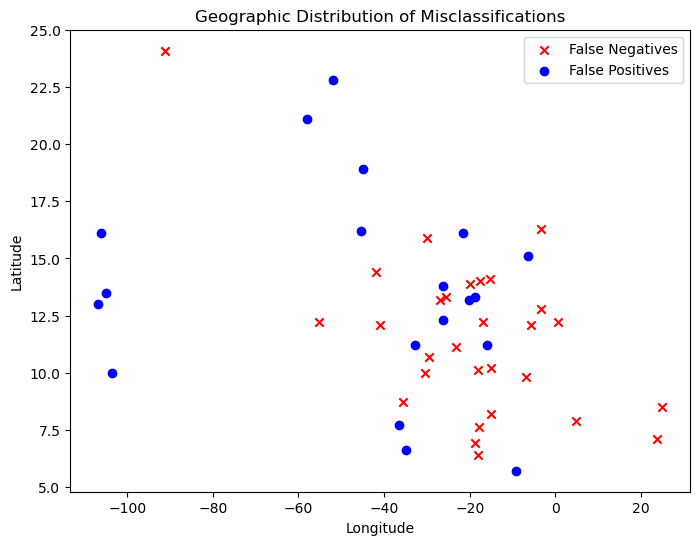

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


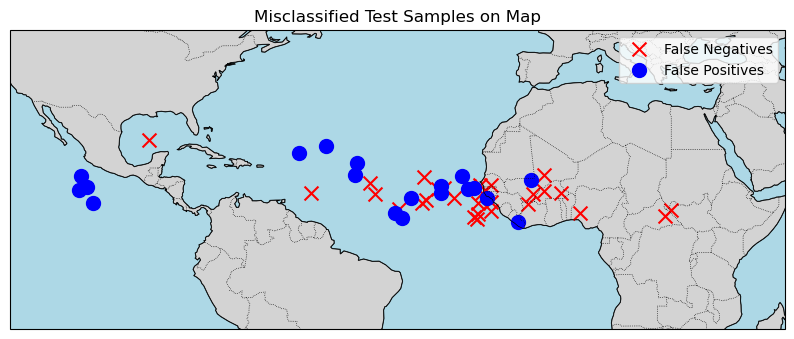

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

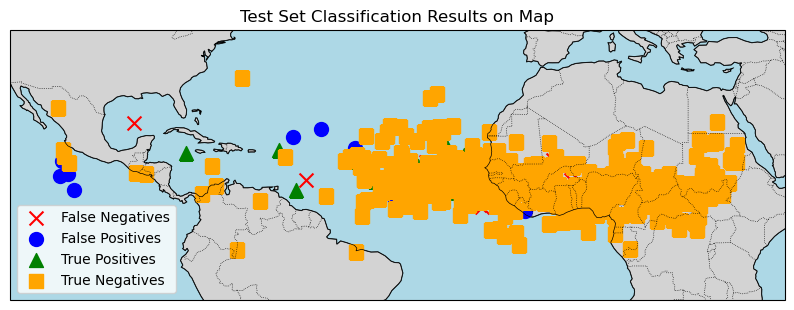

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2750
Unique latitudes: 251
Unique longitudes: 913


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

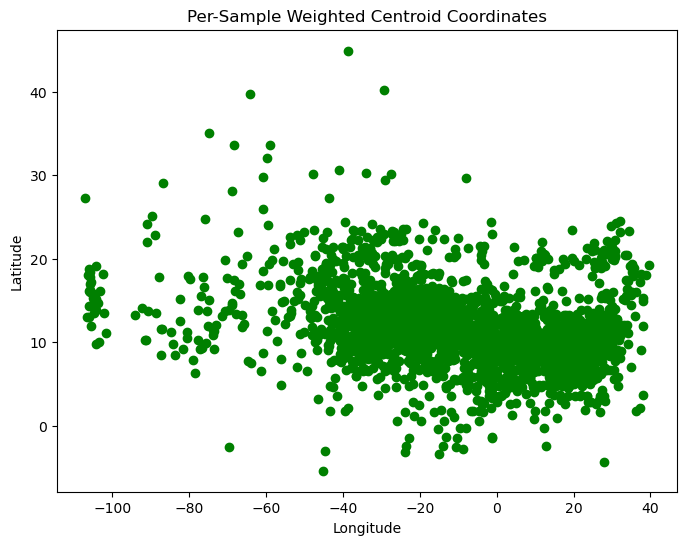

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.0316958948969841


Feature 0 - Increase in Loss: 0.007185883074998858


Feature 1 - Increase in Loss: -0.002016565948724746


Feature 2 - Increase in Loss: 0.004343029111623764


Feature 3 - Increase in Loss: -0.0016597885638475404


Feature 4 - Increase in Loss: 0.004783279448747638


Feature 5 - Increase in Loss: 0.004048792272806169


Feature 6 - Increase in Loss: -0.0003960475325584384


Feature 7 - Increase in Loss: 0.0012799337506294237


Feature 8 - Increase in Loss: 0.006387858837842944


Feature 9 - Increase in Loss: 0.0023852959275245667


Feature 10 - Increase in Loss: 0.006340095400810243


Feature 11 - Increase in Loss: 0.0026254624128341647


Feature 12 - Increase in Loss: 0.006367879360914229


Feature 13 - Increase in Loss: 0.010403810441493987


Feature 14 - Increase in Loss: 0.0010612443089485155


Feature 15 - Increase in Loss: 0.0035116285085678087


Feature 16 - Increase in Loss: 0.0047006100416183486


Feature 17 - Increase in Loss: 0.009060131013393403


Feature 18 - Increase in Loss: 0.006677839905023575


Feature 19 - Increase in Loss: 0.007985284179449083


Feature 20 - Increase in Loss: 0.005831504613161086


Feature 21 - Increase in Loss: 0.001635036617517474


Feature 22 - Increase in Loss: 0.004622526466846466


Feature 23 - Increase in Loss: -0.0017553005367517485


Feature 24 - Increase in Loss: -0.00018318258225917539


Feature 25 - Increase in Loss: 0.0009242281317710863


Feature 26 - Increase in Loss: -0.0002915155142545686
Permutation Importances (increase in loss) for all features: [ 0.00718588 -0.00201657  0.00434303 -0.00165979  0.00478328  0.00404879
 -0.00039605  0.00127993  0.00638786  0.0023853   0.0063401   0.00262546
  0.00636788  0.01040381  0.00106124  0.00351163  0.00470061  0.00906013
  0.00667784  0.00798528  0.0058315   0.00163504  0.00462253 -0.0017553
 -0.00018318  0.00092423 -0.00029152]


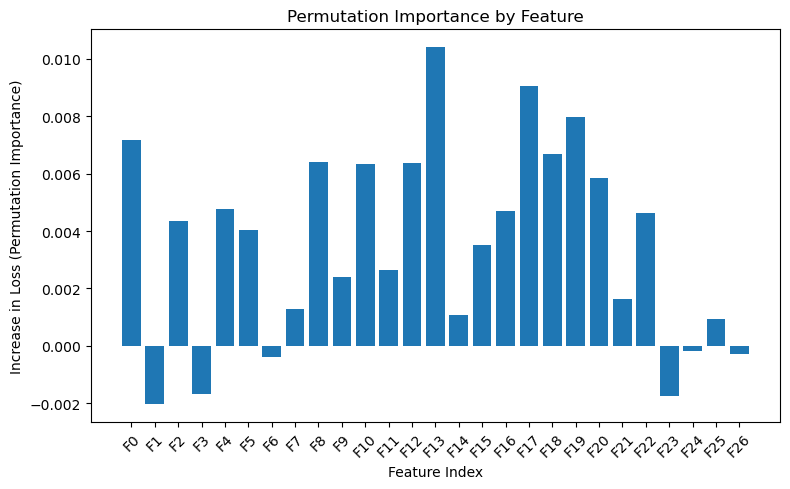

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


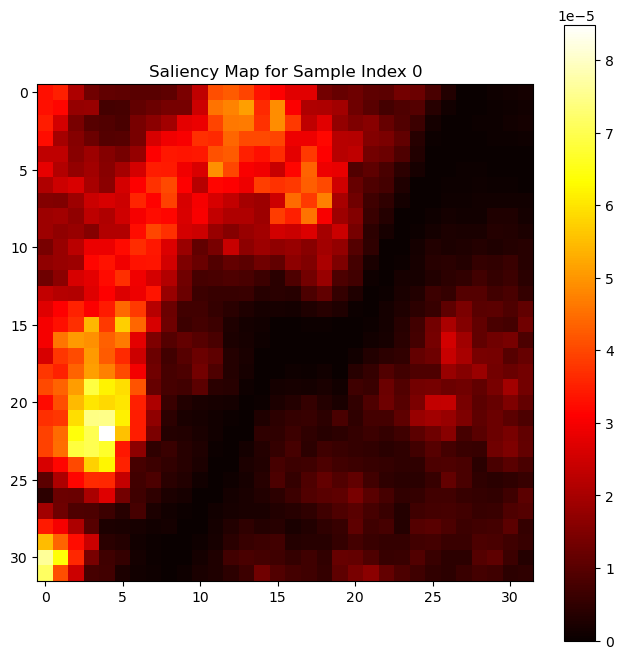

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



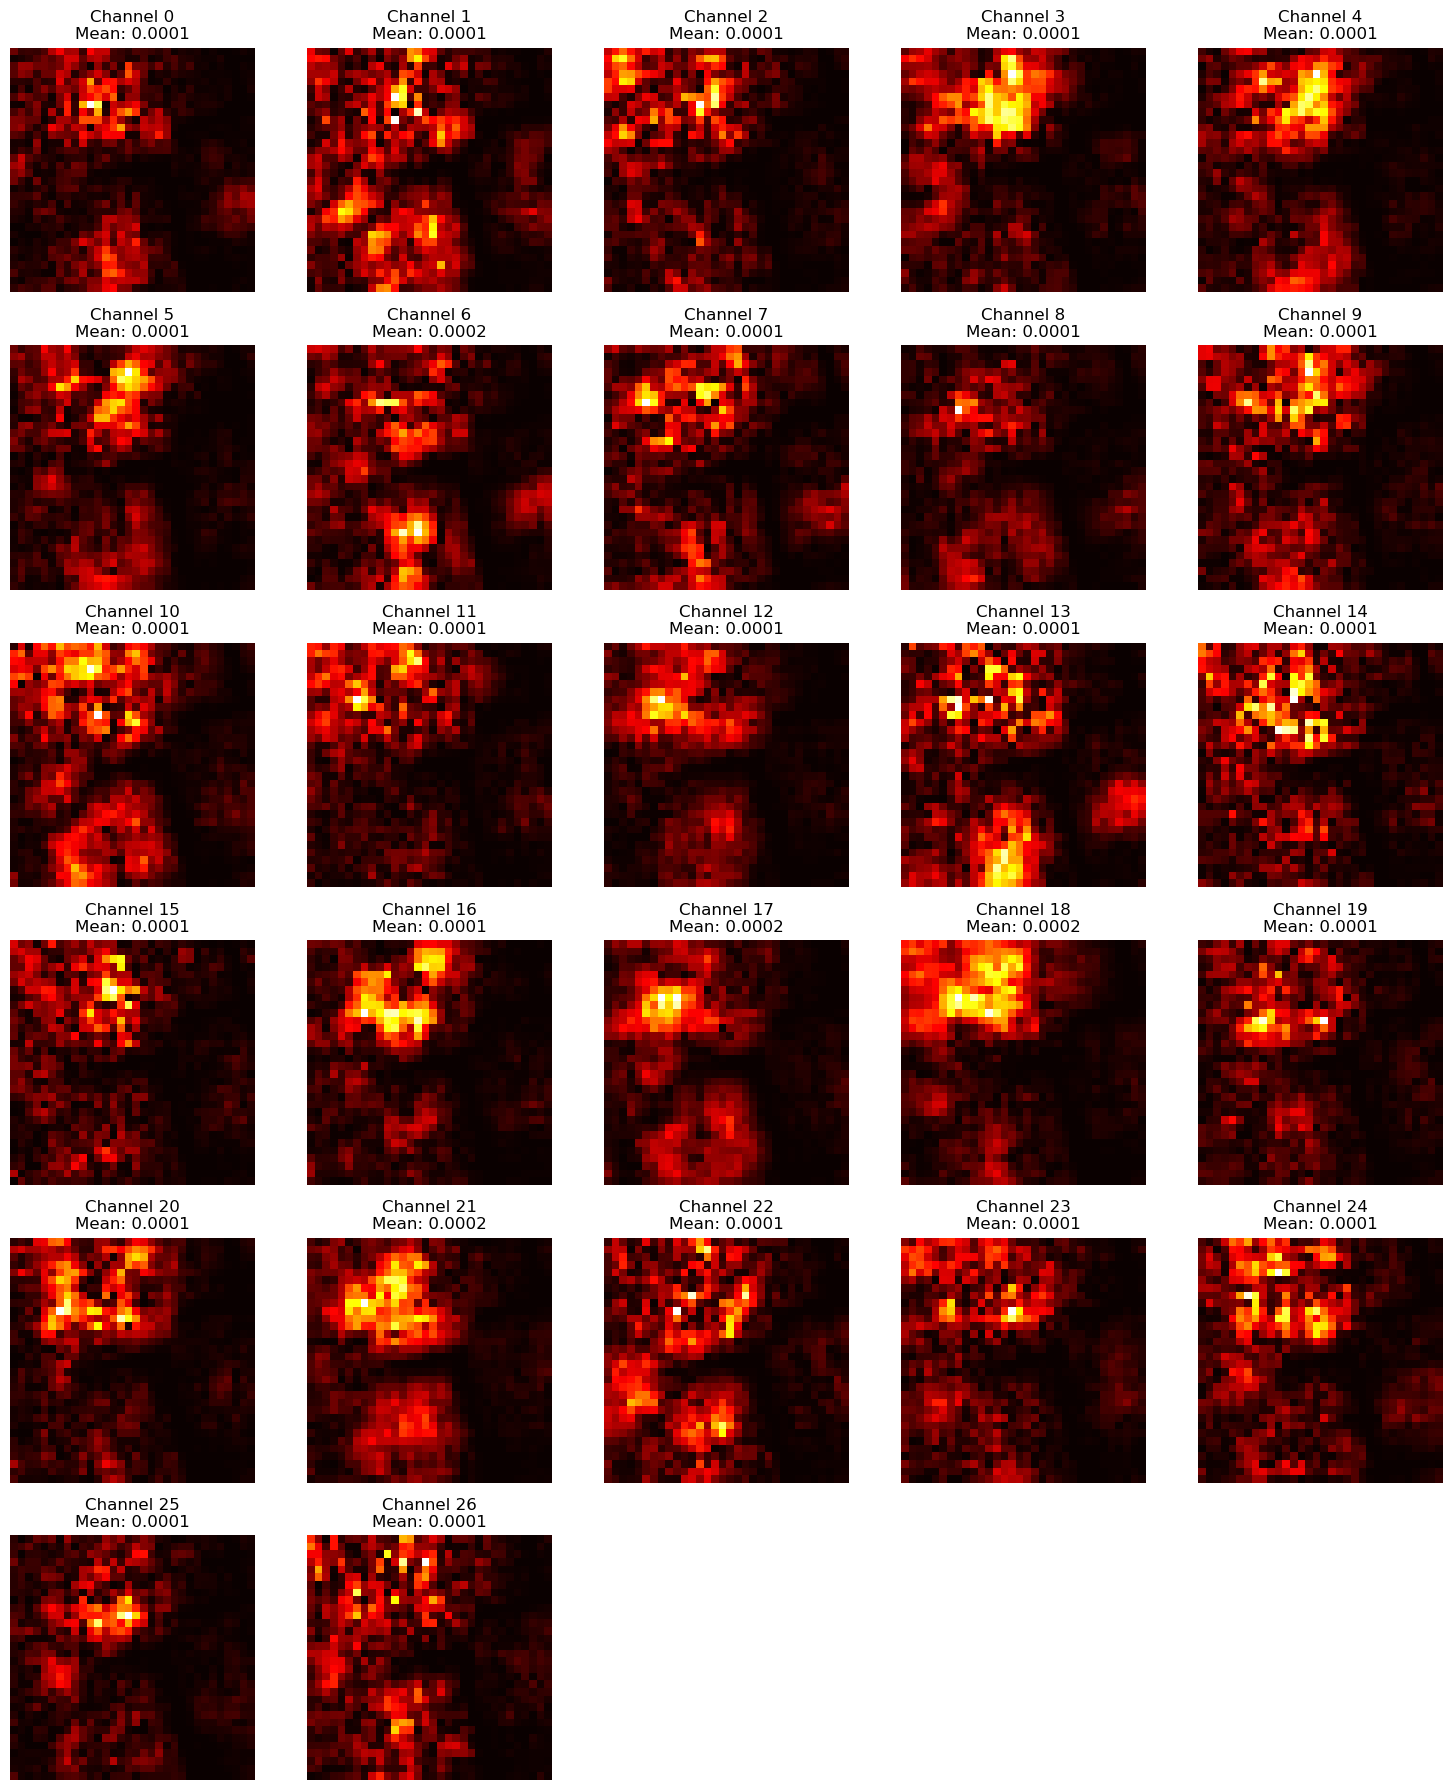

Channel importance (mean saliency per channel):
Channel 0: 0.0001
Channel 1: 0.0001
Channel 2: 0.0001
Channel 3: 0.0001
Channel 4: 0.0001
Channel 5: 0.0001
Channel 6: 0.0002
Channel 7: 0.0001
Channel 8: 0.0001
Channel 9: 0.0001
Channel 10: 0.0001
Channel 11: 0.0001
Channel 12: 0.0001
Channel 13: 0.0001
Channel 14: 0.0001
Channel 15: 0.0001
Channel 16: 0.0001
Channel 17: 0.0002
Channel 18: 0.0002
Channel 19: 0.0001
Channel 20: 0.0001
Channel 21: 0.0002
Channel 22: 0.0001
Channel 23: 0.0001
Channel 24: 0.0001
Channel 25: 0.0001
Channel 26: 0.0001


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


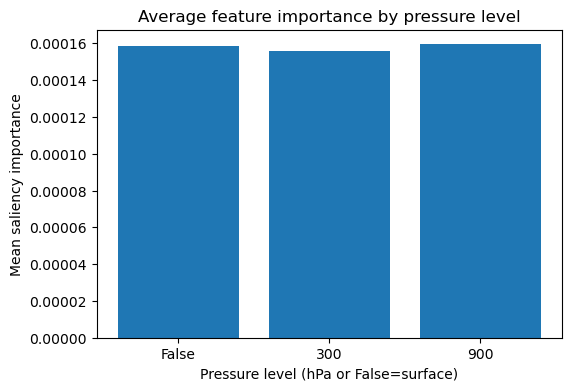

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.0316958948969841, 'compile_metrics': 0.23556749522686005}
    f1_score  val_f1_score
95  0.736842      0.645161
96  0.715596      0.260870
97  0.713959      0.300000
98  0.753488      0.400000
99  0.771028      0.588235


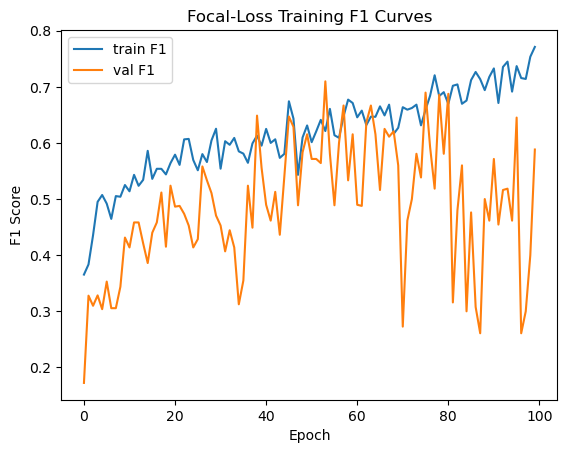

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.4943820224719101
